In [46]:
import sys
sys.executable = '/Applications/anaconda/envs/sherpa411/bin/python'
sys.path = ['', '/Applications/heasoft-6.24/x86_64-apple-darwin17.4.0/lib/python', 
            '/Applications/heasoft-6.24/x86_64-apple-darwin17.4.0/lib', 
            '/Applications/anaconda/envs/sherpa411/lib/python36.zip', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/lib-dynload', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages', 
            '/Applications/anaconda/envs/sherpa411/lib/python3.6/site-packages/sherpa-4.11.0+0.g838bd12b.dirty-py3.6-macosx-10.9-x86_64.egg']

In [45]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
from scipy.stats import ks_2samp
import time
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
import sherpa.astro.ui as ui
%matplotlib inline

In [3]:
import bayes
import simdat
import simdat_sherpa
import auto_corr
arf_table = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
arf = np.array(arf_table['ENERG_HI'])

### Currently, using absolute distance between points in two spectra as distance metric:

In [5]:
def geom_dist(data1,data2):
    """
    Input data must be 1D numpy arrays
    """
    diff = np.fabs(data1-data2)
    return np.sum(diff) #L1 norm
    #return np.mean(diff)

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [4]:
def ks_test(data1,data2):
    """
    Input data must be 1D numpy arrays
    Returns K-S statistic and p-value for the two distributions"""
    ks, p = ks_2samp(data1,data2)
    return ks, p

In [75]:
from numpy.linalg import inv
from scipy.spatial import distance

def mahalanobis_distance(data1,data2):
    """
    Input data must be 1D numpy arrays
    data 1 = TRUE data
    data 2 = simulated data for comparison
    Returns Mahalanobis distance between the two arrays
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html
    https://en.wikipedia.org/wiki/Mahalanobis_distance"""
    x = data2
    mu = data1
    cov = np.cov(mu)
    D_2 = np.dot(np.dot((x-mu).transpose(),cov),(x-mu))
    D = np.sqrt(D_2)
    return D

Mahalanobis distance: $D_{M} = \sqrt{(x-u)^{T}S^{-1}(x-u)}$ <br>
Where S is the covariance matris and u and x are 1-D arrays

In [74]:
a = np.array([1,0,0])
b = np.array([0,1,0])
x = a
mu = b
cov = np.cov(mu)
D_2 = np.dot(np.dot((x-mu).transpose(),cov),(x-mu))
D = np.sqrt(D_2)
print(D)

0.816496580927726


In [53]:
iv = [[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]]
distance.mahalanobis([1, 0, 0], [0, 1, 0], iv)
distance.mahalanobis([2, 0, 0], [0, 1, 0], iv)

1.7320508075688772

### 1. Generate "real data" using imported simdat functions. Only do this once, write to file, and save.

statistical errors were found in file '/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/fake_acis.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_hetg0_cy19.arf
read RMF file rmfs/aciss_hetg0_cy19.rmf
4111 photons
38 percent of the frames have piled events in them.


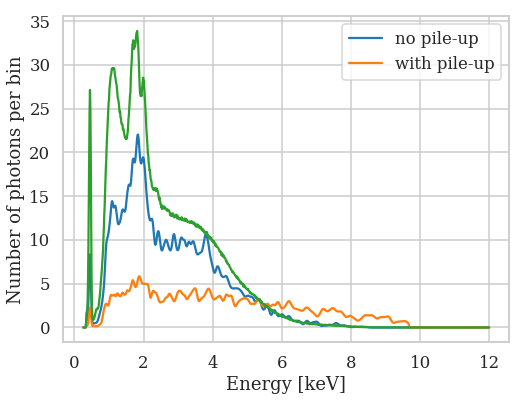

In [48]:
#Generate "real" data using Sherpa
datadir = "/Users/mlazz/Dropbox/UW/PileupABC/PileupABC/Margaret/"
ui.load_data(id="p1", filename=datadir+"fake_acis.pha")
d = ui.get_data("p1")
energy_bins, piled, unpiled, counts = simdat_sherpa.simulate_data(-2.3,1.7,d);
simdat_sherpa.plot_data(energy_bins, piled, unpiled, counts)
real_data = Table([energy_bins[:-1],unpiled,piled],names=('Energy','Unpiled','Piled'))

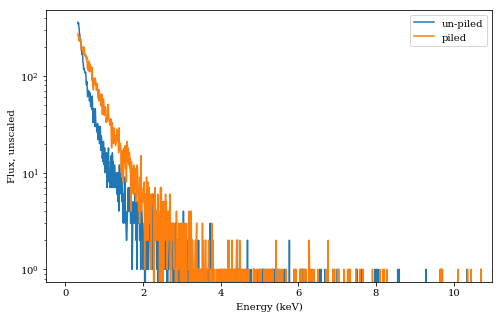

In [4]:
#Generate "real" data
energy_bins, energy_hist, piled_hist = simdat.simulate_data(50000,2.7,'cdf',arf)
simdat.plot_data(energy_bins, energy_hist, piled_hist)
real_data = Table([energy_bins,energy_hist,piled_hist],names=('Energy','Unpiled','Piled'))

### Save to file so you don't have to do this (somewhat time consuming step) every time

In [7]:
#!rm real_data.fits
#!rm real_data.txt
real_data.write('real_data_sherpa.fits',overwrite=True)
real_data.write('real_data_sherpa.txt',format='ascii',overwrite=True)

### ABC work start here:

ABC Overview:
*****
PART I
*****
1. Generate data set with given A (stop, length of observation, which will determine the number of photons using the Chandra count rate, or assumed count rate?) and alpha
2. Generate more data with the same input parameters, but they will be random because of the Poisson distribution
3. Find some metrics to compare the fake data to the real data (distance metrics, look what they use in the systems biology paper)
4. Plot distribution of metrics, m_i, and the histogram should look like a Gaussian or something like that
*****
PART II
*****
5. Simulate data from prior (a bunch of random choices from the prior)
6. Compare sim to real data using the same distance metrics as in Part I
7. Plot distribution 
8. Where the distribution from the real data intersects the distribution from the prior, make that the cut off for "good" fits - this is the distance metric I will use in Part III
*****
PART III: rejection sampling
*****
9. Sampe from prior, create simulated data
10. Calculate m_i
11. if $m_{i}<m_{threshold}$ (determined in Part II), accept. otherwise reject.

### PART I

### 2. Read in "real data" from file (created in step 1 above)

In [8]:
data = Table.read('real_data_sherpa.fits')
#data = Table.read('real_data.fits')

### 3. Only do this if you have done the step below where you generate 1000 iterations of data with the same input parameters. The 1000 spectra were saved to file to save time for future runs!

In [49]:
#data_part1 = Table.read('part1_fake_data.txt',format='ascii')
data_part1 = Table.read('part1_fake_data_sherpa.txt',format='ascii')

### 4. (only do this once and then save to file) Generate 1000 iterations of data with the same photon index (2.7) and observation time (50000 s) as the "real data"

In [8]:
simdat_sherpa.simulate_data?

In [9]:
#Only do this ONCE to generate data - otherwise, just read in part1_fake_data.txt in following cell
count=0
while count < 1000:
    if count%100 == 0:
        print(count)
    bins, piled, unpiled, counts = simdat_sherpa.simulate_data(-2.3,1.7,d)
    #bins, nrgy, new_spectrum = simdat.simulate_data(50000,2.7,'cdf',arf)
    #spec_col = Column(new_spectrum,name='simspec'+str(count))
    spec_col = Column(piled,name='simspec'+str(count))
    data.add_column(spec_col)
    count += 1

0
4030 photons
37 percent of the frames have piled events in them.
4020 photons
37 percent of the frames have piled events in them.
4092 photons
39 percent of the frames have piled events in them.
4023 photons
36 percent of the frames have piled events in them.
4011 photons
38 percent of the frames have piled events in them.
4079 photons
38 percent of the frames have piled events in them.
3967 photons
37 percent of the frames have piled events in them.
4027 photons
37 percent of the frames have piled events in them.
4100 photons
37 percent of the frames have piled events in them.
4100 photons
37 percent of the frames have piled events in them.
4091 photons
37 percent of the frames have piled events in them.
4111 photons
38 percent of the frames have piled events in them.
4004 photons
36 percent of the frames have piled events in them.
4061 photons
37 percent of the frames have piled events in them.
4024 photons
37 percent of the frames have piled events in them.
4003 photons
36 percent

4132 photons
38 percent of the frames have piled events in them.
4099 photons
38 percent of the frames have piled events in them.
3979 photons
36 percent of the frames have piled events in them.
4098 photons
38 percent of the frames have piled events in them.
3994 photons
36 percent of the frames have piled events in them.
4003 photons
37 percent of the frames have piled events in them.
4068 photons
37 percent of the frames have piled events in them.
4089 photons
37 percent of the frames have piled events in them.
4188 photons
37 percent of the frames have piled events in them.
4195 photons
38 percent of the frames have piled events in them.
4127 photons
38 percent of the frames have piled events in them.
4131 photons
38 percent of the frames have piled events in them.
4120 photons
38 percent of the frames have piled events in them.
4086 photons
37 percent of the frames have piled events in them.
4121 photons
38 percent of the frames have piled events in them.
4026 photons
37 percent o

4095 photons
37 percent of the frames have piled events in them.
4211 photons
39 percent of the frames have piled events in them.
4093 photons
38 percent of the frames have piled events in them.
4086 photons
38 percent of the frames have piled events in them.
4042 photons
36 percent of the frames have piled events in them.
4163 photons
38 percent of the frames have piled events in them.
4044 photons
37 percent of the frames have piled events in them.
4146 photons
38 percent of the frames have piled events in them.
4145 photons
39 percent of the frames have piled events in them.
300
4051 photons
37 percent of the frames have piled events in them.
4153 photons
39 percent of the frames have piled events in them.
3913 photons
36 percent of the frames have piled events in them.
4081 photons
37 percent of the frames have piled events in them.
4107 photons
38 percent of the frames have piled events in them.
4077 photons
38 percent of the frames have piled events in them.
3986 photons
36 perce

36 percent of the frames have piled events in them.
4023 photons
37 percent of the frames have piled events in them.
3949 photons
36 percent of the frames have piled events in them.
4068 photons
37 percent of the frames have piled events in them.
4074 photons
37 percent of the frames have piled events in them.
4001 photons
37 percent of the frames have piled events in them.
4101 photons
38 percent of the frames have piled events in them.
4026 photons
36 percent of the frames have piled events in them.
4090 photons
37 percent of the frames have piled events in them.
4078 photons
37 percent of the frames have piled events in them.
3989 photons
37 percent of the frames have piled events in them.
4051 photons
37 percent of the frames have piled events in them.
4097 photons
38 percent of the frames have piled events in them.
4044 photons
37 percent of the frames have piled events in them.
3983 photons
36 percent of the frames have piled events in them.
4187 photons
39 percent of the frames 

38 percent of the frames have piled events in them.
4027 photons
37 percent of the frames have piled events in them.
3991 photons
37 percent of the frames have piled events in them.
3987 photons
38 percent of the frames have piled events in them.
4114 photons
38 percent of the frames have piled events in them.
4046 photons
38 percent of the frames have piled events in them.
4213 photons
39 percent of the frames have piled events in them.
4146 photons
39 percent of the frames have piled events in them.
4029 photons
37 percent of the frames have piled events in them.
3994 photons
36 percent of the frames have piled events in them.
4028 photons
36 percent of the frames have piled events in them.
4094 photons
38 percent of the frames have piled events in them.
4066 photons
37 percent of the frames have piled events in them.
4066 photons
37 percent of the frames have piled events in them.
4087 photons
37 percent of the frames have piled events in them.
4099 photons
37 percent of the frames 

4131 photons
38 percent of the frames have piled events in them.
4096 photons
38 percent of the frames have piled events in them.
4041 photons
37 percent of the frames have piled events in them.
4128 photons
38 percent of the frames have piled events in them.
4094 photons
38 percent of the frames have piled events in them.
4152 photons
38 percent of the frames have piled events in them.
4020 photons
37 percent of the frames have piled events in them.
4058 photons
37 percent of the frames have piled events in them.
3948 photons
36 percent of the frames have piled events in them.
700
4090 photons
38 percent of the frames have piled events in them.
4057 photons
38 percent of the frames have piled events in them.
3962 photons
35 percent of the frames have piled events in them.
4020 photons
37 percent of the frames have piled events in them.
4102 photons
38 percent of the frames have piled events in them.
3976 photons
37 percent of the frames have piled events in them.
4054 photons
37 perce

4061 photons
37 percent of the frames have piled events in them.
4052 photons
38 percent of the frames have piled events in them.
4045 photons
36 percent of the frames have piled events in them.
4117 photons
38 percent of the frames have piled events in them.
4224 photons
39 percent of the frames have piled events in them.
4016 photons
37 percent of the frames have piled events in them.
4098 photons
37 percent of the frames have piled events in them.
4006 photons
36 percent of the frames have piled events in them.
4026 photons
36 percent of the frames have piled events in them.
3970 photons
36 percent of the frames have piled events in them.
4020 photons
38 percent of the frames have piled events in them.
4116 photons
38 percent of the frames have piled events in them.
4054 photons
37 percent of the frames have piled events in them.
4179 photons
39 percent of the frames have piled events in them.
4089 photons
38 percent of the frames have piled events in them.
4135 photons
38 percent o

4055 photons
36 percent of the frames have piled events in them.
4045 photons
37 percent of the frames have piled events in them.
4091 photons
37 percent of the frames have piled events in them.
4022 photons
37 percent of the frames have piled events in them.
4052 photons
38 percent of the frames have piled events in them.
3998 photons
36 percent of the frames have piled events in them.
4035 photons
37 percent of the frames have piled events in them.
3939 photons
36 percent of the frames have piled events in them.
4051 photons
36 percent of the frames have piled events in them.
4076 photons
38 percent of the frames have piled events in them.
4032 photons
37 percent of the frames have piled events in them.
4104 photons
38 percent of the frames have piled events in them.
3987 photons
37 percent of the frames have piled events in them.
4060 photons
38 percent of the frames have piled events in them.
4143 photons
38 percent of the frames have piled events in them.
4019 photons
36 percent o

### 5. Check and see if distance between these 1000 spectra generated with the same photon index and observation time as the "real data" look like a roughly normal distribution...

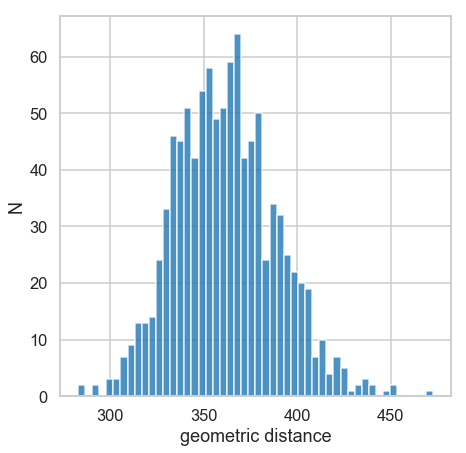

In [13]:
#Check to see that geometric distances looks roughly like a normal distribution...
m = np.zeros(1000,dtype=float)
for i in range(len(m)):
    m[i] = geom_dist(np.array(data_part1['Piled']),np.array(data_part1['simspec'+str(i)]))

fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('geometric distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(m,bins=50,alpha=0.8)
plt.savefig('abc_part1.pdf')

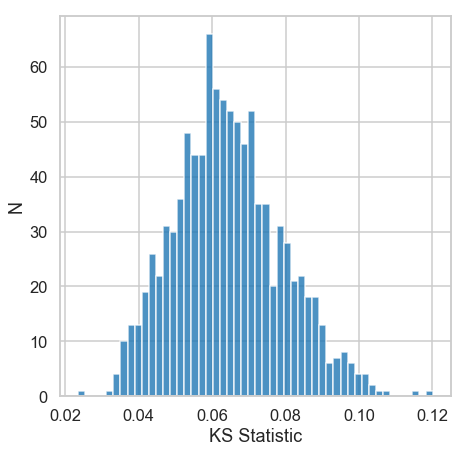

In [14]:
#Check that the KS statistic distribution looks roughly normal...
ks = np.zeros(1000,dtype=float)
for i in range(len(ks)):
    ks[i],p = ks_test(np.array(data_part1['Piled']),np.array(data_part1['simspec'+str(i)]))

fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('KS Statistic',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(ks,bins=50,alpha=0.8)
plt.savefig('abc_part1_sherpa_ks.pdf')

(array([ 1.,  1.,  1.,  0.,  1.,  3.,  1.,  3.,  5., 10., 10., 19., 18.,
        29., 26., 40., 35., 35., 35., 45., 40., 49., 51., 50., 47., 45.,
        38., 47., 44., 30., 41., 34., 28., 27., 22., 20., 13.,  9., 10.,
         5.,  8.,  5.,  6.,  1.,  1.,  3.,  6.,  0.,  1.,  1.]),
 array([21.07173684, 21.32788016, 21.58402348, 21.8401668 , 22.09631013,
        22.35245345, 22.60859677, 22.86474009, 23.12088341, 23.37702673,
        23.63317005, 23.88931337, 24.14545669, 24.40160002, 24.65774334,
        24.91388666, 25.17002998, 25.4261733 , 25.68231662, 25.93845994,
        26.19460326, 26.45074658, 26.70688991, 26.96303323, 27.21917655,
        27.47531987, 27.73146319, 27.98760651, 28.24374983, 28.49989315,
        28.75603647, 29.0121798 , 29.26832312, 29.52446644, 29.78060976,
        30.03675308, 30.2928964 , 30.54903972, 30.80518304, 31.06132636,
        31.31746968, 31.57361301, 31.82975633, 32.08589965, 32.34204297,
        32.59818629, 32.85432961, 33.11047293, 33.36661625,

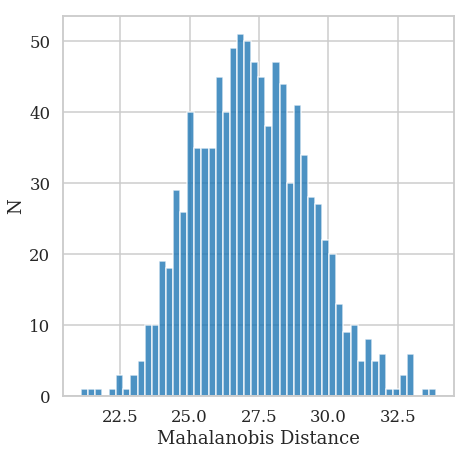

In [78]:
#Check that the Mahalanobis distance distribution
md = np.zeros(1000,dtype=float)
for i in range(len(md)):
    md[i] = mahalanobis_distance(np.array(data_part1['Piled']),np.array(data_part1['simspec'+str(i)]))

fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('Mahalanobis Distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(md,bins=50,alpha=0.8)
#plt.savefig('abc_part1_sherpa_ks.pdf')

### 6. Write 1000 spectra to file to speed things up in future runs

In [11]:
#data.write('part1_fake_data.txt',format='ascii')
data.write('part1_fake_data_sherpa.txt',format='ascii',overwrite=True)

### PART II

Priors: photon index between 0 and 5, observation time between 10,000 and 100,000 s

### 7. Read in "real data" again if starting from this point in code

In [18]:
data = Table.read('real_data_sherpa.fits')
#data = Table.read('real_data.fits')

In [17]:
data[:3]

<Table length=3>
       Energy       Unpiled  Piled 
      float64       float64 float64
------------------- ------- -------
 0.2549999952316284     0.0     0.0
0.26646971702575684     0.0     0.0
0.27793943881988525     0.0     0.0

### 8. Now, generate 1000 spectra with photon index and exposure times sampled from the priors

In [19]:
print(10000/1.0E7,100000/1.0E7)

0.001 0.01


In [19]:
N = 1000
phot_ind = np.random.uniform(0.5,5,N)
log_norm = np.random.uniform(-3,-1,N)
for i in range(N):
    print(i, log_norm[i],phot_ind[i])
    #bins, nrgy, new_spectrum = simdat.simulate_data(obs_time[i],phot_ind[i],'cdf',arf)
    bins, piled, unpiled, counts = simdat_sherpa.simulate_data(log_norm[i],phot_ind[i],d)
    spec_col = Column(piled,name='simspec'+str(i))
    #spec_col = Column(new_spectrum,name='simspec'+str(i))
    data.add_column(spec_col)

0 -1.5248325396904376 2.215572865012723
15154 photons
96 percent of the frames have piled events in them.
1 -2.979661431981195 2.6073739168283785
400 photons
0 percent of the frames have piled events in them.
2 -1.789642107772732 0.6247809666668052
45946 photons
100 percent of the frames have piled events in them.
3 -1.496354088240943 3.0609303457090165
10813 photons
85 percent of the frames have piled events in them.
4 -2.9126981313414686 0.9834154678050652
2212 photons
16 percent of the frames have piled events in them.
5 -2.1644411595024824 4.111780527695865
3008 photons
25 percent of the frames have piled events in them.
6 -2.6096239681045743 3.8099670122929323
880 photons
3 percent of the frames have piled events in them.
7 -1.5872930107546055 1.8015238869530188
19073 photons
98 percent of the frames have piled events in them.
8 -2.4009114361770196 3.3035831626500904
1267 photons
6 percent of the frames have piled events in them.
9 -1.926133670515622 4.677151730624863
7972 photons

100 percent of the frames have piled events in them.
88 -2.0398756111568512 2.9980928730786944
3038 photons
25 percent of the frames have piled events in them.
89 -1.5719167020092424 3.307498188061299
8723 photons
76 percent of the frames have piled events in them.
90 -1.2494452387703527 2.0780289670461274
32420 photons
99 percent of the frames have piled events in them.
91 -2.3144238740548584 2.842670296324319
1700 photons
10 percent of the frames have piled events in them.
92 -1.4131947654886363 2.655248383457631
15150 photons
95 percent of the frames have piled events in them.
93 -2.7798929252861804 2.3685749490885106
778 photons
2 percent of the frames have piled events in them.
94 -1.6715389109618128 2.690285832000103
8294 photons
75 percent of the frames have piled events in them.
95 -2.528789752682024 3.7560127683962516
1062 photons
4 percent of the frames have piled events in them.
96 -1.4859391715017967 2.7259194320953384
12675 photons
92 percent of the frames have piled event

98 percent of the frames have piled events in them.
179 -1.5535895411943004 2.8056634306879156
10315 photons
84 percent of the frames have piled events in them.
180 -1.7733255296705024 4.9737658626930275
15299 photons
95 percent of the frames have piled events in them.
181 -1.716035266270191 4.052626313544004
7886 photons
71 percent of the frames have piled events in them.
182 -2.6229322789808087 2.24110413595403
1221 photons
6 percent of the frames have piled events in them.
183 -1.9137949484175456 3.2692785017086625
4006 photons
36 percent of the frames have piled events in them.
184 -1.009769810831515 2.6786730583237452
38266 photons
99 percent of the frames have piled events in them.
185 -2.2773904159120075 4.548801126692036
3159 photons
27 percent of the frames have piled events in them.
186 -1.2552070883632542 0.6232543645996598
157633 photons
100 percent of the frames have piled events in them.
187 -1.8064409200479148 4.732645447862961
10962 photons
85 percent of the frames have

100 percent of the frames have piled events in them.
259 -2.2094014771187873 0.8390637357491735
13282 photons
92 percent of the frames have piled events in them.
260 -2.5560575414867417 3.897100571503965
1050 photons
4 percent of the frames have piled events in them.
261 -1.604813018776258 4.126816360873795
10793 photons
86 percent of the frames have piled events in them.
262 -1.788463426231792 2.1049106946617906
9258 photons
79 percent of the frames have piled events in them.
263 -2.4195880791879794 3.112418075225574
1225 photons
5 percent of the frames have piled events in them.
264 -1.185664549858049 2.5928794260119776
26531 photons
99 percent of the frames have piled events in them.
265 -2.2158626402200845 1.4460880086216457
6298 photons
60 percent of the frames have piled events in them.
266 -1.6322478298331673 0.655530458358372
63805 photons
100 percent of the frames have piled events in them.
267 -2.8491625997308434 4.835999101093736
1109 photons
5 percent of the frames have pil

98 percent of the frames have piled events in them.
336 -2.5145884856846825 2.8006336616147083
1136 photons
5 percent of the frames have piled events in them.
337 -1.407926278006884 0.6687924190349246
104125 photons
100 percent of the frames have piled events in them.
338 -2.2549403747294887 2.0682988368851225
3201 photons
26 percent of the frames have piled events in them.
339 -1.4044747485170503 2.601139364081451
16052 photons
96 percent of the frames have piled events in them.
340 -2.184571864723516 3.453149958693363
2208 photons
15 percent of the frames have piled events in them.
341 -2.208855884300233 1.453858463412215
6350 photons
60 percent of the frames have piled events in them.
342 -1.8302460184667124 3.090127677093978
4952 photons
47 percent of the frames have piled events in them.
343 -1.7845942910109422 2.2773269746468205
8040 photons
73 percent of the frames have piled events in them.
344 -1.99044501529131 2.561583347602609
4223 photons
39 percent of the frames have piled

100 percent of the frames have piled events in them.
413 -2.2156368155312895 2.000028610601013
3741 photons
33 percent of the frames have piled events in them.
414 -2.2198848448390507 2.971936174825801
2045 photons
14 percent of the frames have piled events in them.
415 -1.2417458858781842 4.889211925922145
48067 photons
100 percent of the frames have piled events in them.
416 -1.1485327533795504 2.5159418015628265
30101 photons
99 percent of the frames have piled events in them.
417 -1.2655252995789825 3.4056155930561975
17647 photons
97 percent of the frames have piled events in them.
418 -2.239896389992488 2.4676687451558905
2510 photons
19 percent of the frames have piled events in them.
419 -1.80168255141497 4.8753165084910455
13010 photons
92 percent of the frames have piled events in them.
420 -2.6810522256901717 3.393571347778295
677 photons
2 percent of the frames have piled events in them.
421 -2.5820084740259013 3.1492600385497336
919 photons
3 percent of the frames have pil

23 percent of the frames have piled events in them.
492 -2.8704237055271618 3.2159655211487936
461 photons
0 percent of the frames have piled events in them.
493 -2.5126982659467543 2.165600505802538
1676 photons
10 percent of the frames have piled events in them.
494 -2.218402539718566 3.634298896278408
2084 photons
14 percent of the frames have piled events in them.
495 -2.60773618054965 4.233199476985202
1172 photons
5 percent of the frames have piled events in them.
496 -2.825278286640703 4.7023662221579965
1056 photons
4 percent of the frames have piled events in them.
497 -1.2482115607933255 1.1978888047762992
78435 photons
100 percent of the frames have piled events in them.
498 -1.739690331267968 1.3406224821062844
21175 photons
98 percent of the frames have piled events in them.
499 -1.7106662620808728 3.3817171547397535
6427 photons
61 percent of the frames have piled events in them.
500 -2.1600327266743133 1.1094371783948698
10716 photons
85 percent of the frames have piled 

575 -1.5754044610473883 4.49567010857544
15234 photons
95 percent of the frames have piled events in them.
576 -1.9221499971008156 4.986284280463804
10979 photons
86 percent of the frames have piled events in them.
577 -2.055175343804353 4.2403391782511015
4125 photons
38 percent of the frames have piled events in them.
578 -2.5509897674660573 1.313669700963245
3416 photons
29 percent of the frames have piled events in them.
579 -1.4354496431963495 1.0744217851477473
58116 photons
100 percent of the frames have piled events in them.
580 -1.2312109094922572 2.83093311489833
21319 photons
99 percent of the frames have piled events in them.
581 -1.9470344629568537 1.3845180234329844
12689 photons
91 percent of the frames have piled events in them.
582 -1.3354638746874625 2.726823313744613
17595 photons
97 percent of the frames have piled events in them.
583 -1.081629496446358 3.7171648793777807
29126 photons
99 percent of the frames have piled events in them.
584 -1.4453660997528655 1.838

656 -1.747155517600251 3.525460339989658
6076 photons
57 percent of the frames have piled events in them.
657 -2.1376952080467957 1.2414524233250124
9525 photons
81 percent of the frames have piled events in them.
658 -1.591798141949424 1.0969359246739252
39964 photons
100 percent of the frames have piled events in them.
659 -1.307319400549342 3.1930123016474083
16413 photons
96 percent of the frames have piled events in them.
660 -1.3489214650201509 4.672435343382613
29929 photons
99 percent of the frames have piled events in them.
661 -1.3606170490049083 0.7050262891046148
111359 photons
100 percent of the frames have piled events in them.
662 -1.5472950894940685 0.6110304667133455
81985 photons
100 percent of the frames have piled events in them.
663 -2.5245411316361075 0.6024904202541345
8753 photons
77 percent of the frames have piled events in them.
664 -1.043874377296444 0.6593144341937387
245370 photons
100 percent of the frames have piled events in them.
665 -1.940577651245265

737 -2.0640885081633744 3.7840537273988133
3067 photons
26 percent of the frames have piled events in them.
738 -2.6360875259587253 1.9008453235590126
1549 photons
8 percent of the frames have piled events in them.
739 -2.815889793185901 3.2145611445823996
541 photons
1 percent of the frames have piled events in them.
740 -1.1864276753023535 4.498014652820087
37130 photons
99 percent of the frames have piled events in them.
741 -2.4467799415845173 1.749917444912248
2687 photons
21 percent of the frames have piled events in them.
742 -2.593940868283372 1.0733173554632178
4127 photons
38 percent of the frames have piled events in them.
743 -2.6190243590753117 1.8200792044391139
1686 photons
10 percent of the frames have piled events in them.
744 -2.45502269205741 3.8701279144848977
1382 photons
7 percent of the frames have piled events in them.
745 -1.584220622468408 1.2708835024217437
33483 photons
99 percent of the frames have piled events in them.
746 -2.6067391930271 2.36241206760093

815 -2.156773291126708 2.057007778924884
4108 photons
37 percent of the frames have piled events in them.
816 -2.205263683772717 3.290998325348493
2054 photons
14 percent of the frames have piled events in them.
817 -2.5159372461626157 1.0878512823140787
4818 photons
46 percent of the frames have piled events in them.
818 -1.0378319327430412 1.4150871409745633
99396 photons
100 percent of the frames have piled events in them.
819 -2.6649067779164817 2.718075550144837
834 photons
2 percent of the frames have piled events in them.
820 -2.9797521860309963 0.8664281710424275
2182 photons
15 percent of the frames have piled events in them.
821 -2.67756710931807 3.626621248014555
659 photons
1 percent of the frames have piled events in them.
822 -1.2807358313791464 0.7279163901675284
130130 photons
100 percent of the frames have piled events in them.
823 -1.7408600280720905 3.6703167067237117
6358 photons
60 percent of the frames have piled events in them.
824 -1.2555706251558447 0.663681619

100 percent of the frames have piled events in them.
900 -2.8012012059131823 1.2431582268357326
2090 photons
14 percent of the frames have piled events in them.
901 -1.3457403960557517 4.518184743145382
26164 photons
99 percent of the frames have piled events in them.
902 -2.6541109008035084 4.6178493092342485
1365 photons
7 percent of the frames have piled events in them.
903 -1.4302596965290562 2.9250944511272388
13130 photons
92 percent of the frames have piled events in them.
904 -1.2157879453960345 4.051508231742188
25109 photons
99 percent of the frames have piled events in them.
905 -1.8030550197114754 1.865529225633028
10764 photons
86 percent of the frames have piled events in them.
906 -2.167109279872339 4.625161552986975
4329 photons
40 percent of the frames have piled events in them.
907 -1.7495635795000268 3.504821846265728
6139 photons
58 percent of the frames have piled events in them.
908 -2.6998978407198218 0.7822977929755532
4703 photons
45 percent of the frames have 

980 -1.2228492974758858 3.686627023069505
20860 photons
99 percent of the frames have piled events in them.
981 -1.0761028864276752 3.79453318322357
30290 photons
100 percent of the frames have piled events in them.
982 -2.4264069428074926 3.539043506331363
1213 photons
5 percent of the frames have piled events in them.
983 -1.53828471152807 3.0323863545877403
10034 photons
82 percent of the frames have piled events in them.
984 -1.6143739508970822 4.302340817123179
11767 photons
88 percent of the frames have piled events in them.
985 -1.9906369773308883 0.5049789971896503
33896 photons
100 percent of the frames have piled events in them.
986 -2.6914312512319336 3.6255546310032125
712 photons
2 percent of the frames have piled events in them.
987 -1.7915373528369707 1.6732237862719221
13567 photons
93 percent of the frames have piled events in them.
988 -1.435892385889769 0.9751061790676505
66623 photons
100 percent of the frames have piled events in them.
989 -2.328279832226591 2.2253

In [29]:
#!rm part2_fake_data_sherpa.txt
data.write('part2_fake_data_sherpa.txt',format='ascii',overwrite=True)

### 9. If step 8 has already been completed and read to file, read in the 1000 spectra generated by sampling parameters from the prior

In [30]:
data_part2 = Table.read('part2_fake_data_sherpa.txt',format='ascii')
#data_part2 = Table.read('part2_fake_data.txt',format='ascii')

### 10. Calculate distance between spectra generated by sampling prior and the "real data"

In [31]:
m_2 = np.zeros(1000,dtype=float)
for i in range(len(m)):
    m_2[i] = geom_dist(np.array(data_part2['Piled']),np.array(data_part2['simspec'+str(i)]))

In [32]:
ks_2 = np.zeros(1000,dtype=float)
for i in range(len(ks_2)):
    ks_2[i],p = ks_test(np.array(data_part2['Piled']),np.array(data_part2['simspec'+str(i)]))

In [79]:
md_2 = np.zeros(1000,dtype=float)
for i in range(len(md_2)):
    md_2[i] = mahalanobis_distance(np.array(data_part2['Piled']),np.array(data_part2['simspec'+str(i)]))

### 11. Plot distribution of distances

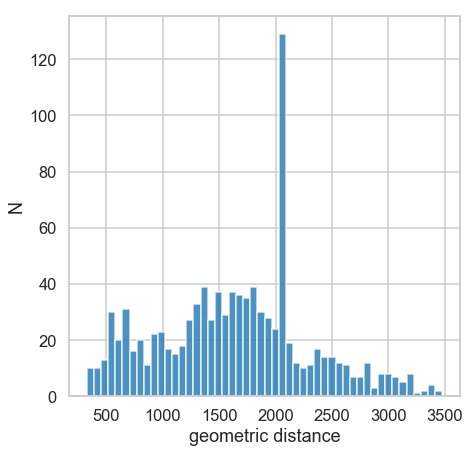

In [33]:
fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('geometric distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(m_2,bins=50,alpha=0.8)
plt.savefig('abc_part2_sherpa.pdf')

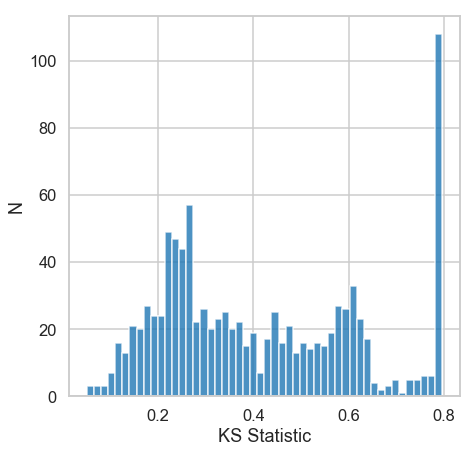

In [25]:
fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('KS Statistic',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(ks_2,bins=50,alpha=0.8)
plt.savefig('abc_part2_sherpa_ks.pdf')

(array([ 23.,  56.,  57.,  48.,  51.,  68.,  77.,  54.,  83.,  93., 106.,
         25.,  22.,  18.,  14.,  12.,  12.,   9.,   9.,   2.,  10.,   7.,
          4.,  14.,   9.,   5.,   9.,   4.,   4.,   8.,   9.,   9.,   8.,
          5.,   4.,   3.,   5.,   3.,   4.,   8.,   3.,   3.,   6.,   3.,
          5.,   0.,   3.,   3.,   1.,   2.]),
 array([ 24.19119511,  35.40776724,  46.62433937,  57.8409115 ,
         69.05748363,  80.27405576,  91.49062789, 102.70720003,
        113.92377216, 125.14034429, 136.35691642, 147.57348855,
        158.79006068, 170.00663281, 181.22320494, 192.43977707,
        203.6563492 , 214.87292133, 226.08949346, 237.30606559,
        248.52263772, 259.73920985, 270.95578199, 282.17235412,
        293.38892625, 304.60549838, 315.82207051, 327.03864264,
        338.25521477, 349.4717869 , 360.68835903, 371.90493116,
        383.12150329, 394.33807542, 405.55464755, 416.77121968,
        427.98779181, 439.20436394, 450.42093608, 461.63750821,
        472.854080

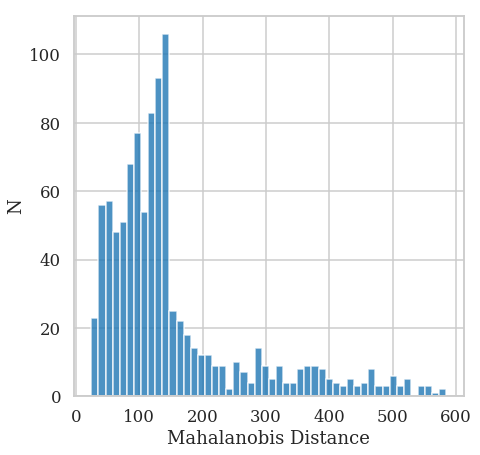

In [80]:
fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('Mahalanobis Distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(md_2,bins=50,alpha=0.8)
#plt.savefig('abc_part2_sherpa_ks.pdf')

# Question: where is there a bimodal distribution in the KS statistic? It is essentially the difference between the "real" and simulated spectrum sampled from the prior. Could it be that you could have data that really is similar (first peak) and then the more different the photon index is, the more pile-up skews things creating a peak at higher KS values?

### 12. Make plot comparing geometric distance between spectra created with "real" parameters and spectra generated with parameters sampled from the prior. The distance where these two distributions overlap should be the "acceptable distance" under which to accept simulated spectra in the ABC algorithm. Here, we find that this distane should be m=1.77

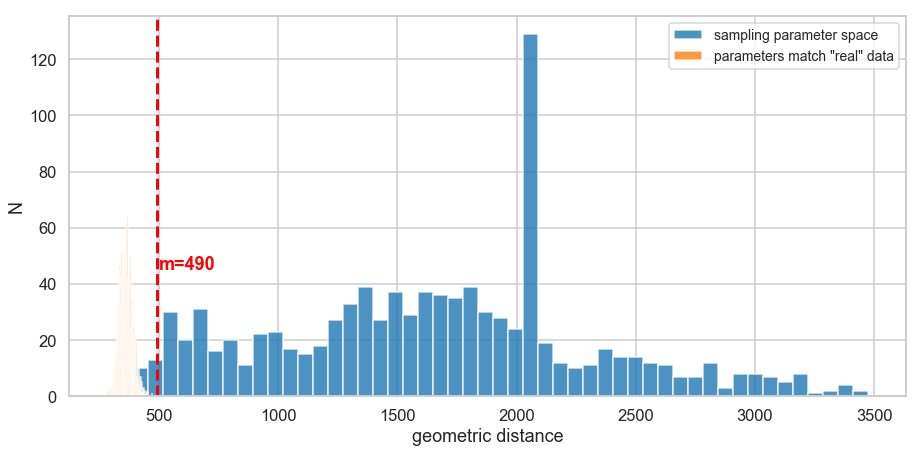

In [27]:
fig,ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('geometric distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.set_ylim(0,85)
#ax.set_xlim(1,6)
ax.axvline(490,color='r',linestyle='--',linewidth=3)
ax.text(500,45,'m=490',fontsize=18,color='r',weight='bold')
ax.hist(m_2,bins=50,alpha=0.8,label='sampling parameter space')
ax.hist(m,bins=50,alpha=0.8,label='parameters match "real" data')
ax.legend(fontsize=14)
#plt.savefig('abc_part2_combo_sherpa.pdf')

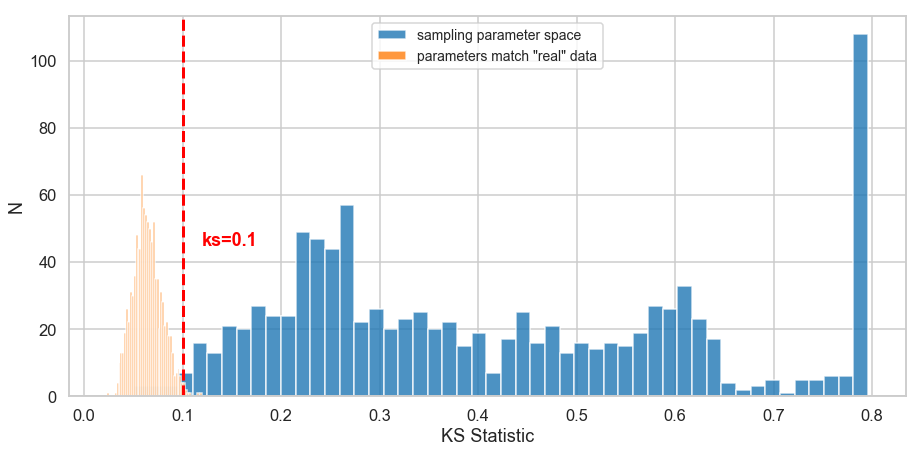

In [28]:
fig,ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('KS Statistic',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.set_ylim(0,85)
#ax.set_xlim(1,6)
ax.axvline(0.1,color='r',linestyle='--',linewidth=3)
ax.text(0.12,45,'ks=0.1',fontsize=18,color='r',weight='bold')
ax.hist(ks_2,bins=50,alpha=0.8,label='sampling parameter space')
ax.hist(ks,bins=50,alpha=0.8,label='parameters match "real" data')
ax.legend(fontsize=14)
#plt.savefig('abc_part2_combo_sherpa_ks.pdf')

(0, 100)

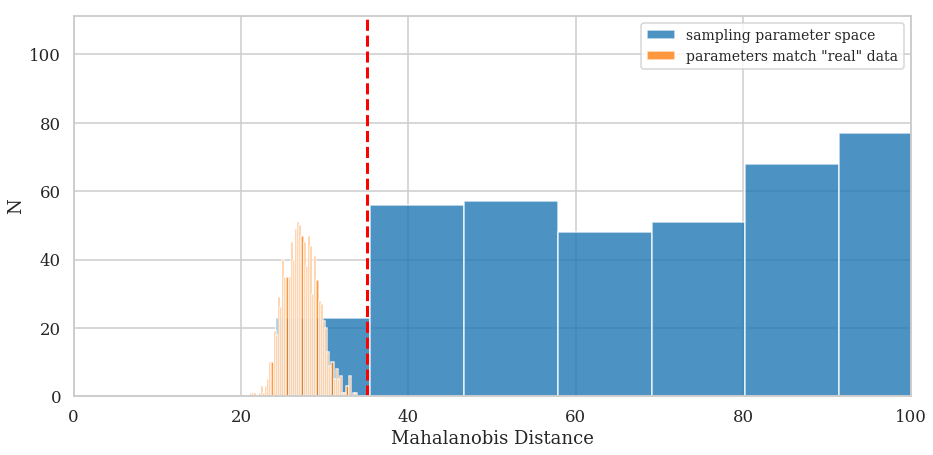

In [83]:
fig,ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('Mahalanobis Distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.set_ylim(0,85)
#ax.set_xlim(1,6)
ax.axvline(35,color='r',linestyle='--',linewidth=3)
#ax.text(0.12,45,'ks=0.1',fontsize=18,color='r',weight='bold')
ax.hist(md_2,bins=50,alpha=0.8,label='sampling parameter space')
ax.hist(md,bins=50,alpha=0.8,label='parameters match "real" data')
ax.legend(fontsize=14)
ax.set_xlim(0,100)
#plt.savefig('abc_part2_combo_sherpa_ks.pdf')

### 13. Write 1000 spectra generated from priors to file to speed up future work.

In [9]:
!rm part2_fake_data.txt
data.write('part2_fake_data.txt',format='ascii')

# Distance metric: 
### geometric distance $m_{threshold}<1.77$ using simple power law
### geometric distance $m_{threshold}<1650$ using Sherpa power law with ARF and RMF
### KS statistic $KS_{threshold}<0.035$ using Sherpa power law with ARF and RMF

### Part III

### 14. Load in "real data"

In [87]:
data = Table.read('real_data_sherpa.fits')

### 15. Generate 1000 spectra sampling from the prior and only accept if the geometric distance is less than m=1650

In [46]:
phot_ind_prior = np.random.uniform(0.5,5,1)
log_norm_prior = np.random.uniform(-3,-1,1)
alpha_vals = []
norm_vals = []
N = 0
while N < 1000:
    phot_ind = float(np.random.choice(phot_ind_prior,1))
    log_norm = float(np.random.choice(log_norm_prior,1))
    bins, new_spectrum, unpiled, counts = simdat_sherpa.simulate_data(log_norm,phot_ind,d);
    #bins, nrgy, new_spectrum = simdat.simulate_data(obs_time,phot_ind,'cdf',arf)
    #print new_spectrum
    if geom_dist(np.array(data['Piled']),new_spectrum) < 1650:#1.8:
        print(geom_dist(np.array(data['Piled']),new_spectrum), phot_ind,obs_time)
        spec_col = Column(new_spectrum,name='simspec'+str(N))
        data.add_column(spec_col)
        alpha_vals.append(phot_ind)
        obs_vals.append(obs_time)
        N += 1
    else:
        continue
        
    

ParameterErr: parameter powerlaw.norm has a minimum of 0

In [40]:
phot_ind_prior = np.random.uniform(0.5,5,1000)
log_norm_prior = np.random.uniform(-3,-1,1000)
alpha_vals = []
log_norm_vals = []
N = 0
while N < 1000:
    phot_ind = float(np.random.choice(phot_ind_prior,1))
    log_norm = float(np.random.choice(log_norm_prior,1))
    bins, new_spectrum, unpiled, counts = simdat_sherpa.simulate_data(log_norm,phot_ind,d);
    #bins, nrgy, new_spectrum = simdat.simulate_data(obs_time,phot_ind,'cdf',arf)
    #print new_spectrum
    if ks_test(np.array(data['Piled']),new_spectrum)[0] < 0.1:#1.8:
        print(ks_test(np.array(data['Piled']),new_spectrum)[0], phot_ind,10.0**log_norm)
        spec_col = Column(new_spectrum,name='simspec'+str(N))
        data.add_column(spec_col)
        alpha_vals.append(phot_ind)
        log_norm_vals.append(log_norm)
        N += 1
    else:
        continue
        
    

76141 photons
100 percent of the frames have piled events in them.
564 photons
1 percent of the frames have piled events in them.
854 photons
3 percent of the frames have piled events in them.
25585 photons
99 percent of the frames have piled events in them.
8212 photons
74 percent of the frames have piled events in them.
5474 photons
51 percent of the frames have piled events in them.
9570 photons
80 percent of the frames have piled events in them.
778 photons
3 percent of the frames have piled events in them.
963 photons
4 percent of the frames have piled events in them.
3371 photons
28 percent of the frames have piled events in them.
1104 photons
4 percent of the frames have piled events in them.
30651 photons
99 percent of the frames have piled events in them.
1019 photons
4 percent of the frames have piled events in them.
5335 photons
50 percent of the frames have piled events in them.
1213 photons
5 percent of the frames have piled events in them.
16828 photons
96 percent of the 

99 percent of the frames have piled events in them.
124634 photons
100 percent of the frames have piled events in them.
4940 photons
47 percent of the frames have piled events in them.
19057 photons
98 percent of the frames have piled events in them.
26609 photons
99 percent of the frames have piled events in them.
6662 photons
64 percent of the frames have piled events in them.
2767 photons
21 percent of the frames have piled events in them.
21712 photons
99 percent of the frames have piled events in them.
1544 photons
9 percent of the frames have piled events in them.
1298 photons
6 percent of the frames have piled events in them.
3781 photons
34 percent of the frames have piled events in them.
1321 photons
6 percent of the frames have piled events in them.
2754 photons
22 percent of the frames have piled events in them.
9179 photons
79 percent of the frames have piled events in them.
15701 photons
96 percent of the frames have piled events in them.
17061 photons
96 percent of the fr

99 percent of the frames have piled events in them.
10785 photons
86 percent of the frames have piled events in them.
514 photons
1 percent of the frames have piled events in them.
8205 photons
73 percent of the frames have piled events in them.
447 photons
1 percent of the frames have piled events in them.
2979 photons
25 percent of the frames have piled events in them.
3671 photons
32 percent of the frames have piled events in them.
524 photons
1 percent of the frames have piled events in them.
28730 photons
99 percent of the frames have piled events in them.
743 photons
2 percent of the frames have piled events in them.
18412 photons
98 percent of the frames have piled events in them.
16241 photons
96 percent of the frames have piled events in them.
22429 photons
99 percent of the frames have piled events in them.
7236 photons
67 percent of the frames have piled events in them.
18698 photons
97 percent of the frames have piled events in them.
11244 photons
88 percent of the frames h

4597 photons
43 percent of the frames have piled events in them.
0.0849609375 1.760411961917073 0.006091081539267716
37231 photons
100 percent of the frames have piled events in them.
2390 photons
18 percent of the frames have piled events in them.
6378 photons
61 percent of the frames have piled events in them.
8770 photons
77 percent of the frames have piled events in them.
397 photons
0 percent of the frames have piled events in them.
1858 photons
12 percent of the frames have piled events in them.
828 photons
2 percent of the frames have piled events in them.
1194 photons
5 percent of the frames have piled events in them.
44007 photons
100 percent of the frames have piled events in them.
14480 photons
94 percent of the frames have piled events in them.
817 photons
2 percent of the frames have piled events in them.
2707 photons
22 percent of the frames have piled events in them.
82499 photons
100 percent of the frames have piled events in them.
53824 photons
100 percent of the frame

100 percent of the frames have piled events in them.
9597 photons
82 percent of the frames have piled events in them.
886 photons
3 percent of the frames have piled events in them.
53979 photons
100 percent of the frames have piled events in them.
4194 photons
38 percent of the frames have piled events in them.
1278 photons
6 percent of the frames have piled events in them.
31049 photons
99 percent of the frames have piled events in them.
29352 photons
99 percent of the frames have piled events in them.
49075 photons
100 percent of the frames have piled events in them.
11321 photons
87 percent of the frames have piled events in them.
15436 photons
95 percent of the frames have piled events in them.
25032 photons
99 percent of the frames have piled events in them.
710 photons
2 percent of the frames have piled events in them.
67052 photons
100 percent of the frames have piled events in them.
21478 photons
99 percent of the frames have piled events in them.
2912 photons
24 percent of the

100 percent of the frames have piled events in them.
383 photons
0 percent of the frames have piled events in them.
10222 photons
83 percent of the frames have piled events in them.
1133 photons
5 percent of the frames have piled events in them.
17040 photons
97 percent of the frames have piled events in them.
3003 photons
25 percent of the frames have piled events in them.
5222 photons
50 percent of the frames have piled events in them.
3502 photons
31 percent of the frames have piled events in them.
23632 photons
99 percent of the frames have piled events in them.
282198 photons
100 percent of the frames have piled events in them.
21757 photons
99 percent of the frames have piled events in them.
2666 photons
20 percent of the frames have piled events in them.
1408 photons
8 percent of the frames have piled events in them.
327 photons
0 percent of the frames have piled events in them.
90405 photons
100 percent of the frames have piled events in them.
5071 photons
49 percent of the fra

54978 photons
100 percent of the frames have piled events in them.
894 photons
3 percent of the frames have piled events in them.
34077 photons
100 percent of the frames have piled events in them.
39675 photons
100 percent of the frames have piled events in them.
34768 photons
100 percent of the frames have piled events in them.
5573 photons
53 percent of the frames have piled events in them.
560 photons
1 percent of the frames have piled events in them.
1392 photons
7 percent of the frames have piled events in them.
1797 photons
12 percent of the frames have piled events in them.
1034 photons
4 percent of the frames have piled events in them.
9039 photons
78 percent of the frames have piled events in them.
75756 photons
100 percent of the frames have piled events in them.
4510 photons
42 percent of the frames have piled events in them.
1190 photons
5 percent of the frames have piled events in them.
8642 photons
76 percent of the frames have piled events in them.
85603 photons
100 perc

100 percent of the frames have piled events in them.
6455 photons
61 percent of the frames have piled events in them.
2253 photons
17 percent of the frames have piled events in them.
3224 photons
27 percent of the frames have piled events in them.
698 photons
1 percent of the frames have piled events in them.
12343 photons
90 percent of the frames have piled events in them.
29640 photons
99 percent of the frames have piled events in them.
8181 photons
74 percent of the frames have piled events in them.
1795 photons
12 percent of the frames have piled events in them.
63360 photons
100 percent of the frames have piled events in them.
813 photons
2 percent of the frames have piled events in them.
2010 photons
13 percent of the frames have piled events in them.
38635 photons
100 percent of the frames have piled events in them.
10697 photons
86 percent of the frames have piled events in them.
106714 photons
100 percent of the frames have piled events in them.
43450 photons
100 percent of th

100 percent of the frames have piled events in them.
1880 photons
12 percent of the frames have piled events in them.
41829 photons
100 percent of the frames have piled events in them.
5219 photons
50 percent of the frames have piled events in them.
111175 photons
100 percent of the frames have piled events in them.
30691 photons
99 percent of the frames have piled events in them.
2868 photons
23 percent of the frames have piled events in them.
956 photons
3 percent of the frames have piled events in them.
13870 photons
93 percent of the frames have piled events in them.
7421 photons
68 percent of the frames have piled events in them.
984 photons
4 percent of the frames have piled events in them.
14374 photons
94 percent of the frames have piled events in them.
507 photons
1 percent of the frames have piled events in them.
2242 photons
16 percent of the frames have piled events in them.
5439 photons
51 percent of the frames have piled events in them.
14637 photons
95 percent of the fra

32660 photons
99 percent of the frames have piled events in them.
1535 photons
8 percent of the frames have piled events in them.
131780 photons
100 percent of the frames have piled events in them.
173689 photons
100 percent of the frames have piled events in them.
1406 photons
7 percent of the frames have piled events in them.
28559 photons
99 percent of the frames have piled events in them.
81717 photons
100 percent of the frames have piled events in them.
495 photons
1 percent of the frames have piled events in them.
5480 photons
52 percent of the frames have piled events in them.
1443 photons
8 percent of the frames have piled events in them.
20652 photons
98 percent of the frames have piled events in them.
15569 photons
96 percent of the frames have piled events in them.
4981 photons
47 percent of the frames have piled events in them.
16741 photons
96 percent of the frames have piled events in them.
961 photons
4 percent of the frames have piled events in them.
3629 photons
32 per

100 percent of the frames have piled events in them.
748 photons
2 percent of the frames have piled events in them.
10565 photons
85 percent of the frames have piled events in them.
532 photons
1 percent of the frames have piled events in them.
2109 photons
14 percent of the frames have piled events in them.
1241 photons
6 percent of the frames have piled events in them.
18250 photons
97 percent of the frames have piled events in them.
6934 photons
65 percent of the frames have piled events in them.
5314 photons
51 percent of the frames have piled events in them.
14129 photons
94 percent of the frames have piled events in them.
24806 photons
99 percent of the frames have piled events in them.
41800 photons
99 percent of the frames have piled events in them.
4656 photons
44 percent of the frames have piled events in them.
4596 photons
42 percent of the frames have piled events in them.
1076 photons
4 percent of the frames have piled events in them.
6213 photons
60 percent of the frames 

62 percent of the frames have piled events in them.
4631 photons
44 percent of the frames have piled events in them.
438 photons
0 percent of the frames have piled events in them.
909 photons
3 percent of the frames have piled events in them.
5805 photons
55 percent of the frames have piled events in them.
1112 photons
5 percent of the frames have piled events in them.
8582 photons
77 percent of the frames have piled events in them.
53534 photons
100 percent of the frames have piled events in them.
39415 photons
100 percent of the frames have piled events in them.
16392 photons
96 percent of the frames have piled events in them.
960 photons
3 percent of the frames have piled events in them.
76646 photons
100 percent of the frames have piled events in them.
2151 photons
15 percent of the frames have piled events in them.
109160 photons
100 percent of the frames have piled events in them.
5267 photons
50 percent of the frames have piled events in them.
813 photons
2 percent of the frames

100 percent of the frames have piled events in them.
4533 photons
42 percent of the frames have piled events in them.
2078 photons
14 percent of the frames have piled events in them.
1038 photons
4 percent of the frames have piled events in them.
23454 photons
99 percent of the frames have piled events in them.
5565 photons
54 percent of the frames have piled events in them.
24820 photons
99 percent of the frames have piled events in them.
5388 photons
51 percent of the frames have piled events in them.
1705 photons
10 percent of the frames have piled events in them.
5232 photons
50 percent of the frames have piled events in them.
78544 photons
100 percent of the frames have piled events in them.
2073 photons
14 percent of the frames have piled events in them.
7351 photons
68 percent of the frames have piled events in them.
7471 photons
69 percent of the frames have piled events in them.
1913 photons
12 percent of the frames have piled events in them.
565 photons
1 percent of the frame

3347 photons
29 percent of the frames have piled events in them.
1387 photons
7 percent of the frames have piled events in them.
12747 photons
91 percent of the frames have piled events in them.
9895 photons
84 percent of the frames have piled events in them.
9071 photons
78 percent of the frames have piled events in them.
273338 photons
100 percent of the frames have piled events in them.
232040 photons
100 percent of the frames have piled events in them.
70127 photons
100 percent of the frames have piled events in them.
20155 photons
99 percent of the frames have piled events in them.
8105 photons
73 percent of the frames have piled events in them.
21034 photons
98 percent of the frames have piled events in them.
11557 photons
89 percent of the frames have piled events in them.
17857 photons
98 percent of the frames have piled events in them.
7172 photons
67 percent of the frames have piled events in them.
607 photons
1 percent of the frames have piled events in them.
2981 photons
24

100 percent of the frames have piled events in them.
26430 photons
99 percent of the frames have piled events in them.
43583 photons
100 percent of the frames have piled events in them.
19744 photons
98 percent of the frames have piled events in them.
5103 photons
49 percent of the frames have piled events in them.
10409 photons
84 percent of the frames have piled events in them.
1231 photons
6 percent of the frames have piled events in them.
1300 photons
6 percent of the frames have piled events in them.
167627 photons
100 percent of the frames have piled events in them.
5295 photons
50 percent of the frames have piled events in them.
1061 photons
4 percent of the frames have piled events in them.
47007 photons
100 percent of the frames have piled events in them.
6459 photons
61 percent of the frames have piled events in them.
7323 photons
68 percent of the frames have piled events in them.
19013 photons
98 percent of the frames have piled events in them.
12148 photons
89 percent of t

100 percent of the frames have piled events in them.
1127 photons
5 percent of the frames have piled events in them.
1919 photons
13 percent of the frames have piled events in them.
1726 photons
10 percent of the frames have piled events in them.
15810 photons
96 percent of the frames have piled events in them.
1869 photons
12 percent of the frames have piled events in them.
528 photons
1 percent of the frames have piled events in them.
32458 photons
99 percent of the frames have piled events in them.
5349 photons
51 percent of the frames have piled events in them.
40454 photons
99 percent of the frames have piled events in them.
1339 photons
6 percent of the frames have piled events in them.
18693 photons
97 percent of the frames have piled events in them.
50946 photons
100 percent of the frames have piled events in them.
7056 photons
66 percent of the frames have piled events in them.
538 photons
1 percent of the frames have piled events in them.
5297 photons
50 percent of the frames

99 percent of the frames have piled events in them.
22291 photons
99 percent of the frames have piled events in them.
44930 photons
100 percent of the frames have piled events in them.
50919 photons
100 percent of the frames have piled events in them.
28439 photons
99 percent of the frames have piled events in them.
7144 photons
67 percent of the frames have piled events in them.
17499 photons
97 percent of the frames have piled events in them.
4223 photons
39 percent of the frames have piled events in them.
17691 photons
97 percent of the frames have piled events in them.
12475 photons
90 percent of the frames have piled events in them.
11839 photons
88 percent of the frames have piled events in them.
1294 photons
7 percent of the frames have piled events in them.
11495 photons
88 percent of the frames have piled events in them.
16466 photons
96 percent of the frames have piled events in them.
8459 photons
75 percent of the frames have piled events in them.
9377 photons
80 percent of 

100 percent of the frames have piled events in them.
55924 photons
100 percent of the frames have piled events in them.
1741 photons
10 percent of the frames have piled events in them.
13012 photons
92 percent of the frames have piled events in them.
441 photons
0 percent of the frames have piled events in them.
40265 photons
100 percent of the frames have piled events in them.
16424 photons
97 percent of the frames have piled events in them.
2210 photons
16 percent of the frames have piled events in them.
18876 photons
98 percent of the frames have piled events in them.
1770 photons
11 percent of the frames have piled events in them.
25457 photons
99 percent of the frames have piled events in them.
8945 photons
79 percent of the frames have piled events in them.
774 photons
2 percent of the frames have piled events in them.
1804 photons
11 percent of the frames have piled events in them.
1500 photons
8 percent of the frames have piled events in them.
634 photons
1 percent of the frame

99 percent of the frames have piled events in them.
7799 photons
71 percent of the frames have piled events in them.
1384 photons
6 percent of the frames have piled events in them.
2501 photons
19 percent of the frames have piled events in them.
7145 photons
67 percent of the frames have piled events in them.
3293 photons
28 percent of the frames have piled events in them.
1363 photons
6 percent of the frames have piled events in them.
6096 photons
59 percent of the frames have piled events in them.
1367 photons
7 percent of the frames have piled events in them.
10448 photons
84 percent of the frames have piled events in them.
2017 photons
14 percent of the frames have piled events in them.
9197 photons
78 percent of the frames have piled events in them.
124216 photons
100 percent of the frames have piled events in them.
5001 photons
48 percent of the frames have piled events in them.
101453 photons
100 percent of the frames have piled events in them.
32309 photons
99 percent of the fr

3511 photons
31 percent of the frames have piled events in them.
746 photons
2 percent of the frames have piled events in them.
201583 photons
100 percent of the frames have piled events in them.
3600 photons
32 percent of the frames have piled events in them.
25933 photons
99 percent of the frames have piled events in them.
5011 photons
47 percent of the frames have piled events in them.
24857 photons
99 percent of the frames have piled events in them.
34082 photons
99 percent of the frames have piled events in them.
15202 photons
96 percent of the frames have piled events in them.
24251 photons
99 percent of the frames have piled events in them.
88200 photons
100 percent of the frames have piled events in them.
27057 photons
99 percent of the frames have piled events in them.
28521 photons
99 percent of the frames have piled events in them.
10826 photons
85 percent of the frames have piled events in them.
10757 photons
86 percent of the frames have piled events in them.
3952 photons


100 percent of the frames have piled events in them.
5621 photons
54 percent of the frames have piled events in them.
1549 photons
9 percent of the frames have piled events in them.
4967 photons
48 percent of the frames have piled events in them.
2421 photons
18 percent of the frames have piled events in them.
40188 photons
100 percent of the frames have piled events in them.
1002 photons
4 percent of the frames have piled events in them.
4201 photons
38 percent of the frames have piled events in them.
0.099609375 1.434006351048331 0.003981694546920222
65201 photons
100 percent of the frames have piled events in them.
2946 photons
24 percent of the frames have piled events in them.
23761 photons
99 percent of the frames have piled events in them.
1265 photons
6 percent of the frames have piled events in them.
49683 photons
100 percent of the frames have piled events in them.
25279 photons
99 percent of the frames have piled events in them.
16581 photons
96 percent of the frames have pi

4496 photons
43 percent of the frames have piled events in them.
11403 photons
88 percent of the frames have piled events in them.
7502 photons
69 percent of the frames have piled events in them.
3032 photons
25 percent of the frames have piled events in them.
17414 photons
97 percent of the frames have piled events in them.
2275 photons
17 percent of the frames have piled events in them.
5314 photons
51 percent of the frames have piled events in them.
198167 photons
100 percent of the frames have piled events in them.
19284 photons
98 percent of the frames have piled events in them.
1615 photons
10 percent of the frames have piled events in them.
2198 photons
15 percent of the frames have piled events in them.
2151 photons
14 percent of the frames have piled events in them.
1769 photons
11 percent of the frames have piled events in them.
1295 photons
6 percent of the frames have piled events in them.
76145 photons
100 percent of the frames have piled events in them.
1324 photons
6 per

100 percent of the frames have piled events in them.
18211 photons
97 percent of the frames have piled events in them.
374 photons
0 percent of the frames have piled events in them.
7019 photons
66 percent of the frames have piled events in them.
72227 photons
100 percent of the frames have piled events in them.
2776 photons
23 percent of the frames have piled events in them.
1604 photons
10 percent of the frames have piled events in them.
2882 photons
24 percent of the frames have piled events in them.
20329 photons
98 percent of the frames have piled events in them.
437 photons
1 percent of the frames have piled events in them.
1906 photons
12 percent of the frames have piled events in them.
188307 photons
100 percent of the frames have piled events in them.
3028 photons
25 percent of the frames have piled events in them.
3521 photons
31 percent of the frames have piled events in them.
0.083984375 1.9260216978876445 0.005300630415532505
58044 photons
100 percent of the frames have pi

100 percent of the frames have piled events in them.
3378 photons
29 percent of the frames have piled events in them.
3086 photons
26 percent of the frames have piled events in them.
7205 photons
67 percent of the frames have piled events in them.
20688 photons
99 percent of the frames have piled events in them.
60405 photons
100 percent of the frames have piled events in them.
67324 photons
100 percent of the frames have piled events in them.
1139 photons
4 percent of the frames have piled events in them.
8379 photons
74 percent of the frames have piled events in them.
11043 photons
86 percent of the frames have piled events in them.
26699 photons
99 percent of the frames have piled events in them.
28894 photons
100 percent of the frames have piled events in them.
1008 photons
4 percent of the frames have piled events in them.
4948 photons
47 percent of the frames have piled events in them.
7765 photons
71 percent of the frames have piled events in them.
3845 photons
35 percent of the

97 percent of the frames have piled events in them.
23089 photons
99 percent of the frames have piled events in them.
2781 photons
22 percent of the frames have piled events in them.
627 photons
2 percent of the frames have piled events in them.
11082 photons
86 percent of the frames have piled events in them.
35886 photons
100 percent of the frames have piled events in them.
38627 photons
100 percent of the frames have piled events in them.
2069 photons
14 percent of the frames have piled events in them.
1788 photons
11 percent of the frames have piled events in them.
888 photons
3 percent of the frames have piled events in them.
719 photons
2 percent of the frames have piled events in them.
18843 photons
98 percent of the frames have piled events in them.
5449 photons
53 percent of the frames have piled events in them.
20203 photons
98 percent of the frames have piled events in them.
19970 photons
98 percent of the frames have piled events in them.
135659 photons
100 percent of the f

100 percent of the frames have piled events in them.
11302 photons
87 percent of the frames have piled events in them.
1728 photons
10 percent of the frames have piled events in them.
795 photons
3 percent of the frames have piled events in them.
8001 photons
72 percent of the frames have piled events in them.
4737 photons
44 percent of the frames have piled events in them.
1387 photons
7 percent of the frames have piled events in them.
23939 photons
99 percent of the frames have piled events in them.
10824 photons
85 percent of the frames have piled events in them.
751 photons
2 percent of the frames have piled events in them.
3399 photons
29 percent of the frames have piled events in them.
27095 photons
99 percent of the frames have piled events in them.
27630 photons
99 percent of the frames have piled events in them.
7392 photons
69 percent of the frames have piled events in them.
2057 photons
14 percent of the frames have piled events in them.
164202 photons
100 percent of the fra

1138 photons
5 percent of the frames have piled events in them.
29247 photons
99 percent of the frames have piled events in them.
64173 photons
100 percent of the frames have piled events in them.
1299 photons
6 percent of the frames have piled events in them.
7614 photons
71 percent of the frames have piled events in them.
2995 photons
24 percent of the frames have piled events in them.
1973 photons
13 percent of the frames have piled events in them.
34648 photons
99 percent of the frames have piled events in them.
68184 photons
100 percent of the frames have piled events in them.
5029 photons
48 percent of the frames have piled events in them.
7285 photons
67 percent of the frames have piled events in them.
29790 photons
99 percent of the frames have piled events in them.
1786 photons
11 percent of the frames have piled events in them.
28041 photons
99 percent of the frames have piled events in them.
1070 photons
4 percent of the frames have piled events in them.
5757 photons
55 perc

99 percent of the frames have piled events in them.
3615 photons
32 percent of the frames have piled events in them.
32231 photons
100 percent of the frames have piled events in them.
1812 photons
11 percent of the frames have piled events in them.
17515 photons
97 percent of the frames have piled events in them.
40695 photons
100 percent of the frames have piled events in them.
819 photons
3 percent of the frames have piled events in them.
930 photons
4 percent of the frames have piled events in them.
37701 photons
100 percent of the frames have piled events in them.
75168 photons
100 percent of the frames have piled events in them.
802 photons
2 percent of the frames have piled events in them.
35490 photons
99 percent of the frames have piled events in them.
34712 photons
100 percent of the frames have piled events in them.
86352 photons
100 percent of the frames have piled events in them.
71549 photons
100 percent of the frames have piled events in them.
470 photons
1 percent of the

100 percent of the frames have piled events in them.
54854 photons
100 percent of the frames have piled events in them.
57550 photons
100 percent of the frames have piled events in them.
1057 photons
4 percent of the frames have piled events in them.
1740 photons
10 percent of the frames have piled events in them.
837 photons
2 percent of the frames have piled events in them.
1943 photons
13 percent of the frames have piled events in them.
1255 photons
5 percent of the frames have piled events in them.
27834 photons
99 percent of the frames have piled events in them.
19611 photons
99 percent of the frames have piled events in them.
925 photons
3 percent of the frames have piled events in them.
169677 photons
100 percent of the frames have piled events in them.
1134 photons
4 percent of the frames have piled events in them.
526 photons
1 percent of the frames have piled events in them.
894 photons
3 percent of the frames have piled events in them.
17289 photons
97 percent of the frames 

86 percent of the frames have piled events in them.
4127 photons
38 percent of the frames have piled events in them.
4358 photons
41 percent of the frames have piled events in them.
692 photons
2 percent of the frames have piled events in them.
21254 photons
98 percent of the frames have piled events in them.
12959 photons
92 percent of the frames have piled events in them.
829 photons
2 percent of the frames have piled events in them.
2669 photons
20 percent of the frames have piled events in them.
24149 photons
99 percent of the frames have piled events in them.
921 photons
3 percent of the frames have piled events in them.
23417 photons
99 percent of the frames have piled events in them.
7122 photons
66 percent of the frames have piled events in them.
12984 photons
91 percent of the frames have piled events in them.
13295 photons
93 percent of the frames have piled events in them.
1525 photons
9 percent of the frames have piled events in them.
8801 photons
77 percent of the frames h

6453 photons
61 percent of the frames have piled events in them.
7210 photons
67 percent of the frames have piled events in them.
498 photons
1 percent of the frames have piled events in them.
5667 photons
54 percent of the frames have piled events in them.
1137 photons
5 percent of the frames have piled events in them.
17132 photons
97 percent of the frames have piled events in them.
7174 photons
67 percent of the frames have piled events in them.
84574 photons
100 percent of the frames have piled events in them.
5646 photons
55 percent of the frames have piled events in them.
1740 photons
10 percent of the frames have piled events in them.
30934 photons
99 percent of the frames have piled events in them.
118048 photons
100 percent of the frames have piled events in them.
10511 photons
85 percent of the frames have piled events in them.
1358 photons
6 percent of the frames have piled events in them.
11821 photons
89 percent of the frames have piled events in them.
20172 photons
98 per

28136 photons
99 percent of the frames have piled events in them.
805 photons
3 percent of the frames have piled events in them.
6209 photons
59 percent of the frames have piled events in them.
21793 photons
99 percent of the frames have piled events in them.
10766 photons
85 percent of the frames have piled events in them.
904 photons
3 percent of the frames have piled events in them.
21952 photons
99 percent of the frames have piled events in them.
652 photons
2 percent of the frames have piled events in them.
41957 photons
100 percent of the frames have piled events in them.
237561 photons
100 percent of the frames have piled events in them.
657 photons
1 percent of the frames have piled events in them.
5661 photons
55 percent of the frames have piled events in them.
12099 photons
90 percent of the frames have piled events in them.
2255 photons
16 percent of the frames have piled events in them.
2270 photons
16 percent of the frames have piled events in them.
1911 photons
12 percent

100 percent of the frames have piled events in them.
19596 photons
98 percent of the frames have piled events in them.
65186 photons
100 percent of the frames have piled events in them.
4882 photons
46 percent of the frames have piled events in them.
4214 photons
38 percent of the frames have piled events in them.
7981 photons
73 percent of the frames have piled events in them.
36983 photons
100 percent of the frames have piled events in them.
2712 photons
21 percent of the frames have piled events in them.
1038 photons
4 percent of the frames have piled events in them.
9788 photons
82 percent of the frames have piled events in them.
15688 photons
95 percent of the frames have piled events in them.
5638 photons
54 percent of the frames have piled events in them.
4486 photons
42 percent of the frames have piled events in them.
0.0869140625 2.3256845104349195 0.009499614904512168
7674 photons
71 percent of the frames have piled events in them.
2882 photons
24 percent of the frames have p

10893 photons
86 percent of the frames have piled events in them.
49248 photons
100 percent of the frames have piled events in them.
3574 photons
32 percent of the frames have piled events in them.
20871 photons
98 percent of the frames have piled events in them.
889 photons
3 percent of the frames have piled events in them.
1374 photons
7 percent of the frames have piled events in them.
18745 photons
98 percent of the frames have piled events in them.
4154 photons
38 percent of the frames have piled events in them.
32985 photons
99 percent of the frames have piled events in them.
32745 photons
99 percent of the frames have piled events in them.
15805 photons
96 percent of the frames have piled events in them.
3358 photons
30 percent of the frames have piled events in them.
0.0615234375 1.560493518565233 0.003624404897419112
2016 photons
13 percent of the frames have piled events in them.
11171 photons
87 percent of the frames have piled events in them.
49974 photons
100 percent of the

100 percent of the frames have piled events in them.
4254 photons
40 percent of the frames have piled events in them.
2171 photons
15 percent of the frames have piled events in them.
5312 photons
51 percent of the frames have piled events in them.
55276 photons
100 percent of the frames have piled events in them.
3324 photons
29 percent of the frames have piled events in them.
2006 photons
13 percent of the frames have piled events in them.
6444 photons
61 percent of the frames have piled events in them.
42976 photons
100 percent of the frames have piled events in them.
5712 photons
53 percent of the frames have piled events in them.
5424 photons
51 percent of the frames have piled events in them.
94139 photons
100 percent of the frames have piled events in them.
39497 photons
100 percent of the frames have piled events in them.
31263 photons
99 percent of the frames have piled events in them.
15465 photons
95 percent of the frames have piled events in them.
398 photons
0 percent of th

99 percent of the frames have piled events in them.
4648 photons
44 percent of the frames have piled events in them.
191722 photons
100 percent of the frames have piled events in them.
369 photons
0 percent of the frames have piled events in them.
30676 photons
99 percent of the frames have piled events in them.
5880 photons
56 percent of the frames have piled events in them.
4000 photons
36 percent of the frames have piled events in them.
1288 photons
6 percent of the frames have piled events in them.
45906 photons
100 percent of the frames have piled events in them.
11849 photons
89 percent of the frames have piled events in them.
13927 photons
93 percent of the frames have piled events in them.
419 photons
0 percent of the frames have piled events in them.
475 photons
0 percent of the frames have piled events in them.
5144 photons
49 percent of the frames have piled events in them.
14285 photons
94 percent of the frames have piled events in them.
4209 photons
39 percent of the frame

21 percent of the frames have piled events in them.
14822 photons
94 percent of the frames have piled events in them.
8265 photons
74 percent of the frames have piled events in them.
34078 photons
99 percent of the frames have piled events in them.
26104 photons
99 percent of the frames have piled events in them.
13025 photons
91 percent of the frames have piled events in them.
14404 photons
94 percent of the frames have piled events in them.
49517 photons
100 percent of the frames have piled events in them.
97120 photons
100 percent of the frames have piled events in them.
17125 photons
97 percent of the frames have piled events in them.
12133 photons
91 percent of the frames have piled events in them.
3315 photons
28 percent of the frames have piled events in them.
1320 photons
6 percent of the frames have piled events in them.
25882 photons
99 percent of the frames have piled events in them.
7968 photons
73 percent of the frames have piled events in them.
4787 photons
46 percent of 

100 percent of the frames have piled events in them.
3462 photons
30 percent of the frames have piled events in them.
613 photons
1 percent of the frames have piled events in them.
586 photons
1 percent of the frames have piled events in them.
106440 photons
100 percent of the frames have piled events in them.
32782 photons
99 percent of the frames have piled events in them.
9579 photons
80 percent of the frames have piled events in them.
227610 photons
100 percent of the frames have piled events in them.
15501 photons
96 percent of the frames have piled events in them.
7360 photons
69 percent of the frames have piled events in them.
639 photons
2 percent of the frames have piled events in them.
1609 photons
9 percent of the frames have piled events in them.
1239 photons
6 percent of the frames have piled events in them.
14677 photons
94 percent of the frames have piled events in them.
5084 photons
48 percent of the frames have piled events in them.
19702 photons
98 percent of the fram

100 percent of the frames have piled events in them.
22615 photons
99 percent of the frames have piled events in them.
11944 photons
89 percent of the frames have piled events in them.
5485 photons
51 percent of the frames have piled events in them.
15059 photons
95 percent of the frames have piled events in them.
13295 photons
92 percent of the frames have piled events in them.
2267 photons
16 percent of the frames have piled events in them.
31557 photons
99 percent of the frames have piled events in them.
17007 photons
97 percent of the frames have piled events in them.
664 photons
2 percent of the frames have piled events in them.
992 photons
3 percent of the frames have piled events in them.
31825 photons
100 percent of the frames have piled events in them.
66005 photons
100 percent of the frames have piled events in them.
1353 photons
6 percent of the frames have piled events in them.
693 photons
2 percent of the frames have piled events in them.
2297 photons
16 percent of the fra

100 percent of the frames have piled events in them.
1571 photons
9 percent of the frames have piled events in them.
2474 photons
18 percent of the frames have piled events in them.
4570 photons
43 percent of the frames have piled events in them.
8996 photons
78 percent of the frames have piled events in them.
5035 photons
48 percent of the frames have piled events in them.
2275 photons
16 percent of the frames have piled events in them.
5548 photons
52 percent of the frames have piled events in them.
34517 photons
99 percent of the frames have piled events in them.
8336 photons
75 percent of the frames have piled events in them.
2100 photons
15 percent of the frames have piled events in them.
437 photons
0 percent of the frames have piled events in them.
830 photons
2 percent of the frames have piled events in them.
8645 photons
76 percent of the frames have piled events in them.
1593 photons
9 percent of the frames have piled events in them.
9500 photons
81 percent of the frames have

100 percent of the frames have piled events in them.
14049 photons
94 percent of the frames have piled events in them.
995 photons
4 percent of the frames have piled events in them.
11918 photons
89 percent of the frames have piled events in them.
517 photons
1 percent of the frames have piled events in them.
7771 photons
72 percent of the frames have piled events in them.
495 photons
1 percent of the frames have piled events in them.
35026 photons
99 percent of the frames have piled events in them.
3734 photons
33 percent of the frames have piled events in them.
657 photons
1 percent of the frames have piled events in them.
2948 photons
24 percent of the frames have piled events in them.
177555 photons
100 percent of the frames have piled events in them.
43916 photons
99 percent of the frames have piled events in them.
3069 photons
26 percent of the frames have piled events in them.
699 photons
2 percent of the frames have piled events in them.
1719 photons
10 percent of the frames ha

26 percent of the frames have piled events in them.
9651 photons
81 percent of the frames have piled events in them.
898 photons
3 percent of the frames have piled events in them.
32913 photons
99 percent of the frames have piled events in them.
50652 photons
100 percent of the frames have piled events in them.
1666 photons
9 percent of the frames have piled events in them.
223485 photons
100 percent of the frames have piled events in them.
8254 photons
74 percent of the frames have piled events in them.
4888 photons
47 percent of the frames have piled events in them.
0.0908203125 2.1922405112658954 0.009280552217096958
735 photons
2 percent of the frames have piled events in them.
3921 photons
36 percent of the frames have piled events in them.
40144 photons
100 percent of the frames have piled events in them.
714 photons
2 percent of the frames have piled events in them.
102394 photons
100 percent of the frames have piled events in them.
67033 photons
100 percent of the frames have p

62 percent of the frames have piled events in them.
868 photons
3 percent of the frames have piled events in them.
7598 photons
70 percent of the frames have piled events in them.
2473 photons
18 percent of the frames have piled events in them.
11851 photons
88 percent of the frames have piled events in them.
1357 photons
7 percent of the frames have piled events in them.
1106 photons
5 percent of the frames have piled events in them.
18853 photons
98 percent of the frames have piled events in them.
52722 photons
100 percent of the frames have piled events in them.
2721 photons
21 percent of the frames have piled events in them.
39539 photons
100 percent of the frames have piled events in them.
16703 photons
97 percent of the frames have piled events in them.
1496 photons
8 percent of the frames have piled events in them.
23395 photons
99 percent of the frames have piled events in them.
5501 photons
53 percent of the frames have piled events in them.
18925 photons
98 percent of the fra

99 percent of the frames have piled events in them.
14595 photons
95 percent of the frames have piled events in them.
125339 photons
100 percent of the frames have piled events in them.
13595 photons
93 percent of the frames have piled events in them.
12880 photons
92 percent of the frames have piled events in them.
1309 photons
7 percent of the frames have piled events in them.
690 photons
2 percent of the frames have piled events in them.
58375 photons
100 percent of the frames have piled events in them.
58022 photons
100 percent of the frames have piled events in them.
26727 photons
99 percent of the frames have piled events in them.
167711 photons
100 percent of the frames have piled events in them.
4678 photons
45 percent of the frames have piled events in them.
0.0888671875 1.741047661038372 0.005979494800283676
405 photons
0 percent of the frames have piled events in them.
9284 photons
80 percent of the frames have piled events in them.
3235 photons
28 percent of the frames have

559 photons
1 percent of the frames have piled events in them.
2717 photons
22 percent of the frames have piled events in them.
826 photons
2 percent of the frames have piled events in them.
8391 photons
75 percent of the frames have piled events in them.
42869 photons
100 percent of the frames have piled events in them.
1842 photons
12 percent of the frames have piled events in them.
3354 photons
29 percent of the frames have piled events in them.
27098 photons
99 percent of the frames have piled events in them.
1424 photons
7 percent of the frames have piled events in them.
4217 photons
39 percent of the frames have piled events in them.
3443 photons
30 percent of the frames have piled events in them.
4542 photons
42 percent of the frames have piled events in them.
31943 photons
100 percent of the frames have piled events in them.
4754 photons
46 percent of the frames have piled events in them.
5186 photons
50 percent of the frames have piled events in them.
6010 photons
57 percent o

72 percent of the frames have piled events in them.
132484 photons
100 percent of the frames have piled events in them.
7350 photons
68 percent of the frames have piled events in them.
26963 photons
99 percent of the frames have piled events in them.
1228 photons
6 percent of the frames have piled events in them.
1565 photons
8 percent of the frames have piled events in them.
38417 photons
100 percent of the frames have piled events in them.
7728 photons
71 percent of the frames have piled events in them.
3544 photons
31 percent of the frames have piled events in them.
0.064453125 1.543331122583589 0.0036824254479884905
9046 photons
80 percent of the frames have piled events in them.
1177 photons
5 percent of the frames have piled events in them.
824 photons
3 percent of the frames have piled events in them.
25725 photons
99 percent of the frames have piled events in them.
7620 photons
70 percent of the frames have piled events in them.
25266 photons
99 percent of the frames have piled

78 percent of the frames have piled events in them.
42337 photons
100 percent of the frames have piled events in them.
6883 photons
65 percent of the frames have piled events in them.
82648 photons
100 percent of the frames have piled events in them.
669 photons
2 percent of the frames have piled events in them.
19112 photons
98 percent of the frames have piled events in them.
6108 photons
58 percent of the frames have piled events in them.
125398 photons
100 percent of the frames have piled events in them.
7298 photons
68 percent of the frames have piled events in them.
6180 photons
59 percent of the frames have piled events in them.
11194 photons
87 percent of the frames have piled events in them.
10942 photons
87 percent of the frames have piled events in them.
13261 photons
92 percent of the frames have piled events in them.
33793 photons
99 percent of the frames have piled events in them.
4713 photons
44 percent of the frames have piled events in them.
884 photons
3 percent of the

49 percent of the frames have piled events in them.
2529 photons
19 percent of the frames have piled events in them.
1070 photons
4 percent of the frames have piled events in them.
40943 photons
100 percent of the frames have piled events in them.
374 photons
0 percent of the frames have piled events in them.
4286 photons
40 percent of the frames have piled events in them.
51911 photons
100 percent of the frames have piled events in them.
517 photons
1 percent of the frames have piled events in them.
3236 photons
27 percent of the frames have piled events in them.
11152 photons
87 percent of the frames have piled events in them.
1215 photons
5 percent of the frames have piled events in them.
1977 photons
13 percent of the frames have piled events in them.
1143 photons
5 percent of the frames have piled events in them.
27460 photons
99 percent of the frames have piled events in them.
108686 photons
100 percent of the frames have piled events in them.
14470 photons
95 percent of the fram

99 percent of the frames have piled events in them.
6899 photons
64 percent of the frames have piled events in them.
2680 photons
21 percent of the frames have piled events in them.
2469 photons
18 percent of the frames have piled events in them.
4262 photons
40 percent of the frames have piled events in them.
837 photons
3 percent of the frames have piled events in them.
11190 photons
87 percent of the frames have piled events in them.
16810 photons
97 percent of the frames have piled events in them.
1656 photons
10 percent of the frames have piled events in them.
67206 photons
100 percent of the frames have piled events in them.
3641 photons
32 percent of the frames have piled events in them.
0.0732421875 1.7416617867003605 0.004603582066339823
32161 photons
99 percent of the frames have piled events in them.
3658 photons
33 percent of the frames have piled events in them.
3776 photons
33 percent of the frames have piled events in them.
449 photons
0 percent of the frames have piled 

58 percent of the frames have piled events in them.
9474 photons
80 percent of the frames have piled events in them.
941 photons
3 percent of the frames have piled events in them.
16644 photons
97 percent of the frames have piled events in them.
19099 photons
98 percent of the frames have piled events in them.
11711 photons
88 percent of the frames have piled events in them.
9027 photons
78 percent of the frames have piled events in them.
890 photons
3 percent of the frames have piled events in them.
733 photons
2 percent of the frames have piled events in them.
14513 photons
94 percent of the frames have piled events in them.
9687 photons
82 percent of the frames have piled events in them.
17971 photons
98 percent of the frames have piled events in them.
16799 photons
97 percent of the frames have piled events in them.
3920 photons
35 percent of the frames have piled events in them.
121703 photons
100 percent of the frames have piled events in them.
82565 photons
100 percent of the fr

100 percent of the frames have piled events in them.
1684 photons
10 percent of the frames have piled events in them.
2346 photons
17 percent of the frames have piled events in them.
1817 photons
11 percent of the frames have piled events in them.
1683 photons
10 percent of the frames have piled events in them.
7692 photons
70 percent of the frames have piled events in them.
7748 photons
71 percent of the frames have piled events in them.
1182 photons
5 percent of the frames have piled events in them.
18971 photons
98 percent of the frames have piled events in them.
2475 photons
19 percent of the frames have piled events in them.
3200 photons
28 percent of the frames have piled events in them.
1638 photons
10 percent of the frames have piled events in them.
1254 photons
6 percent of the frames have piled events in them.
169246 photons
100 percent of the frames have piled events in them.
9130 photons
78 percent of the frames have piled events in them.
372 photons
0 percent of the frames

100 percent of the frames have piled events in them.
3408 photons
30 percent of the frames have piled events in them.
10141 photons
83 percent of the frames have piled events in them.
581 photons
1 percent of the frames have piled events in them.
6676 photons
63 percent of the frames have piled events in them.
40027 photons
100 percent of the frames have piled events in them.
39884 photons
100 percent of the frames have piled events in them.
11241 photons
87 percent of the frames have piled events in them.
27682 photons
99 percent of the frames have piled events in them.
7503 photons
69 percent of the frames have piled events in them.
12938 photons
92 percent of the frames have piled events in them.
6243 photons
59 percent of the frames have piled events in them.
1182 photons
5 percent of the frames have piled events in them.
2352 photons
17 percent of the frames have piled events in them.
37463 photons
100 percent of the frames have piled events in them.
1121 photons
5 percent of the 

100 percent of the frames have piled events in them.
1891 photons
12 percent of the frames have piled events in them.
21740 photons
99 percent of the frames have piled events in them.
6485 photons
61 percent of the frames have piled events in them.
1659 photons
10 percent of the frames have piled events in them.
1606 photons
9 percent of the frames have piled events in them.
85654 photons
100 percent of the frames have piled events in them.
36959 photons
100 percent of the frames have piled events in them.
1704 photons
10 percent of the frames have piled events in them.
27995 photons
99 percent of the frames have piled events in them.
88897 photons
100 percent of the frames have piled events in them.
33711 photons
100 percent of the frames have piled events in them.
39529 photons
100 percent of the frames have piled events in them.
15296 photons
95 percent of the frames have piled events in them.
404 photons
0 percent of the frames have piled events in them.
28486 photons
99 percent of

100 percent of the frames have piled events in them.
10877 photons
86 percent of the frames have piled events in them.
2444 photons
19 percent of the frames have piled events in them.
6505 photons
61 percent of the frames have piled events in them.
38618 photons
99 percent of the frames have piled events in them.
12991 photons
92 percent of the frames have piled events in them.
985 photons
3 percent of the frames have piled events in them.
701 photons
2 percent of the frames have piled events in them.
1686 photons
10 percent of the frames have piled events in them.
16103 photons
96 percent of the frames have piled events in them.
8854 photons
77 percent of the frames have piled events in them.
982 photons
3 percent of the frames have piled events in them.
845 photons
3 percent of the frames have piled events in them.
2475 photons
19 percent of the frames have piled events in them.
530 photons
1 percent of the frames have piled events in them.
3147 photons
27 percent of the frames have 

99 percent of the frames have piled events in them.
76918 photons
100 percent of the frames have piled events in them.
2296 photons
16 percent of the frames have piled events in them.
576 photons
1 percent of the frames have piled events in them.
8914 photons
76 percent of the frames have piled events in them.
1396 photons
7 percent of the frames have piled events in them.
4818 photons
46 percent of the frames have piled events in them.
1080 photons
4 percent of the frames have piled events in them.
3740 photons
33 percent of the frames have piled events in them.
0.0498046875 1.6727356744016415 0.004422644617300046
23957 photons
99 percent of the frames have piled events in them.
3118 photons
26 percent of the frames have piled events in them.
73860 photons
100 percent of the frames have piled events in them.
18624 photons
98 percent of the frames have piled events in them.
1358 photons
7 percent of the frames have piled events in them.
8218 photons
74 percent of the frames have piled 

100 percent of the frames have piled events in them.
912 photons
3 percent of the frames have piled events in them.
682 photons
2 percent of the frames have piled events in them.
1999 photons
13 percent of the frames have piled events in them.
4311 photons
40 percent of the frames have piled events in them.
97661 photons
100 percent of the frames have piled events in them.
9341 photons
81 percent of the frames have piled events in them.
23533 photons
99 percent of the frames have piled events in them.
26815 photons
99 percent of the frames have piled events in them.
150813 photons
100 percent of the frames have piled events in them.
628 photons
2 percent of the frames have piled events in them.
2067 photons
14 percent of the frames have piled events in them.
25407 photons
99 percent of the frames have piled events in them.
33146 photons
99 percent of the frames have piled events in them.
17044 photons
97 percent of the frames have piled events in them.
1002 photons
4 percent of the fra

100 percent of the frames have piled events in them.
594 photons
1 percent of the frames have piled events in them.
3643 photons
32 percent of the frames have piled events in them.
4932 photons
47 percent of the frames have piled events in them.
10727 photons
86 percent of the frames have piled events in them.
85592 photons
100 percent of the frames have piled events in them.
2579 photons
20 percent of the frames have piled events in them.
987 photons
4 percent of the frames have piled events in them.
434 photons
0 percent of the frames have piled events in them.
519 photons
1 percent of the frames have piled events in them.
13764 photons
93 percent of the frames have piled events in them.
25299 photons
99 percent of the frames have piled events in them.
29775 photons
99 percent of the frames have piled events in them.
5653 photons
55 percent of the frames have piled events in them.
3170 photons
27 percent of the frames have piled events in them.
9777 photons
82 percent of the frames h

14 percent of the frames have piled events in them.
110389 photons
100 percent of the frames have piled events in them.
9324 photons
80 percent of the frames have piled events in them.
3993 photons
36 percent of the frames have piled events in them.
386 photons
0 percent of the frames have piled events in them.
6580 photons
62 percent of the frames have piled events in them.
14951 photons
95 percent of the frames have piled events in them.
23895 photons
99 percent of the frames have piled events in them.
1269 photons
6 percent of the frames have piled events in them.
3794 photons
34 percent of the frames have piled events in them.
0.0869140625 1.1984875131576485 0.002713778981986325
212992 photons
100 percent of the frames have piled events in them.
16236 photons
97 percent of the frames have piled events in them.
863 photons
3 percent of the frames have piled events in them.
15553 photons
95 percent of the frames have piled events in them.
643 photons
1 percent of the frames have pile

90 percent of the frames have piled events in them.
12977 photons
92 percent of the frames have piled events in them.
457 photons
0 percent of the frames have piled events in them.
84094 photons
100 percent of the frames have piled events in them.
25171 photons
99 percent of the frames have piled events in them.
6587 photons
61 percent of the frames have piled events in them.
23026 photons
99 percent of the frames have piled events in them.
18049 photons
98 percent of the frames have piled events in them.
29254 photons
99 percent of the frames have piled events in them.
693 photons
2 percent of the frames have piled events in them.
12915 photons
92 percent of the frames have piled events in them.
1889 photons
12 percent of the frames have piled events in them.
4323 photons
41 percent of the frames have piled events in them.
899 photons
4 percent of the frames have piled events in them.
1980 photons
13 percent of the frames have piled events in them.
96051 photons
100 percent of the fra

10 percent of the frames have piled events in them.
51093 photons
100 percent of the frames have piled events in them.
1548 photons
8 percent of the frames have piled events in them.
4255 photons
39 percent of the frames have piled events in them.
17994 photons
97 percent of the frames have piled events in them.
22278 photons
99 percent of the frames have piled events in them.
2787 photons
23 percent of the frames have piled events in them.
14110 photons
94 percent of the frames have piled events in them.
38713 photons
99 percent of the frames have piled events in them.
31765 photons
99 percent of the frames have piled events in them.
5774 photons
55 percent of the frames have piled events in them.
28147 photons
99 percent of the frames have piled events in them.
1244 photons
5 percent of the frames have piled events in them.
70162 photons
100 percent of the frames have piled events in them.
15628 photons
96 percent of the frames have piled events in them.
16675 photons
96 percent of t

9257 photons
80 percent of the frames have piled events in them.
1167 photons
5 percent of the frames have piled events in them.
20114 photons
99 percent of the frames have piled events in them.
3135 photons
26 percent of the frames have piled events in them.
23967 photons
99 percent of the frames have piled events in them.
32194 photons
99 percent of the frames have piled events in them.
2979 photons
24 percent of the frames have piled events in them.
13698 photons
93 percent of the frames have piled events in them.
26848 photons
99 percent of the frames have piled events in them.
450 photons
0 percent of the frames have piled events in them.
1517 photons
9 percent of the frames have piled events in them.
47335 photons
100 percent of the frames have piled events in them.
11964 photons
89 percent of the frames have piled events in them.
26359 photons
99 percent of the frames have piled events in them.
11403 photons
87 percent of the frames have piled events in them.
614 photons
2 perce

99 percent of the frames have piled events in them.
18288 photons
97 percent of the frames have piled events in them.
4910 photons
46 percent of the frames have piled events in them.
2798 photons
22 percent of the frames have piled events in them.
1509 photons
8 percent of the frames have piled events in them.
6656 photons
64 percent of the frames have piled events in them.
18112 photons
98 percent of the frames have piled events in them.
1146 photons
5 percent of the frames have piled events in them.
6070 photons
58 percent of the frames have piled events in them.
2045 photons
14 percent of the frames have piled events in them.
490 photons
1 percent of the frames have piled events in them.
1621 photons
10 percent of the frames have piled events in them.
16883 photons
97 percent of the frames have piled events in them.
1866 photons
11 percent of the frames have piled events in them.
22575 photons
99 percent of the frames have piled events in them.
1217 photons
5 percent of the frames h

2293 photons
17 percent of the frames have piled events in them.
3605 photons
32 percent of the frames have piled events in them.
0.0625 1.8715132258450973 0.00518172616165477
6420 photons
61 percent of the frames have piled events in them.
789 photons
2 percent of the frames have piled events in them.
14440 photons
95 percent of the frames have piled events in them.
35787 photons
100 percent of the frames have piled events in them.
103713 photons
100 percent of the frames have piled events in them.
4571 photons
44 percent of the frames have piled events in them.
0.0830078125 1.86268637036048 0.006506101708016201
111410 photons
100 percent of the frames have piled events in them.
12282 photons
90 percent of the frames have piled events in them.
1662 photons
10 percent of the frames have piled events in them.
1013 photons
4 percent of the frames have piled events in them.
9997 photons
82 percent of the frames have piled events in them.
26802 photons
99 percent of the frames have piled e

100 percent of the frames have piled events in them.
1831 photons
11 percent of the frames have piled events in them.
104254 photons
100 percent of the frames have piled events in them.
1409 photons
7 percent of the frames have piled events in them.
27409 photons
99 percent of the frames have piled events in them.
3116 photons
26 percent of the frames have piled events in them.
43237 photons
100 percent of the frames have piled events in them.
630 photons
1 percent of the frames have piled events in them.
48749 photons
100 percent of the frames have piled events in them.
1503 photons
8 percent of the frames have piled events in them.
27586 photons
99 percent of the frames have piled events in them.
2737 photons
22 percent of the frames have piled events in them.
8141 photons
73 percent of the frames have piled events in them.
384 photons
0 percent of the frames have piled events in them.
12957 photons
92 percent of the frames have piled events in them.
10230 photons
83 percent of the f

100 percent of the frames have piled events in them.
2344 photons
17 percent of the frames have piled events in them.
985 photons
3 percent of the frames have piled events in them.
428 photons
0 percent of the frames have piled events in them.
3995 photons
36 percent of the frames have piled events in them.
0.091796875 1.2840040864213356 0.0031825883612567013
110154 photons
100 percent of the frames have piled events in them.
15301 photons
95 percent of the frames have piled events in them.
13150 photons
92 percent of the frames have piled events in them.
8715 photons
77 percent of the frames have piled events in them.
643 photons
1 percent of the frames have piled events in them.
73378 photons
100 percent of the frames have piled events in them.
11218 photons
88 percent of the frames have piled events in them.
56768 photons
100 percent of the frames have piled events in them.
28062 photons
99 percent of the frames have piled events in them.
240074 photons
100 percent of the frames hav

100 percent of the frames have piled events in them.
15457 photons
96 percent of the frames have piled events in them.
32316 photons
99 percent of the frames have piled events in them.
2830 photons
23 percent of the frames have piled events in them.
8565 photons
76 percent of the frames have piled events in them.
73387 photons
100 percent of the frames have piled events in them.
27346 photons
99 percent of the frames have piled events in them.
24420 photons
99 percent of the frames have piled events in them.
851 photons
3 percent of the frames have piled events in them.
10723 photons
85 percent of the frames have piled events in them.
2327 photons
17 percent of the frames have piled events in them.
12450 photons
91 percent of the frames have piled events in them.
24670 photons
99 percent of the frames have piled events in them.
1798 photons
11 percent of the frames have piled events in them.
5425 photons
52 percent of the frames have piled events in them.
14029 photons
93 percent of th

100 percent of the frames have piled events in them.
6603 photons
62 percent of the frames have piled events in them.
5216 photons
49 percent of the frames have piled events in them.
879 photons
3 percent of the frames have piled events in them.
1978 photons
13 percent of the frames have piled events in them.
1636 photons
10 percent of the frames have piled events in them.
3562 photons
30 percent of the frames have piled events in them.
77097 photons
100 percent of the frames have piled events in them.
47580 photons
100 percent of the frames have piled events in them.
3386 photons
29 percent of the frames have piled events in them.
3864 photons
35 percent of the frames have piled events in them.
0.091796875 2.022515559949773 0.0064272387537120425
932 photons
3 percent of the frames have piled events in them.
8250 photons
74 percent of the frames have piled events in them.
163482 photons
100 percent of the frames have piled events in them.
5375 photons
51 percent of the frames have pile

100 percent of the frames have piled events in them.
1435 photons
8 percent of the frames have piled events in them.
519 photons
1 percent of the frames have piled events in them.
6275 photons
59 percent of the frames have piled events in them.
2538 photons
19 percent of the frames have piled events in them.
986 photons
4 percent of the frames have piled events in them.
39509 photons
100 percent of the frames have piled events in them.
815 photons
3 percent of the frames have piled events in them.
12990 photons
92 percent of the frames have piled events in them.
25422 photons
99 percent of the frames have piled events in them.
29239 photons
99 percent of the frames have piled events in them.
833 photons
2 percent of the frames have piled events in them.
3919 photons
36 percent of the frames have piled events in them.
5210 photons
50 percent of the frames have piled events in them.
2975 photons
24 percent of the frames have piled events in them.
9006 photons
79 percent of the frames hav

100 percent of the frames have piled events in them.
1640 photons
9 percent of the frames have piled events in them.
485 photons
0 percent of the frames have piled events in them.
11061 photons
87 percent of the frames have piled events in them.
54905 photons
100 percent of the frames have piled events in them.
63494 photons
100 percent of the frames have piled events in them.
17642 photons
97 percent of the frames have piled events in them.
8024 photons
72 percent of the frames have piled events in them.
2282 photons
16 percent of the frames have piled events in them.
16343 photons
96 percent of the frames have piled events in them.
778 photons
3 percent of the frames have piled events in them.
33084 photons
100 percent of the frames have piled events in them.
1260 photons
6 percent of the frames have piled events in them.
21987 photons
99 percent of the frames have piled events in them.
346 photons
0 percent of the frames have piled events in them.
2557 photons
20 percent of the fram

100 percent of the frames have piled events in them.
19804 photons
98 percent of the frames have piled events in them.
32763 photons
100 percent of the frames have piled events in them.
2274 photons
17 percent of the frames have piled events in them.
96680 photons
100 percent of the frames have piled events in them.
588 photons
1 percent of the frames have piled events in them.
26193 photons
99 percent of the frames have piled events in them.
3860 photons
36 percent of the frames have piled events in them.
579 photons
1 percent of the frames have piled events in them.
1393 photons
7 percent of the frames have piled events in them.
5425 photons
51 percent of the frames have piled events in them.
34534 photons
99 percent of the frames have piled events in them.
5471 photons
53 percent of the frames have piled events in them.
777 photons
2 percent of the frames have piled events in them.
5530 photons
53 percent of the frames have piled events in them.
49880 photons
100 percent of the fram

100 percent of the frames have piled events in them.
2900 photons
23 percent of the frames have piled events in them.
34990 photons
99 percent of the frames have piled events in them.
3617 photons
32 percent of the frames have piled events in them.
86969 photons
100 percent of the frames have piled events in them.
7315 photons
67 percent of the frames have piled events in them.
657 photons
1 percent of the frames have piled events in them.
21304 photons
99 percent of the frames have piled events in them.
35240 photons
100 percent of the frames have piled events in them.
816 photons
2 percent of the frames have piled events in them.
10167 photons
84 percent of the frames have piled events in them.
2015 photons
14 percent of the frames have piled events in them.
846 photons
3 percent of the frames have piled events in them.
6716 photons
63 percent of the frames have piled events in them.
26264 photons
99 percent of the frames have piled events in them.
41073 photons
99 percent of the fra

4157 photons
39 percent of the frames have piled events in them.
1299 photons
6 percent of the frames have piled events in them.
1493 photons
8 percent of the frames have piled events in them.
826 photons
2 percent of the frames have piled events in them.
13848 photons
94 percent of the frames have piled events in them.
1122 photons
4 percent of the frames have piled events in them.
13377 photons
93 percent of the frames have piled events in them.
5651 photons
54 percent of the frames have piled events in them.
6418 photons
61 percent of the frames have piled events in them.
2479 photons
18 percent of the frames have piled events in them.
27933 photons
99 percent of the frames have piled events in them.
6331 photons
60 percent of the frames have piled events in them.
2226 photons
16 percent of the frames have piled events in them.
2058 photons
15 percent of the frames have piled events in them.
842 photons
2 percent of the frames have piled events in them.
7550 photons
70 percent of th

54 percent of the frames have piled events in them.
17368 photons
97 percent of the frames have piled events in them.
64680 photons
100 percent of the frames have piled events in them.
13339 photons
92 percent of the frames have piled events in them.
5353 photons
50 percent of the frames have piled events in them.
16714 photons
96 percent of the frames have piled events in them.
5186 photons
49 percent of the frames have piled events in them.
14239 photons
94 percent of the frames have piled events in them.
21742 photons
99 percent of the frames have piled events in them.
2084 photons
13 percent of the frames have piled events in them.
145562 photons
100 percent of the frames have piled events in them.
416 photons
0 percent of the frames have piled events in them.
37843 photons
100 percent of the frames have piled events in them.
4813 photons
45 percent of the frames have piled events in them.
13285 photons
92 percent of the frames have piled events in them.
772 photons
2 percent of th

100 percent of the frames have piled events in them.
44356 photons
100 percent of the frames have piled events in them.
1678 photons
10 percent of the frames have piled events in them.
42045 photons
100 percent of the frames have piled events in them.
16539 photons
96 percent of the frames have piled events in them.
4671 photons
44 percent of the frames have piled events in them.
1738 photons
11 percent of the frames have piled events in them.
10769 photons
85 percent of the frames have piled events in them.
1240 photons
6 percent of the frames have piled events in them.
5495 photons
52 percent of the frames have piled events in them.
3417 photons
31 percent of the frames have piled events in them.
0.0859375 1.3567186711676285 0.002984085025655033
18312 photons
97 percent of the frames have piled events in them.
16141 photons
97 percent of the frames have piled events in them.
18911 photons
98 percent of the frames have piled events in them.
17545 photons
97 percent of the frames have 

3 percent of the frames have piled events in them.
19107 photons
98 percent of the frames have piled events in them.
5157 photons
49 percent of the frames have piled events in them.
3499 photons
30 percent of the frames have piled events in them.
13481 photons
92 percent of the frames have piled events in them.
882 photons
3 percent of the frames have piled events in them.
2122 photons
15 percent of the frames have piled events in them.
533 photons
1 percent of the frames have piled events in them.
5192 photons
49 percent of the frames have piled events in them.
7593 photons
70 percent of the frames have piled events in them.
4313 photons
41 percent of the frames have piled events in them.
0.08984375 1.539918828434535 0.004534071546381714
15704 photons
95 percent of the frames have piled events in them.
42597 photons
100 percent of the frames have piled events in them.
3927 photons
35 percent of the frames have piled events in them.
6532 photons
62 percent of the frames have piled even

9209 photons
78 percent of the frames have piled events in them.
11845 photons
89 percent of the frames have piled events in them.
3425 photons
29 percent of the frames have piled events in them.
4163 photons
38 percent of the frames have piled events in them.
48074 photons
99 percent of the frames have piled events in them.
28800 photons
99 percent of the frames have piled events in them.
15268 photons
95 percent of the frames have piled events in them.
28044 photons
99 percent of the frames have piled events in them.
17937 photons
97 percent of the frames have piled events in them.
897 photons
3 percent of the frames have piled events in them.
867 photons
3 percent of the frames have piled events in them.
13940 photons
94 percent of the frames have piled events in them.
38001 photons
100 percent of the frames have piled events in them.
644 photons
1 percent of the frames have piled events in them.
4251 photons
40 percent of the frames have piled events in them.
31838 photons
99 perce

100 percent of the frames have piled events in them.
18066 photons
97 percent of the frames have piled events in them.
1112 photons
5 percent of the frames have piled events in them.
9443 photons
80 percent of the frames have piled events in them.
11934 photons
90 percent of the frames have piled events in them.
965 photons
4 percent of the frames have piled events in them.
6545 photons
61 percent of the frames have piled events in them.
6205 photons
59 percent of the frames have piled events in them.
8307 photons
75 percent of the frames have piled events in them.
17329 photons
97 percent of the frames have piled events in them.
6403 photons
60 percent of the frames have piled events in them.
22580 photons
99 percent of the frames have piled events in them.
137942 photons
100 percent of the frames have piled events in them.
4845 photons
46 percent of the frames have piled events in them.
72146 photons
100 percent of the frames have piled events in them.
36734 photons
99 percent of the

99 percent of the frames have piled events in them.
12043 photons
90 percent of the frames have piled events in them.
1007 photons
4 percent of the frames have piled events in them.
891 photons
3 percent of the frames have piled events in them.
18363 photons
97 percent of the frames have piled events in them.
1055 photons
4 percent of the frames have piled events in them.
544 photons
1 percent of the frames have piled events in them.
59892 photons
100 percent of the frames have piled events in them.
372 photons
0 percent of the frames have piled events in them.
5966 photons
58 percent of the frames have piled events in them.
1847 photons
12 percent of the frames have piled events in them.
26049 photons
99 percent of the frames have piled events in them.
6356 photons
60 percent of the frames have piled events in them.
10908 photons
86 percent of the frames have piled events in them.
2398 photons
18 percent of the frames have piled events in them.
2239 photons
16 percent of the frames ha

1885 photons
12 percent of the frames have piled events in them.
12777 photons
91 percent of the frames have piled events in them.
53724 photons
100 percent of the frames have piled events in them.
3733 photons
34 percent of the frames have piled events in them.
0.0751953125 1.8816204101559018 0.005457350078048305
7330 photons
68 percent of the frames have piled events in them.
20387 photons
98 percent of the frames have piled events in them.
1143 photons
6 percent of the frames have piled events in them.
1261 photons
6 percent of the frames have piled events in them.
30980 photons
99 percent of the frames have piled events in them.
5426 photons
52 percent of the frames have piled events in them.
2285 photons
16 percent of the frames have piled events in them.
76953 photons
100 percent of the frames have piled events in them.
1404 photons
7 percent of the frames have piled events in them.
1041 photons
4 percent of the frames have piled events in them.
1248 photons
5 percent of the fram

100 percent of the frames have piled events in them.
2330 photons
17 percent of the frames have piled events in them.
683 photons
2 percent of the frames have piled events in them.
4098 photons
38 percent of the frames have piled events in them.
1407 photons
8 percent of the frames have piled events in them.
4257 photons
40 percent of the frames have piled events in them.
2201 photons
15 percent of the frames have piled events in them.
5812 photons
56 percent of the frames have piled events in them.
1125 photons
5 percent of the frames have piled events in them.
431 photons
0 percent of the frames have piled events in them.
24931 photons
99 percent of the frames have piled events in them.
57980 photons
100 percent of the frames have piled events in them.
9270 photons
79 percent of the frames have piled events in them.
956 photons
4 percent of the frames have piled events in them.
3224 photons
27 percent of the frames have piled events in them.
62100 photons
100 percent of the frames ha

60 percent of the frames have piled events in them.
1122 photons
4 percent of the frames have piled events in them.
19705 photons
98 percent of the frames have piled events in them.
72639 photons
100 percent of the frames have piled events in them.
58745 photons
100 percent of the frames have piled events in them.
4285 photons
41 percent of the frames have piled events in them.
0.0869140625 2.195014535343714 0.008113190143529049
99081 photons
100 percent of the frames have piled events in them.
1240 photons
6 percent of the frames have piled events in them.
18012 photons
97 percent of the frames have piled events in them.
3352 photons
29 percent of the frames have piled events in them.
32136 photons
99 percent of the frames have piled events in them.
9757 photons
81 percent of the frames have piled events in them.
1920 photons
13 percent of the frames have piled events in them.
5361 photons
52 percent of the frames have piled events in them.
11852 photons
89 percent of the frames have 

23 percent of the frames have piled events in them.
16382 photons
96 percent of the frames have piled events in them.
1680 photons
10 percent of the frames have piled events in them.
8124 photons
73 percent of the frames have piled events in them.
49197 photons
100 percent of the frames have piled events in them.
664 photons
1 percent of the frames have piled events in them.
1021 photons
3 percent of the frames have piled events in them.
6616 photons
63 percent of the frames have piled events in them.
5513 photons
53 percent of the frames have piled events in them.
1583 photons
9 percent of the frames have piled events in them.
72348 photons
100 percent of the frames have piled events in them.
10076 photons
83 percent of the frames have piled events in them.
13102 photons
92 percent of the frames have piled events in them.
2756 photons
22 percent of the frames have piled events in them.
21228 photons
99 percent of the frames have piled events in them.
11733 photons
89 percent of the fr

803 photons
2 percent of the frames have piled events in them.
39388 photons
100 percent of the frames have piled events in them.
7158 photons
66 percent of the frames have piled events in them.
3852 photons
35 percent of the frames have piled events in them.
0.0439453125 1.8995001176088284 0.00563060698029488
2266 photons
16 percent of the frames have piled events in them.
121201 photons
100 percent of the frames have piled events in them.
19807 photons
98 percent of the frames have piled events in them.
4166 photons
37 percent of the frames have piled events in them.
8780 photons
76 percent of the frames have piled events in them.
1491 photons
8 percent of the frames have piled events in them.
40366 photons
99 percent of the frames have piled events in them.
2578 photons
20 percent of the frames have piled events in them.
6992 photons
66 percent of the frames have piled events in them.
21387 photons
99 percent of the frames have piled events in them.
14299 photons
94 percent of the f

16722 photons
96 percent of the frames have piled events in them.
4958 photons
48 percent of the frames have piled events in them.
2491 photons
19 percent of the frames have piled events in them.
62227 photons
100 percent of the frames have piled events in them.
741 photons
2 percent of the frames have piled events in them.
8217 photons
74 percent of the frames have piled events in them.
787 photons
2 percent of the frames have piled events in them.
718 photons
2 percent of the frames have piled events in them.
85189 photons
100 percent of the frames have piled events in them.
6745 photons
64 percent of the frames have piled events in them.
6180 photons
59 percent of the frames have piled events in them.
1582 photons
9 percent of the frames have piled events in them.
92879 photons
100 percent of the frames have piled events in them.
105322 photons
100 percent of the frames have piled events in them.
3887 photons
35 percent of the frames have piled events in them.
49165 photons
100 perc

100 percent of the frames have piled events in them.
4814 photons
45 percent of the frames have piled events in them.
4059 photons
36 percent of the frames have piled events in them.
17574 photons
97 percent of the frames have piled events in them.
10608 photons
85 percent of the frames have piled events in them.
5257 photons
50 percent of the frames have piled events in them.
51600 photons
100 percent of the frames have piled events in them.
6131 photons
58 percent of the frames have piled events in them.
4547 photons
43 percent of the frames have piled events in them.
10164 photons
83 percent of the frames have piled events in them.
38872 photons
100 percent of the frames have piled events in them.
47172 photons
100 percent of the frames have piled events in them.
9005 photons
77 percent of the frames have piled events in them.
1130 photons
5 percent of the frames have piled events in them.
3013 photons
26 percent of the frames have piled events in them.
57341 photons
100 percent of 

99 percent of the frames have piled events in them.
711 photons
2 percent of the frames have piled events in them.
790 photons
2 percent of the frames have piled events in them.
7936 photons
73 percent of the frames have piled events in them.
14201 photons
93 percent of the frames have piled events in them.
14770 photons
95 percent of the frames have piled events in them.
5662 photons
54 percent of the frames have piled events in them.
23956 photons
99 percent of the frames have piled events in them.
8732 photons
77 percent of the frames have piled events in them.
17337 photons
97 percent of the frames have piled events in them.
54816 photons
100 percent of the frames have piled events in them.
33181 photons
100 percent of the frames have piled events in them.
3735 photons
33 percent of the frames have piled events in them.
7489 photons
69 percent of the frames have piled events in them.
2604 photons
21 percent of the frames have piled events in them.
24354 photons
99 percent of the fr

99 percent of the frames have piled events in them.
1042 photons
4 percent of the frames have piled events in them.
20587 photons
99 percent of the frames have piled events in them.
39487 photons
100 percent of the frames have piled events in them.
17709 photons
97 percent of the frames have piled events in them.
36953 photons
99 percent of the frames have piled events in them.
1821 photons
12 percent of the frames have piled events in them.
889 photons
3 percent of the frames have piled events in them.
19950 photons
98 percent of the frames have piled events in them.
136884 photons
100 percent of the frames have piled events in them.
8590 photons
76 percent of the frames have piled events in them.
775 photons
2 percent of the frames have piled events in them.
25794 photons
99 percent of the frames have piled events in them.
6052 photons
57 percent of the frames have piled events in them.
5092 photons
48 percent of the frames have piled events in them.
1444 photons
8 percent of the fra

100 percent of the frames have piled events in them.
605 photons
1 percent of the frames have piled events in them.
5276 photons
51 percent of the frames have piled events in them.
6121 photons
58 percent of the frames have piled events in them.
27891 photons
99 percent of the frames have piled events in them.
670 photons
2 percent of the frames have piled events in them.
70521 photons
100 percent of the frames have piled events in them.
883 photons
3 percent of the frames have piled events in them.
7846 photons
73 percent of the frames have piled events in them.
1015 photons
3 percent of the frames have piled events in them.
200730 photons
100 percent of the frames have piled events in them.
2597 photons
20 percent of the frames have piled events in them.
15214 photons
95 percent of the frames have piled events in them.
28501 photons
99 percent of the frames have piled events in them.
25145 photons
99 percent of the frames have piled events in them.
54384 photons
100 percent of the fr

100 percent of the frames have piled events in them.
63906 photons
100 percent of the frames have piled events in them.
13122 photons
92 percent of the frames have piled events in them.
2976 photons
24 percent of the frames have piled events in them.
6224 photons
59 percent of the frames have piled events in them.
5762 photons
55 percent of the frames have piled events in them.
918 photons
3 percent of the frames have piled events in them.
5532 photons
53 percent of the frames have piled events in them.
2054 photons
14 percent of the frames have piled events in them.
21377 photons
99 percent of the frames have piled events in them.
2348 photons
17 percent of the frames have piled events in them.
3925 photons
36 percent of the frames have piled events in them.
62766 photons
100 percent of the frames have piled events in them.
6409 photons
61 percent of the frames have piled events in them.
127975 photons
100 percent of the frames have piled events in them.
12370 photons
90 percent of th

99 percent of the frames have piled events in them.
679 photons
2 percent of the frames have piled events in them.
1410 photons
7 percent of the frames have piled events in them.
1031 photons
4 percent of the frames have piled events in them.
77328 photons
100 percent of the frames have piled events in them.
359 photons
0 percent of the frames have piled events in them.
19324 photons
98 percent of the frames have piled events in them.
6667 photons
63 percent of the frames have piled events in them.
1192 photons
6 percent of the frames have piled events in them.
1211 photons
6 percent of the frames have piled events in them.
33389 photons
100 percent of the frames have piled events in them.
6475 photons
61 percent of the frames have piled events in them.
208306 photons
100 percent of the frames have piled events in them.
3113 photons
26 percent of the frames have piled events in them.
3840 photons
34 percent of the frames have piled events in them.
1179 photons
5 percent of the frames h

96 percent of the frames have piled events in them.
1704 photons
10 percent of the frames have piled events in them.
45359 photons
100 percent of the frames have piled events in them.
995 photons
4 percent of the frames have piled events in them.
217047 photons
100 percent of the frames have piled events in them.
2495 photons
18 percent of the frames have piled events in them.
3651 photons
33 percent of the frames have piled events in them.
9673 photons
81 percent of the frames have piled events in them.
7978 photons
72 percent of the frames have piled events in them.
29436 photons
100 percent of the frames have piled events in them.
5052 photons
48 percent of the frames have piled events in them.
690 photons
1 percent of the frames have piled events in them.
2941 photons
24 percent of the frames have piled events in them.
10916 photons
87 percent of the frames have piled events in them.
671 photons
2 percent of the frames have piled events in them.
35192 photons
100 percent of the fra

100 percent of the frames have piled events in them.
39096 photons
100 percent of the frames have piled events in them.
12029 photons
90 percent of the frames have piled events in them.
1695 photons
11 percent of the frames have piled events in them.
82721 photons
100 percent of the frames have piled events in them.
5445 photons
52 percent of the frames have piled events in them.
7971 photons
73 percent of the frames have piled events in them.
2086 photons
14 percent of the frames have piled events in them.
10193 photons
84 percent of the frames have piled events in them.
445 photons
0 percent of the frames have piled events in them.
812 photons
2 percent of the frames have piled events in them.
1892 photons
12 percent of the frames have piled events in them.
20668 photons
98 percent of the frames have piled events in them.
14921 photons
95 percent of the frames have piled events in them.
655 photons
2 percent of the frames have piled events in them.
2863 photons
23 percent of the fram

99 percent of the frames have piled events in them.
7252 photons
68 percent of the frames have piled events in them.
32329 photons
99 percent of the frames have piled events in them.
2529 photons
19 percent of the frames have piled events in them.
4789 photons
46 percent of the frames have piled events in them.
161149 photons
100 percent of the frames have piled events in them.
4298 photons
41 percent of the frames have piled events in them.
1232 photons
6 percent of the frames have piled events in them.
4963 photons
47 percent of the frames have piled events in them.
1845 photons
11 percent of the frames have piled events in them.
2427 photons
18 percent of the frames have piled events in them.
794 photons
2 percent of the frames have piled events in them.
50514 photons
100 percent of the frames have piled events in them.
31262 photons
99 percent of the frames have piled events in them.
16883 photons
97 percent of the frames have piled events in them.
5686 photons
55 percent of the fr

100 percent of the frames have piled events in them.
40387 photons
100 percent of the frames have piled events in them.
31270 photons
99 percent of the frames have piled events in them.
12029 photons
90 percent of the frames have piled events in them.
16129 photons
96 percent of the frames have piled events in them.
10765 photons
87 percent of the frames have piled events in them.
13208 photons
92 percent of the frames have piled events in them.
10655 photons
86 percent of the frames have piled events in them.
4911 photons
47 percent of the frames have piled events in them.
5580 photons
53 percent of the frames have piled events in them.
2094 photons
15 percent of the frames have piled events in them.
23854 photons
99 percent of the frames have piled events in them.
22779 photons
99 percent of the frames have piled events in them.
8560 photons
77 percent of the frames have piled events in them.
4855 photons
46 percent of the frames have piled events in them.
2615 photons
20 percent of 

93 percent of the frames have piled events in them.
3917 photons
35 percent of the frames have piled events in them.
0.09765625 1.5576067975711552 0.004069368874685105
2127 photons
15 percent of the frames have piled events in them.
2184 photons
15 percent of the frames have piled events in them.
34138 photons
100 percent of the frames have piled events in them.
1309 photons
7 percent of the frames have piled events in them.
354 photons
0 percent of the frames have piled events in them.
22854 photons
99 percent of the frames have piled events in them.
5216 photons
50 percent of the frames have piled events in them.
3641 photons
32 percent of the frames have piled events in them.
12965 photons
91 percent of the frames have piled events in them.
2211 photons
16 percent of the frames have piled events in them.
44858 photons
100 percent of the frames have piled events in them.
6775 photons
64 percent of the frames have piled events in them.
2153 photons
15 percent of the frames have piled 

44775 photons
100 percent of the frames have piled events in them.
8091 photons
74 percent of the frames have piled events in them.
3376 photons
30 percent of the frames have piled events in them.
877 photons
3 percent of the frames have piled events in them.
27180 photons
99 percent of the frames have piled events in them.
11143 photons
87 percent of the frames have piled events in them.
8945 photons
78 percent of the frames have piled events in them.
22209 photons
99 percent of the frames have piled events in them.
34555 photons
99 percent of the frames have piled events in them.
2556 photons
20 percent of the frames have piled events in them.
22993 photons
99 percent of the frames have piled events in them.
3299 photons
29 percent of the frames have piled events in them.
18435 photons
98 percent of the frames have piled events in them.
1036 photons
4 percent of the frames have piled events in them.
2183 photons
15 percent of the frames have piled events in them.
11575 photons
88 per

100 percent of the frames have piled events in them.
1389 photons
7 percent of the frames have piled events in them.
451 photons
0 percent of the frames have piled events in them.
6307 photons
60 percent of the frames have piled events in them.
3703 photons
33 percent of the frames have piled events in them.
423 photons
0 percent of the frames have piled events in them.
14523 photons
94 percent of the frames have piled events in them.
70013 photons
100 percent of the frames have piled events in them.
2558 photons
19 percent of the frames have piled events in them.
636 photons
2 percent of the frames have piled events in them.
27770 photons
99 percent of the frames have piled events in them.
454 photons
0 percent of the frames have piled events in them.
521 photons
1 percent of the frames have piled events in them.
429 photons
0 percent of the frames have piled events in them.
909 photons
3 percent of the frames have piled events in them.
8341 photons
75 percent of the frames have piled

100 percent of the frames have piled events in them.
4273 photons
40 percent of the frames have piled events in them.
6483 photons
62 percent of the frames have piled events in them.
7017 photons
66 percent of the frames have piled events in them.
29521 photons
99 percent of the frames have piled events in them.
71262 photons
100 percent of the frames have piled events in them.
1534 photons
9 percent of the frames have piled events in them.
1066 photons
4 percent of the frames have piled events in them.
4243 photons
39 percent of the frames have piled events in them.
137795 photons
100 percent of the frames have piled events in them.
5339 photons
52 percent of the frames have piled events in them.
1135 photons
5 percent of the frames have piled events in them.
2331 photons
17 percent of the frames have piled events in them.
888 photons
3 percent of the frames have piled events in them.
2354 photons
17 percent of the frames have piled events in them.
8556 photons
76 percent of the frame

3955 photons
36 percent of the frames have piled events in them.
0.076171875 1.6322152065666766 0.0045828939571857024
1302 photons
6 percent of the frames have piled events in them.
44695 photons
100 percent of the frames have piled events in them.
25051 photons
99 percent of the frames have piled events in them.
753 photons
2 percent of the frames have piled events in them.
46884 photons
100 percent of the frames have piled events in them.
63893 photons
100 percent of the frames have piled events in them.
1716 photons
10 percent of the frames have piled events in them.
8135 photons
73 percent of the frames have piled events in them.
12514 photons
91 percent of the frames have piled events in them.
589 photons
1 percent of the frames have piled events in them.
6030 photons
58 percent of the frames have piled events in them.
38328 photons
100 percent of the frames have piled events in them.
1573 photons
9 percent of the frames have piled events in them.
13469 photons
92 percent of the f

100 percent of the frames have piled events in them.
20879 photons
98 percent of the frames have piled events in them.
31639 photons
99 percent of the frames have piled events in them.
47635 photons
100 percent of the frames have piled events in them.
12404 photons
91 percent of the frames have piled events in them.
629 photons
2 percent of the frames have piled events in them.
4482 photons
42 percent of the frames have piled events in them.
29060 photons
99 percent of the frames have piled events in them.
532 photons
1 percent of the frames have piled events in them.
45354 photons
100 percent of the frames have piled events in them.
7464 photons
69 percent of the frames have piled events in them.
1351 photons
7 percent of the frames have piled events in them.
3026 photons
25 percent of the frames have piled events in them.
102842 photons
100 percent of the frames have piled events in them.
527 photons
1 percent of the frames have piled events in them.
1735 photons
10 percent of the fr

100 percent of the frames have piled events in them.
9334 photons
81 percent of the frames have piled events in them.
11656 photons
89 percent of the frames have piled events in them.
36898 photons
99 percent of the frames have piled events in them.
2424 photons
18 percent of the frames have piled events in them.
39143 photons
100 percent of the frames have piled events in them.
994 photons
3 percent of the frames have piled events in them.
7555 photons
70 percent of the frames have piled events in them.
51386 photons
100 percent of the frames have piled events in them.
422 photons
0 percent of the frames have piled events in them.
511 photons
1 percent of the frames have piled events in them.
5070 photons
48 percent of the frames have piled events in them.
274612 photons
100 percent of the frames have piled events in them.
25009 photons
99 percent of the frames have piled events in them.
3415 photons
30 percent of the frames have piled events in them.
18403 photons
98 percent of the f

12859 photons
91 percent of the frames have piled events in them.
5813 photons
56 percent of the frames have piled events in them.
51968 photons
100 percent of the frames have piled events in them.
23842 photons
99 percent of the frames have piled events in them.
29970 photons
99 percent of the frames have piled events in them.
27105 photons
99 percent of the frames have piled events in them.
22652 photons
99 percent of the frames have piled events in them.
4577 photons
44 percent of the frames have piled events in them.
57655 photons
100 percent of the frames have piled events in them.
2383 photons
17 percent of the frames have piled events in them.
14988 photons
96 percent of the frames have piled events in them.
3180 photons
27 percent of the frames have piled events in them.
32278 photons
100 percent of the frames have piled events in them.
398 photons
0 percent of the frames have piled events in them.
9492 photons
80 percent of the frames have piled events in them.
12296 photons
9

98 percent of the frames have piled events in them.
4888 photons
47 percent of the frames have piled events in them.
2423 photons
18 percent of the frames have piled events in them.
7003 photons
66 percent of the frames have piled events in them.
18453 photons
98 percent of the frames have piled events in them.
4458 photons
42 percent of the frames have piled events in them.
3099 photons
26 percent of the frames have piled events in them.
83640 photons
100 percent of the frames have piled events in them.
56052 photons
100 percent of the frames have piled events in them.
17134 photons
97 percent of the frames have piled events in them.
3876 photons
35 percent of the frames have piled events in them.
32580 photons
99 percent of the frames have piled events in them.
1115 photons
4 percent of the frames have piled events in them.
4399 photons
42 percent of the frames have piled events in them.
473 photons
1 percent of the frames have piled events in them.
18055 photons
98 percent of the fr

96 percent of the frames have piled events in them.
9673 photons
82 percent of the frames have piled events in them.
13960 photons
93 percent of the frames have piled events in them.
944 photons
3 percent of the frames have piled events in them.
1845 photons
12 percent of the frames have piled events in them.
2123 photons
14 percent of the frames have piled events in them.
3137 photons
27 percent of the frames have piled events in them.
12339 photons
90 percent of the frames have piled events in them.
123776 photons
100 percent of the frames have piled events in them.
588 photons
1 percent of the frames have piled events in them.
5954 photons
57 percent of the frames have piled events in them.
6739 photons
64 percent of the frames have piled events in them.
8655 photons
76 percent of the frames have piled events in them.
19878 photons
98 percent of the frames have piled events in them.
29472 photons
99 percent of the frames have piled events in them.
0.087890625 3.715647642320978 0.083

3231 photons
28 percent of the frames have piled events in them.
855 photons
3 percent of the frames have piled events in them.
6413 photons
60 percent of the frames have piled events in them.
47624 photons
100 percent of the frames have piled events in them.
25544 photons
99 percent of the frames have piled events in them.
18784 photons
98 percent of the frames have piled events in them.
45285 photons
100 percent of the frames have piled events in them.
16815 photons
97 percent of the frames have piled events in them.
15599 photons
96 percent of the frames have piled events in them.
1349 photons
7 percent of the frames have piled events in them.
1165 photons
5 percent of the frames have piled events in them.
13479 photons
93 percent of the frames have piled events in them.
20927 photons
99 percent of the frames have piled events in them.
5838 photons
56 percent of the frames have piled events in them.
5218 photons
49 percent of the frames have piled events in them.
64998 photons
100 p

1271 photons
6 percent of the frames have piled events in them.
14911 photons
95 percent of the frames have piled events in them.
14617 photons
94 percent of the frames have piled events in them.
437 photons
0 percent of the frames have piled events in them.
28138 photons
99 percent of the frames have piled events in them.
30389 photons
99 percent of the frames have piled events in them.
4692 photons
44 percent of the frames have piled events in them.
5774 photons
55 percent of the frames have piled events in them.
2806 photons
22 percent of the frames have piled events in them.
1670 photons
10 percent of the frames have piled events in them.
637 photons
1 percent of the frames have piled events in them.
6386 photons
60 percent of the frames have piled events in them.
46697 photons
100 percent of the frames have piled events in them.
675 photons
2 percent of the frames have piled events in them.
6706 photons
64 percent of the frames have piled events in them.
44441 photons
100 percent 

1788 photons
11 percent of the frames have piled events in them.
31698 photons
99 percent of the frames have piled events in them.
2984 photons
25 percent of the frames have piled events in them.
5189 photons
49 percent of the frames have piled events in them.
11899 photons
89 percent of the frames have piled events in them.
986 photons
4 percent of the frames have piled events in them.
4930 photons
48 percent of the frames have piled events in them.
24013 photons
99 percent of the frames have piled events in them.
3398 photons
30 percent of the frames have piled events in them.
20263 photons
98 percent of the frames have piled events in them.
548 photons
1 percent of the frames have piled events in them.
8326 photons
73 percent of the frames have piled events in them.
1548 photons
9 percent of the frames have piled events in them.
550 photons
1 percent of the frames have piled events in them.
4740 photons
46 percent of the frames have piled events in them.
10225 photons
84 percent of 

100 percent of the frames have piled events in them.
111333 photons
100 percent of the frames have piled events in them.
51293 photons
100 percent of the frames have piled events in them.
8788 photons
76 percent of the frames have piled events in them.
5813 photons
56 percent of the frames have piled events in them.
11046 photons
87 percent of the frames have piled events in them.
729 photons
2 percent of the frames have piled events in them.
4406 photons
40 percent of the frames have piled events in them.
19284 photons
98 percent of the frames have piled events in them.
1653 photons
10 percent of the frames have piled events in them.
6334 photons
59 percent of the frames have piled events in them.
22680 photons
99 percent of the frames have piled events in them.
2597 photons
20 percent of the frames have piled events in them.
111781 photons
100 percent of the frames have piled events in them.
5447 photons
52 percent of the frames have piled events in them.
17763 photons
97 percent of 

4070 photons
37 percent of the frames have piled events in them.
762 photons
2 percent of the frames have piled events in them.
1652 photons
10 percent of the frames have piled events in them.
23452 photons
99 percent of the frames have piled events in them.
6198 photons
58 percent of the frames have piled events in them.
22026 photons
99 percent of the frames have piled events in them.
1263 photons
5 percent of the frames have piled events in them.
1555 photons
8 percent of the frames have piled events in them.
6035 photons
57 percent of the frames have piled events in them.
4636 photons
45 percent of the frames have piled events in them.
0.072265625 1.8715132258450973 0.006766600008479544
4427 photons
41 percent of the frames have piled events in them.
393 photons
0 percent of the frames have piled events in them.
748 photons
2 percent of the frames have piled events in them.
10325 photons
83 percent of the frames have piled events in them.
39338 photons
100 percent of the frames hav

94 percent of the frames have piled events in them.
18011 photons
98 percent of the frames have piled events in them.
577 photons
1 percent of the frames have piled events in them.
2224 photons
15 percent of the frames have piled events in them.
564 photons
1 percent of the frames have piled events in them.
1820 photons
12 percent of the frames have piled events in them.
32453 photons
99 percent of the frames have piled events in them.
1963 photons
13 percent of the frames have piled events in them.
19911 photons
98 percent of the frames have piled events in them.
1250 photons
6 percent of the frames have piled events in them.
1184 photons
5 percent of the frames have piled events in them.
455 photons
1 percent of the frames have piled events in them.
4810 photons
46 percent of the frames have piled events in them.
53442 photons
100 percent of the frames have piled events in them.
22135 photons
99 percent of the frames have piled events in them.
14775 photons
95 percent of the frames h

89 percent of the frames have piled events in them.
167665 photons
100 percent of the frames have piled events in them.
7540 photons
71 percent of the frames have piled events in them.
5374 photons
51 percent of the frames have piled events in them.
423 photons
0 percent of the frames have piled events in them.
14223 photons
94 percent of the frames have piled events in them.
3213 photons
27 percent of the frames have piled events in them.
3547 photons
31 percent of the frames have piled events in them.
0.0673828125 1.362832867216463 0.00314611732621909
4908 photons
47 percent of the frames have piled events in them.
15260 photons
95 percent of the frames have piled events in them.
378 photons
0 percent of the frames have piled events in them.
28500 photons
99 percent of the frames have piled events in them.
7466 photons
69 percent of the frames have piled events in them.
4403 photons
42 percent of the frames have piled events in them.
15194 photons
96 percent of the frames have piled 

99 percent of the frames have piled events in them.
19752 photons
98 percent of the frames have piled events in them.
804 photons
2 percent of the frames have piled events in them.
34090 photons
100 percent of the frames have piled events in them.
72641 photons
100 percent of the frames have piled events in them.
2055 photons
13 percent of the frames have piled events in them.
47716 photons
100 percent of the frames have piled events in them.
27777 photons
99 percent of the frames have piled events in them.
1225 photons
5 percent of the frames have piled events in them.
3934 photons
35 percent of the frames have piled events in them.
2277 photons
16 percent of the frames have piled events in them.
42708 photons
99 percent of the frames have piled events in them.
485 photons
1 percent of the frames have piled events in them.
13969 photons
93 percent of the frames have piled events in them.
4249 photons
39 percent of the frames have piled events in them.
2261 photons
16 percent of the fr

99 percent of the frames have piled events in them.
3507 photons
31 percent of the frames have piled events in them.
12945 photons
91 percent of the frames have piled events in them.
27076 photons
99 percent of the frames have piled events in them.
3505 photons
31 percent of the frames have piled events in them.
23857 photons
99 percent of the frames have piled events in them.
27560 photons
99 percent of the frames have piled events in them.
5849 photons
56 percent of the frames have piled events in them.
26324 photons
99 percent of the frames have piled events in them.
871 photons
3 percent of the frames have piled events in them.
17038 photons
97 percent of the frames have piled events in them.
15563 photons
96 percent of the frames have piled events in them.
3051 photons
26 percent of the frames have piled events in them.
8131 photons
73 percent of the frames have piled events in them.
516 photons
1 percent of the frames have piled events in them.
558 photons
1 percent of the frames

22 percent of the frames have piled events in them.
1472 photons
8 percent of the frames have piled events in them.
2093 photons
14 percent of the frames have piled events in them.
114615 photons
100 percent of the frames have piled events in them.
46169 photons
100 percent of the frames have piled events in them.
1274 photons
6 percent of the frames have piled events in them.
10408 photons
84 percent of the frames have piled events in them.
1121 photons
5 percent of the frames have piled events in them.
400 photons
0 percent of the frames have piled events in them.
3794 photons
34 percent of the frames have piled events in them.
1538 photons
8 percent of the frames have piled events in them.
25417 photons
99 percent of the frames have piled events in them.
10124 photons
84 percent of the frames have piled events in them.
24694 photons
99 percent of the frames have piled events in them.
3973 photons
37 percent of the frames have piled events in them.
14235 photons
94 percent of the fra

99 percent of the frames have piled events in them.
8557 photons
76 percent of the frames have piled events in them.
821 photons
2 percent of the frames have piled events in them.
1214 photons
5 percent of the frames have piled events in them.
9782 photons
82 percent of the frames have piled events in them.
13262 photons
93 percent of the frames have piled events in them.
2238 photons
16 percent of the frames have piled events in them.
686 photons
2 percent of the frames have piled events in them.
14788 photons
95 percent of the frames have piled events in them.
2197 photons
15 percent of the frames have piled events in them.
10600 photons
86 percent of the frames have piled events in them.
210420 photons
100 percent of the frames have piled events in them.
5163 photons
49 percent of the frames have piled events in them.
71193 photons
100 percent of the frames have piled events in them.
6350 photons
60 percent of the frames have piled events in them.
150242 photons
100 percent of the f

2627 photons
21 percent of the frames have piled events in them.
567 photons
1 percent of the frames have piled events in them.
81073 photons
100 percent of the frames have piled events in them.
4890 photons
46 percent of the frames have piled events in them.
5152 photons
49 percent of the frames have piled events in them.
2238 photons
15 percent of the frames have piled events in them.
60825 photons
100 percent of the frames have piled events in them.
1892 photons
12 percent of the frames have piled events in them.
6747 photons
64 percent of the frames have piled events in them.
2225 photons
15 percent of the frames have piled events in them.
5612 photons
54 percent of the frames have piled events in them.
483 photons
1 percent of the frames have piled events in them.
998 photons
4 percent of the frames have piled events in them.
36937 photons
100 percent of the frames have piled events in them.
5081 photons
49 percent of the frames have piled events in them.
4637 photons
42 percent o

99 percent of the frames have piled events in them.
492 photons
1 percent of the frames have piled events in them.
6971 photons
66 percent of the frames have piled events in them.
4588 photons
43 percent of the frames have piled events in them.
0.0830078125 2.30135016742484 0.00943654407256539
12819 photons
91 percent of the frames have piled events in them.
2531 photons
19 percent of the frames have piled events in them.
20895 photons
99 percent of the frames have piled events in them.
979 photons
4 percent of the frames have piled events in them.
2999 photons
24 percent of the frames have piled events in them.
1626 photons
9 percent of the frames have piled events in them.
1257 photons
6 percent of the frames have piled events in them.
689 photons
2 percent of the frames have piled events in them.
101448 photons
100 percent of the frames have piled events in them.
930 photons
3 percent of the frames have piled events in them.
214760 photons
100 percent of the frames have piled events

99 percent of the frames have piled events in them.
3609 photons
32 percent of the frames have piled events in them.
2051 photons
14 percent of the frames have piled events in them.
5008 photons
49 percent of the frames have piled events in them.
4879 photons
46 percent of the frames have piled events in them.
8637 photons
76 percent of the frames have piled events in them.
74825 photons
100 percent of the frames have piled events in them.
148481 photons
100 percent of the frames have piled events in them.
1240 photons
5 percent of the frames have piled events in them.
28920 photons
99 percent of the frames have piled events in them.
10160 photons
84 percent of the frames have piled events in them.
38109 photons
100 percent of the frames have piled events in them.
27845 photons
100 percent of the frames have piled events in them.
1934 photons
12 percent of the frames have piled events in them.
2274 photons
16 percent of the frames have piled events in them.
9275 photons
80 percent of t

100 percent of the frames have piled events in them.
16635 photons
97 percent of the frames have piled events in them.
508 photons
1 percent of the frames have piled events in them.
1083 photons
4 percent of the frames have piled events in them.
4477 photons
42 percent of the frames have piled events in them.
0.0703125 1.7497275413581832 0.005809529905189129
420 photons
0 percent of the frames have piled events in them.
43121 photons
100 percent of the frames have piled events in them.
107767 photons
100 percent of the frames have piled events in them.
64249 photons
100 percent of the frames have piled events in them.
2817 photons
22 percent of the frames have piled events in them.
3779 photons
34 percent of the frames have piled events in them.
137654 photons
100 percent of the frames have piled events in them.
3794 photons
34 percent of the frames have piled events in them.
0.064453125 1.3129443028484986 0.0031488147205417914
2724 photons
21 percent of the frames have piled events in

100 percent of the frames have piled events in them.
2174 photons
15 percent of the frames have piled events in them.
21024 photons
99 percent of the frames have piled events in them.
40081 photons
100 percent of the frames have piled events in them.
1086 photons
4 percent of the frames have piled events in them.
613 photons
1 percent of the frames have piled events in them.
874 photons
3 percent of the frames have piled events in them.
196280 photons
100 percent of the frames have piled events in them.
2101 photons
14 percent of the frames have piled events in them.
1404 photons
7 percent of the frames have piled events in them.
12197 photons
90 percent of the frames have piled events in them.
6827 photons
64 percent of the frames have piled events in them.
969 photons
4 percent of the frames have piled events in them.
32701 photons
99 percent of the frames have piled events in them.
38648 photons
100 percent of the frames have piled events in them.
23226 photons
99 percent of the fra

53 percent of the frames have piled events in them.
1385 photons
7 percent of the frames have piled events in them.
820 photons
3 percent of the frames have piled events in them.
907 photons
3 percent of the frames have piled events in them.
18004 photons
97 percent of the frames have piled events in them.
16871 photons
97 percent of the frames have piled events in them.
3328 photons
28 percent of the frames have piled events in them.
163805 photons
100 percent of the frames have piled events in them.
9985 photons
83 percent of the frames have piled events in them.
27854 photons
99 percent of the frames have piled events in them.
55988 photons
100 percent of the frames have piled events in them.
11292 photons
87 percent of the frames have piled events in them.
12452 photons
90 percent of the frames have piled events in them.
51048 photons
100 percent of the frames have piled events in them.
16188 photons
96 percent of the frames have piled events in them.
47618 photons
100 percent of t

97 percent of the frames have piled events in them.
359 photons
0 percent of the frames have piled events in them.
754 photons
2 percent of the frames have piled events in them.
88089 photons
100 percent of the frames have piled events in them.
57699 photons
100 percent of the frames have piled events in them.
1400 photons
7 percent of the frames have piled events in them.
2071 photons
14 percent of the frames have piled events in them.
92236 photons
100 percent of the frames have piled events in them.
2216 photons
16 percent of the frames have piled events in them.
531 photons
1 percent of the frames have piled events in them.
6066 photons
58 percent of the frames have piled events in them.
250195 photons
100 percent of the frames have piled events in them.
43127 photons
100 percent of the frames have piled events in them.
461 photons
1 percent of the frames have piled events in them.
3139 photons
26 percent of the frames have piled events in them.
2931 photons
24 percent of the frame

99 percent of the frames have piled events in them.
480 photons
0 percent of the frames have piled events in them.
2292 photons
17 percent of the frames have piled events in them.
26252 photons
99 percent of the frames have piled events in them.
17995 photons
97 percent of the frames have piled events in them.
4926 photons
47 percent of the frames have piled events in them.
43124 photons
100 percent of the frames have piled events in them.
2158 photons
15 percent of the frames have piled events in them.
681 photons
2 percent of the frames have piled events in them.
2382 photons
17 percent of the frames have piled events in them.
4950 photons
47 percent of the frames have piled events in them.
26990 photons
99 percent of the frames have piled events in them.
40089 photons
100 percent of the frames have piled events in them.
11477 photons
88 percent of the frames have piled events in them.
2322 photons
17 percent of the frames have piled events in them.
4569 photons
43 percent of the fra

21460 photons
99 percent of the frames have piled events in them.
1948 photons
13 percent of the frames have piled events in them.
5968 photons
57 percent of the frames have piled events in them.
4951 photons
48 percent of the frames have piled events in them.
3795 photons
34 percent of the frames have piled events in them.
7308 photons
67 percent of the frames have piled events in them.
76479 photons
100 percent of the frames have piled events in them.
2599 photons
20 percent of the frames have piled events in them.
814 photons
2 percent of the frames have piled events in them.
2753 photons
22 percent of the frames have piled events in them.
3860 photons
35 percent of the frames have piled events in them.
372 photons
0 percent of the frames have piled events in them.
144496 photons
100 percent of the frames have piled events in them.
11691 photons
89 percent of the frames have piled events in them.
5538 photons
53 percent of the frames have piled events in them.
15189 photons
95 perce

100 percent of the frames have piled events in them.
1489 photons
8 percent of the frames have piled events in them.
779 photons
2 percent of the frames have piled events in them.
21112 photons
99 percent of the frames have piled events in them.
9833 photons
81 percent of the frames have piled events in them.
1364 photons
7 percent of the frames have piled events in them.
48150 photons
100 percent of the frames have piled events in them.
1177 photons
5 percent of the frames have piled events in them.
32110 photons
99 percent of the frames have piled events in them.
6128 photons
58 percent of the frames have piled events in them.
342 photons
0 percent of the frames have piled events in them.
5264 photons
51 percent of the frames have piled events in them.
0.099609375 2.1612631331220333 0.00977733049240351
3643 photons
33 percent of the frames have piled events in them.
514 photons
0 percent of the frames have piled events in them.
2264 photons
17 percent of the frames have piled events 

100 percent of the frames have piled events in them.
11159 photons
86 percent of the frames have piled events in them.
2008 photons
13 percent of the frames have piled events in them.
83383 photons
100 percent of the frames have piled events in them.
18417 photons
98 percent of the frames have piled events in them.
15786 photons
96 percent of the frames have piled events in them.
1733 photons
11 percent of the frames have piled events in them.
4650 photons
44 percent of the frames have piled events in them.
14466 photons
94 percent of the frames have piled events in them.
37717 photons
100 percent of the frames have piled events in them.
637 photons
1 percent of the frames have piled events in them.
92119 photons
100 percent of the frames have piled events in them.
127982 photons
100 percent of the frames have piled events in them.
38126 photons
100 percent of the frames have piled events in them.
3832 photons
34 percent of the frames have piled events in them.
3736 photons
33 percent 

100 percent of the frames have piled events in them.
1903 photons
12 percent of the frames have piled events in them.
2121 photons
15 percent of the frames have piled events in them.
3263 photons
28 percent of the frames have piled events in them.
30526 photons
99 percent of the frames have piled events in them.
6852 photons
64 percent of the frames have piled events in them.
342 photons
0 percent of the frames have piled events in them.
1579 photons
8 percent of the frames have piled events in them.
4760 photons
45 percent of the frames have piled events in them.
20946 photons
98 percent of the frames have piled events in them.
479 photons
1 percent of the frames have piled events in them.
2646 photons
21 percent of the frames have piled events in them.
43928 photons
100 percent of the frames have piled events in them.
6714 photons
63 percent of the frames have piled events in them.
5468 photons
53 percent of the frames have piled events in them.
18037 photons
97 percent of the frames

6787 photons
64 percent of the frames have piled events in them.
1849 photons
11 percent of the frames have piled events in them.
4471 photons
42 percent of the frames have piled events in them.
4656 photons
43 percent of the frames have piled events in them.
79552 photons
100 percent of the frames have piled events in them.
22759 photons
99 percent of the frames have piled events in them.
1757 photons
10 percent of the frames have piled events in them.
686 photons
2 percent of the frames have piled events in them.
50972 photons
100 percent of the frames have piled events in them.
1895 photons
12 percent of the frames have piled events in them.
16499 photons
96 percent of the frames have piled events in them.
7685 photons
72 percent of the frames have piled events in them.
788 photons
2 percent of the frames have piled events in them.
76311 photons
100 percent of the frames have piled events in them.
7501 photons
69 percent of the frames have piled events in them.
870 photons
3 percent

20989 photons
98 percent of the frames have piled events in them.
987 photons
3 percent of the frames have piled events in them.
41822 photons
99 percent of the frames have piled events in them.
3232 photons
28 percent of the frames have piled events in them.
4087 photons
38 percent of the frames have piled events in them.
35851 photons
100 percent of the frames have piled events in them.
7927 photons
72 percent of the frames have piled events in them.
146436 photons
100 percent of the frames have piled events in them.
9152 photons
78 percent of the frames have piled events in them.
2938 photons
24 percent of the frames have piled events in them.
10749 photons
86 percent of the frames have piled events in them.
5639 photons
54 percent of the frames have piled events in them.
2794 photons
23 percent of the frames have piled events in them.
9018 photons
78 percent of the frames have piled events in them.
30237 photons
99 percent of the frames have piled events in them.
4094 photons
38 pe

100 percent of the frames have piled events in them.
3295 photons
28 percent of the frames have piled events in them.
4805 photons
46 percent of the frames have piled events in them.
451 photons
0 percent of the frames have piled events in them.
33550 photons
99 percent of the frames have piled events in them.
12819 photons
91 percent of the frames have piled events in them.
1498 photons
8 percent of the frames have piled events in them.
1414 photons
7 percent of the frames have piled events in them.
5124 photons
49 percent of the frames have piled events in them.
13322 photons
93 percent of the frames have piled events in them.
1065 photons
4 percent of the frames have piled events in them.
8404 photons
75 percent of the frames have piled events in them.
796 photons
2 percent of the frames have piled events in them.
4350 photons
40 percent of the frames have piled events in them.
2520 photons
19 percent of the frames have piled events in them.
1028 photons
4 percent of the frames have

100 percent of the frames have piled events in them.
3626 photons
32 percent of the frames have piled events in them.
16098 photons
96 percent of the frames have piled events in them.
40756 photons
100 percent of the frames have piled events in them.
13084 photons
92 percent of the frames have piled events in them.
838 photons
3 percent of the frames have piled events in them.
193850 photons
100 percent of the frames have piled events in them.
2643 photons
21 percent of the frames have piled events in them.
19368 photons
98 percent of the frames have piled events in them.
3441 photons
30 percent of the frames have piled events in them.
1091 photons
4 percent of the frames have piled events in them.
28860 photons
99 percent of the frames have piled events in them.
4647 photons
44 percent of the frames have piled events in them.
8605 photons
76 percent of the frames have piled events in them.
8671 photons
76 percent of the frames have piled events in them.
653 photons
1 percent of the fr

100 percent of the frames have piled events in them.
8057 photons
73 percent of the frames have piled events in them.
11053 photons
86 percent of the frames have piled events in them.
2924 photons
24 percent of the frames have piled events in them.
23504 photons
99 percent of the frames have piled events in them.
499 photons
1 percent of the frames have piled events in them.
2416 photons
18 percent of the frames have piled events in them.
12243 photons
90 percent of the frames have piled events in them.
6687 photons
63 percent of the frames have piled events in them.
1402 photons
7 percent of the frames have piled events in them.
9472 photons
80 percent of the frames have piled events in them.
39440 photons
99 percent of the frames have piled events in them.
22088 photons
99 percent of the frames have piled events in them.
865 photons
3 percent of the frames have piled events in them.
44178 photons
100 percent of the frames have piled events in them.
39547 photons
100 percent of the fr

100 percent of the frames have piled events in them.
1696 photons
10 percent of the frames have piled events in them.
748 photons
2 percent of the frames have piled events in them.
753 photons
2 percent of the frames have piled events in them.
8298 photons
74 percent of the frames have piled events in them.
37551 photons
100 percent of the frames have piled events in them.
2903 photons
23 percent of the frames have piled events in them.
13043 photons
92 percent of the frames have piled events in them.
5999 photons
58 percent of the frames have piled events in them.
5313 photons
51 percent of the frames have piled events in them.
32872 photons
99 percent of the frames have piled events in them.
1528 photons
8 percent of the frames have piled events in them.
137771 photons
100 percent of the frames have piled events in them.
818 photons
3 percent of the frames have piled events in them.
443 photons
0 percent of the frames have piled events in them.
1020 photons
4 percent of the frames ha

99 percent of the frames have piled events in them.
2914 photons
23 percent of the frames have piled events in them.
961 photons
4 percent of the frames have piled events in them.
2165 photons
16 percent of the frames have piled events in them.
1638 photons
9 percent of the frames have piled events in them.
1525 photons
8 percent of the frames have piled events in them.
2866 photons
24 percent of the frames have piled events in them.
5219 photons
50 percent of the frames have piled events in them.
32458 photons
100 percent of the frames have piled events in them.
1502 photons
9 percent of the frames have piled events in them.
3307 photons
28 percent of the frames have piled events in them.
510 photons
1 percent of the frames have piled events in them.
901 photons
3 percent of the frames have piled events in them.
665 photons
1 percent of the frames have piled events in them.
31668 photons
99 percent of the frames have piled events in them.
173375 photons
100 percent of the frames have 

88 percent of the frames have piled events in them.
39055 photons
100 percent of the frames have piled events in them.
2902 photons
24 percent of the frames have piled events in them.
44266 photons
100 percent of the frames have piled events in them.
4460 photons
42 percent of the frames have piled events in them.
9862 photons
81 percent of the frames have piled events in them.
160080 photons
100 percent of the frames have piled events in them.
15151 photons
95 percent of the frames have piled events in them.
14322 photons
94 percent of the frames have piled events in them.
3466 photons
30 percent of the frames have piled events in them.
5046 photons
49 percent of the frames have piled events in them.
1862 photons
11 percent of the frames have piled events in them.
44158 photons
100 percent of the frames have piled events in them.
23695 photons
99 percent of the frames have piled events in them.
5476 photons
53 percent of the frames have piled events in them.
641 photons
1 percent of t

145439 photons
100 percent of the frames have piled events in them.
44842 photons
100 percent of the frames have piled events in them.
739 photons
2 percent of the frames have piled events in them.
75766 photons
100 percent of the frames have piled events in them.
5371 photons
52 percent of the frames have piled events in them.
7289 photons
68 percent of the frames have piled events in them.
65081 photons
100 percent of the frames have piled events in them.
6451 photons
62 percent of the frames have piled events in them.
4853 photons
46 percent of the frames have piled events in them.
31499 photons
100 percent of the frames have piled events in them.
653 photons
1 percent of the frames have piled events in them.
602 photons
1 percent of the frames have piled events in them.
3974 photons
36 percent of the frames have piled events in them.
0.0693359375 1.6727133219268073 0.004838471495705866
11702 photons
88 percent of the frames have piled events in them.
1786 photons
12 percent of the 

78 percent of the frames have piled events in them.
61092 photons
100 percent of the frames have piled events in them.
1611 photons
9 percent of the frames have piled events in them.
29236 photons
100 percent of the frames have piled events in them.
2636 photons
21 percent of the frames have piled events in them.
1430 photons
7 percent of the frames have piled events in them.
2000 photons
14 percent of the frames have piled events in them.
33051 photons
99 percent of the frames have piled events in them.
58843 photons
100 percent of the frames have piled events in them.
3843 photons
35 percent of the frames have piled events in them.
1472 photons
8 percent of the frames have piled events in them.
1908 photons
12 percent of the frames have piled events in them.
7239 photons
67 percent of the frames have piled events in them.
440 photons
1 percent of the frames have piled events in them.
54948 photons
100 percent of the frames have piled events in them.
400 photons
0 percent of the frame

100 percent of the frames have piled events in them.
6139 photons
58 percent of the frames have piled events in them.
6840 photons
65 percent of the frames have piled events in them.
1666 photons
10 percent of the frames have piled events in them.
3288 photons
28 percent of the frames have piled events in them.
117002 photons
100 percent of the frames have piled events in them.
11492 photons
88 percent of the frames have piled events in them.
16337 photons
96 percent of the frames have piled events in them.
5906 photons
55 percent of the frames have piled events in them.
1777 photons
10 percent of the frames have piled events in them.
10536 photons
85 percent of the frames have piled events in them.
10115 photons
83 percent of the frames have piled events in them.
1637 photons
9 percent of the frames have piled events in them.
37953 photons
99 percent of the frames have piled events in them.
1557 photons
8 percent of the frames have piled events in them.
8496 photons
74 percent of the 

100 percent of the frames have piled events in them.
597 photons
1 percent of the frames have piled events in them.
585 photons
1 percent of the frames have piled events in them.
2105 photons
14 percent of the frames have piled events in them.
741 photons
2 percent of the frames have piled events in them.
5967 photons
57 percent of the frames have piled events in them.
3340 photons
30 percent of the frames have piled events in them.
7992 photons
73 percent of the frames have piled events in them.
18334 photons
98 percent of the frames have piled events in them.
532 photons
1 percent of the frames have piled events in them.
2556 photons
20 percent of the frames have piled events in them.
12094 photons
90 percent of the frames have piled events in them.
1844 photons
12 percent of the frames have piled events in them.
1899 photons
13 percent of the frames have piled events in them.
1512 photons
8 percent of the frames have piled events in them.
27629 photons
99 percent of the frames have 

100 percent of the frames have piled events in them.
4180 photons
38 percent of the frames have piled events in them.
0.0478515625 1.9234702500488605 0.006567497546338496
10656 photons
85 percent of the frames have piled events in them.
3104 photons
27 percent of the frames have piled events in them.
4187 photons
38 percent of the frames have piled events in them.
6289 photons
60 percent of the frames have piled events in them.
2927 photons
24 percent of the frames have piled events in them.
39390 photons
100 percent of the frames have piled events in them.
9048 photons
79 percent of the frames have piled events in them.
442 photons
0 percent of the frames have piled events in them.
11070 photons
88 percent of the frames have piled events in them.
85105 photons
100 percent of the frames have piled events in them.
16594 photons
96 percent of the frames have piled events in them.
15359 photons
95 percent of the frames have piled events in them.
1146 photons
5 percent of the frames have p

96 percent of the frames have piled events in them.
1974 photons
13 percent of the frames have piled events in them.
8370 photons
74 percent of the frames have piled events in them.
5404 photons
51 percent of the frames have piled events in them.
0.091796875 2.278818774844204 0.011110547561130765
12735 photons
90 percent of the frames have piled events in them.
148621 photons
100 percent of the frames have piled events in them.
15919 photons
96 percent of the frames have piled events in them.
2161 photons
15 percent of the frames have piled events in them.
1489 photons
8 percent of the frames have piled events in them.
13543 photons
92 percent of the frames have piled events in them.
1008 photons
4 percent of the frames have piled events in them.
41628 photons
100 percent of the frames have piled events in them.
21557 photons
99 percent of the frames have piled events in them.
38429 photons
100 percent of the frames have piled events in them.
9278 photons
79 percent of the frames have 

100 percent of the frames have piled events in them.
2793 photons
22 percent of the frames have piled events in them.
2014 photons
14 percent of the frames have piled events in them.
1228 photons
6 percent of the frames have piled events in them.
858 photons
3 percent of the frames have piled events in them.
5736 photons
54 percent of the frames have piled events in them.
873 photons
3 percent of the frames have piled events in them.
22390 photons
99 percent of the frames have piled events in them.
372 photons
0 percent of the frames have piled events in them.
1032 photons
4 percent of the frames have piled events in them.
65694 photons
100 percent of the frames have piled events in them.
9756 photons
81 percent of the frames have piled events in them.
2898 photons
23 percent of the frames have piled events in them.
3950 photons
36 percent of the frames have piled events in them.
3547 photons
32 percent of the frames have piled events in them.
1753 photons
10 percent of the frames have

100 percent of the frames have piled events in them.
444 photons
0 percent of the frames have piled events in them.
15265 photons
95 percent of the frames have piled events in them.
1117 photons
5 percent of the frames have piled events in them.
2710 photons
21 percent of the frames have piled events in them.
435 photons
0 percent of the frames have piled events in them.
552 photons
1 percent of the frames have piled events in them.
1814 photons
11 percent of the frames have piled events in them.
3331 photons
28 percent of the frames have piled events in them.
2257 photons
16 percent of the frames have piled events in them.
2138 photons
15 percent of the frames have piled events in them.
16929 photons
97 percent of the frames have piled events in them.
35633 photons
100 percent of the frames have piled events in them.
6628 photons
63 percent of the frames have piled events in them.
2765 photons
22 percent of the frames have piled events in them.
3662 photons
33 percent of the frames ha

100 percent of the frames have piled events in them.
8084 photons
73 percent of the frames have piled events in them.
3436 photons
30 percent of the frames have piled events in them.
28134 photons
99 percent of the frames have piled events in them.
510 photons
1 percent of the frames have piled events in them.
25393 photons
99 percent of the frames have piled events in them.
6213 photons
58 percent of the frames have piled events in them.
21016 photons
99 percent of the frames have piled events in them.
10387 photons
84 percent of the frames have piled events in them.
36578 photons
99 percent of the frames have piled events in them.
82096 photons
100 percent of the frames have piled events in them.
1511 photons
9 percent of the frames have piled events in them.
3068 photons
26 percent of the frames have piled events in them.
16769 photons
97 percent of the frames have piled events in them.
2401 photons
17 percent of the frames have piled events in them.
1441 photons
8 percent of the fr

100 percent of the frames have piled events in them.
745 photons
2 percent of the frames have piled events in them.
4006 photons
37 percent of the frames have piled events in them.
59167 photons
100 percent of the frames have piled events in them.
496 photons
1 percent of the frames have piled events in them.
20667 photons
98 percent of the frames have piled events in them.
23917 photons
99 percent of the frames have piled events in them.
1026 photons
4 percent of the frames have piled events in them.
12182 photons
90 percent of the frames have piled events in them.
23285 photons
99 percent of the frames have piled events in them.
73819 photons
100 percent of the frames have piled events in them.
12427 photons
91 percent of the frames have piled events in them.
677 photons
2 percent of the frames have piled events in them.
3703 photons
33 percent of the frames have piled events in them.
2538 photons
19 percent of the frames have piled events in them.
4499 photons
42 percent of the fram

99 percent of the frames have piled events in them.
5933 photons
57 percent of the frames have piled events in them.
23653 photons
99 percent of the frames have piled events in them.
1681 photons
10 percent of the frames have piled events in them.
1232 photons
5 percent of the frames have piled events in them.
1214 photons
5 percent of the frames have piled events in them.
2819 photons
22 percent of the frames have piled events in them.
48271 photons
100 percent of the frames have piled events in them.
15974 photons
96 percent of the frames have piled events in them.
43196 photons
100 percent of the frames have piled events in them.
17460 photons
97 percent of the frames have piled events in them.
43947 photons
100 percent of the frames have piled events in them.
37181 photons
99 percent of the frames have piled events in them.
16655 photons
97 percent of the frames have piled events in them.
2698 photons
21 percent of the frames have piled events in them.
2801 photons
22 percent of th

43 percent of the frames have piled events in them.
43151 photons
100 percent of the frames have piled events in them.
6360 photons
61 percent of the frames have piled events in them.
7178 photons
67 percent of the frames have piled events in them.
1953 photons
13 percent of the frames have piled events in them.
44499 photons
100 percent of the frames have piled events in them.
13832 photons
93 percent of the frames have piled events in them.
2651 photons
21 percent of the frames have piled events in them.
42730 photons
100 percent of the frames have piled events in them.
1660 photons
10 percent of the frames have piled events in them.
64600 photons
100 percent of the frames have piled events in them.
37858 photons
100 percent of the frames have piled events in them.
1626 photons
9 percent of the frames have piled events in them.
3945 photons
35 percent of the frames have piled events in them.
113763 photons
100 percent of the frames have piled events in them.
36302 photons
100 percent

15855 photons
96 percent of the frames have piled events in them.
5262 photons
50 percent of the frames have piled events in them.
10231 photons
84 percent of the frames have piled events in them.
45812 photons
100 percent of the frames have piled events in them.
94795 photons
100 percent of the frames have piled events in them.
17173 photons
96 percent of the frames have piled events in them.
12051 photons
90 percent of the frames have piled events in them.
29874 photons
99 percent of the frames have piled events in them.
12449 photons
91 percent of the frames have piled events in them.
5248 photons
50 percent of the frames have piled events in them.
380 photons
0 percent of the frames have piled events in them.
45050 photons
100 percent of the frames have piled events in them.
3158 photons
26 percent of the frames have piled events in them.
4056 photons
37 percent of the frames have piled events in them.
0.0732421875 1.7927061559778954 0.00563060698029488
1201 photons
5 percent of th

100 percent of the frames have piled events in them.
2074 photons
14 percent of the frames have piled events in them.
9443 photons
81 percent of the frames have piled events in them.
4189 photons
39 percent of the frames have piled events in them.
49952 photons
100 percent of the frames have piled events in them.
45813 photons
99 percent of the frames have piled events in them.
3569 photons
32 percent of the frames have piled events in them.
0.0869140625 1.6322152065666766 0.004092752804605939
27819 photons
99 percent of the frames have piled events in them.
641 photons
2 percent of the frames have piled events in them.
64030 photons
100 percent of the frames have piled events in them.
40704 photons
100 percent of the frames have piled events in them.
574 photons
1 percent of the frames have piled events in them.
18575 photons
98 percent of the frames have piled events in them.
513 photons
1 percent of the frames have piled events in them.
25923 photons
99 percent of the frames have pi

100 percent of the frames have piled events in them.
27915 photons
99 percent of the frames have piled events in them.
29155 photons
99 percent of the frames have piled events in them.
2388 photons
18 percent of the frames have piled events in them.
40310 photons
100 percent of the frames have piled events in them.
4685 photons
45 percent of the frames have piled events in them.
8983 photons
77 percent of the frames have piled events in them.
21911 photons
99 percent of the frames have piled events in them.
2783 photons
22 percent of the frames have piled events in them.
81751 photons
100 percent of the frames have piled events in them.
22831 photons
99 percent of the frames have piled events in them.
639 photons
1 percent of the frames have piled events in them.
30561 photons
99 percent of the frames have piled events in them.
66825 photons
100 percent of the frames have piled events in them.
4301 photons
41 percent of the frames have piled events in them.
0.0615234375 1.8715132258450

14 percent of the frames have piled events in them.
743 photons
2 percent of the frames have piled events in them.
24242 photons
99 percent of the frames have piled events in them.
4177 photons
39 percent of the frames have piled events in them.
32873 photons
100 percent of the frames have piled events in them.
937 photons
3 percent of the frames have piled events in them.
37385 photons
100 percent of the frames have piled events in them.
11259 photons
87 percent of the frames have piled events in them.
25295 photons
99 percent of the frames have piled events in them.
1054 photons
4 percent of the frames have piled events in them.
3492 photons
30 percent of the frames have piled events in them.
145144 photons
100 percent of the frames have piled events in them.
49076 photons
100 percent of the frames have piled events in them.
10720 photons
85 percent of the frames have piled events in them.
436 photons
0 percent of the frames have piled events in them.
4168 photons
38 percent of the f

4 percent of the frames have piled events in them.
1497 photons
8 percent of the frames have piled events in them.
3301 photons
28 percent of the frames have piled events in them.
1813 photons
11 percent of the frames have piled events in them.
3740 photons
33 percent of the frames have piled events in them.
0.09765625 1.3918235681969926 0.0033313964983229267
22436 photons
99 percent of the frames have piled events in them.
1507 photons
8 percent of the frames have piled events in them.
53789 photons
100 percent of the frames have piled events in them.
861 photons
3 percent of the frames have piled events in them.
3747 photons
34 percent of the frames have piled events in them.
3000 photons
25 percent of the frames have piled events in them.
1716 photons
10 percent of the frames have piled events in them.
34940 photons
99 percent of the frames have piled events in them.
58979 photons
100 percent of the frames have piled events in them.
1286 photons
6 percent of the frames have piled ev

5772 photons
55 percent of the frames have piled events in them.
1367 photons
7 percent of the frames have piled events in them.
1307 photons
6 percent of the frames have piled events in them.
46259 photons
100 percent of the frames have piled events in them.
647 photons
1 percent of the frames have piled events in them.
6932 photons
65 percent of the frames have piled events in them.
8742 photons
77 percent of the frames have piled events in them.
6772 photons
64 percent of the frames have piled events in them.
4572 photons
44 percent of the frames have piled events in them.
970 photons
4 percent of the frames have piled events in them.
62654 photons
100 percent of the frames have piled events in them.
17112 photons
97 percent of the frames have piled events in them.
15671 photons
95 percent of the frames have piled events in them.
55361 photons
100 percent of the frames have piled events in them.
7169 photons
67 percent of the frames have piled events in them.
1864 photons
12 percent

100 percent of the frames have piled events in them.
655 photons
2 percent of the frames have piled events in them.
35372 photons
100 percent of the frames have piled events in them.
4860 photons
46 percent of the frames have piled events in them.
9379 photons
80 percent of the frames have piled events in them.
1237 photons
6 percent of the frames have piled events in them.
3827 photons
34 percent of the frames have piled events in them.
19516 photons
98 percent of the frames have piled events in them.
36418 photons
99 percent of the frames have piled events in them.
73130 photons
100 percent of the frames have piled events in them.
6995 photons
66 percent of the frames have piled events in them.
916 photons
3 percent of the frames have piled events in them.
15540 photons
96 percent of the frames have piled events in them.
31455 photons
100 percent of the frames have piled events in them.
2959 photons
24 percent of the frames have piled events in them.
1607 photons
9 percent of the fra

99 percent of the frames have piled events in them.
22219 photons
99 percent of the frames have piled events in them.
7370 photons
68 percent of the frames have piled events in them.
26688 photons
99 percent of the frames have piled events in them.
9345 photons
80 percent of the frames have piled events in them.
35064 photons
100 percent of the frames have piled events in them.
12803 photons
92 percent of the frames have piled events in them.
889 photons
3 percent of the frames have piled events in them.
3715 photons
33 percent of the frames have piled events in them.
0.0771484375 1.7485893442778746 0.004676276695375721
4445 photons
41 percent of the frames have piled events in them.
297357 photons
100 percent of the frames have piled events in them.
38546 photons
100 percent of the frames have piled events in them.
6249 photons
60 percent of the frames have piled events in them.
55367 photons
100 percent of the frames have piled events in them.
11544 photons
88 percent of the frames h

100 percent of the frames have piled events in them.
2395 photons
17 percent of the frames have piled events in them.
67387 photons
100 percent of the frames have piled events in them.
32212 photons
99 percent of the frames have piled events in them.
2688 photons
21 percent of the frames have piled events in them.
2406 photons
18 percent of the frames have piled events in them.
12527 photons
90 percent of the frames have piled events in them.
1360 photons
6 percent of the frames have piled events in them.
1853 photons
12 percent of the frames have piled events in them.
17260 photons
97 percent of the frames have piled events in them.
15502 photons
95 percent of the frames have piled events in them.
8717 photons
77 percent of the frames have piled events in them.
13474 photons
93 percent of the frames have piled events in them.
2456 photons
18 percent of the frames have piled events in them.
1509 photons
8 percent of the frames have piled events in them.
5368 photons
51 percent of the f

100 percent of the frames have piled events in them.
40666 photons
100 percent of the frames have piled events in them.
2262 photons
17 percent of the frames have piled events in them.
946 photons
3 percent of the frames have piled events in them.
421 photons
0 percent of the frames have piled events in them.
160637 photons
100 percent of the frames have piled events in them.
20586 photons
98 percent of the frames have piled events in them.
66082 photons
100 percent of the frames have piled events in them.
2306 photons
16 percent of the frames have piled events in them.
2634 photons
21 percent of the frames have piled events in them.
13560 photons
92 percent of the frames have piled events in them.
33262 photons
99 percent of the frames have piled events in them.
8165 photons
73 percent of the frames have piled events in them.
36306 photons
100 percent of the frames have piled events in them.
47012 photons
100 percent of the frames have piled events in them.
30953 photons
99 percent of

99 percent of the frames have piled events in them.
24490 photons
99 percent of the frames have piled events in them.
93864 photons
100 percent of the frames have piled events in them.
121888 photons
100 percent of the frames have piled events in them.
56778 photons
100 percent of the frames have piled events in them.
32322 photons
100 percent of the frames have piled events in them.
7202 photons
68 percent of the frames have piled events in them.
27214 photons
99 percent of the frames have piled events in them.
44293 photons
100 percent of the frames have piled events in them.
56760 photons
100 percent of the frames have piled events in them.
534 photons
1 percent of the frames have piled events in them.
7584 photons
70 percent of the frames have piled events in them.
178226 photons
100 percent of the frames have piled events in them.
12744 photons
92 percent of the frames have piled events in them.
2434 photons
19 percent of the frames have piled events in them.
15938 photons
96 perc

100 percent of the frames have piled events in them.
32091 photons
99 percent of the frames have piled events in them.
2441 photons
18 percent of the frames have piled events in them.
2772 photons
22 percent of the frames have piled events in them.
56283 photons
100 percent of the frames have piled events in them.
36855 photons
99 percent of the frames have piled events in them.
1619 photons
9 percent of the frames have piled events in them.
7452 photons
68 percent of the frames have piled events in them.
83708 photons
100 percent of the frames have piled events in them.
181140 photons
100 percent of the frames have piled events in them.
15783 photons
96 percent of the frames have piled events in them.
3359 photons
28 percent of the frames have piled events in them.
1149 photons
5 percent of the frames have piled events in them.
40740 photons
100 percent of the frames have piled events in them.
970 photons
4 percent of the frames have piled events in them.
29245 photons
99 percent of t

162078 photons
100 percent of the frames have piled events in them.
404 photons
0 percent of the frames have piled events in them.
2303 photons
17 percent of the frames have piled events in them.
2977 photons
24 percent of the frames have piled events in them.
1213 photons
5 percent of the frames have piled events in them.
24935 photons
99 percent of the frames have piled events in them.
9718 photons
81 percent of the frames have piled events in them.
2510 photons
19 percent of the frames have piled events in them.
12182 photons
90 percent of the frames have piled events in them.
1584 photons
9 percent of the frames have piled events in them.
824 photons
2 percent of the frames have piled events in them.
5107 photons
49 percent of the frames have piled events in them.
138410 photons
100 percent of the frames have piled events in them.
19137 photons
98 percent of the frames have piled events in them.
9035 photons
78 percent of the frames have piled events in them.
12846 photons
92 perce

1729 photons
10 percent of the frames have piled events in them.
34656 photons
100 percent of the frames have piled events in them.
26824 photons
99 percent of the frames have piled events in them.
2803 photons
22 percent of the frames have piled events in them.
10942 photons
86 percent of the frames have piled events in them.
1078 photons
4 percent of the frames have piled events in them.
40934 photons
100 percent of the frames have piled events in them.
4648 photons
43 percent of the frames have piled events in them.
7480 photons
69 percent of the frames have piled events in them.
6411 photons
61 percent of the frames have piled events in them.
1138 photons
5 percent of the frames have piled events in them.
11035 photons
86 percent of the frames have piled events in them.
209897 photons
100 percent of the frames have piled events in them.
15145 photons
95 percent of the frames have piled events in them.
8107 photons
74 percent of the frames have piled events in them.
172785 photons
1

6 percent of the frames have piled events in them.
1433 photons
7 percent of the frames have piled events in them.
18012 photons
98 percent of the frames have piled events in them.
34060 photons
100 percent of the frames have piled events in them.
658 photons
2 percent of the frames have piled events in them.
2699 photons
21 percent of the frames have piled events in them.
15669 photons
96 percent of the frames have piled events in them.
20929 photons
98 percent of the frames have piled events in them.
24506 photons
99 percent of the frames have piled events in them.
917 photons
3 percent of the frames have piled events in them.
1653 photons
9 percent of the frames have piled events in them.
11950 photons
90 percent of the frames have piled events in them.
29173 photons
99 percent of the frames have piled events in them.
2174 photons
16 percent of the frames have piled events in them.
7624 photons
70 percent of the frames have piled events in them.
46475 photons
100 percent of the fram

100 percent of the frames have piled events in them.
841 photons
2 percent of the frames have piled events in them.
958 photons
4 percent of the frames have piled events in them.
2197 photons
15 percent of the frames have piled events in them.
5793 photons
55 percent of the frames have piled events in them.
1370 photons
7 percent of the frames have piled events in them.
2211 photons
16 percent of the frames have piled events in them.
582 photons
1 percent of the frames have piled events in them.
203699 photons
100 percent of the frames have piled events in them.
684 photons
2 percent of the frames have piled events in them.
1226 photons
5 percent of the frames have piled events in them.
1490 photons
8 percent of the frames have piled events in them.
22222 photons
99 percent of the frames have piled events in them.
853 photons
2 percent of the frames have piled events in them.
2341 photons
17 percent of the frames have piled events in them.
11386 photons
88 percent of the frames have pi

100 percent of the frames have piled events in them.
1987 photons
12 percent of the frames have piled events in them.
203727 photons
100 percent of the frames have piled events in them.
462 photons
1 percent of the frames have piled events in them.
24739 photons
99 percent of the frames have piled events in them.
692 photons
2 percent of the frames have piled events in them.
3927 photons
35 percent of the frames have piled events in them.
2040 photons
14 percent of the frames have piled events in them.
15975 photons
96 percent of the frames have piled events in them.
10173 photons
84 percent of the frames have piled events in them.
15887 photons
96 percent of the frames have piled events in them.
2814 photons
23 percent of the frames have piled events in them.
1224 photons
5 percent of the frames have piled events in them.
23867 photons
99 percent of the frames have piled events in them.
3874 photons
35 percent of the frames have piled events in them.
31667 photons
99 percent of the fr

99 percent of the frames have piled events in them.
37129 photons
99 percent of the frames have piled events in them.
20132 photons
98 percent of the frames have piled events in them.
4006 photons
37 percent of the frames have piled events in them.
26259 photons
99 percent of the frames have piled events in them.
35623 photons
100 percent of the frames have piled events in them.
70746 photons
100 percent of the frames have piled events in them.
43929 photons
100 percent of the frames have piled events in them.
16619 photons
97 percent of the frames have piled events in them.
1920 photons
13 percent of the frames have piled events in them.
3405 photons
30 percent of the frames have piled events in them.
0.07421875 1.7127575050142645 0.004243513251068198
21683 photons
99 percent of the frames have piled events in them.
574 photons
1 percent of the frames have piled events in them.
2906 photons
24 percent of the frames have piled events in them.
7407 photons
69 percent of the frames have 

737 photons
2 percent of the frames have piled events in them.
30148 photons
99 percent of the frames have piled events in them.
1465 photons
8 percent of the frames have piled events in them.
1386 photons
7 percent of the frames have piled events in them.
3208 photons
28 percent of the frames have piled events in them.
10204 photons
84 percent of the frames have piled events in them.
5305 photons
52 percent of the frames have piled events in them.
1393 photons
7 percent of the frames have piled events in them.
38021 photons
99 percent of the frames have piled events in them.
1454 photons
7 percent of the frames have piled events in them.
538 photons
1 percent of the frames have piled events in them.
6711 photons
64 percent of the frames have piled events in them.
870 photons
3 percent of the frames have piled events in them.
923 photons
3 percent of the frames have piled events in them.
1070 photons
4 percent of the frames have piled events in them.
34151 photons
99 percent of the fra

100 percent of the frames have piled events in them.
2511 photons
18 percent of the frames have piled events in them.
8422 photons
75 percent of the frames have piled events in them.
11142 photons
87 percent of the frames have piled events in them.
681 photons
2 percent of the frames have piled events in them.
29117 photons
99 percent of the frames have piled events in them.
15267 photons
95 percent of the frames have piled events in them.
6273 photons
60 percent of the frames have piled events in them.
20608 photons
98 percent of the frames have piled events in them.
6123 photons
58 percent of the frames have piled events in them.
3718 photons
33 percent of the frames have piled events in them.
11938 photons
90 percent of the frames have piled events in them.
124482 photons
100 percent of the frames have piled events in them.
27712 photons
99 percent of the frames have piled events in them.
9428 photons
80 percent of the frames have piled events in them.
4529 photons
41 percent of the

90 percent of the frames have piled events in them.
2926 photons
23 percent of the frames have piled events in them.
3493 photons
30 percent of the frames have piled events in them.
35632 photons
100 percent of the frames have piled events in them.
21519 photons
99 percent of the frames have piled events in them.
1602 photons
9 percent of the frames have piled events in them.
1629 photons
9 percent of the frames have piled events in them.
851 photons
2 percent of the frames have piled events in them.
1006 photons
4 percent of the frames have piled events in them.
13672 photons
92 percent of the frames have piled events in them.
1163 photons
5 percent of the frames have piled events in them.
1366 photons
7 percent of the frames have piled events in them.
2280 photons
16 percent of the frames have piled events in them.
16106 photons
96 percent of the frames have piled events in them.
30751 photons
99 percent of the frames have piled events in them.
13239 photons
92 percent of the frames 

100 percent of the frames have piled events in them.
1447 photons
8 percent of the frames have piled events in them.
115438 photons
100 percent of the frames have piled events in them.
1957 photons
13 percent of the frames have piled events in them.
40951 photons
100 percent of the frames have piled events in them.
21002 photons
99 percent of the frames have piled events in them.
28055 photons
99 percent of the frames have piled events in them.
16628 photons
96 percent of the frames have piled events in them.
3711 photons
34 percent of the frames have piled events in them.
1450 photons
7 percent of the frames have piled events in them.
567 photons
1 percent of the frames have piled events in them.
4658 photons
44 percent of the frames have piled events in them.
0.0732421875 1.9693453721925214 0.007447225040157761
22223 photons
99 percent of the frames have piled events in them.
24933 photons
99 percent of the frames have piled events in them.
5638 photons
54 percent of the frames have 

29 percent of the frames have piled events in them.
8010 photons
73 percent of the frames have piled events in them.
16378 photons
96 percent of the frames have piled events in them.
16264 photons
96 percent of the frames have piled events in them.
9343 photons
81 percent of the frames have piled events in them.
2994 photons
25 percent of the frames have piled events in them.
3564 photons
31 percent of the frames have piled events in them.
8064 photons
71 percent of the frames have piled events in them.
424 photons
0 percent of the frames have piled events in them.
919 photons
4 percent of the frames have piled events in them.
912 photons
3 percent of the frames have piled events in them.
25883 photons
99 percent of the frames have piled events in them.
10812 photons
87 percent of the frames have piled events in them.
3164 photons
27 percent of the frames have piled events in them.
1255 photons
6 percent of the frames have piled events in them.
9305 photons
80 percent of the frames hav

2365 photons
17 percent of the frames have piled events in them.
105777 photons
100 percent of the frames have piled events in them.
38506 photons
100 percent of the frames have piled events in them.
1742 photons
11 percent of the frames have piled events in them.
4952 photons
47 percent of the frames have piled events in them.
21341 photons
99 percent of the frames have piled events in them.
15019 photons
95 percent of the frames have piled events in them.
57590 photons
100 percent of the frames have piled events in them.
34805 photons
99 percent of the frames have piled events in them.
468 photons
0 percent of the frames have piled events in them.
37525 photons
100 percent of the frames have piled events in them.
11403 photons
87 percent of the frames have piled events in them.
23703 photons
99 percent of the frames have piled events in them.
4088 photons
38 percent of the frames have piled events in them.
46144 photons
100 percent of the frames have piled events in them.
11799 photo

565 photons
1 percent of the frames have piled events in them.
484 photons
0 percent of the frames have piled events in them.
2061 photons
13 percent of the frames have piled events in them.
45047 photons
100 percent of the frames have piled events in them.
11742 photons
89 percent of the frames have piled events in them.
20071 photons
98 percent of the frames have piled events in them.
1766 photons
10 percent of the frames have piled events in them.
1566 photons
9 percent of the frames have piled events in them.
41931 photons
100 percent of the frames have piled events in them.
3832 photons
35 percent of the frames have piled events in them.
9946 photons
82 percent of the frames have piled events in them.
857 photons
3 percent of the frames have piled events in them.
6095 photons
58 percent of the frames have piled events in them.
21186 photons
99 percent of the frames have piled events in them.
6334 photons
61 percent of the frames have piled events in them.
476 photons
1 percent of 

100 percent of the frames have piled events in them.
62018 photons
100 percent of the frames have piled events in them.
25528 photons
99 percent of the frames have piled events in them.
22515 photons
99 percent of the frames have piled events in them.
1741 photons
10 percent of the frames have piled events in them.
9971 photons
82 percent of the frames have piled events in them.
5445 photons
51 percent of the frames have piled events in them.
649 photons
2 percent of the frames have piled events in them.
10704 photons
85 percent of the frames have piled events in them.
1430 photons
8 percent of the frames have piled events in them.
1049 photons
4 percent of the frames have piled events in them.
32387 photons
99 percent of the frames have piled events in them.
13186 photons
91 percent of the frames have piled events in them.
52318 photons
100 percent of the frames have piled events in them.
35427 photons
100 percent of the frames have piled events in them.
8394 photons
75 percent of the

100 percent of the frames have piled events in them.
8472 photons
76 percent of the frames have piled events in them.
1269 photons
6 percent of the frames have piled events in them.
1385 photons
7 percent of the frames have piled events in them.
34444 photons
100 percent of the frames have piled events in them.
46914 photons
100 percent of the frames have piled events in them.
844 photons
2 percent of the frames have piled events in them.
2519 photons
19 percent of the frames have piled events in them.
1311 photons
6 percent of the frames have piled events in them.
2543 photons
19 percent of the frames have piled events in them.
33549 photons
99 percent of the frames have piled events in them.
2027 photons
13 percent of the frames have piled events in them.
37537 photons
100 percent of the frames have piled events in them.
2720 photons
21 percent of the frames have piled events in them.
113116 photons
100 percent of the frames have piled events in them.
286365 photons
100 percent of th

4465 photons
42 percent of the frames have piled events in them.
1641 photons
9 percent of the frames have piled events in them.
62111 photons
100 percent of the frames have piled events in them.
29018 photons
99 percent of the frames have piled events in them.
4641 photons
44 percent of the frames have piled events in them.
6719 photons
62 percent of the frames have piled events in them.
150240 photons
100 percent of the frames have piled events in them.
1229 photons
5 percent of the frames have piled events in them.
209187 photons
100 percent of the frames have piled events in them.
78650 photons
100 percent of the frames have piled events in them.
29976 photons
99 percent of the frames have piled events in them.
1319 photons
7 percent of the frames have piled events in them.
1679 photons
10 percent of the frames have piled events in them.
2371 photons
17 percent of the frames have piled events in them.
6780 photons
64 percent of the frames have piled events in them.
665 photons
1 pe

100 percent of the frames have piled events in them.
54014 photons
100 percent of the frames have piled events in them.
702 photons
2 percent of the frames have piled events in them.
12353 photons
90 percent of the frames have piled events in them.
1366 photons
7 percent of the frames have piled events in them.
2886 photons
24 percent of the frames have piled events in them.
8540 photons
76 percent of the frames have piled events in them.
29604 photons
99 percent of the frames have piled events in them.
30543 photons
99 percent of the frames have piled events in them.
41420 photons
100 percent of the frames have piled events in them.
226077 photons
100 percent of the frames have piled events in them.
2281 photons
17 percent of the frames have piled events in them.
21450 photons
99 percent of the frames have piled events in them.
1405 photons
7 percent of the frames have piled events in them.
29406 photons
99 percent of the frames have piled events in them.
232586 photons
100 percent of

100 percent of the frames have piled events in them.
14489 photons
94 percent of the frames have piled events in them.
85399 photons
100 percent of the frames have piled events in them.
33573 photons
100 percent of the frames have piled events in them.
2547 photons
20 percent of the frames have piled events in them.
4685 photons
44 percent of the frames have piled events in them.
3779 photons
34 percent of the frames have piled events in them.
105385 photons
100 percent of the frames have piled events in them.
36625 photons
99 percent of the frames have piled events in them.
9437 photons
81 percent of the frames have piled events in them.
19249 photons
98 percent of the frames have piled events in them.
9149 photons
79 percent of the frames have piled events in them.
15577 photons
96 percent of the frames have piled events in them.
2704 photons
22 percent of the frames have piled events in them.
4575 photons
43 percent of the frames have piled events in them.
0.095703125 1.855154449102

4201 photons
38 percent of the frames have piled events in them.
3025 photons
25 percent of the frames have piled events in them.
863 photons
3 percent of the frames have piled events in them.
61490 photons
100 percent of the frames have piled events in them.
2927 photons
24 percent of the frames have piled events in them.
506 photons
1 percent of the frames have piled events in them.
5820 photons
56 percent of the frames have piled events in them.
8820 photons
77 percent of the frames have piled events in them.
4206 photons
40 percent of the frames have piled events in them.
0.0810546875 2.2578014339518244 0.008113190143529049
19158 photons
98 percent of the frames have piled events in them.
6468 photons
61 percent of the frames have piled events in them.
588 photons
1 percent of the frames have piled events in them.
2932 photons
25 percent of the frames have piled events in them.
44578 photons
100 percent of the frames have piled events in them.
32130 photons
99 percent of the frames

66 percent of the frames have piled events in them.
6848 photons
64 percent of the frames have piled events in them.
108510 photons
100 percent of the frames have piled events in them.
2811 photons
22 percent of the frames have piled events in them.
512 photons
1 percent of the frames have piled events in them.
60589 photons
100 percent of the frames have piled events in them.
485 photons
1 percent of the frames have piled events in them.
3253 photons
28 percent of the frames have piled events in them.
14192 photons
94 percent of the frames have piled events in them.
16813 photons
97 percent of the frames have piled events in them.
5238 photons
50 percent of the frames have piled events in them.
31868 photons
100 percent of the frames have piled events in them.
6033 photons
56 percent of the frames have piled events in them.
3962 photons
36 percent of the frames have piled events in them.
0.0576171875 1.7734718051595642 0.005141328450931164
52489 photons
100 percent of the frames have 

99 percent of the frames have piled events in them.
6089 photons
58 percent of the frames have piled events in them.
2794 photons
22 percent of the frames have piled events in them.
6659 photons
63 percent of the frames have piled events in them.
852 photons
3 percent of the frames have piled events in them.
1050 photons
4 percent of the frames have piled events in them.
1215 photons
6 percent of the frames have piled events in them.
20621 photons
98 percent of the frames have piled events in them.
24294 photons
99 percent of the frames have piled events in them.
10376 photons
84 percent of the frames have piled events in them.
30007 photons
99 percent of the frames have piled events in them.
1954 photons
11 percent of the frames have piled events in them.
5125 photons
49 percent of the frames have piled events in them.
41630 photons
100 percent of the frames have piled events in them.
4473 photons
42 percent of the frames have piled events in them.
0.087890625 1.8999681913999271 0.006

100 percent of the frames have piled events in them.
2008 photons
14 percent of the frames have piled events in them.
4244 photons
40 percent of the frames have piled events in them.
2059 photons
14 percent of the frames have piled events in them.
17022 photons
97 percent of the frames have piled events in them.
16282 photons
96 percent of the frames have piled events in them.
29254 photons
99 percent of the frames have piled events in them.
13197 photons
92 percent of the frames have piled events in them.
23822 photons
99 percent of the frames have piled events in them.
8303 photons
75 percent of the frames have piled events in them.
1772 photons
10 percent of the frames have piled events in them.
44559 photons
99 percent of the frames have piled events in them.
1175 photons
5 percent of the frames have piled events in them.
7386 photons
68 percent of the frames have piled events in them.
64292 photons
100 percent of the frames have piled events in them.
76728 photons
100 percent of t

84 percent of the frames have piled events in them.
2344 photons
17 percent of the frames have piled events in them.
5225 photons
50 percent of the frames have piled events in them.
4462 photons
42 percent of the frames have piled events in them.
30669 photons
99 percent of the frames have piled events in them.
3210 photons
28 percent of the frames have piled events in them.
1059 photons
4 percent of the frames have piled events in them.
24027 photons
99 percent of the frames have piled events in them.
868 photons
3 percent of the frames have piled events in them.
6454 photons
61 percent of the frames have piled events in them.
34934 photons
99 percent of the frames have piled events in them.
35274 photons
99 percent of the frames have piled events in them.
4847 photons
45 percent of the frames have piled events in them.
10645 photons
85 percent of the frames have piled events in them.
81453 photons
100 percent of the frames have piled events in them.
100910 photons
100 percent of the 

56 percent of the frames have piled events in them.
5456 photons
52 percent of the frames have piled events in them.
12744 photons
91 percent of the frames have piled events in them.
3751 photons
34 percent of the frames have piled events in them.
0.0751953125 1.5718203651854488 0.00411383950450298
2748 photons
22 percent of the frames have piled events in them.
206127 photons
100 percent of the frames have piled events in them.
29877 photons
99 percent of the frames have piled events in them.
3885 photons
35 percent of the frames have piled events in them.
0.05078125 1.616512692331681 0.004415582827036567
549 photons
1 percent of the frames have piled events in them.
28802 photons
99 percent of the frames have piled events in them.
6310 photons
60 percent of the frames have piled events in them.
2870 photons
23 percent of the frames have piled events in them.
5106 photons
49 percent of the frames have piled events in them.
4107 photons
38 percent of the frames have piled events in the

2562 photons
20 percent of the frames have piled events in them.
2880 photons
24 percent of the frames have piled events in them.
2211 photons
16 percent of the frames have piled events in them.
17475 photons
97 percent of the frames have piled events in them.
4257 photons
39 percent of the frames have piled events in them.
9896 photons
83 percent of the frames have piled events in them.
98074 photons
100 percent of the frames have piled events in them.
493 photons
1 percent of the frames have piled events in them.
25198 photons
99 percent of the frames have piled events in them.
18585 photons
98 percent of the frames have piled events in them.
2234 photons
16 percent of the frames have piled events in them.
1863 photons
12 percent of the frames have piled events in them.
2785 photons
22 percent of the frames have piled events in them.
2487 photons
19 percent of the frames have piled events in them.
23045 photons
99 percent of the frames have piled events in them.
81804 photons
100 per

25179 photons
99 percent of the frames have piled events in them.
14889 photons
95 percent of the frames have piled events in them.
130590 photons
100 percent of the frames have piled events in them.
1382 photons
7 percent of the frames have piled events in them.
32457 photons
100 percent of the frames have piled events in them.
537 photons
1 percent of the frames have piled events in them.
19448 photons
98 percent of the frames have piled events in them.
414 photons
0 percent of the frames have piled events in them.
2254 photons
16 percent of the frames have piled events in them.
17804 photons
98 percent of the frames have piled events in them.
4305 photons
40 percent of the frames have piled events in them.
2477 photons
18 percent of the frames have piled events in them.
4440 photons
42 percent of the frames have piled events in them.
16573 photons
97 percent of the frames have piled events in them.
4959 photons
46 percent of the frames have piled events in them.
2516 photons
20 perc

14511 photons
94 percent of the frames have piled events in them.
900 photons
3 percent of the frames have piled events in them.
2990 photons
25 percent of the frames have piled events in them.
133802 photons
100 percent of the frames have piled events in them.
13271 photons
92 percent of the frames have piled events in them.
2262 photons
16 percent of the frames have piled events in them.
5054 photons
49 percent of the frames have piled events in them.
18561 photons
98 percent of the frames have piled events in them.
22091 photons
99 percent of the frames have piled events in them.
4935 photons
47 percent of the frames have piled events in them.
10797 photons
85 percent of the frames have piled events in them.
1662 photons
10 percent of the frames have piled events in them.
11174 photons
87 percent of the frames have piled events in them.
10184 photons
83 percent of the frames have piled events in them.
6908 photons
65 percent of the frames have piled events in them.
1580 photons
9 pe

100 percent of the frames have piled events in them.
5471 photons
53 percent of the frames have piled events in them.
7266 photons
68 percent of the frames have piled events in them.
10388 photons
84 percent of the frames have piled events in them.
18705 photons
98 percent of the frames have piled events in them.
4053 photons
38 percent of the frames have piled events in them.
39429 photons
100 percent of the frames have piled events in them.
8023 photons
72 percent of the frames have piled events in them.
14050 photons
94 percent of the frames have piled events in them.
42489 photons
100 percent of the frames have piled events in them.
34808 photons
100 percent of the frames have piled events in them.
102302 photons
100 percent of the frames have piled events in them.
23872 photons
99 percent of the frames have piled events in them.
2015 photons
14 percent of the frames have piled events in them.
38053 photons
100 percent of the frames have piled events in them.
372 photons
0 percent 

2 percent of the frames have piled events in them.
7749 photons
70 percent of the frames have piled events in them.
655 photons
2 percent of the frames have piled events in them.
77891 photons
100 percent of the frames have piled events in them.
38301 photons
100 percent of the frames have piled events in them.
712 photons
2 percent of the frames have piled events in them.
3143 photons
27 percent of the frames have piled events in them.
63603 photons
100 percent of the frames have piled events in them.
18949 photons
98 percent of the frames have piled events in them.
13533 photons
93 percent of the frames have piled events in them.
614 photons
1 percent of the frames have piled events in them.
5762 photons
55 percent of the frames have piled events in them.
1093 photons
4 percent of the frames have piled events in them.
34828 photons
100 percent of the frames have piled events in them.
1628 photons
10 percent of the frames have piled events in them.
645 photons
1 percent of the frames 

56 percent of the frames have piled events in them.
1481 photons
7 percent of the frames have piled events in them.
31491 photons
99 percent of the frames have piled events in them.
6051 photons
57 percent of the frames have piled events in them.
69601 photons
100 percent of the frames have piled events in them.
27345 photons
100 percent of the frames have piled events in them.
53876 photons
100 percent of the frames have piled events in them.
1106 photons
4 percent of the frames have piled events in them.
2078 photons
14 percent of the frames have piled events in them.
90341 photons
100 percent of the frames have piled events in them.
23109 photons
99 percent of the frames have piled events in them.
36022 photons
100 percent of the frames have piled events in them.
7812 photons
71 percent of the frames have piled events in them.
7679 photons
70 percent of the frames have piled events in them.
15764 photons
96 percent of the frames have piled events in them.
75754 photons
100 percent o

27473 photons
99 percent of the frames have piled events in them.
91426 photons
100 percent of the frames have piled events in them.
1246 photons
6 percent of the frames have piled events in them.
28830 photons
99 percent of the frames have piled events in them.
791 photons
3 percent of the frames have piled events in them.
11397 photons
87 percent of the frames have piled events in them.
1647 photons
10 percent of the frames have piled events in them.
650 photons
2 percent of the frames have piled events in them.
17876 photons
97 percent of the frames have piled events in them.
1640 photons
10 percent of the frames have piled events in them.
10874 photons
87 percent of the frames have piled events in them.
35962 photons
99 percent of the frames have piled events in them.
7664 photons
70 percent of the frames have piled events in them.
6076 photons
57 percent of the frames have piled events in them.
2259 photons
17 percent of the frames have piled events in them.
48277 photons
100 perc

100 percent of the frames have piled events in them.
2237 photons
16 percent of the frames have piled events in them.
22851 photons
99 percent of the frames have piled events in them.
15782 photons
96 percent of the frames have piled events in them.
12891 photons
92 percent of the frames have piled events in them.
17058 photons
97 percent of the frames have piled events in them.
4810 photons
47 percent of the frames have piled events in them.
11676 photons
88 percent of the frames have piled events in them.
1109 photons
5 percent of the frames have piled events in them.
4167 photons
38 percent of the frames have piled events in them.
21174 photons
99 percent of the frames have piled events in them.
31917 photons
99 percent of the frames have piled events in them.
8946 photons
78 percent of the frames have piled events in them.
22090 photons
99 percent of the frames have piled events in them.
56241 photons
100 percent of the frames have piled events in them.
20893 photons
99 percent of 

100 percent of the frames have piled events in them.
16716 photons
97 percent of the frames have piled events in them.
7605 photons
70 percent of the frames have piled events in them.
1997 photons
13 percent of the frames have piled events in them.
3015 photons
25 percent of the frames have piled events in them.
32432 photons
99 percent of the frames have piled events in them.
23773 photons
99 percent of the frames have piled events in them.
6748 photons
63 percent of the frames have piled events in them.
2457 photons
18 percent of the frames have piled events in them.
5603 photons
53 percent of the frames have piled events in them.
1902 photons
12 percent of the frames have piled events in them.
2631 photons
21 percent of the frames have piled events in them.
7307 photons
68 percent of the frames have piled events in them.
16094 photons
95 percent of the frames have piled events in them.
1154 photons
5 percent of the frames have piled events in them.
30724 photons
99 percent of the fr

23 percent of the frames have piled events in them.
50030 photons
100 percent of the frames have piled events in them.
2192 photons
15 percent of the frames have piled events in them.
9590 photons
81 percent of the frames have piled events in them.
5932 photons
57 percent of the frames have piled events in them.
15936 photons
96 percent of the frames have piled events in them.
1627 photons
10 percent of the frames have piled events in them.
506 photons
1 percent of the frames have piled events in them.
4088 photons
37 percent of the frames have piled events in them.
860 photons
3 percent of the frames have piled events in them.
8180 photons
74 percent of the frames have piled events in them.
15058 photons
95 percent of the frames have piled events in them.
45420 photons
100 percent of the frames have piled events in them.
33191 photons
100 percent of the frames have piled events in them.
5859 photons
57 percent of the frames have piled events in them.
28724 photons
99 percent of the fr

100 percent of the frames have piled events in them.
42505 photons
100 percent of the frames have piled events in them.
1074 photons
4 percent of the frames have piled events in them.
3303 photons
28 percent of the frames have piled events in them.
630 photons
2 percent of the frames have piled events in them.
1915 photons
12 percent of the frames have piled events in them.
3493 photons
31 percent of the frames have piled events in them.
17339 photons
97 percent of the frames have piled events in them.
1732 photons
11 percent of the frames have piled events in them.
2312 photons
16 percent of the frames have piled events in them.
1401 photons
7 percent of the frames have piled events in them.
11869 photons
89 percent of the frames have piled events in them.
751 photons
2 percent of the frames have piled events in them.
23911 photons
99 percent of the frames have piled events in them.
9381 photons
79 percent of the frames have piled events in them.
12591 photons
91 percent of the frames

100 percent of the frames have piled events in them.
1180 photons
5 percent of the frames have piled events in them.
1944 photons
13 percent of the frames have piled events in them.
11039 photons
86 percent of the frames have piled events in them.
2561 photons
19 percent of the frames have piled events in them.
5494 photons
52 percent of the frames have piled events in them.
22220 photons
99 percent of the frames have piled events in them.
2755 photons
22 percent of the frames have piled events in them.
2531 photons
20 percent of the frames have piled events in them.
437 photons
0 percent of the frames have piled events in them.
2702 photons
21 percent of the frames have piled events in them.
22090 photons
99 percent of the frames have piled events in them.
15161 photons
95 percent of the frames have piled events in them.
17028 photons
97 percent of the frames have piled events in them.
443 photons
0 percent of the frames have piled events in them.
15839 photons
96 percent of the frame

100 percent of the frames have piled events in them.
10131 photons
83 percent of the frames have piled events in them.
3838 photons
34 percent of the frames have piled events in them.
101942 photons
100 percent of the frames have piled events in them.
7928 photons
72 percent of the frames have piled events in them.
33050 photons
100 percent of the frames have piled events in them.
3014 photons
24 percent of the frames have piled events in them.
11734 photons
89 percent of the frames have piled events in them.
1735 photons
10 percent of the frames have piled events in them.
2900 photons
24 percent of the frames have piled events in them.
37717 photons
100 percent of the frames have piled events in them.
60059 photons
100 percent of the frames have piled events in them.
596 photons
1 percent of the frames have piled events in them.
10997 photons
86 percent of the frames have piled events in them.
1554 photons
9 percent of the frames have piled events in them.
3374 photons
30 percent of t

0 percent of the frames have piled events in them.
1983 photons
13 percent of the frames have piled events in them.
7969 photons
72 percent of the frames have piled events in them.
1960 photons
13 percent of the frames have piled events in them.
1145 photons
4 percent of the frames have piled events in them.
18102 photons
98 percent of the frames have piled events in them.
4002 photons
37 percent of the frames have piled events in them.
3711 photons
33 percent of the frames have piled events in them.
3119 photons
26 percent of the frames have piled events in them.
6300 photons
60 percent of the frames have piled events in them.
10457 photons
85 percent of the frames have piled events in them.
4153 photons
38 percent of the frames have piled events in them.
18193 photons
98 percent of the frames have piled events in them.
26408 photons
99 percent of the frames have piled events in them.
1009 photons
4 percent of the frames have piled events in them.
1039 photons
4 percent of the frames 

100 percent of the frames have piled events in them.
50570 photons
100 percent of the frames have piled events in them.
2340 photons
17 percent of the frames have piled events in them.
15164 photons
95 percent of the frames have piled events in them.
4451 photons
42 percent of the frames have piled events in them.
17822 photons
97 percent of the frames have piled events in them.
58302 photons
100 percent of the frames have piled events in them.
2377 photons
18 percent of the frames have piled events in them.
38932 photons
100 percent of the frames have piled events in them.
3840 photons
34 percent of the frames have piled events in them.
0.078125 2.01329739809033 0.006369024294566688
11266 photons
88 percent of the frames have piled events in them.
4131 photons
37 percent of the frames have piled events in them.
0.09375 1.3129443028484986 0.0033745629599616443
1353 photons
6 percent of the frames have piled events in them.
2324 photons
17 percent of the frames have piled events in them

61 percent of the frames have piled events in them.
2615 photons
20 percent of the frames have piled events in them.
30206 photons
99 percent of the frames have piled events in them.
1440 photons
7 percent of the frames have piled events in them.
1948 photons
13 percent of the frames have piled events in them.
595 photons
1 percent of the frames have piled events in them.
21305 photons
99 percent of the frames have piled events in them.
24502 photons
99 percent of the frames have piled events in them.
633 photons
2 percent of the frames have piled events in them.
8647 photons
77 percent of the frames have piled events in them.
2589 photons
20 percent of the frames have piled events in them.
6000 photons
57 percent of the frames have piled events in them.
4435 photons
41 percent of the frames have piled events in them.
436 photons
0 percent of the frames have piled events in them.
8405 photons
75 percent of the frames have piled events in them.
33994 photons
99 percent of the frames hav

2362 photons
18 percent of the frames have piled events in them.
23569 photons
99 percent of the frames have piled events in them.
11969 photons
89 percent of the frames have piled events in them.
13862 photons
93 percent of the frames have piled events in them.
1259 photons
5 percent of the frames have piled events in them.
33805 photons
99 percent of the frames have piled events in them.
24409 photons
99 percent of the frames have piled events in them.
1576 photons
9 percent of the frames have piled events in them.
907 photons
3 percent of the frames have piled events in them.
77264 photons
100 percent of the frames have piled events in them.
5865 photons
56 percent of the frames have piled events in them.
399 photons
0 percent of the frames have piled events in them.
17320 photons
97 percent of the frames have piled events in them.
20443 photons
98 percent of the frames have piled events in them.
1221 photons
6 percent of the frames have piled events in them.
1669 photons
10 percent

6 percent of the frames have piled events in them.
3544 photons
31 percent of the frames have piled events in them.
0.0712890625 1.578814323674083 0.0037840128427407485
1129 photons
5 percent of the frames have piled events in them.
674 photons
1 percent of the frames have piled events in them.
2152 photons
14 percent of the frames have piled events in them.
1177 photons
5 percent of the frames have piled events in them.
1018 photons
4 percent of the frames have piled events in them.
3416 photons
30 percent of the frames have piled events in them.
12256 photons
89 percent of the frames have piled events in them.
3187 photons
28 percent of the frames have piled events in them.
1567 photons
9 percent of the frames have piled events in them.
2915 photons
23 percent of the frames have piled events in them.
5549 photons
54 percent of the frames have piled events in them.
2479 photons
18 percent of the frames have piled events in them.
1941 photons
12 percent of the frames have piled events 

96 percent of the frames have piled events in them.
7290 photons
68 percent of the frames have piled events in them.
4044 photons
37 percent of the frames have piled events in them.
6137 photons
59 percent of the frames have piled events in them.
12323 photons
90 percent of the frames have piled events in them.
4805 photons
45 percent of the frames have piled events in them.
4585 photons
44 percent of the frames have piled events in them.
56071 photons
100 percent of the frames have piled events in them.
10931 photons
87 percent of the frames have piled events in them.
867 photons
3 percent of the frames have piled events in them.
13145 photons
92 percent of the frames have piled events in them.
51164 photons
100 percent of the frames have piled events in them.
7614 photons
71 percent of the frames have piled events in them.
8075 photons
73 percent of the frames have piled events in them.
9724 photons
82 percent of the frames have piled events in them.
1779 photons
10 percent of the fr

91 percent of the frames have piled events in them.
1401 photons
7 percent of the frames have piled events in them.
8289 photons
74 percent of the frames have piled events in them.
2586 photons
21 percent of the frames have piled events in them.
4756 photons
45 percent of the frames have piled events in them.
124895 photons
100 percent of the frames have piled events in them.
62519 photons
100 percent of the frames have piled events in them.
4149 photons
38 percent of the frames have piled events in them.
115000 photons
100 percent of the frames have piled events in them.
8618 photons
76 percent of the frames have piled events in them.
51654 photons
100 percent of the frames have piled events in them.
31195 photons
99 percent of the frames have piled events in them.
12237 photons
90 percent of the frames have piled events in them.
1422 photons
7 percent of the frames have piled events in them.
876 photons
3 percent of the frames have piled events in them.
15335 photons
95 percent of th

9426 photons
80 percent of the frames have piled events in them.
4518 photons
42 percent of the frames have piled events in them.
143252 photons
100 percent of the frames have piled events in them.
13613 photons
93 percent of the frames have piled events in them.
8294 photons
74 percent of the frames have piled events in them.
59602 photons
100 percent of the frames have piled events in them.
13488 photons
92 percent of the frames have piled events in them.
23041 photons
99 percent of the frames have piled events in them.
26397 photons
99 percent of the frames have piled events in them.
28584 photons
99 percent of the frames have piled events in them.
14756 photons
95 percent of the frames have piled events in them.
2075 photons
14 percent of the frames have piled events in them.
1715 photons
11 percent of the frames have piled events in them.
10812 photons
86 percent of the frames have piled events in them.
636 photons
1 percent of the frames have piled events in them.
2738 photons
22

100 percent of the frames have piled events in them.
1839 photons
12 percent of the frames have piled events in them.
9680 photons
82 percent of the frames have piled events in them.
25274 photons
99 percent of the frames have piled events in them.
19806 photons
98 percent of the frames have piled events in them.
345 photons
0 percent of the frames have piled events in them.
16149 photons
96 percent of the frames have piled events in them.
17278 photons
97 percent of the frames have piled events in them.
415 photons
1 percent of the frames have piled events in them.
15055 photons
94 percent of the frames have piled events in them.
51642 photons
100 percent of the frames have piled events in them.
16246 photons
97 percent of the frames have piled events in them.
7797 photons
71 percent of the frames have piled events in them.
683 photons
1 percent of the frames have piled events in them.
2598 photons
20 percent of the frames have piled events in them.
5116 photons
49 percent of the fram

60 percent of the frames have piled events in them.
9941 photons
83 percent of the frames have piled events in them.
366 photons
0 percent of the frames have piled events in them.
7114 photons
66 percent of the frames have piled events in them.
3225 photons
27 percent of the frames have piled events in them.
7721 photons
70 percent of the frames have piled events in them.
1818 photons
11 percent of the frames have piled events in them.
3894 photons
35 percent of the frames have piled events in them.
0.0751953125 1.230793553223377 0.0029132003491075505
253467 photons
100 percent of the frames have piled events in them.
7601 photons
70 percent of the frames have piled events in them.
897 photons
3 percent of the frames have piled events in them.
1461 photons
7 percent of the frames have piled events in them.
1027 photons
4 percent of the frames have piled events in them.
7875 photons
71 percent of the frames have piled events in them.
21891 photons
99 percent of the frames have piled eve

3070 photons
25 percent of the frames have piled events in them.
3268 photons
29 percent of the frames have piled events in them.
6500 photons
62 percent of the frames have piled events in them.
8379 photons
74 percent of the frames have piled events in them.
21870 photons
99 percent of the frames have piled events in them.
13963 photons
93 percent of the frames have piled events in them.
16684 photons
97 percent of the frames have piled events in them.
31176 photons
99 percent of the frames have piled events in them.
25329 photons
99 percent of the frames have piled events in them.
787 photons
3 percent of the frames have piled events in them.
1512 photons
8 percent of the frames have piled events in them.
740 photons
2 percent of the frames have piled events in them.
30364 photons
99 percent of the frames have piled events in them.
8568 photons
74 percent of the frames have piled events in them.
13733 photons
93 percent of the frames have piled events in them.
23787 photons
99 percen

38 percent of the frames have piled events in them.
19323 photons
98 percent of the frames have piled events in them.
4532 photons
42 percent of the frames have piled events in them.
0.0791015625 1.9234702500488605 0.006766600008479544
20800 photons
99 percent of the frames have piled events in them.
25863 photons
99 percent of the frames have piled events in them.
122644 photons
100 percent of the frames have piled events in them.
252932 photons
100 percent of the frames have piled events in them.
3550 photons
31 percent of the frames have piled events in them.
4680 photons
45 percent of the frames have piled events in them.
3363 photons
29 percent of the frames have piled events in them.
1068 photons
5 percent of the frames have piled events in them.
4248 photons
39 percent of the frames have piled events in them.
0.09765625 2.320819112656494 0.00886041575602856
9814 photons
81 percent of the frames have piled events in them.
7763 photons
71 percent of the frames have piled events in

100 percent of the frames have piled events in them.
5389 photons
51 percent of the frames have piled events in them.
22569 photons
99 percent of the frames have piled events in them.
2749 photons
22 percent of the frames have piled events in them.
707 photons
2 percent of the frames have piled events in them.
22738 photons
99 percent of the frames have piled events in them.
20670 photons
98 percent of the frames have piled events in them.
125275 photons
100 percent of the frames have piled events in them.
406 photons
0 percent of the frames have piled events in them.
13269 photons
92 percent of the frames have piled events in them.
1505 photons
9 percent of the frames have piled events in them.
12267 photons
90 percent of the frames have piled events in them.
4492 photons
41 percent of the frames have piled events in them.
849 photons
3 percent of the frames have piled events in them.
17499 photons
97 percent of the frames have piled events in them.
5500 photons
53 percent of the fram

100 percent of the frames have piled events in them.
13105 photons
92 percent of the frames have piled events in them.
806 photons
2 percent of the frames have piled events in them.
4501 photons
42 percent of the frames have piled events in them.
21879 photons
99 percent of the frames have piled events in them.
4300 photons
40 percent of the frames have piled events in them.
57006 photons
100 percent of the frames have piled events in them.
369 photons
0 percent of the frames have piled events in them.
63439 photons
100 percent of the frames have piled events in them.
4129 photons
38 percent of the frames have piled events in them.
782 photons
2 percent of the frames have piled events in them.
3062 photons
25 percent of the frames have piled events in them.
6893 photons
64 percent of the frames have piled events in them.
1736 photons
10 percent of the frames have piled events in them.
4547 photons
43 percent of the frames have piled events in them.
27390 photons
99 percent of the frame

100 percent of the frames have piled events in them.
1950 photons
12 percent of the frames have piled events in them.
128523 photons
100 percent of the frames have piled events in them.
12869 photons
92 percent of the frames have piled events in them.
13653 photons
93 percent of the frames have piled events in them.
751 photons
2 percent of the frames have piled events in them.
19405 photons
98 percent of the frames have piled events in them.
2939 photons
24 percent of the frames have piled events in them.
174707 photons
100 percent of the frames have piled events in them.
7466 photons
69 percent of the frames have piled events in them.
21195 photons
99 percent of the frames have piled events in them.
34669 photons
99 percent of the frames have piled events in them.
2158 photons
15 percent of the frames have piled events in them.
655 photons
1 percent of the frames have piled events in them.
23238 photons
99 percent of the frames have piled events in them.
1829 photons
11 percent of th

30 percent of the frames have piled events in them.
21990 photons
99 percent of the frames have piled events in them.
8662 photons
77 percent of the frames have piled events in them.
1603 photons
9 percent of the frames have piled events in them.
11778 photons
89 percent of the frames have piled events in them.
3734 photons
33 percent of the frames have piled events in them.
29065 photons
99 percent of the frames have piled events in them.
592 photons
1 percent of the frames have piled events in them.
50425 photons
100 percent of the frames have piled events in them.
80241 photons
100 percent of the frames have piled events in them.
24171 photons
99 percent of the frames have piled events in them.
1933 photons
12 percent of the frames have piled events in them.
1175 photons
5 percent of the frames have piled events in them.
11792 photons
89 percent of the frames have piled events in them.
8156 photons
74 percent of the frames have piled events in them.
18534 photons
97 percent of the f

10655 photons
85 percent of the frames have piled events in them.
46399 photons
100 percent of the frames have piled events in them.
1346 photons
7 percent of the frames have piled events in them.
1017 photons
3 percent of the frames have piled events in them.
10374 photons
84 percent of the frames have piled events in them.
916 photons
3 percent of the frames have piled events in them.
3505 photons
31 percent of the frames have piled events in them.
9794 photons
81 percent of the frames have piled events in them.
13778 photons
93 percent of the frames have piled events in them.
2198 photons
15 percent of the frames have piled events in them.
4052 photons
38 percent of the frames have piled events in them.
0.0888671875 1.560493518565233 0.004422644617300046
131328 photons
100 percent of the frames have piled events in them.
23550 photons
99 percent of the frames have piled events in them.
7563 photons
70 percent of the frames have piled events in them.
2231 photons
16 percent of the fr

57837 photons
100 percent of the frames have piled events in them.
5879 photons
56 percent of the frames have piled events in them.
12592 photons
90 percent of the frames have piled events in them.
16500 photons
96 percent of the frames have piled events in them.
12880 photons
92 percent of the frames have piled events in them.
54164 photons
100 percent of the frames have piled events in them.
2295 photons
17 percent of the frames have piled events in them.
3074 photons
26 percent of the frames have piled events in them.
44503 photons
100 percent of the frames have piled events in them.
56262 photons
100 percent of the frames have piled events in them.
2037 photons
13 percent of the frames have piled events in them.
5737 photons
54 percent of the frames have piled events in them.
1876 photons
12 percent of the frames have piled events in them.
1650 photons
10 percent of the frames have piled events in them.
660 photons
1 percent of the frames have piled events in them.
95739 photons
10

99 percent of the frames have piled events in them.
17769 photons
98 percent of the frames have piled events in them.
89801 photons
100 percent of the frames have piled events in them.
4582 photons
43 percent of the frames have piled events in them.
1352 photons
6 percent of the frames have piled events in them.
1362 photons
7 percent of the frames have piled events in them.
6272 photons
60 percent of the frames have piled events in them.
26857 photons
99 percent of the frames have piled events in them.
1316 photons
6 percent of the frames have piled events in them.
17439 photons
97 percent of the frames have piled events in them.
2440 photons
18 percent of the frames have piled events in them.
3623 photons
33 percent of the frames have piled events in them.
54042 photons
100 percent of the frames have piled events in them.
1966 photons
13 percent of the frames have piled events in them.
61839 photons
100 percent of the frames have piled events in them.
24388 photons
99 percent of the 

98 percent of the frames have piled events in them.
3107 photons
25 percent of the frames have piled events in them.
14371 photons
93 percent of the frames have piled events in them.
33586 photons
99 percent of the frames have piled events in them.
722 photons
2 percent of the frames have piled events in them.
2652 photons
21 percent of the frames have piled events in them.
18020 photons
97 percent of the frames have piled events in them.
468 photons
1 percent of the frames have piled events in them.
5674 photons
53 percent of the frames have piled events in them.
977 photons
4 percent of the frames have piled events in them.
9262 photons
79 percent of the frames have piled events in them.
3335 photons
28 percent of the frames have piled events in them.
3930 photons
36 percent of the frames have piled events in them.
0.068359375 1.927465972810867 0.005979494800283676
12548 photons
92 percent of the frames have piled events in them.
65664 photons
100 percent of the frames have piled eve

100 percent of the frames have piled events in them.
38196 photons
100 percent of the frames have piled events in them.
147356 photons
100 percent of the frames have piled events in them.
128693 photons
100 percent of the frames have piled events in them.
13681 photons
92 percent of the frames have piled events in them.
5304 photons
50 percent of the frames have piled events in them.
7113 photons
66 percent of the frames have piled events in them.
46562 photons
100 percent of the frames have piled events in them.
3714 photons
33 percent of the frames have piled events in them.
17544 photons
97 percent of the frames have piled events in them.
2375 photons
18 percent of the frames have piled events in them.
15549 photons
96 percent of the frames have piled events in them.
5974 photons
57 percent of the frames have piled events in them.
4058 photons
38 percent of the frames have piled events in them.
19005 photons
98 percent of the frames have piled events in them.
29319 photons
99 percen

99 percent of the frames have piled events in them.
23954 photons
99 percent of the frames have piled events in them.
66678 photons
100 percent of the frames have piled events in them.
28395 photons
99 percent of the frames have piled events in them.
1828 photons
11 percent of the frames have piled events in them.
2217 photons
16 percent of the frames have piled events in them.
10162 photons
83 percent of the frames have piled events in them.
580 photons
1 percent of the frames have piled events in them.
1164 photons
5 percent of the frames have piled events in them.
4169 photons
39 percent of the frames have piled events in them.
3405 photons
30 percent of the frames have piled events in them.
0.0712890625 1.569157702275826 0.003624404897419112
3058 photons
25 percent of the frames have piled events in them.
79555 photons
100 percent of the frames have piled events in them.
1061 photons
4 percent of the frames have piled events in them.
7045 photons
67 percent of the frames have piled

100 percent of the frames have piled events in them.
123189 photons
100 percent of the frames have piled events in them.
7779 photons
70 percent of the frames have piled events in them.
621 photons
2 percent of the frames have piled events in them.
863 photons
2 percent of the frames have piled events in them.
5810 photons
56 percent of the frames have piled events in them.
91764 photons
100 percent of the frames have piled events in them.
5275 photons
50 percent of the frames have piled events in them.
2930 photons
24 percent of the frames have piled events in them.
196611 photons
100 percent of the frames have piled events in them.
2680 photons
21 percent of the frames have piled events in them.
1835 photons
12 percent of the frames have piled events in them.
22294 photons
99 percent of the frames have piled events in them.
69295 photons
100 percent of the frames have piled events in them.
650 photons
1 percent of the frames have piled events in them.
2525 photons
19 percent of the f

100 percent of the frames have piled events in them.
70105 photons
100 percent of the frames have piled events in them.
11639 photons
88 percent of the frames have piled events in them.
5080 photons
48 percent of the frames have piled events in them.
972 photons
4 percent of the frames have piled events in them.
1712 photons
11 percent of the frames have piled events in them.
38348 photons
100 percent of the frames have piled events in them.
3631 photons
33 percent of the frames have piled events in them.
5060 photons
48 percent of the frames have piled events in them.
83566 photons
100 percent of the frames have piled events in them.
711 photons
2 percent of the frames have piled events in them.
765 photons
2 percent of the frames have piled events in them.
4957 photons
47 percent of the frames have piled events in them.
624 photons
1 percent of the frames have piled events in them.
3161 photons
27 percent of the frames have piled events in them.
3455 photons
30 percent of the frames 

100 percent of the frames have piled events in them.
52481 photons
100 percent of the frames have piled events in them.
43499 photons
100 percent of the frames have piled events in them.
127873 photons
100 percent of the frames have piled events in them.
428 photons
0 percent of the frames have piled events in them.
17751 photons
97 percent of the frames have piled events in them.
1629 photons
10 percent of the frames have piled events in them.
4196 photons
39 percent of the frames have piled events in them.
48794 photons
100 percent of the frames have piled events in them.
90199 photons
100 percent of the frames have piled events in them.
82728 photons
100 percent of the frames have piled events in them.
1868 photons
12 percent of the frames have piled events in them.
18111 photons
98 percent of the frames have piled events in them.
31715 photons
100 percent of the frames have piled events in them.
48484 photons
100 percent of the frames have piled events in them.
10028 photons
82 per

20906 photons
99 percent of the frames have piled events in them.
14884 photons
95 percent of the frames have piled events in them.
2088 photons
14 percent of the frames have piled events in them.
726 photons
2 percent of the frames have piled events in them.
7918 photons
71 percent of the frames have piled events in them.
482 photons
1 percent of the frames have piled events in them.
18298 photons
97 percent of the frames have piled events in them.
118397 photons
100 percent of the frames have piled events in them.
2304 photons
17 percent of the frames have piled events in them.
1161 photons
5 percent of the frames have piled events in them.
15073 photons
95 percent of the frames have piled events in them.
66533 photons
100 percent of the frames have piled events in them.
58041 photons
100 percent of the frames have piled events in them.
43974 photons
100 percent of the frames have piled events in them.
22932 photons
99 percent of the frames have piled events in them.
2496 photons
19 

2548 photons
19 percent of the frames have piled events in them.
18219 photons
98 percent of the frames have piled events in them.
5397 photons
52 percent of the frames have piled events in them.
25995 photons
99 percent of the frames have piled events in them.
48685 photons
100 percent of the frames have piled events in them.
19569 photons
98 percent of the frames have piled events in them.
20655 photons
98 percent of the frames have piled events in them.
31703 photons
99 percent of the frames have piled events in them.
16774 photons
97 percent of the frames have piled events in them.
97816 photons
100 percent of the frames have piled events in them.
676 photons
2 percent of the frames have piled events in them.
20199 photons
98 percent of the frames have piled events in them.
2497 photons
19 percent of the frames have piled events in them.
802 photons
3 percent of the frames have piled events in them.
2755 photons
22 percent of the frames have piled events in them.
4776 photons
45 pe

100 percent of the frames have piled events in them.
75525 photons
100 percent of the frames have piled events in them.
1602 photons
9 percent of the frames have piled events in them.
4247 photons
39 percent of the frames have piled events in them.
5326 photons
50 percent of the frames have piled events in them.
26578 photons
99 percent of the frames have piled events in them.
4455 photons
42 percent of the frames have piled events in them.
0.07421875 1.8936193008970152 0.006619491009552919
1097 photons
4 percent of the frames have piled events in them.
19663 photons
98 percent of the frames have piled events in them.
25683 photons
99 percent of the frames have piled events in them.
43823 photons
100 percent of the frames have piled events in them.
28972 photons
99 percent of the frames have piled events in them.
2034 photons
13 percent of the frames have piled events in them.
31914 photons
100 percent of the frames have piled events in them.
875 photons
3 percent of the frames have pi

3135 photons
27 percent of the frames have piled events in them.
21765 photons
99 percent of the frames have piled events in them.
87955 photons
100 percent of the frames have piled events in them.
28597 photons
99 percent of the frames have piled events in them.
1015 photons
4 percent of the frames have piled events in them.
5855 photons
56 percent of the frames have piled events in them.
173601 photons
100 percent of the frames have piled events in them.
5109 photons
49 percent of the frames have piled events in them.
45172 photons
100 percent of the frames have piled events in them.
3750 photons
33 percent of the frames have piled events in them.
0.0791015625 1.5677497772494482 0.00397174243589297
1951 photons
13 percent of the frames have piled events in them.
5497 photons
52 percent of the frames have piled events in them.
29896 photons
99 percent of the frames have piled events in them.
34815 photons
99 percent of the frames have piled events in them.
161440 photons
100 percent o

99 percent of the frames have piled events in them.
1939 photons
12 percent of the frames have piled events in them.
404 photons
0 percent of the frames have piled events in them.
6499 photons
63 percent of the frames have piled events in them.
1283 photons
6 percent of the frames have piled events in them.
43715 photons
100 percent of the frames have piled events in them.
9223 photons
80 percent of the frames have piled events in them.
570 photons
1 percent of the frames have piled events in them.
22073 photons
99 percent of the frames have piled events in them.
135754 photons
100 percent of the frames have piled events in them.
3771 photons
34 percent of the frames have piled events in them.
2598 photons
20 percent of the frames have piled events in them.
1411 photons
8 percent of the frames have piled events in them.
31612 photons
99 percent of the frames have piled events in them.
897 photons
3 percent of the frames have piled events in them.
1132 photons
4 percent of the frames ha

18 percent of the frames have piled events in them.
11569 photons
89 percent of the frames have piled events in them.
159162 photons
100 percent of the frames have piled events in them.
8324 photons
75 percent of the frames have piled events in them.
1400 photons
7 percent of the frames have piled events in them.
6298 photons
59 percent of the frames have piled events in them.
23393 photons
99 percent of the frames have piled events in them.
12621 photons
91 percent of the frames have piled events in them.
9011 photons
78 percent of the frames have piled events in them.
37084 photons
99 percent of the frames have piled events in them.
11605 photons
88 percent of the frames have piled events in them.
1045 photons
4 percent of the frames have piled events in them.
918 photons
4 percent of the frames have piled events in them.
9385 photons
79 percent of the frames have piled events in them.
5567 photons
52 percent of the frames have piled events in them.
4959 photons
47 percent of the fra

97 percent of the frames have piled events in them.
9824 photons
83 percent of the frames have piled events in them.
65524 photons
100 percent of the frames have piled events in them.
29127 photons
99 percent of the frames have piled events in them.
18545 photons
98 percent of the frames have piled events in them.
12105 photons
90 percent of the frames have piled events in them.
19607 photons
98 percent of the frames have piled events in them.
6955 photons
65 percent of the frames have piled events in them.
3047 photons
25 percent of the frames have piled events in them.
8514 photons
76 percent of the frames have piled events in them.
6403 photons
60 percent of the frames have piled events in them.
1567 photons
8 percent of the frames have piled events in them.
641 photons
1 percent of the frames have piled events in them.
3551 photons
31 percent of the frames have piled events in them.
15716 photons
96 percent of the frames have piled events in them.
1129 photons
4 percent of the fram

18 percent of the frames have piled events in them.
2800 photons
22 percent of the frames have piled events in them.
4769 photons
46 percent of the frames have piled events in them.
3506 photons
30 percent of the frames have piled events in them.
57051 photons
100 percent of the frames have piled events in them.
3271 photons
28 percent of the frames have piled events in them.
8150 photons
74 percent of the frames have piled events in them.
42224 photons
100 percent of the frames have piled events in them.
1579 photons
8 percent of the frames have piled events in them.
1026 photons
4 percent of the frames have piled events in them.
3415 photons
29 percent of the frames have piled events in them.
0.0947265625 1.7274272894385378 0.004415582827036567
31905 photons
99 percent of the frames have piled events in them.
4349 photons
41 percent of the frames have piled events in them.
1213 photons
5 percent of the frames have piled events in them.
9222 photons
80 percent of the frames have piled

100 percent of the frames have piled events in them.
16293 photons
96 percent of the frames have piled events in them.
22618 photons
99 percent of the frames have piled events in them.
39990 photons
100 percent of the frames have piled events in them.
871 photons
2 percent of the frames have piled events in them.
2383 photons
18 percent of the frames have piled events in them.
42217 photons
100 percent of the frames have piled events in them.
30340 photons
99 percent of the frames have piled events in them.
25283 photons
99 percent of the frames have piled events in them.
2110 photons
14 percent of the frames have piled events in them.
42475 photons
100 percent of the frames have piled events in them.
11906 photons
89 percent of the frames have piled events in them.
24191 photons
99 percent of the frames have piled events in them.
13232 photons
92 percent of the frames have piled events in them.
23070 photons
99 percent of the frames have piled events in them.
970 photons
4 percent of 

100 percent of the frames have piled events in them.
11046 photons
87 percent of the frames have piled events in them.
668 photons
1 percent of the frames have piled events in them.
4472 photons
42 percent of the frames have piled events in them.
15262 photons
95 percent of the frames have piled events in them.
2390 photons
18 percent of the frames have piled events in them.
2425 photons
18 percent of the frames have piled events in them.
1337 photons
7 percent of the frames have piled events in them.
1284 photons
6 percent of the frames have piled events in them.
754 photons
2 percent of the frames have piled events in them.
2100 photons
14 percent of the frames have piled events in them.
12259 photons
90 percent of the frames have piled events in them.
35857 photons
100 percent of the frames have piled events in them.
3697 photons
33 percent of the frames have piled events in them.
4450 photons
40 percent of the frames have piled events in them.
1999 photons
13 percent of the frames 

100 percent of the frames have piled events in them.
77650 photons
100 percent of the frames have piled events in them.
619 photons
1 percent of the frames have piled events in them.
4835 photons
46 percent of the frames have piled events in them.
0.0771484375 1.744343739525387 0.00634813178163232
14331 photons
94 percent of the frames have piled events in them.
8263 photons
74 percent of the frames have piled events in them.
40832 photons
100 percent of the frames have piled events in them.
235183 photons
100 percent of the frames have piled events in them.
430 photons
1 percent of the frames have piled events in them.
1504 photons
7 percent of the frames have piled events in them.
111285 photons
100 percent of the frames have piled events in them.
65989 photons
100 percent of the frames have piled events in them.
1202 photons
5 percent of the frames have piled events in them.
5086 photons
48 percent of the frames have piled events in them.
3182 photons
26 percent of the frames have p

1939 photons
13 percent of the frames have piled events in them.
30159 photons
99 percent of the frames have piled events in them.
16221 photons
96 percent of the frames have piled events in them.
75764 photons
100 percent of the frames have piled events in them.
9254 photons
80 percent of the frames have piled events in them.
1608 photons
9 percent of the frames have piled events in them.
14501 photons
94 percent of the frames have piled events in them.
6955 photons
66 percent of the frames have piled events in them.
1080 photons
4 percent of the frames have piled events in them.
87078 photons
100 percent of the frames have piled events in them.
12230 photons
90 percent of the frames have piled events in them.
1940 photons
12 percent of the frames have piled events in them.
47570 photons
100 percent of the frames have piled events in them.
14016 photons
93 percent of the frames have piled events in them.
11881 photons
90 percent of the frames have piled events in them.
1455 photons
8 

100 percent of the frames have piled events in them.
166961 photons
100 percent of the frames have piled events in them.
117663 photons
100 percent of the frames have piled events in them.
7873 photons
72 percent of the frames have piled events in them.
4362 photons
40 percent of the frames have piled events in them.
38931 photons
100 percent of the frames have piled events in them.
28897 photons
99 percent of the frames have piled events in them.
1897 photons
12 percent of the frames have piled events in them.
3583 photons
32 percent of the frames have piled events in them.
32942 photons
100 percent of the frames have piled events in them.
1088 photons
5 percent of the frames have piled events in them.
4914 photons
46 percent of the frames have piled events in them.
7721 photons
69 percent of the frames have piled events in them.
1003 photons
4 percent of the frames have piled events in them.
926 photons
3 percent of the frames have piled events in them.
1895 photons
12 percent of the

86 percent of the frames have piled events in them.
670 photons
2 percent of the frames have piled events in them.
3366 photons
29 percent of the frames have piled events in them.
631 photons
1 percent of the frames have piled events in them.
1427 photons
7 percent of the frames have piled events in them.
4992 photons
47 percent of the frames have piled events in them.
4173 photons
39 percent of the frames have piled events in them.
9267 photons
80 percent of the frames have piled events in them.
4382 photons
41 percent of the frames have piled events in them.
0.0966796875 2.501358516314612 0.010314597034936071
78728 photons
100 percent of the frames have piled events in them.
1552 photons
9 percent of the frames have piled events in them.
2292 photons
16 percent of the frames have piled events in them.
30340 photons
99 percent of the frames have piled events in them.
296405 photons
100 percent of the frames have piled events in them.
3304 photons
28 percent of the frames have piled ev

37 percent of the frames have piled events in them.
0.0947265625 1.5504879600924402 0.004341584201202259
2777 photons
23 percent of the frames have piled events in them.
2365 photons
18 percent of the frames have piled events in them.
5530 photons
52 percent of the frames have piled events in them.
25658 photons
99 percent of the frames have piled events in them.
9716 photons
81 percent of the frames have piled events in them.
4770 photons
44 percent of the frames have piled events in them.
0.0673828125 2.0569635510136575 0.008136871451641364
553 photons
1 percent of the frames have piled events in them.
25786 photons
99 percent of the frames have piled events in them.
17030 photons
97 percent of the frames have piled events in them.
9758 photons
82 percent of the frames have piled events in them.
29110 photons
99 percent of the frames have piled events in them.
807 photons
2 percent of the frames have piled events in them.
477 photons
1 percent of the frames have piled events in them.

98 percent of the frames have piled events in them.
2565 photons
20 percent of the frames have piled events in them.
66972 photons
100 percent of the frames have piled events in them.
50216 photons
100 percent of the frames have piled events in them.
64421 photons
100 percent of the frames have piled events in them.
71441 photons
100 percent of the frames have piled events in them.
14324 photons
94 percent of the frames have piled events in them.
2222 photons
15 percent of the frames have piled events in them.
5486 photons
53 percent of the frames have piled events in them.
21509 photons
99 percent of the frames have piled events in them.
84371 photons
100 percent of the frames have piled events in them.
6185 photons
58 percent of the frames have piled events in them.
32364 photons
99 percent of the frames have piled events in them.
8390 photons
76 percent of the frames have piled events in them.
5700 photons
55 percent of the frames have piled events in them.
1846 photons
12 percent o

92002 photons
100 percent of the frames have piled events in them.
541 photons
1 percent of the frames have piled events in them.
4947 photons
46 percent of the frames have piled events in them.
3222 photons
27 percent of the frames have piled events in them.
88348 photons
100 percent of the frames have piled events in them.
4303 photons
40 percent of the frames have piled events in them.
1693 photons
10 percent of the frames have piled events in them.
18863 photons
98 percent of the frames have piled events in them.
35798 photons
100 percent of the frames have piled events in them.
37541 photons
100 percent of the frames have piled events in them.
1270 photons
7 percent of the frames have piled events in them.
10119 photons
83 percent of the frames have piled events in them.
3398 photons
30 percent of the frames have piled events in them.
23773 photons
99 percent of the frames have piled events in them.
19666 photons
98 percent of the frames have piled events in them.
50561 photons
10

100 percent of the frames have piled events in them.
743 photons
2 percent of the frames have piled events in them.
9262 photons
80 percent of the frames have piled events in them.
1967 photons
13 percent of the frames have piled events in them.
12324 photons
90 percent of the frames have piled events in them.
662 photons
1 percent of the frames have piled events in them.
42118 photons
100 percent of the frames have piled events in them.
14659 photons
94 percent of the frames have piled events in them.
1607 photons
9 percent of the frames have piled events in them.
1357 photons
6 percent of the frames have piled events in them.
8373 photons
75 percent of the frames have piled events in them.
13018 photons
93 percent of the frames have piled events in them.
10543 photons
85 percent of the frames have piled events in them.
5405 photons
51 percent of the frames have piled events in them.
2825 photons
23 percent of the frames have piled events in them.
1606 photons
9 percent of the frames 

77 percent of the frames have piled events in them.
7545 photons
69 percent of the frames have piled events in them.
11191 photons
88 percent of the frames have piled events in them.
2964 photons
24 percent of the frames have piled events in them.
556 photons
1 percent of the frames have piled events in them.
8345 photons
75 percent of the frames have piled events in them.
879 photons
3 percent of the frames have piled events in them.
2478 photons
18 percent of the frames have piled events in them.
7985 photons
72 percent of the frames have piled events in them.
9474 photons
81 percent of the frames have piled events in them.
8370 photons
74 percent of the frames have piled events in them.
10580 photons
85 percent of the frames have piled events in them.
1511 photons
8 percent of the frames have piled events in them.
13674 photons
94 percent of the frames have piled events in them.
8618 photons
77 percent of the frames have piled events in them.
813 photons
2 percent of the frames have

100 percent of the frames have piled events in them.
14516 photons
94 percent of the frames have piled events in them.
2663 photons
21 percent of the frames have piled events in them.
6058 photons
58 percent of the frames have piled events in them.
11570 photons
88 percent of the frames have piled events in them.
5434 photons
52 percent of the frames have piled events in them.
24331 photons
99 percent of the frames have piled events in them.
27613 photons
99 percent of the frames have piled events in them.
538 photons
1 percent of the frames have piled events in them.
1558 photons
8 percent of the frames have piled events in them.
12996 photons
91 percent of the frames have piled events in them.
211592 photons
100 percent of the frames have piled events in them.
1906 photons
13 percent of the frames have piled events in them.
411 photons
0 percent of the frames have piled events in them.
8687 photons
76 percent of the frames have piled events in them.
18245 photons
98 percent of the fr

98 percent of the frames have piled events in them.
19585 photons
98 percent of the frames have piled events in them.
42991 photons
100 percent of the frames have piled events in them.
40549 photons
100 percent of the frames have piled events in them.
428 photons
0 percent of the frames have piled events in them.
677 photons
2 percent of the frames have piled events in them.
9721 photons
82 percent of the frames have piled events in them.
775 photons
2 percent of the frames have piled events in them.
4590 photons
42 percent of the frames have piled events in them.
927 photons
3 percent of the frames have piled events in them.
3867 photons
34 percent of the frames have piled events in them.
931 photons
4 percent of the frames have piled events in them.
30058 photons
100 percent of the frames have piled events in them.
0.091796875 3.8124729614982886 0.0821879394599068
44590 photons
100 percent of the frames have piled events in them.
601 photons
1 percent of the frames have piled events 

976 photons
4 percent of the frames have piled events in them.
38989 photons
100 percent of the frames have piled events in them.
34722 photons
100 percent of the frames have piled events in them.
2843 photons
23 percent of the frames have piled events in them.
1421 photons
7 percent of the frames have piled events in them.
2239 photons
15 percent of the frames have piled events in them.
5606 photons
54 percent of the frames have piled events in them.
68871 photons
100 percent of the frames have piled events in them.
23739 photons
99 percent of the frames have piled events in them.
61538 photons
100 percent of the frames have piled events in them.
3498 photons
31 percent of the frames have piled events in them.
4195 photons
39 percent of the frames have piled events in them.
367 photons
0 percent of the frames have piled events in them.
7766 photons
71 percent of the frames have piled events in them.
5298 photons
50 percent of the frames have piled events in them.
411 photons
0 percent

100 percent of the frames have piled events in them.
13244 photons
92 percent of the frames have piled events in them.
873 photons
3 percent of the frames have piled events in them.
20185 photons
98 percent of the frames have piled events in them.
9583 photons
80 percent of the frames have piled events in them.
4826 photons
45 percent of the frames have piled events in them.
15803 photons
96 percent of the frames have piled events in them.
2705 photons
21 percent of the frames have piled events in them.
7781 photons
71 percent of the frames have piled events in them.
1523 photons
8 percent of the frames have piled events in them.
702 photons
1 percent of the frames have piled events in them.
2334 photons
17 percent of the frames have piled events in them.
518 photons
1 percent of the frames have piled events in them.
4963 photons
47 percent of the frames have piled events in them.
2507 photons
19 percent of the frames have piled events in them.
112671 photons
100 percent of the frames 

93 percent of the frames have piled events in them.
39493 photons
100 percent of the frames have piled events in them.
10136 photons
83 percent of the frames have piled events in them.
2933 photons
24 percent of the frames have piled events in them.
437 photons
1 percent of the frames have piled events in them.
10135 photons
83 percent of the frames have piled events in them.
90293 photons
100 percent of the frames have piled events in them.
754 photons
2 percent of the frames have piled events in them.
9767 photons
82 percent of the frames have piled events in them.
1106 photons
4 percent of the frames have piled events in them.
199916 photons
100 percent of the frames have piled events in them.
1968 photons
13 percent of the frames have piled events in them.
79487 photons
100 percent of the frames have piled events in them.
11282 photons
87 percent of the frames have piled events in them.
2095 photons
14 percent of the frames have piled events in them.
987 photons
4 percent of the fr

100 percent of the frames have piled events in them.
31215 photons
99 percent of the frames have piled events in them.
1612 photons
9 percent of the frames have piled events in them.
20026 photons
98 percent of the frames have piled events in them.
131394 photons
100 percent of the frames have piled events in them.
34919 photons
100 percent of the frames have piled events in them.
4645 photons
44 percent of the frames have piled events in them.
21098 photons
99 percent of the frames have piled events in them.
3323 photons
28 percent of the frames have piled events in them.
26082 photons
99 percent of the frames have piled events in them.
2882 photons
24 percent of the frames have piled events in them.
42255 photons
100 percent of the frames have piled events in them.
29591 photons
99 percent of the frames have piled events in them.
0.0888671875 3.733444013257738 0.08354973528547265
773 photons
2 percent of the frames have piled events in them.
553 photons
1 percent of the frames have p

91 percent of the frames have piled events in them.
13619 photons
92 percent of the frames have piled events in them.
824 photons
3 percent of the frames have piled events in them.
3120 photons
26 percent of the frames have piled events in them.
588 photons
1 percent of the frames have piled events in them.
1790 photons
11 percent of the frames have piled events in them.
69016 photons
100 percent of the frames have piled events in them.
28136 photons
99 percent of the frames have piled events in them.
49219 photons
100 percent of the frames have piled events in them.
15848 photons
96 percent of the frames have piled events in them.
3295 photons
28 percent of the frames have piled events in them.
1154 photons
5 percent of the frames have piled events in them.
13727 photons
93 percent of the frames have piled events in them.
1641 photons
10 percent of the frames have piled events in them.
24312 photons
99 percent of the frames have piled events in them.
868 photons
3 percent of the frame

96 percent of the frames have piled events in them.
145808 photons
100 percent of the frames have piled events in them.
4805 photons
45 percent of the frames have piled events in them.
532 photons
1 percent of the frames have piled events in them.
13357 photons
92 percent of the frames have piled events in them.
3453 photons
30 percent of the frames have piled events in them.
2210 photons
16 percent of the frames have piled events in them.
52022 photons
100 percent of the frames have piled events in them.
42829 photons
100 percent of the frames have piled events in them.
15214 photons
96 percent of the frames have piled events in them.
22088 photons
99 percent of the frames have piled events in them.
14499 photons
94 percent of the frames have piled events in them.
17280 photons
97 percent of the frames have piled events in them.
12903 photons
91 percent of the frames have piled events in them.
5863 photons
55 percent of the frames have piled events in them.
3879 photons
35 percent of 

99 percent of the frames have piled events in them.
656 photons
1 percent of the frames have piled events in them.
5091 photons
49 percent of the frames have piled events in them.
15913 photons
96 percent of the frames have piled events in them.
8097 photons
73 percent of the frames have piled events in them.
411 photons
1 percent of the frames have piled events in them.
28877 photons
99 percent of the frames have piled events in them.
1925 photons
13 percent of the frames have piled events in them.
36491 photons
100 percent of the frames have piled events in them.
438 photons
1 percent of the frames have piled events in them.
6598 photons
62 percent of the frames have piled events in them.
13227 photons
92 percent of the frames have piled events in them.
53038 photons
100 percent of the frames have piled events in them.
43781 photons
100 percent of the frames have piled events in them.
664 photons
1 percent of the frames have piled events in them.
2358 photons
17 percent of the frames

4989 photons
47 percent of the frames have piled events in them.
18319 photons
97 percent of the frames have piled events in them.
2394 photons
18 percent of the frames have piled events in them.
9301 photons
81 percent of the frames have piled events in them.
31268 photons
100 percent of the frames have piled events in them.
4432 photons
41 percent of the frames have piled events in them.
3012 photons
24 percent of the frames have piled events in them.
14409 photons
94 percent of the frames have piled events in them.
7370 photons
68 percent of the frames have piled events in them.
3353 photons
29 percent of the frames have piled events in them.
2383 photons
18 percent of the frames have piled events in them.
8258 photons
74 percent of the frames have piled events in them.
26591 photons
99 percent of the frames have piled events in them.
3833 photons
35 percent of the frames have piled events in them.
0.083984375 1.8995001176088284 0.005594967220565472
55085 photons
100 percent of the 

100 percent of the frames have piled events in them.
699 photons
2 percent of the frames have piled events in them.
956 photons
4 percent of the frames have piled events in them.
26069 photons
99 percent of the frames have piled events in them.
6623 photons
62 percent of the frames have piled events in them.
12474 photons
91 percent of the frames have piled events in them.
498 photons
1 percent of the frames have piled events in them.
3939 photons
36 percent of the frames have piled events in them.
2692 photons
21 percent of the frames have piled events in them.
11873 photons
89 percent of the frames have piled events in them.
1014 photons
4 percent of the frames have piled events in them.
2400 photons
17 percent of the frames have piled events in them.
8880 photons
77 percent of the frames have piled events in them.
86143 photons
100 percent of the frames have piled events in them.
4828 photons
46 percent of the frames have piled events in them.
0.0908203125 1.9377688060552951 0.00758

22 percent of the frames have piled events in them.
2997 photons
24 percent of the frames have piled events in them.
1122 photons
5 percent of the frames have piled events in them.
940 photons
4 percent of the frames have piled events in them.
26152 photons
99 percent of the frames have piled events in them.
11002 photons
88 percent of the frames have piled events in them.
13149 photons
92 percent of the frames have piled events in them.
2989 photons
25 percent of the frames have piled events in them.
28967 photons
99 percent of the frames have piled events in them.
12791 photons
91 percent of the frames have piled events in them.
4924 photons
48 percent of the frames have piled events in them.
0.09765625 1.921725971260617 0.007454175617304156
1183 photons
5 percent of the frames have piled events in them.
17187 photons
97 percent of the frames have piled events in them.
7564 photons
70 percent of the frames have piled events in them.
4554 photons
43 percent of the frames have piled ev

100 percent of the frames have piled events in them.
32548 photons
100 percent of the frames have piled events in them.
29310 photons
99 percent of the frames have piled events in them.
5397 photons
52 percent of the frames have piled events in them.
4820 photons
46 percent of the frames have piled events in them.
5108 photons
48 percent of the frames have piled events in them.
3657 photons
33 percent of the frames have piled events in them.
3783 photons
34 percent of the frames have piled events in them.
982 photons
4 percent of the frames have piled events in them.
63521 photons
100 percent of the frames have piled events in them.
7704 photons
71 percent of the frames have piled events in them.
9580 photons
80 percent of the frames have piled events in them.
64052 photons
100 percent of the frames have piled events in them.
14119 photons
93 percent of the frames have piled events in them.
6013 photons
57 percent of the frames have piled events in them.
3176 photons
26 percent of the 

100 percent of the frames have piled events in them.
8573 photons
76 percent of the frames have piled events in them.
826 photons
3 percent of the frames have piled events in them.
852 photons
3 percent of the frames have piled events in them.
5014 photons
47 percent of the frames have piled events in them.
32173 photons
99 percent of the frames have piled events in them.
2472 photons
19 percent of the frames have piled events in them.
2133 photons
14 percent of the frames have piled events in them.
165612 photons
100 percent of the frames have piled events in them.
865 photons
3 percent of the frames have piled events in them.
1562 photons
8 percent of the frames have piled events in them.
11677 photons
89 percent of the frames have piled events in them.
103612 photons
100 percent of the frames have piled events in them.
3696 photons
32 percent of the frames have piled events in them.
0.0478515625 1.5576067975711552 0.003968851351839651
3800 photons
34 percent of the frames have piled

100 percent of the frames have piled events in them.
42414 photons
100 percent of the frames have piled events in them.
5304 photons
51 percent of the frames have piled events in them.
2856 photons
23 percent of the frames have piled events in them.
25622 photons
99 percent of the frames have piled events in them.
2206 photons
15 percent of the frames have piled events in them.
2932 photons
23 percent of the frames have piled events in them.
1420 photons
7 percent of the frames have piled events in them.
34395 photons
100 percent of the frames have piled events in them.
2015 photons
13 percent of the frames have piled events in them.
41320 photons
100 percent of the frames have piled events in them.
26396 photons
99 percent of the frames have piled events in them.
5892 photons
56 percent of the frames have piled events in them.
123016 photons
100 percent of the frames have piled events in them.
20619 photons
99 percent of the frames have piled events in them.
1529 photons
8 percent of 

99 percent of the frames have piled events in them.
0.0869140625 3.710208903479276 0.0821879394599068
5533 photons
53 percent of the frames have piled events in them.
725 photons
2 percent of the frames have piled events in them.
1347 photons
7 percent of the frames have piled events in them.
1163 photons
5 percent of the frames have piled events in them.
35666 photons
100 percent of the frames have piled events in them.
37736 photons
100 percent of the frames have piled events in them.
15054 photons
95 percent of the frames have piled events in them.
7967 photons
72 percent of the frames have piled events in them.
5256 photons
50 percent of the frames have piled events in them.
3919 photons
35 percent of the frames have piled events in them.
31198 photons
99 percent of the frames have piled events in them.
1848 photons
12 percent of the frames have piled events in them.
480 photons
1 percent of the frames have piled events in them.
5635 photons
53 percent of the frames have piled even

24 percent of the frames have piled events in them.
21126 photons
99 percent of the frames have piled events in them.
22194 photons
99 percent of the frames have piled events in them.
20616 photons
98 percent of the frames have piled events in them.
17843 photons
97 percent of the frames have piled events in them.
26803 photons
99 percent of the frames have piled events in them.
1641 photons
9 percent of the frames have piled events in them.
8204 photons
73 percent of the frames have piled events in them.
1854 photons
12 percent of the frames have piled events in them.
14420 photons
94 percent of the frames have piled events in them.
12047 photons
89 percent of the frames have piled events in them.
13079 photons
92 percent of the frames have piled events in them.
20945 photons
99 percent of the frames have piled events in them.
1654 photons
10 percent of the frames have piled events in them.
3066 photons
26 percent of the frames have piled events in them.
21241 photons
99 percent of th

100 percent of the frames have piled events in them.
12842 photons
91 percent of the frames have piled events in them.
49707 photons
100 percent of the frames have piled events in them.
14087 photons
93 percent of the frames have piled events in them.
718 photons
2 percent of the frames have piled events in them.
2414 photons
19 percent of the frames have piled events in them.
5608 photons
54 percent of the frames have piled events in them.
15088 photons
95 percent of the frames have piled events in them.
34672 photons
100 percent of the frames have piled events in them.
37668 photons
99 percent of the frames have piled events in them.
1891 photons
12 percent of the frames have piled events in them.
4032 photons
37 percent of the frames have piled events in them.
3036 photons
25 percent of the frames have piled events in them.
32312 photons
100 percent of the frames have piled events in them.
15778 photons
96 percent of the frames have piled events in them.
1229 photons
6 percent of th

25769 photons
99 percent of the frames have piled events in them.
2264 photons
16 percent of the frames have piled events in them.
602 photons
1 percent of the frames have piled events in them.
35789 photons
100 percent of the frames have piled events in them.
839 photons
3 percent of the frames have piled events in them.
24378 photons
99 percent of the frames have piled events in them.
2250 photons
16 percent of the frames have piled events in them.
15053 photons
95 percent of the frames have piled events in them.
33340 photons
99 percent of the frames have piled events in them.
963 photons
4 percent of the frames have piled events in them.
12479 photons
90 percent of the frames have piled events in them.
9462 photons
80 percent of the frames have piled events in them.
4856 photons
46 percent of the frames have piled events in them.
8921 photons
77 percent of the frames have piled events in them.
32270 photons
100 percent of the frames have piled events in them.
25950 photons
99 perce

7288 photons
67 percent of the frames have piled events in them.
7402 photons
68 percent of the frames have piled events in them.
5168 photons
50 percent of the frames have piled events in them.
1399 photons
7 percent of the frames have piled events in them.
31043 photons
99 percent of the frames have piled events in them.
13347 photons
93 percent of the frames have piled events in them.
1294 photons
6 percent of the frames have piled events in them.
50616 photons
100 percent of the frames have piled events in them.
492 photons
1 percent of the frames have piled events in them.
4137 photons
38 percent of the frames have piled events in them.
1374 photons
7 percent of the frames have piled events in them.
3324 photons
28 percent of the frames have piled events in them.
947 photons
4 percent of the frames have piled events in them.
18896 photons
98 percent of the frames have piled events in them.
11888 photons
89 percent of the frames have piled events in them.
7657 photons
70 percent of

820 photons
2 percent of the frames have piled events in them.
6435 photons
62 percent of the frames have piled events in them.
36961 photons
100 percent of the frames have piled events in them.
71833 photons
100 percent of the frames have piled events in them.
985 photons
4 percent of the frames have piled events in them.
859 photons
3 percent of the frames have piled events in them.
1097 photons
5 percent of the frames have piled events in them.
1512 photons
8 percent of the frames have piled events in them.
641 photons
1 percent of the frames have piled events in them.
16623 photons
96 percent of the frames have piled events in them.
1630 photons
9 percent of the frames have piled events in them.
1338 photons
7 percent of the frames have piled events in them.
2034 photons
13 percent of the frames have piled events in them.
83503 photons
100 percent of the frames have piled events in them.
20568 photons
99 percent of the frames have piled events in them.
2264 photons
16 percent of th

100 percent of the frames have piled events in them.
194177 photons
100 percent of the frames have piled events in them.
17166 photons
97 percent of the frames have piled events in them.
4620 photons
43 percent of the frames have piled events in them.
0.09765625 2.1777439945691763 0.008723394429624854
1593 photons
9 percent of the frames have piled events in them.
2215 photons
16 percent of the frames have piled events in them.
14524 photons
94 percent of the frames have piled events in them.
5993 photons
57 percent of the frames have piled events in them.
3425 photons
31 percent of the frames have piled events in them.
647 photons
1 percent of the frames have piled events in them.
1241 photons
6 percent of the frames have piled events in them.
9292 photons
79 percent of the frames have piled events in them.
12343 photons
90 percent of the frames have piled events in them.
1107 photons
5 percent of the frames have piled events in them.
54319 photons
100 percent of the frames have piled

2 percent of the frames have piled events in them.
17903 photons
97 percent of the frames have piled events in them.
10161 photons
83 percent of the frames have piled events in them.
63637 photons
100 percent of the frames have piled events in them.
7396 photons
68 percent of the frames have piled events in them.
1239 photons
6 percent of the frames have piled events in them.
40475 photons
100 percent of the frames have piled events in them.
13067 photons
92 percent of the frames have piled events in them.
7099 photons
66 percent of the frames have piled events in them.
27219 photons
99 percent of the frames have piled events in them.
2158 photons
16 percent of the frames have piled events in them.
54416 photons
100 percent of the frames have piled events in them.
14177 photons
94 percent of the frames have piled events in them.
33082 photons
99 percent of the frames have piled events in them.
7749 photons
71 percent of the frames have piled events in them.
161558 photons
100 percent o

99 percent of the frames have piled events in them.
12015 photons
90 percent of the frames have piled events in them.
3819 photons
35 percent of the frames have piled events in them.
1608 photons
9 percent of the frames have piled events in them.
535 photons
1 percent of the frames have piled events in them.
4312 photons
40 percent of the frames have piled events in them.
0.0859375 2.1290077180112554 0.007821129758269487
6271 photons
60 percent of the frames have piled events in them.
1237 photons
5 percent of the frames have piled events in them.
440 photons
1 percent of the frames have piled events in them.
6690 photons
63 percent of the frames have piled events in them.
850 photons
3 percent of the frames have piled events in them.
18231 photons
98 percent of the frames have piled events in them.
1341 photons
7 percent of the frames have piled events in them.
25897 photons
99 percent of the frames have piled events in them.
69671 photons
100 percent of the frames have piled events i

72 percent of the frames have piled events in them.
6595 photons
64 percent of the frames have piled events in them.
901 photons
3 percent of the frames have piled events in them.
6461 photons
62 percent of the frames have piled events in them.
1840 photons
11 percent of the frames have piled events in them.
2402 photons
18 percent of the frames have piled events in them.
13304 photons
93 percent of the frames have piled events in them.
43015 photons
100 percent of the frames have piled events in them.
4554 photons
43 percent of the frames have piled events in them.
20684 photons
99 percent of the frames have piled events in them.
3141 photons
27 percent of the frames have piled events in them.
158677 photons
100 percent of the frames have piled events in them.
1246 photons
6 percent of the frames have piled events in them.
19599 photons
98 percent of the frames have piled events in them.
1700 photons
10 percent of the frames have piled events in them.
11098 photons
86 percent of the f

109275 photons
100 percent of the frames have piled events in them.
12785 photons
92 percent of the frames have piled events in them.
50258 photons
100 percent of the frames have piled events in them.
13221 photons
92 percent of the frames have piled events in them.
6972 photons
66 percent of the frames have piled events in them.
3350 photons
29 percent of the frames have piled events in them.
0.0693359375 1.6727356744016415 0.00411383950450298
1558 photons
9 percent of the frames have piled events in them.
4191 photons
39 percent of the frames have piled events in them.
450 photons
0 percent of the frames have piled events in them.
24054 photons
99 percent of the frames have piled events in them.
371 photons
0 percent of the frames have piled events in them.
5134 photons
49 percent of the frames have piled events in them.
13545 photons
92 percent of the frames have piled events in them.
13996 photons
93 percent of the frames have piled events in them.
27771 photons
99 percent of the f

7047 photons
65 percent of the frames have piled events in them.
1763 photons
11 percent of the frames have piled events in them.
37362 photons
99 percent of the frames have piled events in them.
779 photons
3 percent of the frames have piled events in them.
689 photons
2 percent of the frames have piled events in them.
19161 photons
98 percent of the frames have piled events in them.
13520 photons
92 percent of the frames have piled events in them.
20742 photons
99 percent of the frames have piled events in them.
22354 photons
99 percent of the frames have piled events in them.
101596 photons
100 percent of the frames have piled events in them.
9232 photons
79 percent of the frames have piled events in them.
4424 photons
41 percent of the frames have piled events in them.
0.0732421875 1.8936193008970152 0.006567497546338496
17546 photons
97 percent of the frames have piled events in them.
435 photons
0 percent of the frames have piled events in them.
7964 photons
72 percent of the fra

5 percent of the frames have piled events in them.
53114 photons
100 percent of the frames have piled events in them.
8026 photons
73 percent of the frames have piled events in them.
7945 photons
72 percent of the frames have piled events in them.
15266 photons
95 percent of the frames have piled events in them.
16512 photons
97 percent of the frames have piled events in them.
114264 photons
100 percent of the frames have piled events in them.
2682 photons
21 percent of the frames have piled events in them.
18018 photons
97 percent of the frames have piled events in them.
14270 photons
94 percent of the frames have piled events in them.
471 photons
0 percent of the frames have piled events in them.
769 photons
2 percent of the frames have piled events in them.
2162 photons
15 percent of the frames have piled events in them.
2752 photons
22 percent of the frames have piled events in them.
357 photons
0 percent of the frames have piled events in them.
21081 photons
99 percent of the fram

1088 photons
5 percent of the frames have piled events in them.
7343 photons
68 percent of the frames have piled events in them.
11222 photons
87 percent of the frames have piled events in them.
18537 photons
97 percent of the frames have piled events in them.
31898 photons
100 percent of the frames have piled events in them.
3784 photons
34 percent of the frames have piled events in them.
2703 photons
22 percent of the frames have piled events in them.
172916 photons
100 percent of the frames have piled events in them.
5404 photons
52 percent of the frames have piled events in them.
3376 photons
30 percent of the frames have piled events in them.
7434 photons
68 percent of the frames have piled events in them.
2425 photons
18 percent of the frames have piled events in them.
2476 photons
19 percent of the frames have piled events in them.
9917 photons
82 percent of the frames have piled events in them.
3641 photons
32 percent of the frames have piled events in them.
16098 photons
96 pe

100 percent of the frames have piled events in them.
2144 photons
15 percent of the frames have piled events in them.
2871 photons
23 percent of the frames have piled events in them.
2400 photons
17 percent of the frames have piled events in them.
33753 photons
99 percent of the frames have piled events in them.
11717 photons
88 percent of the frames have piled events in them.
5826 photons
55 percent of the frames have piled events in them.
1497 photons
8 percent of the frames have piled events in them.
46896 photons
100 percent of the frames have piled events in them.
3049 photons
25 percent of the frames have piled events in them.
1557 photons
9 percent of the frames have piled events in them.
1109 photons
4 percent of the frames have piled events in them.
2554 photons
20 percent of the frames have piled events in them.
17693 photons
97 percent of the frames have piled events in them.
1476 photons
8 percent of the frames have piled events in them.
10920 photons
85 percent of the fram

100 percent of the frames have piled events in them.
28524 photons
99 percent of the frames have piled events in them.
9686 photons
81 percent of the frames have piled events in them.
26142 photons
99 percent of the frames have piled events in them.
11054 photons
87 percent of the frames have piled events in them.
7949 photons
72 percent of the frames have piled events in them.
18107 photons
98 percent of the frames have piled events in them.
60674 photons
100 percent of the frames have piled events in them.
23312 photons
99 percent of the frames have piled events in them.
11812 photons
89 percent of the frames have piled events in them.
44595 photons
100 percent of the frames have piled events in them.
66228 photons
100 percent of the frames have piled events in them.
3916 photons
35 percent of the frames have piled events in them.
13005 photons
92 percent of the frames have piled events in them.
106833 photons
100 percent of the frames have piled events in them.
4504 photons
42 perce

99 percent of the frames have piled events in them.
2231 photons
15 percent of the frames have piled events in them.
15084 photons
95 percent of the frames have piled events in them.
13989 photons
94 percent of the frames have piled events in them.
158106 photons
100 percent of the frames have piled events in them.
1049 photons
4 percent of the frames have piled events in them.
108851 photons
100 percent of the frames have piled events in them.
15067 photons
95 percent of the frames have piled events in them.
66653 photons
100 percent of the frames have piled events in them.
2991 photons
24 percent of the frames have piled events in them.
1335 photons
7 percent of the frames have piled events in them.
4401 photons
40 percent of the frames have piled events in them.
1115 photons
4 percent of the frames have piled events in them.
1031 photons
4 percent of the frames have piled events in them.
519 photons
1 percent of the frames have piled events in them.
9850 photons
82 percent of the fr

100 percent of the frames have piled events in them.
3876 photons
34 percent of the frames have piled events in them.
5364 photons
51 percent of the frames have piled events in them.
13141 photons
92 percent of the frames have piled events in them.
2873 photons
23 percent of the frames have piled events in them.
48770 photons
100 percent of the frames have piled events in them.
39042 photons
100 percent of the frames have piled events in them.
21622 photons
99 percent of the frames have piled events in them.
11583 photons
88 percent of the frames have piled events in them.
429 photons
0 percent of the frames have piled events in them.
7856 photons
71 percent of the frames have piled events in them.
1143 photons
5 percent of the frames have piled events in them.
587 photons
1 percent of the frames have piled events in them.
102935 photons
100 percent of the frames have piled events in them.
3248 photons
28 percent of the frames have piled events in them.
827 photons
3 percent of the fra

2660 photons
21 percent of the frames have piled events in them.
40949 photons
100 percent of the frames have piled events in them.
488 photons
1 percent of the frames have piled events in them.
29529 photons
99 percent of the frames have piled events in them.
31415 photons
99 percent of the frames have piled events in them.
1548 photons
9 percent of the frames have piled events in them.
25178 photons
99 percent of the frames have piled events in them.
939 photons
3 percent of the frames have piled events in them.
33502 photons
99 percent of the frames have piled events in them.
5427 photons
52 percent of the frames have piled events in them.
11313 photons
88 percent of the frames have piled events in them.
199890 photons
100 percent of the frames have piled events in them.
35567 photons
100 percent of the frames have piled events in them.
2860 photons
23 percent of the frames have piled events in them.
1309 photons
6 percent of the frames have piled events in them.
2534 photons
19 per

4 percent of the frames have piled events in them.
52770 photons
100 percent of the frames have piled events in them.
34808 photons
99 percent of the frames have piled events in them.
8067 photons
73 percent of the frames have piled events in them.
692 photons
2 percent of the frames have piled events in them.
956 photons
4 percent of the frames have piled events in them.
21107 photons
98 percent of the frames have piled events in them.
3251 photons
28 percent of the frames have piled events in them.
2309 photons
16 percent of the frames have piled events in them.
1120 photons
5 percent of the frames have piled events in them.
61175 photons
100 percent of the frames have piled events in them.
1259 photons
6 percent of the frames have piled events in them.
3340 photons
29 percent of the frames have piled events in them.
28659 photons
99 percent of the frames have piled events in them.
6726 photons
65 percent of the frames have piled events in them.
1959 photons
13 percent of the frames 

100 percent of the frames have piled events in them.
6283 photons
59 percent of the frames have piled events in them.
17001 photons
97 percent of the frames have piled events in them.
666 photons
2 percent of the frames have piled events in them.
704 photons
2 percent of the frames have piled events in them.
16064 photons
96 percent of the frames have piled events in them.
8110 photons
73 percent of the frames have piled events in them.
4407 photons
42 percent of the frames have piled events in them.
12659 photons
91 percent of the frames have piled events in them.
4525 photons
42 percent of the frames have piled events in them.
7005 photons
65 percent of the frames have piled events in them.
2923 photons
24 percent of the frames have piled events in them.
680 photons
2 percent of the frames have piled events in them.
1220 photons
6 percent of the frames have piled events in them.
8094 photons
73 percent of the frames have piled events in them.
16619 photons
97 percent of the frames ha

100 percent of the frames have piled events in them.
29249 photons
99 percent of the frames have piled events in them.
1325 photons
6 percent of the frames have piled events in them.
7320 photons
68 percent of the frames have piled events in them.
15964 photons
96 percent of the frames have piled events in them.
669 photons
2 percent of the frames have piled events in them.
3465 photons
30 percent of the frames have piled events in them.
7426 photons
68 percent of the frames have piled events in them.
24957 photons
99 percent of the frames have piled events in them.
3486 photons
31 percent of the frames have piled events in them.
32791 photons
100 percent of the frames have piled events in them.
2279 photons
17 percent of the frames have piled events in them.
1730 photons
10 percent of the frames have piled events in them.
1190 photons
5 percent of the frames have piled events in them.
116935 photons
100 percent of the frames have piled events in them.
1541 photons
9 percent of the fra

83530 photons
100 percent of the frames have piled events in them.
3538 photons
31 percent of the frames have piled events in them.
561 photons
1 percent of the frames have piled events in them.
12674 photons
91 percent of the frames have piled events in them.
1870 photons
12 percent of the frames have piled events in them.
2267 photons
16 percent of the frames have piled events in them.
9212 photons
79 percent of the frames have piled events in them.
52438 photons
100 percent of the frames have piled events in them.
29223 photons
99 percent of the frames have piled events in them.
5063 photons
48 percent of the frames have piled events in them.
352 photons
0 percent of the frames have piled events in them.
13851 photons
93 percent of the frames have piled events in them.
552 photons
1 percent of the frames have piled events in them.
3126 photons
26 percent of the frames have piled events in them.
1271 photons
6 percent of the frames have piled events in them.
406 photons
0 percent of 

99 percent of the frames have piled events in them.
30422 photons
100 percent of the frames have piled events in them.
187444 photons
100 percent of the frames have piled events in them.
38606 photons
100 percent of the frames have piled events in them.
34578 photons
99 percent of the frames have piled events in them.
3175 photons
26 percent of the frames have piled events in them.
7882 photons
72 percent of the frames have piled events in them.
686 photons
2 percent of the frames have piled events in them.
3583 photons
31 percent of the frames have piled events in them.
3502 photons
30 percent of the frames have piled events in them.
4437 photons
41 percent of the frames have piled events in them.
39431 photons
100 percent of the frames have piled events in them.
36347 photons
99 percent of the frames have piled events in them.
2987 photons
25 percent of the frames have piled events in them.
1260 photons
6 percent of the frames have piled events in them.
479 photons
1 percent of the f

52 percent of the frames have piled events in them.
10349 photons
84 percent of the frames have piled events in them.
9651 photons
81 percent of the frames have piled events in them.
14396 photons
94 percent of the frames have piled events in them.
14823 photons
94 percent of the frames have piled events in them.
14544 photons
94 percent of the frames have piled events in them.
10245 photons
85 percent of the frames have piled events in them.
16221 photons
96 percent of the frames have piled events in them.
32864 photons
100 percent of the frames have piled events in them.
42174 photons
100 percent of the frames have piled events in them.
16879 photons
97 percent of the frames have piled events in them.
405 photons
0 percent of the frames have piled events in them.
837 photons
2 percent of the frames have piled events in them.
3794 photons
33 percent of the frames have piled events in them.
5852 photons
55 percent of the frames have piled events in them.
96974 photons
100 percent of th

71 percent of the frames have piled events in them.
34260 photons
100 percent of the frames have piled events in them.
88337 photons
100 percent of the frames have piled events in them.
3628 photons
33 percent of the frames have piled events in them.
2402 photons
18 percent of the frames have piled events in them.
469 photons
0 percent of the frames have piled events in them.
73878 photons
100 percent of the frames have piled events in them.
13310 photons
92 percent of the frames have piled events in them.
13956 photons
93 percent of the frames have piled events in them.
37288 photons
99 percent of the frames have piled events in them.
46127 photons
100 percent of the frames have piled events in them.
1007 photons
3 percent of the frames have piled events in them.
6127 photons
59 percent of the frames have piled events in them.
3178 photons
27 percent of the frames have piled events in them.
865 photons
3 percent of the frames have piled events in them.
3606 photons
33 percent of the f

99 percent of the frames have piled events in them.
33616 photons
99 percent of the frames have piled events in them.
937 photons
3 percent of the frames have piled events in them.
17994 photons
97 percent of the frames have piled events in them.
951 photons
3 percent of the frames have piled events in them.
173040 photons
100 percent of the frames have piled events in them.
3765 photons
34 percent of the frames have piled events in them.
0.07421875 1.86268637036048 0.005313544253236355
7917 photons
71 percent of the frames have piled events in them.
768 photons
2 percent of the frames have piled events in them.
13576 photons
93 percent of the frames have piled events in them.
3420 photons
30 percent of the frames have piled events in them.
3027 photons
25 percent of the frames have piled events in them.
7386 photons
69 percent of the frames have piled events in them.
681 photons
1 percent of the frames have piled events in them.
12917 photons
91 percent of the frames have piled events

21847 photons
98 percent of the frames have piled events in them.
25147 photons
99 percent of the frames have piled events in them.
1611 photons
9 percent of the frames have piled events in them.
760 photons
2 percent of the frames have piled events in them.
51491 photons
100 percent of the frames have piled events in them.
27373 photons
99 percent of the frames have piled events in them.
29787 photons
99 percent of the frames have piled events in them.
7580 photons
70 percent of the frames have piled events in them.
1006 photons
4 percent of the frames have piled events in them.
3769 photons
34 percent of the frames have piled events in them.
5552 photons
53 percent of the frames have piled events in them.
90663 photons
100 percent of the frames have piled events in them.
7609 photons
71 percent of the frames have piled events in them.
7381 photons
68 percent of the frames have piled events in them.
1545 photons
8 percent of the frames have piled events in them.
27717 photons
99 perce

63 percent of the frames have piled events in them.
1797 photons
11 percent of the frames have piled events in them.
672 photons
2 percent of the frames have piled events in them.
10606 photons
85 percent of the frames have piled events in them.
224410 photons
100 percent of the frames have piled events in them.
3779 photons
34 percent of the frames have piled events in them.
0.0810546875 2.278818774844204 0.007585877754250308
7727 photons
70 percent of the frames have piled events in them.
911 photons
3 percent of the frames have piled events in them.
8996 photons
78 percent of the frames have piled events in them.
940 photons
3 percent of the frames have piled events in them.
1324 photons
6 percent of the frames have piled events in them.
114669 photons
100 percent of the frames have piled events in them.
23703 photons
99 percent of the frames have piled events in them.
23939 photons
99 percent of the frames have piled events in them.
3784 photons
34 percent of the frames have piled 

99 percent of the frames have piled events in them.
12171 photons
91 percent of the frames have piled events in them.
2625 photons
20 percent of the frames have piled events in them.
7235 photons
68 percent of the frames have piled events in them.
38846 photons
100 percent of the frames have piled events in them.
1452 photons
8 percent of the frames have piled events in them.
23925 photons
99 percent of the frames have piled events in them.
1569 photons
8 percent of the frames have piled events in them.
1382 photons
7 percent of the frames have piled events in them.
4239 photons
40 percent of the frames have piled events in them.
1521 photons
9 percent of the frames have piled events in them.
53585 photons
100 percent of the frames have piled events in them.
891 photons
3 percent of the frames have piled events in them.
129770 photons
100 percent of the frames have piled events in them.
2703 photons
21 percent of the frames have piled events in them.
25355 photons
99 percent of the fra

86 percent of the frames have piled events in them.
3793 photons
33 percent of the frames have piled events in them.
2457 photons
18 percent of the frames have piled events in them.
61014 photons
100 percent of the frames have piled events in them.
56338 photons
100 percent of the frames have piled events in them.
14791 photons
94 percent of the frames have piled events in them.
19133 photons
98 percent of the frames have piled events in them.
50255 photons
100 percent of the frames have piled events in them.
6379 photons
61 percent of the frames have piled events in them.
46842 photons
100 percent of the frames have piled events in them.
1543 photons
8 percent of the frames have piled events in them.
10433 photons
84 percent of the frames have piled events in them.
15126 photons
95 percent of the frames have piled events in them.
9246 photons
80 percent of the frames have piled events in them.
3434 photons
31 percent of the frames have piled events in them.
1754 photons
11 percent of 

100 percent of the frames have piled events in them.
6883 photons
64 percent of the frames have piled events in them.
36486 photons
99 percent of the frames have piled events in them.
404 photons
0 percent of the frames have piled events in them.
1823 photons
12 percent of the frames have piled events in them.
1735 photons
11 percent of the frames have piled events in them.
659 photons
2 percent of the frames have piled events in them.
648 photons
2 percent of the frames have piled events in them.
18169 photons
98 percent of the frames have piled events in them.
3894 photons
36 percent of the frames have piled events in them.
0.099609375 2.27588970268553 0.007842266447295907
113974 photons
100 percent of the frames have piled events in them.
1128 photons
5 percent of the frames have piled events in them.
13936 photons
94 percent of the frames have piled events in them.
2734 photons
21 percent of the frames have piled events in them.
34098 photons
99 percent of the frames have piled eve

100 percent of the frames have piled events in them.
8240 photons
73 percent of the frames have piled events in them.
952 photons
4 percent of the frames have piled events in them.
4436 photons
41 percent of the frames have piled events in them.
0.0732421875 1.9377688060552951 0.006838733065752861
3566 photons
32 percent of the frames have piled events in them.
5565 photons
53 percent of the frames have piled events in them.
907 photons
3 percent of the frames have piled events in them.
16738 photons
96 percent of the frames have piled events in them.
671 photons
2 percent of the frames have piled events in them.
40171 photons
100 percent of the frames have piled events in them.
2151 photons
15 percent of the frames have piled events in them.
690 photons
2 percent of the frames have piled events in them.
38375 photons
99 percent of the frames have piled events in them.
6185 photons
59 percent of the frames have piled events in them.
8647 photons
77 percent of the frames have piled even

100 percent of the frames have piled events in them.
115336 photons
100 percent of the frames have piled events in them.
4594 photons
43 percent of the frames have piled events in them.
44279 photons
100 percent of the frames have piled events in them.
14228 photons
93 percent of the frames have piled events in them.
4133 photons
38 percent of the frames have piled events in them.
41455 photons
100 percent of the frames have piled events in them.
3069 photons
26 percent of the frames have piled events in them.
5267 photons
50 percent of the frames have piled events in them.
1463 photons
8 percent of the frames have piled events in them.
3840 photons
35 percent of the frames have piled events in them.
908 photons
3 percent of the frames have piled events in them.
17648 photons
97 percent of the frames have piled events in them.
495 photons
0 percent of the frames have piled events in them.
2448 photons
18 percent of the frames have piled events in them.
1815 photons
11 percent of the fr

99 percent of the frames have piled events in them.
2487 photons
18 percent of the frames have piled events in them.
640 photons
2 percent of the frames have piled events in them.
1993 photons
13 percent of the frames have piled events in them.
8259 photons
74 percent of the frames have piled events in them.
1834 photons
11 percent of the frames have piled events in them.
26744 photons
99 percent of the frames have piled events in them.
13389 photons
92 percent of the frames have piled events in them.
3117 photons
26 percent of the frames have piled events in them.
63642 photons
100 percent of the frames have piled events in them.
16476 photons
96 percent of the frames have piled events in them.
15772 photons
96 percent of the frames have piled events in them.
603 photons
1 percent of the frames have piled events in them.
4785 photons
45 percent of the frames have piled events in them.
24338 photons
99 percent of the frames have piled events in them.
6409 photons
62 percent of the fram

98 percent of the frames have piled events in them.
26003 photons
99 percent of the frames have piled events in them.
9204 photons
80 percent of the frames have piled events in them.
26161 photons
99 percent of the frames have piled events in them.
19282 photons
98 percent of the frames have piled events in them.
165885 photons
100 percent of the frames have piled events in them.
7307 photons
68 percent of the frames have piled events in them.
14872 photons
95 percent of the frames have piled events in them.
3288 photons
28 percent of the frames have piled events in them.
40401 photons
100 percent of the frames have piled events in them.
3679 photons
33 percent of the frames have piled events in them.
548 photons
1 percent of the frames have piled events in them.
76876 photons
100 percent of the frames have piled events in them.
35989 photons
100 percent of the frames have piled events in them.
697 photons
2 percent of the frames have piled events in them.
1045 photons
4 percent of the

100 percent of the frames have piled events in them.
4500 photons
42 percent of the frames have piled events in them.
30791 photons
99 percent of the frames have piled events in them.
2671 photons
21 percent of the frames have piled events in them.
48979 photons
100 percent of the frames have piled events in them.
117913 photons
100 percent of the frames have piled events in them.
31115 photons
100 percent of the frames have piled events in them.
4095 photons
37 percent of the frames have piled events in them.
768 photons
2 percent of the frames have piled events in them.
6731 photons
63 percent of the frames have piled events in them.
7829 photons
71 percent of the frames have piled events in them.
130711 photons
100 percent of the frames have piled events in them.
1101 photons
4 percent of the frames have piled events in them.
3675 photons
33 percent of the frames have piled events in them.
0.0859375 1.9216461580651352 0.005569455030044592
12655 photons
91 percent of the frames have 

100 percent of the frames have piled events in them.
14392 photons
94 percent of the frames have piled events in them.
15629 photons
95 percent of the frames have piled events in them.
1033 photons
4 percent of the frames have piled events in them.
12171 photons
89 percent of the frames have piled events in them.
1069 photons
5 percent of the frames have piled events in them.
1534 photons
8 percent of the frames have piled events in them.
65639 photons
100 percent of the frames have piled events in them.
2431 photons
17 percent of the frames have piled events in them.
19616 photons
98 percent of the frames have piled events in them.
63160 photons
100 percent of the frames have piled events in them.
641 photons
1 percent of the frames have piled events in them.
551 photons
1 percent of the frames have piled events in them.
47728 photons
100 percent of the frames have piled events in them.
1402 photons
8 percent of the frames have piled events in them.
25301 photons
99 percent of the fra

97 percent of the frames have piled events in them.
9020 photons
78 percent of the frames have piled events in them.
22728 photons
99 percent of the frames have piled events in them.
3448 photons
29 percent of the frames have piled events in them.
20753 photons
99 percent of the frames have piled events in them.
999 photons
3 percent of the frames have piled events in them.
12329 photons
90 percent of the frames have piled events in them.
30910 photons
99 percent of the frames have piled events in them.
27127 photons
99 percent of the frames have piled events in them.
5151 photons
49 percent of the frames have piled events in them.
2185 photons
15 percent of the frames have piled events in them.
443 photons
1 percent of the frames have piled events in them.
368 photons
0 percent of the frames have piled events in them.
551 photons
1 percent of the frames have piled events in them.
594 photons
1 percent of the frames have piled events in them.
924 photons
3 percent of the frames have pi

99 percent of the frames have piled events in them.
36141 photons
99 percent of the frames have piled events in them.
25546 photons
99 percent of the frames have piled events in them.
28793 photons
99 percent of the frames have piled events in them.
2489 photons
19 percent of the frames have piled events in them.
3042 photons
25 percent of the frames have piled events in them.
125841 photons
100 percent of the frames have piled events in them.
18796 photons
98 percent of the frames have piled events in them.
7171 photons
67 percent of the frames have piled events in them.
17818 photons
97 percent of the frames have piled events in them.
680 photons
2 percent of the frames have piled events in them.
15797 photons
96 percent of the frames have piled events in them.
5011 photons
48 percent of the frames have piled events in them.
4146 photons
38 percent of the frames have piled events in them.
16298 photons
96 percent of the frames have piled events in them.
2870 photons
23 percent of the

99 percent of the frames have piled events in them.
1577 photons
9 percent of the frames have piled events in them.
22800 photons
99 percent of the frames have piled events in them.
2464 photons
18 percent of the frames have piled events in them.
5643 photons
54 percent of the frames have piled events in them.
2687 photons
21 percent of the frames have piled events in them.
1013 photons
3 percent of the frames have piled events in them.
462 photons
1 percent of the frames have piled events in them.
2436 photons
18 percent of the frames have piled events in them.
26815 photons
99 percent of the frames have piled events in them.
44704 photons
100 percent of the frames have piled events in them.
620 photons
1 percent of the frames have piled events in them.
8345 photons
75 percent of the frames have piled events in them.
2845 photons
23 percent of the frames have piled events in them.
9858 photons
82 percent of the frames have piled events in them.
1107 photons
4 percent of the frames hav

100 percent of the frames have piled events in them.
12976 photons
92 percent of the frames have piled events in them.
1329 photons
6 percent of the frames have piled events in them.
10054 photons
83 percent of the frames have piled events in them.
2941 photons
24 percent of the frames have piled events in them.
6576 photons
62 percent of the frames have piled events in them.
1624 photons
9 percent of the frames have piled events in them.
4480 photons
41 percent of the frames have piled events in them.
0.099609375 2.2474590154021037 0.00870493635546588
1107 photons
4 percent of the frames have piled events in them.
2384 photons
17 percent of the frames have piled events in them.
93011 photons
100 percent of the frames have piled events in them.
6320 photons
60 percent of the frames have piled events in them.
4904 photons
46 percent of the frames have piled events in them.
12221 photons
89 percent of the frames have piled events in them.
12691 photons
91 percent of the frames have piled

100 percent of the frames have piled events in them.
2310 photons
17 percent of the frames have piled events in them.
2666 photons
21 percent of the frames have piled events in them.
11446 photons
88 percent of the frames have piled events in them.
562 photons
1 percent of the frames have piled events in them.
749 photons
2 percent of the frames have piled events in them.
16284 photons
96 percent of the frames have piled events in them.
1135 photons
5 percent of the frames have piled events in them.
546 photons
1 percent of the frames have piled events in them.
3713 photons
33 percent of the frames have piled events in them.
28349 photons
99 percent of the frames have piled events in them.
0.0986328125 3.597986702944252 0.08341887488174236
11017 photons
85 percent of the frames have piled events in them.
821 photons
2 percent of the frames have piled events in them.
1109 photons
4 percent of the frames have piled events in them.
38000 photons
100 percent of the frames have piled events

100 percent of the frames have piled events in them.
20660 photons
99 percent of the frames have piled events in them.
24364 photons
99 percent of the frames have piled events in them.
752 photons
2 percent of the frames have piled events in them.
445 photons
1 percent of the frames have piled events in them.
48417 photons
100 percent of the frames have piled events in them.
25541 photons
99 percent of the frames have piled events in them.
15473 photons
95 percent of the frames have piled events in them.
3145 photons
26 percent of the frames have piled events in them.
2155 photons
15 percent of the frames have piled events in them.
686 photons
1 percent of the frames have piled events in them.
42488 photons
100 percent of the frames have piled events in them.
5454 photons
52 percent of the frames have piled events in them.
8338 photons
75 percent of the frames have piled events in them.
1616 photons
9 percent of the frames have piled events in them.
1912 photons
12 percent of the frame

30415 photons
99 percent of the frames have piled events in them.
796 photons
3 percent of the frames have piled events in them.
2720 photons
21 percent of the frames have piled events in them.
64642 photons
100 percent of the frames have piled events in them.
416 photons
0 percent of the frames have piled events in them.
13748 photons
92 percent of the frames have piled events in them.
6282 photons
60 percent of the frames have piled events in them.
9339 photons
80 percent of the frames have piled events in them.
30370 photons
99 percent of the frames have piled events in them.
3416 photons
30 percent of the frames have piled events in them.
17056 photons
97 percent of the frames have piled events in them.
22571 photons
99 percent of the frames have piled events in them.
2214 photons
15 percent of the frames have piled events in them.
36253 photons
100 percent of the frames have piled events in them.
1855 photons
12 percent of the frames have piled events in them.
9095 photons
79 perc

100 percent of the frames have piled events in them.
17232 photons
97 percent of the frames have piled events in them.
38947 photons
100 percent of the frames have piled events in them.
527 photons
1 percent of the frames have piled events in them.
1635 photons
10 percent of the frames have piled events in them.
17121 photons
97 percent of the frames have piled events in them.
18040 photons
97 percent of the frames have piled events in them.
14905 photons
95 percent of the frames have piled events in them.
50548 photons
100 percent of the frames have piled events in them.
8987 photons
78 percent of the frames have piled events in them.
11063 photons
87 percent of the frames have piled events in them.
5279 photons
50 percent of the frames have piled events in them.
11282 photons
87 percent of the frames have piled events in them.
5860 photons
56 percent of the frames have piled events in them.
47934 photons
100 percent of the frames have piled events in them.
1966 photons
13 percent of 

96 percent of the frames have piled events in them.
37467 photons
100 percent of the frames have piled events in them.
191425 photons
100 percent of the frames have piled events in them.
10089 photons
83 percent of the frames have piled events in them.
57524 photons
100 percent of the frames have piled events in them.
5958 photons
57 percent of the frames have piled events in them.
29958 photons
99 percent of the frames have piled events in them.
1705 photons
10 percent of the frames have piled events in them.
90340 photons
100 percent of the frames have piled events in them.
1990 photons
13 percent of the frames have piled events in them.
34536 photons
100 percent of the frames have piled events in them.
49759 photons
100 percent of the frames have piled events in them.
4803 photons
46 percent of the frames have piled events in them.
25899 photons
99 percent of the frames have piled events in them.
2184 photons
15 percent of the frames have piled events in them.
65736 photons
100 perc

100 percent of the frames have piled events in them.
1177 photons
5 percent of the frames have piled events in them.
48577 photons
100 percent of the frames have piled events in them.
1907 photons
12 percent of the frames have piled events in them.
7722 photons
71 percent of the frames have piled events in them.
44191 photons
100 percent of the frames have piled events in them.
4578 photons
43 percent of the frames have piled events in them.
43161 photons
100 percent of the frames have piled events in them.
22229 photons
99 percent of the frames have piled events in them.
20726 photons
98 percent of the frames have piled events in them.
1171 photons
6 percent of the frames have piled events in them.
7244 photons
67 percent of the frames have piled events in them.
6139 photons
58 percent of the frames have piled events in them.
4014 photons
37 percent of the frames have piled events in them.
2822 photons
21 percent of the frames have piled events in them.
4815 photons
46 percent of the 

100 percent of the frames have piled events in them.
16183 photons
96 percent of the frames have piled events in them.
4036 photons
36 percent of the frames have piled events in them.
2319 photons
16 percent of the frames have piled events in them.
1056 photons
4 percent of the frames have piled events in them.
11271 photons
88 percent of the frames have piled events in them.
1969 photons
13 percent of the frames have piled events in them.
37247 photons
100 percent of the frames have piled events in them.
37907 photons
99 percent of the frames have piled events in them.
2169 photons
15 percent of the frames have piled events in them.
52637 photons
100 percent of the frames have piled events in them.
18737 photons
98 percent of the frames have piled events in them.
925 photons
3 percent of the frames have piled events in them.
7739 photons
71 percent of the frames have piled events in them.
1571 photons
8 percent of the frames have piled events in them.
22020 photons
99 percent of the f

25 percent of the frames have piled events in them.
9624 photons
80 percent of the frames have piled events in them.
1287 photons
6 percent of the frames have piled events in them.
10788 photons
86 percent of the frames have piled events in them.
1633 photons
9 percent of the frames have piled events in them.
8633 photons
75 percent of the frames have piled events in them.
2677 photons
21 percent of the frames have piled events in them.
481 photons
0 percent of the frames have piled events in them.
2382 photons
17 percent of the frames have piled events in them.
1530 photons
9 percent of the frames have piled events in them.
485 photons
1 percent of the frames have piled events in them.
3759 photons
33 percent of the frames have piled events in them.
1695 photons
9 percent of the frames have piled events in them.
28630 photons
99 percent of the frames have piled events in them.
12400 photons
91 percent of the frames have piled events in them.
508 photons
1 percent of the frames have pi

2698 photons
21 percent of the frames have piled events in them.
135535 photons
100 percent of the frames have piled events in them.
29450 photons
99 percent of the frames have piled events in them.
5655 photons
55 percent of the frames have piled events in them.
17836 photons
98 percent of the frames have piled events in them.
2727 photons
21 percent of the frames have piled events in them.
11120 photons
87 percent of the frames have piled events in them.
22168 photons
99 percent of the frames have piled events in them.
2517 photons
19 percent of the frames have piled events in them.
1370 photons
7 percent of the frames have piled events in them.
6176 photons
58 percent of the frames have piled events in them.
707 photons
2 percent of the frames have piled events in them.
81319 photons
100 percent of the frames have piled events in them.
386 photons
0 percent of the frames have piled events in them.
2190 photons
15 percent of the frames have piled events in them.
10621 photons
86 perc

100 percent of the frames have piled events in them.
781 photons
2 percent of the frames have piled events in them.
34460 photons
100 percent of the frames have piled events in them.
14498 photons
94 percent of the frames have piled events in them.
2097 photons
14 percent of the frames have piled events in them.
1813 photons
11 percent of the frames have piled events in them.
2880 photons
23 percent of the frames have piled events in them.
184579 photons
100 percent of the frames have piled events in them.
6438 photons
61 percent of the frames have piled events in them.
25270 photons
99 percent of the frames have piled events in them.
4775 photons
46 percent of the frames have piled events in them.
3010 photons
24 percent of the frames have piled events in them.
213335 photons
100 percent of the frames have piled events in them.
7049 photons
65 percent of the frames have piled events in them.
838 photons
3 percent of the frames have piled events in them.
71196 photons
100 percent of th

97 percent of the frames have piled events in them.
661 photons
2 percent of the frames have piled events in them.
555 photons
1 percent of the frames have piled events in them.
9933 photons
84 percent of the frames have piled events in them.
514 photons
1 percent of the frames have piled events in them.
5788 photons
55 percent of the frames have piled events in them.
7750 photons
71 percent of the frames have piled events in them.
466 photons
0 percent of the frames have piled events in them.
44401 photons
100 percent of the frames have piled events in them.
1744 photons
11 percent of the frames have piled events in them.
56847 photons
100 percent of the frames have piled events in them.
2661 photons
21 percent of the frames have piled events in them.
2547 photons
19 percent of the frames have piled events in them.
640 photons
1 percent of the frames have piled events in them.
3351 photons
29 percent of the frames have piled events in them.
1062 photons
4 percent of the frames have pi

100 percent of the frames have piled events in them.
763 photons
2 percent of the frames have piled events in them.
2948 photons
24 percent of the frames have piled events in them.
2531 photons
19 percent of the frames have piled events in them.
2101 photons
15 percent of the frames have piled events in them.
67608 photons
100 percent of the frames have piled events in them.
33942 photons
100 percent of the frames have piled events in them.
16211 photons
96 percent of the frames have piled events in them.
8069 photons
73 percent of the frames have piled events in them.
24505 photons
99 percent of the frames have piled events in them.
5841 photons
56 percent of the frames have piled events in them.
2102 photons
14 percent of the frames have piled events in them.
3319 photons
28 percent of the frames have piled events in them.
1834 photons
12 percent of the frames have piled events in them.
1360 photons
7 percent of the frames have piled events in them.
45140 photons
100 percent of the f

19 percent of the frames have piled events in them.
3853 photons
35 percent of the frames have piled events in them.
12764 photons
91 percent of the frames have piled events in them.
4410 photons
41 percent of the frames have piled events in them.
21972 photons
99 percent of the frames have piled events in them.
85024 photons
100 percent of the frames have piled events in them.
2029 photons
14 percent of the frames have piled events in them.
47655 photons
100 percent of the frames have piled events in them.
29972 photons
99 percent of the frames have piled events in them.
33426 photons
99 percent of the frames have piled events in them.
138615 photons
100 percent of the frames have piled events in them.
14360 photons
94 percent of the frames have piled events in them.
17256 photons
97 percent of the frames have piled events in them.
8235 photons
73 percent of the frames have piled events in them.
2786 photons
22 percent of the frames have piled events in them.
21734 photons
99 percent 

100 percent of the frames have piled events in them.
2163 photons
15 percent of the frames have piled events in them.
8291 photons
74 percent of the frames have piled events in them.
1175 photons
6 percent of the frames have piled events in them.
281874 photons
100 percent of the frames have piled events in them.
19298 photons
98 percent of the frames have piled events in them.
4561 photons
43 percent of the frames have piled events in them.
0.0986328125 1.7020061981329093 0.005569455030044592
19597 photons
98 percent of the frames have piled events in them.
1091 photons
4 percent of the frames have piled events in them.
1030 photons
4 percent of the frames have piled events in them.
4509 photons
43 percent of the frames have piled events in them.
2212 photons
15 percent of the frames have piled events in them.
1520 photons
8 percent of the frames have piled events in them.
7084 photons
65 percent of the frames have piled events in them.
16455 photons
96 percent of the frames have pile

559 photons
1 percent of the frames have piled events in them.
3835 photons
34 percent of the frames have piled events in them.
15156 photons
95 percent of the frames have piled events in them.
2015 photons
13 percent of the frames have piled events in them.
8864 photons
78 percent of the frames have piled events in them.
2716 photons
22 percent of the frames have piled events in them.
1282 photons
6 percent of the frames have piled events in them.
17896 photons
97 percent of the frames have piled events in them.
3201 photons
26 percent of the frames have piled events in them.
39304 photons
99 percent of the frames have piled events in them.
27060 photons
99 percent of the frames have piled events in them.
3334 photons
29 percent of the frames have piled events in them.
2224 photons
16 percent of the frames have piled events in them.
10729 photons
86 percent of the frames have piled events in them.
10227 photons
84 percent of the frames have piled events in them.
107234 photons
100 per

99 percent of the frames have piled events in them.
6417 photons
60 percent of the frames have piled events in them.
618 photons
1 percent of the frames have piled events in them.
10481 photons
84 percent of the frames have piled events in them.
139856 photons
100 percent of the frames have piled events in them.
1684 photons
11 percent of the frames have piled events in them.
13115 photons
91 percent of the frames have piled events in them.
7419 photons
67 percent of the frames have piled events in them.
2807 photons
22 percent of the frames have piled events in them.
5845 photons
55 percent of the frames have piled events in them.
12281 photons
90 percent of the frames have piled events in them.
21135 photons
99 percent of the frames have piled events in them.
39852 photons
100 percent of the frames have piled events in them.
5673 photons
54 percent of the frames have piled events in them.
27572 photons
99 percent of the frames have piled events in them.
3384 photons
29 percent of the

2143 photons
15 percent of the frames have piled events in them.
23709 photons
99 percent of the frames have piled events in them.
842 photons
3 percent of the frames have piled events in them.
3419 photons
30 percent of the frames have piled events in them.
2479 photons
17 percent of the frames have piled events in them.
41009 photons
100 percent of the frames have piled events in them.
31712 photons
99 percent of the frames have piled events in them.
2591 photons
19 percent of the frames have piled events in them.
59955 photons
100 percent of the frames have piled events in them.
2546 photons
20 percent of the frames have piled events in them.
19683 photons
99 percent of the frames have piled events in them.
24987 photons
99 percent of the frames have piled events in them.
404 photons
0 percent of the frames have piled events in them.
611 photons
1 percent of the frames have piled events in them.
59193 photons
100 percent of the frames have piled events in them.
2491 photons
18 perce

100 percent of the frames have piled events in them.
1911 photons
12 percent of the frames have piled events in them.
12499 photons
91 percent of the frames have piled events in them.
2198 photons
15 percent of the frames have piled events in them.
3292 photons
28 percent of the frames have piled events in them.
5556 photons
54 percent of the frames have piled events in them.
2791 photons
22 percent of the frames have piled events in them.
36131 photons
100 percent of the frames have piled events in them.
1222 photons
5 percent of the frames have piled events in them.
6396 photons
61 percent of the frames have piled events in them.
563 photons
1 percent of the frames have piled events in them.
841 photons
2 percent of the frames have piled events in them.
1073 photons
4 percent of the frames have piled events in them.
906 photons
3 percent of the frames have piled events in them.
34871 photons
100 percent of the frames have piled events in them.
1465 photons
7 percent of the frames hav

99 percent of the frames have piled events in them.
828 photons
2 percent of the frames have piled events in them.
2977 photons
23 percent of the frames have piled events in them.
26018 photons
99 percent of the frames have piled events in them.
5153 photons
49 percent of the frames have piled events in them.
52746 photons
100 percent of the frames have piled events in them.
2968 photons
24 percent of the frames have piled events in them.
0.099609375 1.7250497029559106 0.0038155040189954033
6927 photons
65 percent of the frames have piled events in them.
12505 photons
90 percent of the frames have piled events in them.
6872 photons
64 percent of the frames have piled events in them.
42244 photons
100 percent of the frames have piled events in them.
49264 photons
100 percent of the frames have piled events in them.
6429 photons
61 percent of the frames have piled events in them.
25708 photons
99 percent of the frames have piled events in them.
10212 photons
82 percent of the frames have

100 percent of the frames have piled events in them.
27353 photons
99 percent of the frames have piled events in them.
639 photons
1 percent of the frames have piled events in them.
80229 photons
100 percent of the frames have piled events in them.
2990 photons
24 percent of the frames have piled events in them.
1975 photons
13 percent of the frames have piled events in them.
1922 photons
12 percent of the frames have piled events in them.
28694 photons
99 percent of the frames have piled events in them.
30109 photons
99 percent of the frames have piled events in them.
6143 photons
59 percent of the frames have piled events in them.
11894 photons
90 percent of the frames have piled events in them.
3908 photons
35 percent of the frames have piled events in them.
1117 photons
4 percent of the frames have piled events in them.
25162 photons
99 percent of the frames have piled events in them.
1857 photons
12 percent of the frames have piled events in them.
5700 photons
55 percent of the fr

15 percent of the frames have piled events in them.
3244 photons
28 percent of the frames have piled events in them.
213999 photons
100 percent of the frames have piled events in them.
517 photons
1 percent of the frames have piled events in them.
77000 photons
100 percent of the frames have piled events in them.
23209 photons
99 percent of the frames have piled events in them.
87538 photons
100 percent of the frames have piled events in them.
5213 photons
49 percent of the frames have piled events in them.
25694 photons
99 percent of the frames have piled events in them.
478 photons
1 percent of the frames have piled events in them.
8336 photons
74 percent of the frames have piled events in them.
48106 photons
100 percent of the frames have piled events in them.
7711 photons
71 percent of the frames have piled events in them.
991 photons
3 percent of the frames have piled events in them.
1355 photons
6 percent of the frames have piled events in them.
32015 photons
99 percent of the fr

72 percent of the frames have piled events in them.
17058 photons
96 percent of the frames have piled events in them.
1370 photons
7 percent of the frames have piled events in them.
4724 photons
45 percent of the frames have piled events in them.
1111 photons
5 percent of the frames have piled events in them.
5517 photons
53 percent of the frames have piled events in them.
5140 photons
49 percent of the frames have piled events in them.
835 photons
3 percent of the frames have piled events in them.
1444 photons
7 percent of the frames have piled events in them.
28745 photons
99 percent of the frames have piled events in them.
1389 photons
7 percent of the frames have piled events in them.
28470 photons
99 percent of the frames have piled events in them.
5399 photons
51 percent of the frames have piled events in them.
393 photons
0 percent of the frames have piled events in them.
14177 photons
94 percent of the frames have piled events in them.
259130 photons
100 percent of the frames h

100 percent of the frames have piled events in them.
11154 photons
86 percent of the frames have piled events in them.
955 photons
3 percent of the frames have piled events in them.
6651 photons
62 percent of the frames have piled events in them.
1038 photons
4 percent of the frames have piled events in them.
564 photons
1 percent of the frames have piled events in them.
10279 photons
83 percent of the frames have piled events in them.
7879 photons
72 percent of the frames have piled events in them.
1328 photons
6 percent of the frames have piled events in them.
618 photons
2 percent of the frames have piled events in them.
13050 photons
92 percent of the frames have piled events in them.
3841 photons
34 percent of the frames have piled events in them.
1313 photons
7 percent of the frames have piled events in them.
7496 photons
70 percent of the frames have piled events in them.
11931 photons
89 percent of the frames have piled events in them.
7241 photons
68 percent of the frames have

99 percent of the frames have piled events in them.
14907 photons
95 percent of the frames have piled events in them.
5459 photons
52 percent of the frames have piled events in them.
1532 photons
9 percent of the frames have piled events in them.
11342 photons
87 percent of the frames have piled events in them.
57997 photons
100 percent of the frames have piled events in them.
1437 photons
8 percent of the frames have piled events in them.
17810 photons
97 percent of the frames have piled events in them.
12037 photons
90 percent of the frames have piled events in them.
1558 photons
8 percent of the frames have piled events in them.
6359 photons
60 percent of the frames have piled events in them.
26420 photons
99 percent of the frames have piled events in them.
139660 photons
100 percent of the frames have piled events in them.
7287 photons
68 percent of the frames have piled events in them.
10857 photons
86 percent of the frames have piled events in them.
2279 photons
16 percent of the

100 percent of the frames have piled events in them.
1637 photons
9 percent of the frames have piled events in them.
5729 photons
55 percent of the frames have piled events in them.
619 photons
1 percent of the frames have piled events in them.
39612 photons
99 percent of the frames have piled events in them.
1372 photons
7 percent of the frames have piled events in them.
38132 photons
100 percent of the frames have piled events in them.
2889 photons
23 percent of the frames have piled events in them.
1028 photons
4 percent of the frames have piled events in them.
2915 photons
23 percent of the frames have piled events in them.
9375 photons
81 percent of the frames have piled events in them.
32589 photons
99 percent of the frames have piled events in them.
83150 photons
100 percent of the frames have piled events in them.
877 photons
3 percent of the frames have piled events in them.
9549 photons
80 percent of the frames have piled events in them.
35202 photons
99 percent of the frames

100 percent of the frames have piled events in them.
11878 photons
89 percent of the frames have piled events in them.
22493 photons
99 percent of the frames have piled events in them.
23996 photons
99 percent of the frames have piled events in them.
2564 photons
20 percent of the frames have piled events in them.
521 photons
1 percent of the frames have piled events in them.
1116 photons
4 percent of the frames have piled events in them.
16515 photons
97 percent of the frames have piled events in them.
6147 photons
58 percent of the frames have piled events in them.
1514 photons
8 percent of the frames have piled events in them.
1622 photons
10 percent of the frames have piled events in them.
32467 photons
99 percent of the frames have piled events in them.
6818 photons
64 percent of the frames have piled events in them.
1067 photons
4 percent of the frames have piled events in them.
42327 photons
100 percent of the frames have piled events in them.
16506 photons
96 percent of the fra

100 percent of the frames have piled events in them.
1919 photons
12 percent of the frames have piled events in them.
2225 photons
15 percent of the frames have piled events in them.
15074 photons
95 percent of the frames have piled events in them.
1448 photons
7 percent of the frames have piled events in them.
2694 photons
21 percent of the frames have piled events in them.
32132 photons
99 percent of the frames have piled events in them.
23888 photons
99 percent of the frames have piled events in them.
30884 photons
99 percent of the frames have piled events in them.
1575 photons
9 percent of the frames have piled events in them.
1039 photons
4 percent of the frames have piled events in them.
1201 photons
6 percent of the frames have piled events in them.
26243 photons
99 percent of the frames have piled events in them.
1328 photons
7 percent of the frames have piled events in them.
2723 photons
22 percent of the frames have piled events in them.
13643 photons
92 percent of the frame

523 photons
1 percent of the frames have piled events in them.
5347 photons
50 percent of the frames have piled events in them.
459 photons
1 percent of the frames have piled events in them.
744 photons
2 percent of the frames have piled events in them.
19707 photons
98 percent of the frames have piled events in them.
598 photons
1 percent of the frames have piled events in them.
9671 photons
81 percent of the frames have piled events in them.
7618 photons
71 percent of the frames have piled events in them.
11330 photons
87 percent of the frames have piled events in them.
1813 photons
11 percent of the frames have piled events in them.
18195 photons
98 percent of the frames have piled events in them.
9638 photons
81 percent of the frames have piled events in them.
572 photons
1 percent of the frames have piled events in them.
10698 photons
84 percent of the frames have piled events in them.
39107 photons
100 percent of the frames have piled events in them.
1743 photons
11 percent of th

99 percent of the frames have piled events in them.
55905 photons
100 percent of the frames have piled events in them.
880 photons
3 percent of the frames have piled events in them.
674 photons
2 percent of the frames have piled events in them.
24972 photons
99 percent of the frames have piled events in them.
9163 photons
79 percent of the frames have piled events in them.
1150 photons
5 percent of the frames have piled events in them.
29106 photons
100 percent of the frames have piled events in them.
29992 photons
99 percent of the frames have piled events in them.
97819 photons
100 percent of the frames have piled events in them.
215531 photons
100 percent of the frames have piled events in them.
31904 photons
99 percent of the frames have piled events in them.
4702 photons
44 percent of the frames have piled events in them.
38733 photons
100 percent of the frames have piled events in them.
27833 photons
99 percent of the frames have piled events in them.
8384 photons
74 percent of t

93 percent of the frames have piled events in them.
4545 photons
43 percent of the frames have piled events in them.
5850 photons
56 percent of the frames have piled events in them.
944 photons
3 percent of the frames have piled events in them.
10209 photons
83 percent of the frames have piled events in them.
401 photons
0 percent of the frames have piled events in them.
63011 photons
100 percent of the frames have piled events in them.
3187 photons
27 percent of the frames have piled events in them.
743 photons
2 percent of the frames have piled events in them.
117387 photons
100 percent of the frames have piled events in them.
3254 photons
28 percent of the frames have piled events in them.
156820 photons
100 percent of the frames have piled events in them.
1376 photons
6 percent of the frames have piled events in them.
17591 photons
98 percent of the frames have piled events in them.
530 photons
1 percent of the frames have piled events in them.
8211 photons
73 percent of the frames

98 percent of the frames have piled events in them.
3256 photons
28 percent of the frames have piled events in them.
614 photons
1 percent of the frames have piled events in them.
2058 photons
14 percent of the frames have piled events in them.
1138 photons
5 percent of the frames have piled events in them.
6574 photons
61 percent of the frames have piled events in them.
54573 photons
100 percent of the frames have piled events in them.
146084 photons
100 percent of the frames have piled events in them.
10056 photons
83 percent of the frames have piled events in them.
27159 photons
99 percent of the frames have piled events in them.
4339 photons
40 percent of the frames have piled events in them.
0.060546875 2.0050950805208503 0.0068051075447322935
13436 photons
93 percent of the frames have piled events in them.
13460 photons
93 percent of the frames have piled events in them.
67610 photons
100 percent of the frames have piled events in them.
7158 photons
67 percent of the frames have

100 percent of the frames have piled events in them.
109980 photons
100 percent of the frames have piled events in them.
452 photons
1 percent of the frames have piled events in them.
808 photons
2 percent of the frames have piled events in them.
1810 photons
11 percent of the frames have piled events in them.
29707 photons
99 percent of the frames have piled events in them.
199077 photons
100 percent of the frames have piled events in them.
83587 photons
100 percent of the frames have piled events in them.
25532 photons
99 percent of the frames have piled events in them.
57846 photons
100 percent of the frames have piled events in them.
1458 photons
8 percent of the frames have piled events in them.
14911 photons
95 percent of the frames have piled events in them.
1455 photons
7 percent of the frames have piled events in them.
498 photons
1 percent of the frames have piled events in them.
959 photons
3 percent of the frames have piled events in them.
13040 photons
92 percent of the fr

69 percent of the frames have piled events in them.
1290 photons
6 percent of the frames have piled events in them.
64286 photons
100 percent of the frames have piled events in them.
1423 photons
7 percent of the frames have piled events in them.
14183 photons
94 percent of the frames have piled events in them.
1549 photons
8 percent of the frames have piled events in them.
4898 photons
47 percent of the frames have piled events in them.
3108 photons
26 percent of the frames have piled events in them.
9976 photons
82 percent of the frames have piled events in them.
6995 photons
66 percent of the frames have piled events in them.
15407 photons
96 percent of the frames have piled events in them.
3533 photons
31 percent of the frames have piled events in them.
5257 photons
51 percent of the frames have piled events in them.
36242 photons
100 percent of the frames have piled events in them.
716 photons
2 percent of the frames have piled events in them.
402 photons
0 percent of the frames h

100 percent of the frames have piled events in them.
1860 photons
12 percent of the frames have piled events in them.
7655 photons
71 percent of the frames have piled events in them.
51882 photons
100 percent of the frames have piled events in them.
20756 photons
98 percent of the frames have piled events in them.
11846 photons
90 percent of the frames have piled events in them.
18183 photons
98 percent of the frames have piled events in them.
3665 photons
32 percent of the frames have piled events in them.
0.091796875 1.1845966681145195 0.0024880934975052057
30293 photons
99 percent of the frames have piled events in them.
8858 photons
78 percent of the frames have piled events in them.
12070 photons
90 percent of the frames have piled events in them.
8887 photons
77 percent of the frames have piled events in them.
1765 photons
11 percent of the frames have piled events in them.
3414 photons
30 percent of the frames have piled events in them.
0.08203125 1.906390324676085 0.00516256428

100 percent of the frames have piled events in them.
36174 photons
99 percent of the frames have piled events in them.
2785 photons
22 percent of the frames have piled events in them.
38674 photons
99 percent of the frames have piled events in them.
1012 photons
4 percent of the frames have piled events in them.
3153 photons
27 percent of the frames have piled events in them.
4760 photons
45 percent of the frames have piled events in them.
769 photons
2 percent of the frames have piled events in them.
605 photons
1 percent of the frames have piled events in them.
943 photons
3 percent of the frames have piled events in them.
1116 photons
5 percent of the frames have piled events in them.
2149 photons
15 percent of the frames have piled events in them.
12228 photons
90 percent of the frames have piled events in them.
6328 photons
60 percent of the frames have piled events in them.
818 photons
3 percent of the frames have piled events in them.
1174 photons
6 percent of the frames have pi

20653 photons
99 percent of the frames have piled events in them.
12859 photons
92 percent of the frames have piled events in them.
1647 photons
10 percent of the frames have piled events in them.
34566 photons
100 percent of the frames have piled events in them.
13545 photons
93 percent of the frames have piled events in them.
3899 photons
35 percent of the frames have piled events in them.
0.0615234375 1.569157702275826 0.004200993448041959
22630 photons
99 percent of the frames have piled events in them.
391 photons
0 percent of the frames have piled events in them.
581 photons
1 percent of the frames have piled events in them.
38226 photons
99 percent of the frames have piled events in them.
1650 photons
10 percent of the frames have piled events in them.
2048 photons
14 percent of the frames have piled events in them.
1928 photons
13 percent of the frames have piled events in them.
19252 photons
98 percent of the frames have piled events in them.
2952 photons
23 percent of the fra

96 percent of the frames have piled events in them.
3244 photons
27 percent of the frames have piled events in them.
52653 photons
100 percent of the frames have piled events in them.
25847 photons
99 percent of the frames have piled events in them.
0.0908203125 3.47959846717073 0.07787586145928883
7472 photons
68 percent of the frames have piled events in them.
1413 photons
7 percent of the frames have piled events in them.
10831 photons
86 percent of the frames have piled events in them.
32546 photons
100 percent of the frames have piled events in them.
6809 photons
64 percent of the frames have piled events in them.
23932 photons
99 percent of the frames have piled events in them.
13558 photons
92 percent of the frames have piled events in them.
1744 photons
11 percent of the frames have piled events in them.
3239 photons
28 percent of the frames have piled events in them.
28269 photons
99 percent of the frames have piled events in them.
4179 photons
38 percent of the frames have pi

1 percent of the frames have piled events in them.
2347 photons
17 percent of the frames have piled events in them.
2714 photons
22 percent of the frames have piled events in them.
595 photons
1 percent of the frames have piled events in them.
7915 photons
73 percent of the frames have piled events in them.
46140 photons
100 percent of the frames have piled events in them.
5985 photons
57 percent of the frames have piled events in them.
3882 photons
35 percent of the frames have piled events in them.
37108 photons
100 percent of the frames have piled events in them.
902 photons
3 percent of the frames have piled events in them.
4724 photons
45 percent of the frames have piled events in them.
5102 photons
49 percent of the frames have piled events in them.
16428 photons
97 percent of the frames have piled events in them.
2318 photons
17 percent of the frames have piled events in them.
26903 photons
99 percent of the frames have piled events in them.
1226 photons
6 percent of the frames 

60 percent of the frames have piled events in them.
26608 photons
99 percent of the frames have piled events in them.
9281 photons
80 percent of the frames have piled events in them.
623 photons
1 percent of the frames have piled events in them.
51200 photons
100 percent of the frames have piled events in them.
3523 photons
31 percent of the frames have piled events in them.
0.09765625 1.334969337924482 0.0029132003491075505
2933 photons
24 percent of the frames have piled events in them.
7013 photons
66 percent of the frames have piled events in them.
21497 photons
99 percent of the frames have piled events in them.
18352 photons
98 percent of the frames have piled events in them.
1347 photons
7 percent of the frames have piled events in them.
1489 photons
7 percent of the frames have piled events in them.
28483 photons
99 percent of the frames have piled events in them.
12098 photons
90 percent of the frames have piled events in them.
2711 photons
22 percent of the frames have piled 

99 percent of the frames have piled events in them.
30607 photons
99 percent of the frames have piled events in them.
27432 photons
99 percent of the frames have piled events in them.
51628 photons
100 percent of the frames have piled events in them.
37658 photons
100 percent of the frames have piled events in them.
5218 photons
49 percent of the frames have piled events in them.
51720 photons
100 percent of the frames have piled events in them.
13212 photons
92 percent of the frames have piled events in them.
6899 photons
64 percent of the frames have piled events in them.
12202 photons
90 percent of the frames have piled events in them.
1620 photons
9 percent of the frames have piled events in them.
19629 photons
98 percent of the frames have piled events in them.
36798 photons
100 percent of the frames have piled events in them.
48549 photons
100 percent of the frames have piled events in them.
1476 photons
8 percent of the frames have piled events in them.
143094 photons
100 percen

100 percent of the frames have piled events in them.
1083 photons
4 percent of the frames have piled events in them.
186505 photons
100 percent of the frames have piled events in them.
27004 photons
99 percent of the frames have piled events in them.
9856 photons
82 percent of the frames have piled events in them.
2358 photons
17 percent of the frames have piled events in them.
20964 photons
99 percent of the frames have piled events in them.
9183 photons
79 percent of the frames have piled events in them.
669 photons
1 percent of the frames have piled events in them.
41726 photons
100 percent of the frames have piled events in them.
20032 photons
98 percent of the frames have piled events in them.
2657 photons
21 percent of the frames have piled events in them.
2103 photons
14 percent of the frames have piled events in them.
2742 photons
23 percent of the frames have piled events in them.
3503 photons
30 percent of the frames have piled events in them.
74062 photons
100 percent of the

100 percent of the frames have piled events in them.
7479 photons
69 percent of the frames have piled events in them.
1601 photons
9 percent of the frames have piled events in them.
373 photons
0 percent of the frames have piled events in them.
83437 photons
100 percent of the frames have piled events in them.
1581 photons
9 percent of the frames have piled events in them.
1260 photons
5 percent of the frames have piled events in them.
3008 photons
25 percent of the frames have piled events in them.
6989 photons
65 percent of the frames have piled events in them.
6521 photons
61 percent of the frames have piled events in them.
24589 photons
99 percent of the frames have piled events in them.
2257 photons
16 percent of the frames have piled events in them.
1424 photons
7 percent of the frames have piled events in them.
1081 photons
4 percent of the frames have piled events in them.
40991 photons
100 percent of the frames have piled events in them.
20126 photons
99 percent of the frames 

100 percent of the frames have piled events in them.
33985 photons
99 percent of the frames have piled events in them.
2636 photons
21 percent of the frames have piled events in them.
1109 photons
5 percent of the frames have piled events in them.
17791 photons
97 percent of the frames have piled events in them.
1498 photons
7 percent of the frames have piled events in them.
655 photons
1 percent of the frames have piled events in them.
1347 photons
6 percent of the frames have piled events in them.
3314 photons
28 percent of the frames have piled events in them.
7757 photons
71 percent of the frames have piled events in them.
1302 photons
7 percent of the frames have piled events in them.
35763 photons
99 percent of the frames have piled events in them.
31384 photons
99 percent of the frames have piled events in them.
12883 photons
91 percent of the frames have piled events in them.
14106 photons
94 percent of the frames have piled events in them.
3532 photons
31 percent of the frames

100 percent of the frames have piled events in them.
5302 photons
51 percent of the frames have piled events in them.
108066 photons
100 percent of the frames have piled events in them.
37043 photons
100 percent of the frames have piled events in them.
6677 photons
62 percent of the frames have piled events in them.
34679 photons
100 percent of the frames have piled events in them.
834 photons
3 percent of the frames have piled events in them.
6997 photons
65 percent of the frames have piled events in them.
34553 photons
100 percent of the frames have piled events in them.
9724 photons
82 percent of the frames have piled events in them.
4009 photons
37 percent of the frames have piled events in them.
7428 photons
70 percent of the frames have piled events in them.
14624 photons
95 percent of the frames have piled events in them.
260539 photons
100 percent of the frames have piled events in them.
54622 photons
100 percent of the frames have piled events in them.
21107 photons
98 percent

100 percent of the frames have piled events in them.
1196 photons
5 percent of the frames have piled events in them.
18786 photons
98 percent of the frames have piled events in them.
15301 photons
95 percent of the frames have piled events in them.
369 photons
0 percent of the frames have piled events in them.
14377 photons
93 percent of the frames have piled events in them.
8335 photons
74 percent of the frames have piled events in them.
1024 photons
3 percent of the frames have piled events in them.
4225 photons
40 percent of the frames have piled events in them.
746 photons
2 percent of the frames have piled events in them.
9537 photons
80 percent of the frames have piled events in them.
5549 photons
53 percent of the frames have piled events in them.
11621 photons
88 percent of the frames have piled events in them.
37427 photons
99 percent of the frames have piled events in them.
12542 photons
91 percent of the frames have piled events in them.
1541 photons
8 percent of the frames 

12993 photons
91 percent of the frames have piled events in them.
5434 photons
52 percent of the frames have piled events in them.
11813 photons
89 percent of the frames have piled events in them.
79003 photons
100 percent of the frames have piled events in them.
20416 photons
98 percent of the frames have piled events in them.
28850 photons
99 percent of the frames have piled events in them.
68508 photons
100 percent of the frames have piled events in them.
17808 photons
97 percent of the frames have piled events in them.
18359 photons
97 percent of the frames have piled events in them.
647 photons
1 percent of the frames have piled events in them.
14002 photons
94 percent of the frames have piled events in them.
18467 photons
98 percent of the frames have piled events in them.
93748 photons
100 percent of the frames have piled events in them.
9331 photons
80 percent of the frames have piled events in them.
71735 photons
99 percent of the frames have piled events in them.
1342 photons

54 percent of the frames have piled events in them.
29678 photons
99 percent of the frames have piled events in them.
6496 photons
62 percent of the frames have piled events in them.
20963 photons
99 percent of the frames have piled events in them.
12389 photons
91 percent of the frames have piled events in them.
12739 photons
91 percent of the frames have piled events in them.
4507 photons
42 percent of the frames have piled events in them.
42030 photons
100 percent of the frames have piled events in them.
119781 photons
100 percent of the frames have piled events in them.
70680 photons
100 percent of the frames have piled events in them.
26452 photons
99 percent of the frames have piled events in them.
866 photons
3 percent of the frames have piled events in them.
25729 photons
99 percent of the frames have piled events in them.
606 photons
1 percent of the frames have piled events in them.
6810 photons
64 percent of the frames have piled events in them.
2420 photons
18 percent of th

100 percent of the frames have piled events in them.
7259 photons
67 percent of the frames have piled events in them.
4163 photons
38 percent of the frames have piled events in them.
20783 photons
99 percent of the frames have piled events in them.
56318 photons
100 percent of the frames have piled events in them.
9728 photons
82 percent of the frames have piled events in them.
31621 photons
99 percent of the frames have piled events in them.
26653 photons
99 percent of the frames have piled events in them.
3982 photons
36 percent of the frames have piled events in them.
820 photons
3 percent of the frames have piled events in them.
91012 photons
100 percent of the frames have piled events in them.
188125 photons
100 percent of the frames have piled events in them.
1119 photons
4 percent of the frames have piled events in them.
5284 photons
49 percent of the frames have piled events in them.
56019 photons
100 percent of the frames have piled events in them.
6615 photons
62 percent of t

68 percent of the frames have piled events in them.
653 photons
1 percent of the frames have piled events in them.
1285 photons
6 percent of the frames have piled events in them.
6077 photons
58 percent of the frames have piled events in them.
2365 photons
17 percent of the frames have piled events in them.
45463 photons
100 percent of the frames have piled events in them.
4049 photons
38 percent of the frames have piled events in them.
31670 photons
99 percent of the frames have piled events in them.
71458 photons
100 percent of the frames have piled events in them.
520 photons
1 percent of the frames have piled events in them.
2900 photons
24 percent of the frames have piled events in them.
6083 photons
58 percent of the frames have piled events in them.
32430 photons
99 percent of the frames have piled events in them.
35312 photons
99 percent of the frames have piled events in them.
2863 photons
23 percent of the frames have piled events in them.
786 photons
2 percent of the frames 

98 percent of the frames have piled events in them.
3706 photons
33 percent of the frames have piled events in them.
43806 photons
100 percent of the frames have piled events in them.
2007 photons
14 percent of the frames have piled events in them.
10003 photons
83 percent of the frames have piled events in them.
2903 photons
24 percent of the frames have piled events in them.
33028 photons
99 percent of the frames have piled events in them.
2225 photons
16 percent of the frames have piled events in them.
7614 photons
70 percent of the frames have piled events in them.
51810 photons
100 percent of the frames have piled events in them.
35190 photons
100 percent of the frames have piled events in them.
3791 photons
34 percent of the frames have piled events in them.
0.0830078125 2.0383937519757684 0.0064272387537120425
7105 photons
66 percent of the frames have piled events in them.
16830 photons
97 percent of the frames have piled events in them.
2101 photons
15 percent of the frames ha

100 percent of the frames have piled events in them.
10876 photons
87 percent of the frames have piled events in them.
7752 photons
71 percent of the frames have piled events in them.
10305 photons
84 percent of the frames have piled events in them.
11504 photons
88 percent of the frames have piled events in them.
7952 photons
73 percent of the frames have piled events in them.
52087 photons
100 percent of the frames have piled events in them.
1364 photons
6 percent of the frames have piled events in them.
4923 photons
46 percent of the frames have piled events in them.
33510 photons
99 percent of the frames have piled events in them.
1988 photons
13 percent of the frames have piled events in them.
49298 photons
100 percent of the frames have piled events in them.
908 photons
3 percent of the frames have piled events in them.
17141 photons
96 percent of the frames have piled events in them.
6355 photons
60 percent of the frames have piled events in them.
44566 photons
100 percent of th

100 percent of the frames have piled events in them.
43254 photons
100 percent of the frames have piled events in them.
3602 photons
32 percent of the frames have piled events in them.
24125 photons
99 percent of the frames have piled events in them.
31273 photons
99 percent of the frames have piled events in them.
6255 photons
59 percent of the frames have piled events in them.
13739 photons
93 percent of the frames have piled events in them.
2701 photons
22 percent of the frames have piled events in them.
87670 photons
100 percent of the frames have piled events in them.
4616 photons
44 percent of the frames have piled events in them.
365 photons
0 percent of the frames have piled events in them.
30876 photons
100 percent of the frames have piled events in them.
18225 photons
97 percent of the frames have piled events in them.
10684 photons
85 percent of the frames have piled events in them.
28093 photons
99 percent of the frames have piled events in them.
7688 photons
72 percent of 

12287 photons
90 percent of the frames have piled events in them.
2446 photons
18 percent of the frames have piled events in them.
25220 photons
99 percent of the frames have piled events in them.
2421 photons
18 percent of the frames have piled events in them.
9320 photons
80 percent of the frames have piled events in them.
2486 photons
18 percent of the frames have piled events in them.
16922 photons
97 percent of the frames have piled events in them.
25882 photons
99 percent of the frames have piled events in them.
5758 photons
55 percent of the frames have piled events in them.
544 photons
1 percent of the frames have piled events in them.
2076 photons
14 percent of the frames have piled events in them.
24761 photons
99 percent of the frames have piled events in them.
4055 photons
36 percent of the frames have piled events in them.
25856 photons
99 percent of the frames have piled events in them.
37119 photons
99 percent of the frames have piled events in them.
13435 photons
93 per

3119 photons
26 percent of the frames have piled events in them.
81859 photons
100 percent of the frames have piled events in them.
7464 photons
69 percent of the frames have piled events in them.
2903 photons
24 percent of the frames have piled events in them.
15820 photons
96 percent of the frames have piled events in them.
480 photons
1 percent of the frames have piled events in them.
1621 photons
9 percent of the frames have piled events in them.
6275 photons
59 percent of the frames have piled events in them.
30947 photons
99 percent of the frames have piled events in them.
8241 photons
74 percent of the frames have piled events in them.
37359 photons
100 percent of the frames have piled events in them.
2339 photons
17 percent of the frames have piled events in them.
2648 photons
21 percent of the frames have piled events in them.
1069 photons
4 percent of the frames have piled events in them.
1640 photons
10 percent of the frames have piled events in them.
1261 photons
6 percent 

100 percent of the frames have piled events in them.
27893 photons
99 percent of the frames have piled events in them.
15838 photons
95 percent of the frames have piled events in them.
3229 photons
27 percent of the frames have piled events in them.
114211 photons
100 percent of the frames have piled events in them.
3159 photons
27 percent of the frames have piled events in them.
19254 photons
98 percent of the frames have piled events in them.
98664 photons
100 percent of the frames have piled events in them.
14866 photons
94 percent of the frames have piled events in them.
3365 photons
30 percent of the frames have piled events in them.
6631 photons
63 percent of the frames have piled events in them.
25816 photons
99 percent of the frames have piled events in them.
39498 photons
100 percent of the frames have piled events in them.
62249 photons
100 percent of the frames have piled events in them.
1941 photons
13 percent of the frames have piled events in them.
2016 photons
13 percent

100 percent of the frames have piled events in them.
12976 photons
91 percent of the frames have piled events in them.
2031 photons
14 percent of the frames have piled events in them.
13053 photons
93 percent of the frames have piled events in them.
5692 photons
55 percent of the frames have piled events in them.
4080 photons
38 percent of the frames have piled events in them.
4332 photons
40 percent of the frames have piled events in them.
505 photons
1 percent of the frames have piled events in them.
10122 photons
83 percent of the frames have piled events in them.
59279 photons
100 percent of the frames have piled events in them.
3240 photons
28 percent of the frames have piled events in them.
14341 photons
94 percent of the frames have piled events in them.
31538 photons
99 percent of the frames have piled events in them.
205747 photons
100 percent of the frames have piled events in them.
553 photons
1 percent of the frames have piled events in them.
2355 photons
17 percent of the 

92 percent of the frames have piled events in them.
2698 photons
21 percent of the frames have piled events in them.
32729 photons
99 percent of the frames have piled events in them.
43509 photons
100 percent of the frames have piled events in them.
2325 photons
17 percent of the frames have piled events in them.
587 photons
1 percent of the frames have piled events in them.
1170 photons
5 percent of the frames have piled events in them.
5224 photons
50 percent of the frames have piled events in them.
28375 photons
99 percent of the frames have piled events in them.
2298 photons
17 percent of the frames have piled events in them.
155314 photons
100 percent of the frames have piled events in them.
16888 photons
97 percent of the frames have piled events in them.
361 photons
0 percent of the frames have piled events in them.
886 photons
3 percent of the frames have piled events in them.
54058 photons
100 percent of the frames have piled events in them.
6775 photons
63 percent of the fram

100 percent of the frames have piled events in them.
791 photons
2 percent of the frames have piled events in them.
890 photons
3 percent of the frames have piled events in them.
10509 photons
84 percent of the frames have piled events in them.
7534 photons
69 percent of the frames have piled events in them.
10308 photons
84 percent of the frames have piled events in them.
1074 photons
4 percent of the frames have piled events in them.
34002 photons
100 percent of the frames have piled events in them.
31988 photons
99 percent of the frames have piled events in them.
2095 photons
14 percent of the frames have piled events in them.
52027 photons
100 percent of the frames have piled events in them.
37332 photons
100 percent of the frames have piled events in them.
9634 photons
81 percent of the frames have piled events in them.
12163 photons
89 percent of the frames have piled events in them.
2601 photons
20 percent of the frames have piled events in them.
33373 photons
100 percent of the

115822 photons
100 percent of the frames have piled events in them.
852 photons
3 percent of the frames have piled events in them.
32542 photons
100 percent of the frames have piled events in them.
1491 photons
9 percent of the frames have piled events in them.
2784 photons
22 percent of the frames have piled events in them.
55455 photons
100 percent of the frames have piled events in them.
387 photons
0 percent of the frames have piled events in them.
4327 photons
40 percent of the frames have piled events in them.
5944 photons
57 percent of the frames have piled events in them.
14551 photons
94 percent of the frames have piled events in them.
1801 photons
11 percent of the frames have piled events in them.
14261 photons
94 percent of the frames have piled events in them.
53364 photons
100 percent of the frames have piled events in them.
570 photons
1 percent of the frames have piled events in them.
16419 photons
97 percent of the frames have piled events in them.
40178 photons
99 per

195629 photons
100 percent of the frames have piled events in them.
98076 photons
100 percent of the frames have piled events in them.
3605 photons
32 percent of the frames have piled events in them.
112046 photons
100 percent of the frames have piled events in them.
59922 photons
100 percent of the frames have piled events in them.
547 photons
1 percent of the frames have piled events in them.
13294 photons
92 percent of the frames have piled events in them.
3652 photons
33 percent of the frames have piled events in them.
673 photons
1 percent of the frames have piled events in them.
2076 photons
14 percent of the frames have piled events in them.
7470 photons
69 percent of the frames have piled events in them.
11012 photons
87 percent of the frames have piled events in them.
1832 photons
12 percent of the frames have piled events in them.
1943 photons
12 percent of the frames have piled events in them.
2673 photons
21 percent of the frames have piled events in them.
2471 photons
19 p

98 percent of the frames have piled events in them.
822 photons
2 percent of the frames have piled events in them.
646 photons
1 percent of the frames have piled events in them.
447 photons
0 percent of the frames have piled events in them.
3125 photons
26 percent of the frames have piled events in them.
3829 photons
34 percent of the frames have piled events in them.
0.0947265625 1.3858533307719432 0.0034081937305062682
3513 photons
31 percent of the frames have piled events in them.
1219 photons
5 percent of the frames have piled events in them.
5092 photons
48 percent of the frames have piled events in them.
16171 photons
96 percent of the frames have piled events in them.
26222 photons
99 percent of the frames have piled events in them.
17246 photons
97 percent of the frames have piled events in them.
493 photons
1 percent of the frames have piled events in them.
7950 photons
72 percent of the frames have piled events in them.
117858 photons
100 percent of the frames have piled eve

5 percent of the frames have piled events in them.
386 photons
0 percent of the frames have piled events in them.
6250 photons
58 percent of the frames have piled events in them.
2821 photons
24 percent of the frames have piled events in them.
2152 photons
14 percent of the frames have piled events in them.
424 photons
0 percent of the frames have piled events in them.
4252 photons
40 percent of the frames have piled events in them.
386 photons
0 percent of the frames have piled events in them.
7881 photons
73 percent of the frames have piled events in them.
826 photons
2 percent of the frames have piled events in them.
324 photons
0 percent of the frames have piled events in them.
196366 photons
100 percent of the frames have piled events in them.
1282 photons
5 percent of the frames have piled events in them.
7743 photons
71 percent of the frames have piled events in them.
1184 photons
5 percent of the frames have piled events in them.
590 photons
1 percent of the frames have piled e

100 percent of the frames have piled events in them.
20143 photons
98 percent of the frames have piled events in them.
1225 photons
6 percent of the frames have piled events in them.
27392 photons
99 percent of the frames have piled events in them.
5096 photons
48 percent of the frames have piled events in them.
41480 photons
100 percent of the frames have piled events in them.
37190 photons
100 percent of the frames have piled events in them.
969 photons
3 percent of the frames have piled events in them.
10647 photons
85 percent of the frames have piled events in them.
639 photons
2 percent of the frames have piled events in them.
534 photons
0 percent of the frames have piled events in them.
20161 photons
98 percent of the frames have piled events in them.
4111 photons
38 percent of the frames have piled events in them.
15276 photons
96 percent of the frames have piled events in them.
987 photons
4 percent of the frames have piled events in them.
6054 photons
57 percent of the frames

99 percent of the frames have piled events in them.
518 photons
1 percent of the frames have piled events in them.
47379 photons
100 percent of the frames have piled events in them.
25724 photons
99 percent of the frames have piled events in them.
8444 photons
75 percent of the frames have piled events in them.
2500 photons
18 percent of the frames have piled events in them.
11618 photons
87 percent of the frames have piled events in them.
28003 photons
99 percent of the frames have piled events in them.
11494 photons
88 percent of the frames have piled events in them.
13341 photons
92 percent of the frames have piled events in them.
3162 photons
27 percent of the frames have piled events in them.
879 photons
3 percent of the frames have piled events in them.
1188 photons
5 percent of the frames have piled events in them.
875 photons
3 percent of the frames have piled events in them.
27929 photons
99 percent of the frames have piled events in them.
59097 photons
100 percent of the fram

100 percent of the frames have piled events in them.
622 photons
2 percent of the frames have piled events in them.
5743 photons
55 percent of the frames have piled events in them.
33062 photons
100 percent of the frames have piled events in them.
10776 photons
85 percent of the frames have piled events in them.
7812 photons
71 percent of the frames have piled events in them.
27839 photons
99 percent of the frames have piled events in them.
4107 photons
37 percent of the frames have piled events in them.
0.087890625 1.469006155461745 0.004056051189277875
6507 photons
61 percent of the frames have piled events in them.
43659 photons
100 percent of the frames have piled events in them.
4000 photons
37 percent of the frames have piled events in them.
458 photons
0 percent of the frames have piled events in them.
128094 photons
100 percent of the frames have piled events in them.
2922 photons
24 percent of the frames have piled events in them.
26711 photons
99 percent of the frames have pi

100 percent of the frames have piled events in them.
16704 photons
97 percent of the frames have piled events in them.
10057 photons
83 percent of the frames have piled events in them.
19789 photons
98 percent of the frames have piled events in them.
10423 photons
84 percent of the frames have piled events in them.
2540 photons
19 percent of the frames have piled events in them.
1465 photons
7 percent of the frames have piled events in them.
6334 photons
61 percent of the frames have piled events in them.
404 photons
0 percent of the frames have piled events in them.
6102 photons
57 percent of the frames have piled events in them.
2886 photons
23 percent of the frames have piled events in them.
5797 photons
56 percent of the frames have piled events in them.
39120 photons
99 percent of the frames have piled events in them.
38590 photons
100 percent of the frames have piled events in them.
2906 photons
24 percent of the frames have piled events in them.
43175 photons
100 percent of the 

14118 photons
94 percent of the frames have piled events in them.
11692 photons
89 percent of the frames have piled events in them.
1559 photons
9 percent of the frames have piled events in them.
26643 photons
99 percent of the frames have piled events in them.
1683 photons
9 percent of the frames have piled events in them.
28137 photons
99 percent of the frames have piled events in them.
1735 photons
11 percent of the frames have piled events in them.
5952 photons
57 percent of the frames have piled events in them.
23392 photons
99 percent of the frames have piled events in them.
3259 photons
28 percent of the frames have piled events in them.
1838 photons
12 percent of the frames have piled events in them.
16321 photons
96 percent of the frames have piled events in them.
816 photons
2 percent of the frames have piled events in them.
84194 photons
100 percent of the frames have piled events in them.
18438 photons
98 percent of the frames have piled events in them.
13876 photons
94 per

10129 photons
83 percent of the frames have piled events in them.
27491 photons
99 percent of the frames have piled events in them.
12082 photons
90 percent of the frames have piled events in them.
60268 photons
100 percent of the frames have piled events in them.
1897 photons
11 percent of the frames have piled events in them.
839 photons
3 percent of the frames have piled events in them.
9958 photons
83 percent of the frames have piled events in them.
368 photons
0 percent of the frames have piled events in them.
17021 photons
97 percent of the frames have piled events in them.
28748 photons
99 percent of the frames have piled events in them.
8504 photons
76 percent of the frames have piled events in them.
2574 photons
20 percent of the frames have piled events in them.
105518 photons
100 percent of the frames have piled events in them.
7671 photons
70 percent of the frames have piled events in them.
5114 photons
48 percent of the frames have piled events in them.
6941 photons
66 per

100 percent of the frames have piled events in them.
5023 photons
48 percent of the frames have piled events in them.
0.083984375 2.285222316324416 0.010314597034936071
2692 photons
21 percent of the frames have piled events in them.
34822 photons
99 percent of the frames have piled events in them.
3814 photons
34 percent of the frames have piled events in them.
32675 photons
99 percent of the frames have piled events in them.
1183 photons
5 percent of the frames have piled events in them.
21922 photons
99 percent of the frames have piled events in them.
3505 photons
30 percent of the frames have piled events in them.
11062 photons
87 percent of the frames have piled events in them.
2245 photons
16 percent of the frames have piled events in them.
2111 photons
14 percent of the frames have piled events in them.
33713 photons
99 percent of the frames have piled events in them.
348 photons
0 percent of the frames have piled events in them.
12395 photons
91 percent of the frames have piled

7 percent of the frames have piled events in them.
5247 photons
50 percent of the frames have piled events in them.
921 photons
4 percent of the frames have piled events in them.
32917 photons
99 percent of the frames have piled events in them.
483 photons
1 percent of the frames have piled events in them.
25552 photons
99 percent of the frames have piled events in them.
2688 photons
21 percent of the frames have piled events in them.
842 photons
2 percent of the frames have piled events in them.
6642 photons
63 percent of the frames have piled events in them.
6791 photons
63 percent of the frames have piled events in them.
2405 photons
18 percent of the frames have piled events in them.
715 photons
2 percent of the frames have piled events in them.
792 photons
2 percent of the frames have piled events in them.
744 photons
2 percent of the frames have piled events in them.
84904 photons
100 percent of the frames have piled events in them.
6109 photons
59 percent of the frames have pile

95 percent of the frames have piled events in them.
42174 photons
100 percent of the frames have piled events in them.
20333 photons
98 percent of the frames have piled events in them.
11088 photons
86 percent of the frames have piled events in them.
21386 photons
99 percent of the frames have piled events in them.
514 photons
1 percent of the frames have piled events in them.
1655 photons
10 percent of the frames have piled events in them.
2795 photons
22 percent of the frames have piled events in them.
16413 photons
96 percent of the frames have piled events in them.
3857 photons
36 percent of the frames have piled events in them.
0.0673828125 1.7838709392591585 0.00518172616165477
3051 photons
25 percent of the frames have piled events in them.
13775 photons
93 percent of the frames have piled events in them.
5819 photons
55 percent of the frames have piled events in them.
693 photons
2 percent of the frames have piled events in them.
7278 photons
68 percent of the frames have piled

99 percent of the frames have piled events in them.
14193 photons
93 percent of the frames have piled events in them.
7554 photons
69 percent of the frames have piled events in them.
11504 photons
88 percent of the frames have piled events in them.
32422 photons
100 percent of the frames have piled events in them.
31850 photons
100 percent of the frames have piled events in them.
15741 photons
96 percent of the frames have piled events in them.
2957 photons
25 percent of the frames have piled events in them.
2097 photons
15 percent of the frames have piled events in them.
36605 photons
99 percent of the frames have piled events in them.
3974 photons
37 percent of the frames have piled events in them.
3209 photons
27 percent of the frames have piled events in them.
31816 photons
99 percent of the frames have piled events in them.
52312 photons
100 percent of the frames have piled events in them.
35019 photons
99 percent of the frames have piled events in them.
475 photons
1 percent of t

12426 photons
90 percent of the frames have piled events in them.
41267 photons
99 percent of the frames have piled events in them.
187348 photons
100 percent of the frames have piled events in them.
78899 photons
100 percent of the frames have piled events in them.
849 photons
3 percent of the frames have piled events in them.
11396 photons
88 percent of the frames have piled events in them.
1720 photons
11 percent of the frames have piled events in them.
1254 photons
6 percent of the frames have piled events in them.
6935 photons
66 percent of the frames have piled events in them.
5653 photons
54 percent of the frames have piled events in them.
13751 photons
93 percent of the frames have piled events in them.
27893 photons
99 percent of the frames have piled events in them.
3536 photons
31 percent of the frames have piled events in them.
3077 photons
25 percent of the frames have piled events in them.
28180 photons
99 percent of the frames have piled events in them.
91769 photons
100

66 percent of the frames have piled events in them.
16753 photons
97 percent of the frames have piled events in them.
3104 photons
26 percent of the frames have piled events in them.
4938 photons
47 percent of the frames have piled events in them.
431 photons
1 percent of the frames have piled events in them.
30127 photons
99 percent of the frames have piled events in them.
33596 photons
100 percent of the frames have piled events in them.
2871 photons
23 percent of the frames have piled events in them.
14165 photons
94 percent of the frames have piled events in them.
16618 photons
97 percent of the frames have piled events in them.
20114 photons
98 percent of the frames have piled events in them.
8854 photons
77 percent of the frames have piled events in them.
24150 photons
99 percent of the frames have piled events in them.
2362 photons
17 percent of the frames have piled events in them.
22211 photons
99 percent of the frames have piled events in them.
5802 photons
55 percent of the 

100 percent of the frames have piled events in them.
41247 photons
100 percent of the frames have piled events in them.
4509 photons
42 percent of the frames have piled events in them.
806 photons
2 percent of the frames have piled events in them.
14944 photons
95 percent of the frames have piled events in them.
31221 photons
99 percent of the frames have piled events in them.
940 photons
3 percent of the frames have piled events in them.
8987 photons
78 percent of the frames have piled events in them.
976 photons
4 percent of the frames have piled events in them.
5641 photons
53 percent of the frames have piled events in them.
246505 photons
100 percent of the frames have piled events in them.
815 photons
2 percent of the frames have piled events in them.
12290 photons
90 percent of the frames have piled events in them.
22998 photons
99 percent of the frames have piled events in them.
4545 photons
43 percent of the frames have piled events in them.
10512 photons
85 percent of the fram

1615 photons
9 percent of the frames have piled events in them.
36310 photons
100 percent of the frames have piled events in them.
4190 photons
39 percent of the frames have piled events in them.
43129 photons
100 percent of the frames have piled events in them.
7800 photons
71 percent of the frames have piled events in them.
22818 photons
99 percent of the frames have piled events in them.
3361 photons
28 percent of the frames have piled events in them.
6856 photons
64 percent of the frames have piled events in them.
734 photons
2 percent of the frames have piled events in them.
12987 photons
91 percent of the frames have piled events in them.
21036 photons
98 percent of the frames have piled events in them.
7357 photons
68 percent of the frames have piled events in them.
9103 photons
78 percent of the frames have piled events in them.
1248 photons
6 percent of the frames have piled events in them.
4395 photons
41 percent of the frames have piled events in them.
21761 photons
99 perce

11639 photons
88 percent of the frames have piled events in them.
32982 photons
100 percent of the frames have piled events in them.
4258 photons
39 percent of the frames have piled events in them.
891 photons
3 percent of the frames have piled events in them.
16482 photons
96 percent of the frames have piled events in them.
9531 photons
80 percent of the frames have piled events in them.
1371 photons
7 percent of the frames have piled events in them.
1889 photons
12 percent of the frames have piled events in them.
157182 photons
100 percent of the frames have piled events in them.
28922 photons
99 percent of the frames have piled events in them.
877 photons
3 percent of the frames have piled events in them.
14602 photons
94 percent of the frames have piled events in them.
4028 photons
37 percent of the frames have piled events in them.
1569 photons
9 percent of the frames have piled events in them.
13488 photons
93 percent of the frames have piled events in them.
67147 photons
100 per

100 percent of the frames have piled events in them.
8822 photons
77 percent of the frames have piled events in them.
15172 photons
95 percent of the frames have piled events in them.
6147 photons
59 percent of the frames have piled events in them.
30573 photons
99 percent of the frames have piled events in them.
2561 photons
19 percent of the frames have piled events in them.
11802 photons
89 percent of the frames have piled events in them.
18820 photons
98 percent of the frames have piled events in them.
10901 photons
86 percent of the frames have piled events in them.
17684 photons
97 percent of the frames have piled events in them.
484 photons
0 percent of the frames have piled events in them.
3748 photons
34 percent of the frames have piled events in them.
12830 photons
91 percent of the frames have piled events in them.
23739 photons
99 percent of the frames have piled events in them.
1069 photons
4 percent of the frames have piled events in them.
24850 photons
99 percent of the 

99 percent of the frames have piled events in them.
8953 photons
78 percent of the frames have piled events in them.
553 photons
1 percent of the frames have piled events in them.
941 photons
3 percent of the frames have piled events in them.
1332 photons
6 percent of the frames have piled events in them.
933 photons
3 percent of the frames have piled events in them.
8222 photons
74 percent of the frames have piled events in them.
2174 photons
15 percent of the frames have piled events in them.
799 photons
2 percent of the frames have piled events in them.
10437 photons
85 percent of the frames have piled events in them.
16355 photons
96 percent of the frames have piled events in them.
3740 photons
34 percent of the frames have piled events in them.
110843 photons
100 percent of the frames have piled events in them.
1602 photons
9 percent of the frames have piled events in them.
4752 photons
45 percent of the frames have piled events in them.
17688 photons
97 percent of the frames have

100 percent of the frames have piled events in them.
384 photons
0 percent of the frames have piled events in them.
2952 photons
24 percent of the frames have piled events in them.
18225 photons
98 percent of the frames have piled events in them.
9882 photons
83 percent of the frames have piled events in them.
7344 photons
67 percent of the frames have piled events in them.
2788 photons
22 percent of the frames have piled events in them.
135124 photons
100 percent of the frames have piled events in them.
2063 photons
14 percent of the frames have piled events in them.
1571 photons
8 percent of the frames have piled events in them.
9302 photons
80 percent of the frames have piled events in them.
2159 photons
16 percent of the frames have piled events in them.
25068 photons
99 percent of the frames have piled events in them.
22733 photons
99 percent of the frames have piled events in them.
1265 photons
6 percent of the frames have piled events in them.
5790 photons
54 percent of the fram

100 percent of the frames have piled events in them.
14122 photons
95 percent of the frames have piled events in them.
13860 photons
93 percent of the frames have piled events in them.
2368 photons
17 percent of the frames have piled events in them.
1138 photons
4 percent of the frames have piled events in them.
12305 photons
90 percent of the frames have piled events in them.
40163 photons
100 percent of the frames have piled events in them.
9265 photons
79 percent of the frames have piled events in them.
48037 photons
100 percent of the frames have piled events in them.
42661 photons
100 percent of the frames have piled events in them.
5628 photons
54 percent of the frames have piled events in them.
34553 photons
99 percent of the frames have piled events in them.
1315 photons
6 percent of the frames have piled events in them.
34579 photons
100 percent of the frames have piled events in them.
785 photons
2 percent of the frames have piled events in them.
16458 photons
97 percent of t

2854 photons
23 percent of the frames have piled events in them.
10288 photons
85 percent of the frames have piled events in them.
172036 photons
100 percent of the frames have piled events in them.
3789 photons
35 percent of the frames have piled events in them.
1412 photons
7 percent of the frames have piled events in them.
1224 photons
5 percent of the frames have piled events in them.
11195 photons
88 percent of the frames have piled events in them.
43007 photons
100 percent of the frames have piled events in them.
11615 photons
88 percent of the frames have piled events in them.
2347 photons
17 percent of the frames have piled events in them.
6991 photons
65 percent of the frames have piled events in them.
4123 photons
38 percent of the frames have piled events in them.
94758 photons
100 percent of the frames have piled events in them.
456 photons
1 percent of the frames have piled events in them.
10872 photons
86 percent of the frames have piled events in them.
2473 photons
18 pe

100 percent of the frames have piled events in them.
5135 photons
49 percent of the frames have piled events in them.
5478 photons
53 percent of the frames have piled events in them.
16870 photons
97 percent of the frames have piled events in them.
7664 photons
71 percent of the frames have piled events in them.
794 photons
3 percent of the frames have piled events in them.
30456 photons
100 percent of the frames have piled events in them.
13224 photons
91 percent of the frames have piled events in them.
8342 photons
74 percent of the frames have piled events in them.
451 photons
1 percent of the frames have piled events in them.
898 photons
3 percent of the frames have piled events in them.
12594 photons
92 percent of the frames have piled events in them.
20137 photons
98 percent of the frames have piled events in them.
392 photons
0 percent of the frames have piled events in them.
2077 photons
14 percent of the frames have piled events in them.
530 photons
1 percent of the frames hav

95 percent of the frames have piled events in them.
55808 photons
100 percent of the frames have piled events in them.
12081 photons
89 percent of the frames have piled events in them.
2129 photons
15 percent of the frames have piled events in them.
170026 photons
100 percent of the frames have piled events in them.
1366 photons
7 percent of the frames have piled events in them.
4764 photons
45 percent of the frames have piled events in them.
2928 photons
24 percent of the frames have piled events in them.
3900 photons
35 percent of the frames have piled events in them.
9816 photons
81 percent of the frames have piled events in them.
6014 photons
57 percent of the frames have piled events in them.
1272 photons
6 percent of the frames have piled events in them.
2933 photons
24 percent of the frames have piled events in them.
22532 photons
99 percent of the frames have piled events in them.
20054 photons
98 percent of the frames have piled events in them.
916 photons
3 percent of the fra

96 percent of the frames have piled events in them.
845 photons
3 percent of the frames have piled events in them.
91781 photons
100 percent of the frames have piled events in them.
3004 photons
25 percent of the frames have piled events in them.
3727 photons
33 percent of the frames have piled events in them.
4396 photons
41 percent of the frames have piled events in them.
40907 photons
100 percent of the frames have piled events in them.
10848 photons
86 percent of the frames have piled events in them.
6368 photons
61 percent of the frames have piled events in them.
71897 photons
100 percent of the frames have piled events in them.
4729 photons
45 percent of the frames have piled events in them.
5446 photons
52 percent of the frames have piled events in them.
51248 photons
100 percent of the frames have piled events in them.
2287 photons
17 percent of the frames have piled events in them.
12180 photons
90 percent of the frames have piled events in them.
445 photons
0 percent of the f

100 percent of the frames have piled events in them.
8294 photons
75 percent of the frames have piled events in them.
6878 photons
64 percent of the frames have piled events in them.
48123 photons
100 percent of the frames have piled events in them.
1593 photons
9 percent of the frames have piled events in them.
1360 photons
7 percent of the frames have piled events in them.
1012 photons
4 percent of the frames have piled events in them.
34227 photons
100 percent of the frames have piled events in them.
25649 photons
99 percent of the frames have piled events in them.
1995 photons
13 percent of the frames have piled events in them.
2657 photons
21 percent of the frames have piled events in them.
5274 photons
50 percent of the frames have piled events in them.
9719 photons
82 percent of the frames have piled events in them.
8079 photons
73 percent of the frames have piled events in them.
6281 photons
59 percent of the frames have piled events in them.
9161 photons
79 percent of the fram

100 percent of the frames have piled events in them.
2366 photons
17 percent of the frames have piled events in them.
7067 photons
66 percent of the frames have piled events in them.
9731 photons
81 percent of the frames have piled events in them.
7318 photons
68 percent of the frames have piled events in them.
8042 photons
72 percent of the frames have piled events in them.
14052 photons
93 percent of the frames have piled events in them.
8296 photons
75 percent of the frames have piled events in them.
1499 photons
8 percent of the frames have piled events in them.
37901 photons
100 percent of the frames have piled events in them.
24749 photons
99 percent of the frames have piled events in them.
590 photons
1 percent of the frames have piled events in them.
12998 photons
90 percent of the frames have piled events in them.
391 photons
0 percent of the frames have piled events in them.
631 photons
2 percent of the frames have piled events in them.
9335 photons
80 percent of the frames h

1923 photons
13 percent of the frames have piled events in them.
2243 photons
16 percent of the frames have piled events in them.
3371 photons
30 percent of the frames have piled events in them.
4354 photons
41 percent of the frames have piled events in them.
439 photons
0 percent of the frames have piled events in them.
2949 photons
24 percent of the frames have piled events in them.
45442 photons
100 percent of the frames have piled events in them.
915 photons
3 percent of the frames have piled events in them.
3146 photons
27 percent of the frames have piled events in them.
42668 photons
100 percent of the frames have piled events in them.
6124 photons
59 percent of the frames have piled events in them.
11006 photons
86 percent of the frames have piled events in them.
29747 photons
99 percent of the frames have piled events in them.
405 photons
0 percent of the frames have piled events in them.
786 photons
2 percent of the frames have piled events in them.
43616 photons
100 percent o

2731 photons
22 percent of the frames have piled events in them.
1406 photons
7 percent of the frames have piled events in them.
5737 photons
55 percent of the frames have piled events in them.
604 photons
1 percent of the frames have piled events in them.
1482 photons
7 percent of the frames have piled events in them.
6908 photons
65 percent of the frames have piled events in them.
80208 photons
100 percent of the frames have piled events in them.
6442 photons
62 percent of the frames have piled events in them.
6035 photons
58 percent of the frames have piled events in them.
1798 photons
11 percent of the frames have piled events in them.
1451 photons
8 percent of the frames have piled events in them.
2870 photons
23 percent of the frames have piled events in them.
13279 photons
92 percent of the frames have piled events in them.
19175 photons
98 percent of the frames have piled events in them.
14213 photons
94 percent of the frames have piled events in them.
16384 photons
96 percent 

100 percent of the frames have piled events in them.
3298 photons
29 percent of the frames have piled events in them.
28859 photons
99 percent of the frames have piled events in them.
412 photons
0 percent of the frames have piled events in them.
754 photons
2 percent of the frames have piled events in them.
8675 photons
76 percent of the frames have piled events in them.
2139 photons
15 percent of the frames have piled events in them.
791 photons
2 percent of the frames have piled events in them.
3584 photons
32 percent of the frames have piled events in them.
737 photons
2 percent of the frames have piled events in them.
1700 photons
10 percent of the frames have piled events in them.
25489 photons
99 percent of the frames have piled events in them.
15686 photons
96 percent of the frames have piled events in them.
45950 photons
100 percent of the frames have piled events in them.
1342 photons
7 percent of the frames have piled events in them.
203448 photons
100 percent of the frames 

92 percent of the frames have piled events in them.
1425 photons
8 percent of the frames have piled events in them.
4382 photons
41 percent of the frames have piled events in them.
0.0908203125 1.616512692331681 0.005040909217732569
42305 photons
100 percent of the frames have piled events in them.
1408 photons
7 percent of the frames have piled events in them.
8190 photons
73 percent of the frames have piled events in them.
5873 photons
56 percent of the frames have piled events in them.
561 photons
1 percent of the frames have piled events in them.
8084 photons
74 percent of the frames have piled events in them.
22484 photons
99 percent of the frames have piled events in them.
10816 photons
85 percent of the frames have piled events in them.
36296 photons
100 percent of the frames have piled events in them.
1053 photons
4 percent of the frames have piled events in them.
2932 photons
24 percent of the frames have piled events in them.
47021 photons
100 percent of the frames have piled

100 percent of the frames have piled events in them.
32195 photons
99 percent of the frames have piled events in them.
11171 photons
87 percent of the frames have piled events in them.
813 photons
2 percent of the frames have piled events in them.
10502 photons
85 percent of the frames have piled events in them.
5715 photons
54 percent of the frames have piled events in them.
1366 photons
7 percent of the frames have piled events in them.
1237 photons
6 percent of the frames have piled events in them.
539 photons
1 percent of the frames have piled events in them.
6270 photons
59 percent of the frames have piled events in them.
1987 photons
13 percent of the frames have piled events in them.
6633 photons
63 percent of the frames have piled events in them.
6075 photons
58 percent of the frames have piled events in them.
23409 photons
99 percent of the frames have piled events in them.
17271 photons
97 percent of the frames have piled events in them.
15735 photons
96 percent of the frames

100 percent of the frames have piled events in them.
13616 photons
92 percent of the frames have piled events in them.
392 photons
0 percent of the frames have piled events in them.
64837 photons
100 percent of the frames have piled events in them.
1836 photons
11 percent of the frames have piled events in them.
3791 photons
35 percent of the frames have piled events in them.
0.0517578125 1.7497275413581832 0.004889366004957898
40543 photons
99 percent of the frames have piled events in them.
16924 photons
97 percent of the frames have piled events in them.
5097 photons
48 percent of the frames have piled events in them.
15867 photons
96 percent of the frames have piled events in them.
658 photons
1 percent of the frames have piled events in them.
1369 photons
7 percent of the frames have piled events in them.
1728 photons
10 percent of the frames have piled events in them.
3090 photons
26 percent of the frames have piled events in them.
17494 photons
97 percent of the frames have pile

99 percent of the frames have piled events in them.
43158 photons
100 percent of the frames have piled events in them.
888 photons
3 percent of the frames have piled events in them.
30897 photons
99 percent of the frames have piled events in them.
15761 photons
96 percent of the frames have piled events in them.
451 photons
0 percent of the frames have piled events in them.
14542 photons
94 percent of the frames have piled events in them.
5581 photons
53 percent of the frames have piled events in them.
1892 photons
12 percent of the frames have piled events in them.
240300 photons
100 percent of the frames have piled events in them.
110995 photons
100 percent of the frames have piled events in them.
125003 photons
100 percent of the frames have piled events in them.
11481 photons
89 percent of the frames have piled events in them.
2188 photons
16 percent of the frames have piled events in them.
25282 photons
99 percent of the frames have piled events in them.
16695 photons
96 percent o

99 percent of the frames have piled events in them.
2887 photons
24 percent of the frames have piled events in them.
36282 photons
99 percent of the frames have piled events in them.
60555 photons
100 percent of the frames have piled events in them.
510 photons
1 percent of the frames have piled events in them.
4054 photons
38 percent of the frames have piled events in them.
7705 photons
71 percent of the frames have piled events in them.
106247 photons
100 percent of the frames have piled events in them.
31242 photons
100 percent of the frames have piled events in them.
45417 photons
100 percent of the frames have piled events in them.
20969 photons
99 percent of the frames have piled events in them.
2105 photons
15 percent of the frames have piled events in them.
23674 photons
99 percent of the frames have piled events in them.
2288 photons
17 percent of the frames have piled events in them.
12844 photons
91 percent of the frames have piled events in them.
12031 photons
89 percent of

97 percent of the frames have piled events in them.
2673 photons
21 percent of the frames have piled events in them.
135257 photons
100 percent of the frames have piled events in them.
4231 photons
39 percent of the frames have piled events in them.
7392 photons
68 percent of the frames have piled events in them.
6428 photons
61 percent of the frames have piled events in them.
901 photons
3 percent of the frames have piled events in them.
42411 photons
100 percent of the frames have piled events in them.
32716 photons
100 percent of the frames have piled events in them.
1110 photons
5 percent of the frames have piled events in them.
13561 photons
92 percent of the frames have piled events in them.
3862 photons
35 percent of the frames have piled events in them.
842 photons
3 percent of the frames have piled events in them.
30958 photons
99 percent of the frames have piled events in them.
501 photons
1 percent of the frames have piled events in them.
73003 photons
100 percent of the fra

3 percent of the frames have piled events in them.
1373 photons
7 percent of the frames have piled events in them.
2910 photons
23 percent of the frames have piled events in them.
3387 photons
30 percent of the frames have piled events in them.
20651 photons
98 percent of the frames have piled events in them.
4484 photons
41 percent of the frames have piled events in them.
0.0673828125 2.108064498261558 0.007772814713063844
12751 photons
92 percent of the frames have piled events in them.
7691 photons
71 percent of the frames have piled events in them.
32713 photons
99 percent of the frames have piled events in them.
3909 photons
36 percent of the frames have piled events in them.
71777 photons
100 percent of the frames have piled events in them.
18893 photons
98 percent of the frames have piled events in them.
3058 photons
26 percent of the frames have piled events in them.
5726 photons
55 percent of the frames have piled events in them.
9069 photons
79 percent of the frames have pile

803 photons
2 percent of the frames have piled events in them.
5782 photons
55 percent of the frames have piled events in them.
33702 photons
100 percent of the frames have piled events in them.
2565 photons
20 percent of the frames have piled events in them.
21612 photons
99 percent of the frames have piled events in them.
579 photons
1 percent of the frames have piled events in them.
465 photons
1 percent of the frames have piled events in them.
66837 photons
100 percent of the frames have piled events in them.
210300 photons
100 percent of the frames have piled events in them.
10350 photons
84 percent of the frames have piled events in them.
652 photons
1 percent of the frames have piled events in them.
11173 photons
88 percent of the frames have piled events in them.
1336 photons
6 percent of the frames have piled events in them.
386 photons
0 percent of the frames have piled events in them.
18303 photons
97 percent of the frames have piled events in them.
810 photons
3 percent of 

100 percent of the frames have piled events in them.
4590 photons
43 percent of the frames have piled events in them.
76947 photons
100 percent of the frames have piled events in them.
1167 photons
5 percent of the frames have piled events in them.
1423 photons
7 percent of the frames have piled events in them.
175425 photons
100 percent of the frames have piled events in them.
27222 photons
99 percent of the frames have piled events in them.
778 photons
2 percent of the frames have piled events in them.
106648 photons
100 percent of the frames have piled events in them.
3128 photons
27 percent of the frames have piled events in them.
2801 photons
23 percent of the frames have piled events in them.
4277 photons
40 percent of the frames have piled events in them.
51257 photons
100 percent of the frames have piled events in them.
14377 photons
94 percent of the frames have piled events in them.
19144 photons
98 percent of the frames have piled events in them.
2453 photons
19 percent of t

100 percent of the frames have piled events in them.
25872 photons
99 percent of the frames have piled events in them.
4260 photons
40 percent of the frames have piled events in them.
1746 photons
10 percent of the frames have piled events in them.
2846 photons
23 percent of the frames have piled events in them.
5196 photons
48 percent of the frames have piled events in them.
0.0927734375 2.2799678368643357 0.010283807035510465
500 photons
1 percent of the frames have piled events in them.
3155 photons
27 percent of the frames have piled events in them.
513 photons
1 percent of the frames have piled events in them.
23491 photons
99 percent of the frames have piled events in them.
72226 photons
100 percent of the frames have piled events in them.
83970 photons
100 percent of the frames have piled events in them.
1621 photons
9 percent of the frames have piled events in them.
7795 photons
72 percent of the frames have piled events in them.
2760 photons
22 percent of the frames have piled

99 percent of the frames have piled events in them.
4527 photons
42 percent of the frames have piled events in them.
60186 photons
100 percent of the frames have piled events in them.
4942 photons
47 percent of the frames have piled events in them.
2509 photons
19 percent of the frames have piled events in them.
1575 photons
9 percent of the frames have piled events in them.
16298 photons
96 percent of the frames have piled events in them.
23896 photons
99 percent of the frames have piled events in them.
25018 photons
99 percent of the frames have piled events in them.
883 photons
3 percent of the frames have piled events in them.
42537 photons
100 percent of the frames have piled events in them.
4160 photons
38 percent of the frames have piled events in them.
0.0712890625 1.9967154836259484 0.00659531649360381
11564 photons
88 percent of the frames have piled events in them.
5326 photons
51 percent of the frames have piled events in them.
33714 photons
99 percent of the frames have pi

51 percent of the frames have piled events in them.
10370 photons
83 percent of the frames have piled events in them.
57630 photons
100 percent of the frames have piled events in them.
14141 photons
94 percent of the frames have piled events in them.
26074 photons
99 percent of the frames have piled events in them.
3254 photons
28 percent of the frames have piled events in them.
1022 photons
4 percent of the frames have piled events in them.
37370 photons
100 percent of the frames have piled events in them.
10960 photons
87 percent of the frames have piled events in them.
5990 photons
58 percent of the frames have piled events in them.
1071 photons
4 percent of the frames have piled events in them.
773 photons
2 percent of the frames have piled events in them.
5210 photons
49 percent of the frames have piled events in them.
87299 photons
100 percent of the frames have piled events in them.
33381 photons
99 percent of the frames have piled events in them.
3248 photons
28 percent of the 

100 percent of the frames have piled events in them.
33454 photons
99 percent of the frames have piled events in them.
820 photons
2 percent of the frames have piled events in them.
3371 photons
29 percent of the frames have piled events in them.
0.091796875 1.6945754088220149 0.004149755167345587
29720 photons
99 percent of the frames have piled events in them.
24281 photons
99 percent of the frames have piled events in them.
49961 photons
100 percent of the frames have piled events in them.
157561 photons
100 percent of the frames have piled events in them.
5900 photons
57 percent of the frames have piled events in them.
126371 photons
100 percent of the frames have piled events in them.
6300 photons
59 percent of the frames have piled events in them.
4734 photons
45 percent of the frames have piled events in them.
40121 photons
100 percent of the frames have piled events in them.
24353 photons
99 percent of the frames have piled events in them.
3811 photons
33 percent of the frames 

98 percent of the frames have piled events in them.
2266 photons
16 percent of the frames have piled events in them.
20162 photons
99 percent of the frames have piled events in them.
5484 photons
53 percent of the frames have piled events in them.
17569 photons
97 percent of the frames have piled events in them.
69159 photons
100 percent of the frames have piled events in them.
54621 photons
100 percent of the frames have piled events in them.
64488 photons
100 percent of the frames have piled events in them.
30920 photons
99 percent of the frames have piled events in them.
14528 photons
94 percent of the frames have piled events in them.
2801 photons
23 percent of the frames have piled events in them.
7579 photons
69 percent of the frames have piled events in them.
1575 photons
9 percent of the frames have piled events in them.
869 photons
3 percent of the frames have piled events in them.
56584 photons
100 percent of the frames have piled events in them.
1286 photons
6 percent of the

100 percent of the frames have piled events in them.
1093 photons
4 percent of the frames have piled events in them.
2760 photons
21 percent of the frames have piled events in them.
508 photons
1 percent of the frames have piled events in them.
921 photons
3 percent of the frames have piled events in them.
25203 photons
99 percent of the frames have piled events in them.
1750 photons
11 percent of the frames have piled events in them.
2006 photons
14 percent of the frames have piled events in them.
32535 photons
100 percent of the frames have piled events in them.
14292 photons
94 percent of the frames have piled events in them.
652 photons
2 percent of the frames have piled events in them.
25557 photons
99 percent of the frames have piled events in them.
1492 photons
7 percent of the frames have piled events in them.
457 photons
0 percent of the frames have piled events in them.
1706 photons
10 percent of the frames have piled events in them.
7916 photons
71 percent of the frames have

100 percent of the frames have piled events in them.
6719 photons
64 percent of the frames have piled events in them.
107479 photons
100 percent of the frames have piled events in them.
85420 photons
100 percent of the frames have piled events in them.
3776 photons
33 percent of the frames have piled events in them.
13692 photons
92 percent of the frames have piled events in them.
597 photons
1 percent of the frames have piled events in them.
4968 photons
47 percent of the frames have piled events in them.
31470 photons
99 percent of the frames have piled events in them.
3331 photons
29 percent of the frames have piled events in them.
32032 photons
100 percent of the frames have piled events in them.
379 photons
0 percent of the frames have piled events in them.
1123 photons
5 percent of the frames have piled events in them.
5265 photons
50 percent of the frames have piled events in them.
1544 photons
8 percent of the frames have piled events in them.
970 photons
4 percent of the frame

871 photons
3 percent of the frames have piled events in them.
23672 photons
99 percent of the frames have piled events in them.
15278 photons
95 percent of the frames have piled events in them.
210541 photons
100 percent of the frames have piled events in them.
30441 photons
99 percent of the frames have piled events in them.
29214 photons
99 percent of the frames have piled events in them.
23620 photons
99 percent of the frames have piled events in them.
5469 photons
53 percent of the frames have piled events in them.
38148 photons
100 percent of the frames have piled events in them.
5609 photons
55 percent of the frames have piled events in them.
20478 photons
98 percent of the frames have piled events in them.
22729 photons
99 percent of the frames have piled events in them.
742 photons
2 percent of the frames have piled events in them.
158990 photons
100 percent of the frames have piled events in them.
17769 photons
98 percent of the frames have piled events in them.
11502 photons

100 percent of the frames have piled events in them.
819 photons
2 percent of the frames have piled events in them.
8817 photons
77 percent of the frames have piled events in them.
32336 photons
100 percent of the frames have piled events in them.
14541 photons
94 percent of the frames have piled events in them.
19828 photons
98 percent of the frames have piled events in them.
6513 photons
61 percent of the frames have piled events in them.
1863 photons
12 percent of the frames have piled events in them.
1257 photons
6 percent of the frames have piled events in them.
3798 photons
35 percent of the frames have piled events in them.
5706 photons
55 percent of the frames have piled events in them.
8267 photons
75 percent of the frames have piled events in them.
1718 photons
11 percent of the frames have piled events in them.
26495 photons
99 percent of the frames have piled events in them.
543 photons
1 percent of the frames have piled events in them.
25185 photons
99 percent of the frame

100 percent of the frames have piled events in them.
635 photons
1 percent of the frames have piled events in them.
8598 photons
76 percent of the frames have piled events in them.
115050 photons
100 percent of the frames have piled events in them.
4392 photons
41 percent of the frames have piled events in them.
740 photons
2 percent of the frames have piled events in them.
3073 photons
27 percent of the frames have piled events in them.
0.0927734375 1.6051563002310472 0.0034192248793046345
19010 photons
98 percent of the frames have piled events in them.
6768 photons
63 percent of the frames have piled events in them.
4416 photons
41 percent of the frames have piled events in them.
8178 photons
74 percent of the frames have piled events in them.
6141 photons
58 percent of the frames have piled events in them.
11459 photons
88 percent of the frames have piled events in them.
599 photons
1 percent of the frames have piled events in them.
2420 photons
18 percent of the frames have piled 

100 percent of the frames have piled events in them.
74196 photons
100 percent of the frames have piled events in them.
4283 photons
40 percent of the frames have piled events in them.
505 photons
1 percent of the frames have piled events in them.
1277 photons
6 percent of the frames have piled events in them.
59504 photons
100 percent of the frames have piled events in them.
671 photons
2 percent of the frames have piled events in them.
31661 photons
99 percent of the frames have piled events in them.
6171 photons
58 percent of the frames have piled events in them.
40393 photons
100 percent of the frames have piled events in them.
29440 photons
99 percent of the frames have piled events in them.
768 photons
2 percent of the frames have piled events in them.
1981 photons
13 percent of the frames have piled events in them.
2146 photons
15 percent of the frames have piled events in them.
72614 photons
100 percent of the frames have piled events in them.
590 photons
1 percent of the frame

100 percent of the frames have piled events in them.
39970 photons
100 percent of the frames have piled events in them.
10977 photons
86 percent of the frames have piled events in them.
883 photons
3 percent of the frames have piled events in them.
23202 photons
99 percent of the frames have piled events in them.
15677 photons
95 percent of the frames have piled events in them.
585 photons
1 percent of the frames have piled events in them.
52782 photons
100 percent of the frames have piled events in them.
976 photons
3 percent of the frames have piled events in them.
1039 photons
4 percent of the frames have piled events in them.
21377 photons
99 percent of the frames have piled events in them.
6317 photons
60 percent of the frames have piled events in them.
7677 photons
69 percent of the frames have piled events in them.
5514 photons
52 percent of the frames have piled events in them.
1080 photons
5 percent of the frames have piled events in them.
15402 photons
95 percent of the frame

100 percent of the frames have piled events in them.
53151 photons
100 percent of the frames have piled events in them.
13230 photons
93 percent of the frames have piled events in them.
2797 photons
22 percent of the frames have piled events in them.
133746 photons
100 percent of the frames have piled events in them.
4474 photons
42 percent of the frames have piled events in them.
0.095703125 2.123674362392011 0.008041722836657059
1108 photons
5 percent of the frames have piled events in them.
612 photons
2 percent of the frames have piled events in them.
432 photons
0 percent of the frames have piled events in them.
8869 photons
78 percent of the frames have piled events in them.
412 photons
0 percent of the frames have piled events in them.
738 photons
2 percent of the frames have piled events in them.
5633 photons
54 percent of the frames have piled events in them.
2474 photons
18 percent of the frames have piled events in them.
3266 photons
27 percent of the frames have piled event

82 percent of the frames have piled events in them.
2084 photons
13 percent of the frames have piled events in them.
24380 photons
99 percent of the frames have piled events in them.
701 photons
2 percent of the frames have piled events in them.
28173 photons
99 percent of the frames have piled events in them.
810 photons
2 percent of the frames have piled events in them.
6603 photons
63 percent of the frames have piled events in them.
19502 photons
98 percent of the frames have piled events in them.
1729 photons
11 percent of the frames have piled events in them.
19181 photons
98 percent of the frames have piled events in them.
34960 photons
100 percent of the frames have piled events in them.
29934 photons
99 percent of the frames have piled events in them.
36787 photons
100 percent of the frames have piled events in them.
7802 photons
71 percent of the frames have piled events in them.
11898 photons
89 percent of the frames have piled events in them.
72100 photons
100 percent of the

100 percent of the frames have piled events in them.
1292 photons
6 percent of the frames have piled events in them.
7758 photons
70 percent of the frames have piled events in them.
2540 photons
19 percent of the frames have piled events in them.
90826 photons
100 percent of the frames have piled events in them.
35964 photons
100 percent of the frames have piled events in them.
937 photons
3 percent of the frames have piled events in them.
1214 photons
5 percent of the frames have piled events in them.
1893 photons
12 percent of the frames have piled events in them.
1367 photons
7 percent of the frames have piled events in them.
8679 photons
76 percent of the frames have piled events in them.
10497 photons
85 percent of the frames have piled events in them.
1606 photons
9 percent of the frames have piled events in them.
15447 photons
95 percent of the frames have piled events in them.
28125 photons
99 percent of the frames have piled events in them.
2752 photons
21 percent of the frame

95 percent of the frames have piled events in them.
398 photons
0 percent of the frames have piled events in them.
23491 photons
99 percent of the frames have piled events in them.
74265 photons
100 percent of the frames have piled events in them.
3975 photons
36 percent of the frames have piled events in them.
6560 photons
62 percent of the frames have piled events in them.
33571 photons
100 percent of the frames have piled events in them.
340 photons
0 percent of the frames have piled events in them.
66571 photons
100 percent of the frames have piled events in them.
2522 photons
19 percent of the frames have piled events in them.
12435 photons
90 percent of the frames have piled events in them.
11940 photons
89 percent of the frames have piled events in them.
7330 photons
67 percent of the frames have piled events in them.
5042 photons
48 percent of the frames have piled events in them.
3355 photons
29 percent of the frames have piled events in them.
40162 photons
100 percent of the 

3272 photons
28 percent of the frames have piled events in them.
178204 photons
100 percent of the frames have piled events in them.
54655 photons
100 percent of the frames have piled events in them.
7616 photons
70 percent of the frames have piled events in them.
7507 photons
69 percent of the frames have piled events in them.
3750 photons
34 percent of the frames have piled events in them.
3163 photons
27 percent of the frames have piled events in them.
12827 photons
90 percent of the frames have piled events in them.
7493 photons
69 percent of the frames have piled events in them.
32644 photons
99 percent of the frames have piled events in them.
55742 photons
100 percent of the frames have piled events in them.
702 photons
1 percent of the frames have piled events in them.
36796 photons
100 percent of the frames have piled events in them.
10457 photons
84 percent of the frames have piled events in them.
1182 photons
5 percent of the frames have piled events in them.
15201 photons
95

100 percent of the frames have piled events in them.
442 photons
1 percent of the frames have piled events in them.
56862 photons
100 percent of the frames have piled events in them.
71739 photons
100 percent of the frames have piled events in them.
26328 photons
99 percent of the frames have piled events in them.
932 photons
4 percent of the frames have piled events in them.
17054 photons
97 percent of the frames have piled events in them.
15438 photons
95 percent of the frames have piled events in them.
708 photons
2 percent of the frames have piled events in them.
552 photons
1 percent of the frames have piled events in them.
1455 photons
8 percent of the frames have piled events in them.
8147 photons
73 percent of the frames have piled events in them.
28932 photons
99 percent of the frames have piled events in them.
3269 photons
28 percent of the frames have piled events in them.
1894 photons
12 percent of the frames have piled events in them.
37626 photons
100 percent of the frame

100 percent of the frames have piled events in them.
32345 photons
99 percent of the frames have piled events in them.
30061 photons
99 percent of the frames have piled events in them.
4945 photons
46 percent of the frames have piled events in them.
1104 photons
4 percent of the frames have piled events in them.
1025 photons
4 percent of the frames have piled events in them.
2833 photons
23 percent of the frames have piled events in them.
4223 photons
39 percent of the frames have piled events in them.
14484 photons
93 percent of the frames have piled events in them.
1140 photons
5 percent of the frames have piled events in them.
15466 photons
96 percent of the frames have piled events in them.
14657 photons
94 percent of the frames have piled events in them.
16357 photons
96 percent of the frames have piled events in them.
1461 photons
8 percent of the frames have piled events in them.
30993 photons
99 percent of the frames have piled events in them.
3310 photons
28 percent of the fra

41 percent of the frames have piled events in them.
0.0771484375 2.1977938496410654 0.008352746574250225
66384 photons
100 percent of the frames have piled events in them.
3403 photons
30 percent of the frames have piled events in them.
0.0927734375 1.3269331459371005 0.0027715199046661173
3537 photons
31 percent of the frames have piled events in them.
20856 photons
99 percent of the frames have piled events in them.
3175 photons
27 percent of the frames have piled events in them.
4297 photons
40 percent of the frames have piled events in them.
0.0927734375 2.099283157369231 0.007585877754250308
588 photons
1 percent of the frames have piled events in them.
2568 photons
21 percent of the frames have piled events in them.
1523 photons
8 percent of the frames have piled events in them.
540 photons
1 percent of the frames have piled events in them.
1281 photons
6 percent of the frames have piled events in them.
51495 photons
100 percent of the frames have piled events in them.
882 photon

100 percent of the frames have piled events in them.
904 photons
3 percent of the frames have piled events in them.
17080 photons
97 percent of the frames have piled events in them.
32944 photons
100 percent of the frames have piled events in them.
830 photons
2 percent of the frames have piled events in them.
26930 photons
99 percent of the frames have piled events in them.
5558 photons
52 percent of the frames have piled events in them.
3495 photons
30 percent of the frames have piled events in them.
316515 photons
100 percent of the frames have piled events in them.
1125 photons
5 percent of the frames have piled events in them.
47967 photons
100 percent of the frames have piled events in them.
65608 photons
100 percent of the frames have piled events in them.
6444 photons
62 percent of the frames have piled events in them.
127148 photons
100 percent of the frames have piled events in them.
2615 photons
20 percent of the frames have piled events in them.
44660 photons
100 percent of

39251 photons
100 percent of the frames have piled events in them.
1326 photons
7 percent of the frames have piled events in them.
38890 photons
100 percent of the frames have piled events in them.
528 photons
1 percent of the frames have piled events in them.
19431 photons
98 percent of the frames have piled events in them.
11148 photons
87 percent of the frames have piled events in them.
25738 photons
99 percent of the frames have piled events in them.
3038 photons
26 percent of the frames have piled events in them.
105497 photons
100 percent of the frames have piled events in them.
38102 photons
100 percent of the frames have piled events in them.
6104 photons
58 percent of the frames have piled events in them.
16328 photons
96 percent of the frames have piled events in them.
482 photons
0 percent of the frames have piled events in them.
7940 photons
72 percent of the frames have piled events in them.
787 photons
2 percent of the frames have piled events in them.
26574 photons
99 pe

1676 photons
10 percent of the frames have piled events in them.
620 photons
1 percent of the frames have piled events in them.
375 photons
0 percent of the frames have piled events in them.
1026 photons
5 percent of the frames have piled events in them.
8376 photons
73 percent of the frames have piled events in them.
7388 photons
67 percent of the frames have piled events in them.
1574 photons
8 percent of the frames have piled events in them.
5421 photons
52 percent of the frames have piled events in them.
0.09765625 2.209554600671589 0.010693237220315217
4375 photons
40 percent of the frames have piled events in them.
889 photons
3 percent of the frames have piled events in them.
1637 photons
9 percent of the frames have piled events in them.
20099 photons
98 percent of the frames have piled events in them.
1973 photons
13 percent of the frames have piled events in them.
560 photons
1 percent of the frames have piled events in them.
2913 photons
24 percent of the frames have piled e

24 percent of the frames have piled events in them.
730 photons
2 percent of the frames have piled events in them.
24232 photons
99 percent of the frames have piled events in them.
2133 photons
15 percent of the frames have piled events in them.
57767 photons
100 percent of the frames have piled events in them.
692 photons
1 percent of the frames have piled events in them.
26241 photons
99 percent of the frames have piled events in them.
2178 photons
15 percent of the frames have piled events in them.
20602 photons
98 percent of the frames have piled events in them.
15660 photons
95 percent of the frames have piled events in them.
512 photons
1 percent of the frames have piled events in them.
9080 photons
79 percent of the frames have piled events in them.
804 photons
2 percent of the frames have piled events in them.
16706 photons
96 percent of the frames have piled events in them.
2410 photons
19 percent of the frames have piled events in them.
6437 photons
60 percent of the frames h

100 percent of the frames have piled events in them.
13030 photons
91 percent of the frames have piled events in them.
53681 photons
100 percent of the frames have piled events in them.
20049 photons
98 percent of the frames have piled events in them.
6788 photons
63 percent of the frames have piled events in them.
120328 photons
100 percent of the frames have piled events in them.
3420 photons
29 percent of the frames have piled events in them.
3756 photons
34 percent of the frames have piled events in them.
3995 photons
37 percent of the frames have piled events in them.
0.0537109375 1.8521107565032486 0.005786814932372729
209875 photons
100 percent of the frames have piled events in them.
736 photons
2 percent of the frames have piled events in them.
9368 photons
80 percent of the frames have piled events in them.
184874 photons
100 percent of the frames have piled events in them.
52376 photons
100 percent of the frames have piled events in them.
4533 photons
42 percent of the frame

2320 photons
17 percent of the frames have piled events in them.
9231 photons
79 percent of the frames have piled events in them.
694 photons
2 percent of the frames have piled events in them.
10316 photons
84 percent of the frames have piled events in them.
41718 photons
100 percent of the frames have piled events in them.
414 photons
0 percent of the frames have piled events in them.
12284 photons
90 percent of the frames have piled events in them.
4282 photons
40 percent of the frames have piled events in them.
1074 photons
4 percent of the frames have piled events in them.
42625 photons
100 percent of the frames have piled events in them.
3090 photons
26 percent of the frames have piled events in them.
54628 photons
100 percent of the frames have piled events in them.
34636 photons
99 percent of the frames have piled events in them.
5460 photons
52 percent of the frames have piled events in them.
24038 photons
99 percent of the frames have piled events in them.
52799 photons
100 pe

100 percent of the frames have piled events in them.
3378 photons
30 percent of the frames have piled events in them.
5992 photons
58 percent of the frames have piled events in them.
2131 photons
15 percent of the frames have piled events in them.
15690 photons
95 percent of the frames have piled events in them.
26815 photons
99 percent of the frames have piled events in them.
2011 photons
14 percent of the frames have piled events in them.
41641 photons
100 percent of the frames have piled events in them.
26769 photons
99 percent of the frames have piled events in them.
93277 photons
100 percent of the frames have piled events in them.
70555 photons
100 percent of the frames have piled events in them.
30076 photons
99 percent of the frames have piled events in them.
896 photons
3 percent of the frames have piled events in them.
828 photons
3 percent of the frames have piled events in them.
7625 photons
71 percent of the frames have piled events in them.
5552 photons
53 percent of the 

99 percent of the frames have piled events in them.
4094 photons
38 percent of the frames have piled events in them.
1063 photons
5 percent of the frames have piled events in them.
151922 photons
100 percent of the frames have piled events in them.
74802 photons
100 percent of the frames have piled events in them.
9232 photons
79 percent of the frames have piled events in them.
564 photons
1 percent of the frames have piled events in them.
67425 photons
100 percent of the frames have piled events in them.
25838 photons
99 percent of the frames have piled events in them.
35479 photons
100 percent of the frames have piled events in them.
2003 photons
13 percent of the frames have piled events in them.
1651 photons
10 percent of the frames have piled events in them.
29962 photons
99 percent of the frames have piled events in them.
42189 photons
100 percent of the frames have piled events in them.
1426 photons
8 percent of the frames have piled events in them.
4339 photons
39 percent of th

43 percent of the frames have piled events in them.
441 photons
0 percent of the frames have piled events in them.
3731 photons
33 percent of the frames have piled events in them.
2794 photons
23 percent of the frames have piled events in them.
681 photons
1 percent of the frames have piled events in them.
3266 photons
28 percent of the frames have piled events in them.
45005 photons
100 percent of the frames have piled events in them.
943 photons
3 percent of the frames have piled events in them.
26673 photons
99 percent of the frames have piled events in them.
1522 photons
9 percent of the frames have piled events in them.
120408 photons
100 percent of the frames have piled events in them.
14431 photons
95 percent of the frames have piled events in them.
440 photons
0 percent of the frames have piled events in them.
3296 photons
27 percent of the frames have piled events in them.
1043 photons
4 percent of the frames have piled events in them.
4222 photons
40 percent of the frames hav

100 percent of the frames have piled events in them.
54245 photons
100 percent of the frames have piled events in them.
166548 photons
100 percent of the frames have piled events in them.
1468 photons
8 percent of the frames have piled events in them.
16314 photons
96 percent of the frames have piled events in them.
6035 photons
57 percent of the frames have piled events in them.
2571 photons
19 percent of the frames have piled events in them.
6153 photons
58 percent of the frames have piled events in them.
2133 photons
15 percent of the frames have piled events in them.
365 photons
0 percent of the frames have piled events in them.
3036 photons
25 percent of the frames have piled events in them.
1254 photons
6 percent of the frames have piled events in them.
24209 photons
99 percent of the frames have piled events in them.
1774 photons
10 percent of the frames have piled events in them.
27319 photons
99 percent of the frames have piled events in them.
29007 photons
99 percent of the f

99 percent of the frames have piled events in them.
63682 photons
100 percent of the frames have piled events in them.
7459 photons
68 percent of the frames have piled events in them.
5144 photons
49 percent of the frames have piled events in them.
675 photons
2 percent of the frames have piled events in them.
1854 photons
12 percent of the frames have piled events in them.
11079 photons
87 percent of the frames have piled events in them.
6537 photons
62 percent of the frames have piled events in them.
18440 photons
98 percent of the frames have piled events in them.
2996 photons
25 percent of the frames have piled events in them.
18793 photons
97 percent of the frames have piled events in them.
22286 photons
99 percent of the frames have piled events in them.
3586 photons
33 percent of the frames have piled events in them.
41310 photons
100 percent of the frames have piled events in them.
6337 photons
60 percent of the frames have piled events in them.
1634 photons
10 percent of the f

61 percent of the frames have piled events in them.
3295 photons
28 percent of the frames have piled events in them.
11565 photons
89 percent of the frames have piled events in them.
4334 photons
41 percent of the frames have piled events in them.
33612 photons
99 percent of the frames have piled events in them.
21378 photons
99 percent of the frames have piled events in them.
1694 photons
10 percent of the frames have piled events in them.
4439 photons
42 percent of the frames have piled events in them.
2667 photons
21 percent of the frames have piled events in them.
12989 photons
91 percent of the frames have piled events in them.
22386 photons
99 percent of the frames have piled events in them.
2555 photons
20 percent of the frames have piled events in them.
8328 photons
75 percent of the frames have piled events in them.
350 photons
0 percent of the frames have piled events in them.
4021 photons
37 percent of the frames have piled events in them.
26924 photons
99 percent of the fra

100 percent of the frames have piled events in them.
3029 photons
25 percent of the frames have piled events in them.
8934 photons
77 percent of the frames have piled events in them.
900 photons
3 percent of the frames have piled events in them.
6895 photons
64 percent of the frames have piled events in them.
1661 photons
10 percent of the frames have piled events in them.
9225 photons
80 percent of the frames have piled events in them.
350 photons
0 percent of the frames have piled events in them.
900 photons
3 percent of the frames have piled events in them.
2006 photons
13 percent of the frames have piled events in them.
25594 photons
99 percent of the frames have piled events in them.
5152 photons
49 percent of the frames have piled events in them.
6209 photons
59 percent of the frames have piled events in them.
39207 photons
100 percent of the frames have piled events in them.
3616 photons
32 percent of the frames have piled events in them.
2169 photons
15 percent of the frames ha

0.0869140625 2.087846794342494 0.00825956773925184
1553 photons
9 percent of the frames have piled events in them.
595 photons
1 percent of the frames have piled events in them.
20686 photons
98 percent of the frames have piled events in them.
37741 photons
100 percent of the frames have piled events in them.
8659 photons
77 percent of the frames have piled events in them.
2712 photons
22 percent of the frames have piled events in them.
1405 photons
7 percent of the frames have piled events in them.
16736 photons
97 percent of the frames have piled events in them.
8816 photons
77 percent of the frames have piled events in them.
522 photons
1 percent of the frames have piled events in them.
1199 photons
5 percent of the frames have piled events in them.
18540 photons
98 percent of the frames have piled events in them.
2606 photons
19 percent of the frames have piled events in them.
8483 photons
75 percent of the frames have piled events in them.
1760 photons
10 percent of the frames hav

30 percent of the frames have piled events in them.
846 photons
2 percent of the frames have piled events in them.
3202 photons
27 percent of the frames have piled events in them.
1433 photons
7 percent of the frames have piled events in them.
2861 photons
23 percent of the frames have piled events in them.
10016 photons
84 percent of the frames have piled events in them.
82333 photons
100 percent of the frames have piled events in them.
64563 photons
100 percent of the frames have piled events in them.
11031 photons
87 percent of the frames have piled events in them.
771 photons
2 percent of the frames have piled events in them.
625 photons
1 percent of the frames have piled events in them.
16447 photons
96 percent of the frames have piled events in them.
4901 photons
46 percent of the frames have piled events in them.
32302 photons
99 percent of the frames have piled events in them.
1182 photons
6 percent of the frames have piled events in them.
27213 photons
99 percent of the frames

96 percent of the frames have piled events in them.
22269 photons
99 percent of the frames have piled events in them.
10077 photons
84 percent of the frames have piled events in them.
753 photons
2 percent of the frames have piled events in them.
2351 photons
17 percent of the frames have piled events in them.
5022 photons
48 percent of the frames have piled events in them.
8920 photons
78 percent of the frames have piled events in them.
27177 photons
99 percent of the frames have piled events in them.
4861 photons
46 percent of the frames have piled events in them.
2159 photons
15 percent of the frames have piled events in them.
3153 photons
26 percent of the frames have piled events in them.
2134 photons
14 percent of the frames have piled events in them.
6202 photons
59 percent of the frames have piled events in them.
11357 photons
88 percent of the frames have piled events in them.
103720 photons
100 percent of the frames have piled events in them.
3757 photons
35 percent of the fr

95 percent of the frames have piled events in them.
4108 photons
37 percent of the frames have piled events in them.
0.099609375 2.391715631026363 0.008979836385200524
7980 photons
73 percent of the frames have piled events in them.
2030 photons
13 percent of the frames have piled events in them.
1256 photons
6 percent of the frames have piled events in them.
2381 photons
17 percent of the frames have piled events in them.
1661 photons
10 percent of the frames have piled events in them.
1509 photons
8 percent of the frames have piled events in them.
893 photons
3 percent of the frames have piled events in them.
1743 photons
10 percent of the frames have piled events in them.
9336 photons
80 percent of the frames have piled events in them.
28739 photons
99 percent of the frames have piled events in them.
583 photons
1 percent of the frames have piled events in them.
16947 photons
97 percent of the frames have piled events in them.
2966 photons
24 percent of the frames have piled events 

100 percent of the frames have piled events in them.
88724 photons
100 percent of the frames have piled events in them.
40002 photons
100 percent of the frames have piled events in them.
16143 photons
96 percent of the frames have piled events in them.
3038 photons
25 percent of the frames have piled events in them.
733 photons
2 percent of the frames have piled events in them.
11487 photons
88 percent of the frames have piled events in them.
4849 photons
45 percent of the frames have piled events in them.
67158 photons
100 percent of the frames have piled events in them.
388 photons
0 percent of the frames have piled events in them.
21193 photons
99 percent of the frames have piled events in them.
20073 photons
98 percent of the frames have piled events in them.
20654 photons
98 percent of the frames have piled events in them.
33582 photons
99 percent of the frames have piled events in them.
26134 photons
99 percent of the frames have piled events in them.
6165 photons
58 percent of t

96 percent of the frames have piled events in them.
4456 photons
42 percent of the frames have piled events in them.
1432 photons
7 percent of the frames have piled events in them.
23488 photons
99 percent of the frames have piled events in them.
2503 photons
19 percent of the frames have piled events in them.
37558 photons
100 percent of the frames have piled events in them.
41206 photons
100 percent of the frames have piled events in them.
5585 photons
54 percent of the frames have piled events in them.
2280 photons
16 percent of the frames have piled events in them.
41064 photons
99 percent of the frames have piled events in them.
4241 photons
39 percent of the frames have piled events in them.
2925 photons
24 percent of the frames have piled events in them.
5425 photons
50 percent of the frames have piled events in them.
7823 photons
71 percent of the frames have piled events in them.
16813 photons
97 percent of the frames have piled events in them.
911 photons
3 percent of the fra

100 percent of the frames have piled events in them.
37726 photons
100 percent of the frames have piled events in them.
42350 photons
100 percent of the frames have piled events in them.
12939 photons
92 percent of the frames have piled events in them.
5256 photons
50 percent of the frames have piled events in them.
25629 photons
99 percent of the frames have piled events in them.
8743 photons
77 percent of the frames have piled events in them.
391 photons
0 percent of the frames have piled events in them.
91240 photons
100 percent of the frames have piled events in them.
1936 photons
13 percent of the frames have piled events in them.
368 photons
0 percent of the frames have piled events in them.
13062 photons
92 percent of the frames have piled events in them.
2237 photons
16 percent of the frames have piled events in them.
24749 photons
99 percent of the frames have piled events in them.
8796 photons
77 percent of the frames have piled events in them.
578 photons
1 percent of the fr

35837 photons
100 percent of the frames have piled events in them.
65366 photons
100 percent of the frames have piled events in them.
49943 photons
100 percent of the frames have piled events in them.
490 photons
0 percent of the frames have piled events in them.
8710 photons
77 percent of the frames have piled events in them.
152142 photons
100 percent of the frames have piled events in them.
5099 photons
48 percent of the frames have piled events in them.
1171 photons
5 percent of the frames have piled events in them.
464 photons
1 percent of the frames have piled events in them.
3478 photons
30 percent of the frames have piled events in them.
10895 photons
86 percent of the frames have piled events in them.
1005 photons
4 percent of the frames have piled events in them.
1126 photons
5 percent of the frames have piled events in them.
29744 photons
99 percent of the frames have piled events in them.
999 photons
4 percent of the frames have piled events in them.
74844 photons
100 perce

100 percent of the frames have piled events in them.
1895 photons
12 percent of the frames have piled events in them.
5446 photons
51 percent of the frames have piled events in them.
3061 photons
24 percent of the frames have piled events in them.
5682 photons
54 percent of the frames have piled events in them.
6008 photons
57 percent of the frames have piled events in them.
23157 photons
99 percent of the frames have piled events in them.
4946 photons
47 percent of the frames have piled events in them.
5281 photons
50 percent of the frames have piled events in them.
72878 photons
100 percent of the frames have piled events in them.
6600 photons
62 percent of the frames have piled events in them.
1689 photons
10 percent of the frames have piled events in them.
46006 photons
100 percent of the frames have piled events in them.
16687 photons
97 percent of the frames have piled events in them.
49165 photons
100 percent of the frames have piled events in them.
873 photons
2 percent of the 

100 percent of the frames have piled events in them.
21837 photons
99 percent of the frames have piled events in them.
5031 photons
48 percent of the frames have piled events in them.
32155 photons
100 percent of the frames have piled events in them.
7819 photons
71 percent of the frames have piled events in them.
229037 photons
100 percent of the frames have piled events in them.
10086 photons
83 percent of the frames have piled events in them.
70330 photons
100 percent of the frames have piled events in them.
2034 photons
13 percent of the frames have piled events in them.
59379 photons
100 percent of the frames have piled events in them.
14748 photons
95 percent of the frames have piled events in them.
957 photons
3 percent of the frames have piled events in them.
41509 photons
100 percent of the frames have piled events in them.
70543 photons
100 percent of the frames have piled events in them.
1370 photons
6 percent of the frames have piled events in them.
734 photons
2 percent of

100 percent of the frames have piled events in them.
53138 photons
100 percent of the frames have piled events in them.
210395 photons
100 percent of the frames have piled events in them.
343 photons
0 percent of the frames have piled events in them.
76267 photons
100 percent of the frames have piled events in them.
1244 photons
6 percent of the frames have piled events in them.
24812 photons
99 percent of the frames have piled events in them.
6262 photons
59 percent of the frames have piled events in them.
4706 photons
44 percent of the frames have piled events in them.
850 photons
3 percent of the frames have piled events in them.
7202 photons
68 percent of the frames have piled events in them.
47758 photons
100 percent of the frames have piled events in them.
12615 photons
91 percent of the frames have piled events in them.
6437 photons
61 percent of the frames have piled events in them.
1560 photons
9 percent of the frames have piled events in them.
3754 photons
33 percent of the f

31342 photons
99 percent of the frames have piled events in them.
11685 photons
89 percent of the frames have piled events in them.
2970 photons
24 percent of the frames have piled events in them.
3103 photons
26 percent of the frames have piled events in them.
498 photons
1 percent of the frames have piled events in them.
4756 photons
44 percent of the frames have piled events in them.
41166 photons
100 percent of the frames have piled events in them.
13503 photons
93 percent of the frames have piled events in them.
67974 photons
100 percent of the frames have piled events in them.
16744 photons
97 percent of the frames have piled events in them.
3731 photons
33 percent of the frames have piled events in them.
5716 photons
55 percent of the frames have piled events in them.
669 photons
2 percent of the frames have piled events in them.
381 photons
0 percent of the frames have piled events in them.
1298 photons
6 percent of the frames have piled events in them.
2691 photons
21 percent 

99 percent of the frames have piled events in them.
10022 photons
82 percent of the frames have piled events in them.
15533 photons
95 percent of the frames have piled events in them.
15813 photons
96 percent of the frames have piled events in them.
60800 photons
100 percent of the frames have piled events in them.
1002 photons
4 percent of the frames have piled events in them.
16247 photons
96 percent of the frames have piled events in them.
24459 photons
99 percent of the frames have piled events in them.
5761 photons
56 percent of the frames have piled events in them.
124227 photons
100 percent of the frames have piled events in them.
9970 photons
83 percent of the frames have piled events in them.
2117 photons
14 percent of the frames have piled events in them.
24011 photons
99 percent of the frames have piled events in them.
10950 photons
86 percent of the frames have piled events in them.
279650 photons
100 percent of the frames have piled events in them.
12303 photons
90 percent

100 percent of the frames have piled events in them.
7905 photons
73 percent of the frames have piled events in them.
58491 photons
100 percent of the frames have piled events in them.
8119 photons
74 percent of the frames have piled events in them.
32841 photons
99 percent of the frames have piled events in them.
1629 photons
9 percent of the frames have piled events in them.
7182 photons
67 percent of the frames have piled events in them.
752 photons
2 percent of the frames have piled events in them.
117727 photons
100 percent of the frames have piled events in them.
1063 photons
4 percent of the frames have piled events in them.
37714 photons
100 percent of the frames have piled events in them.
6849 photons
64 percent of the frames have piled events in them.
833 photons
2 percent of the frames have piled events in them.
17722 photons
97 percent of the frames have piled events in them.
12518 photons
90 percent of the frames have piled events in them.
1426 photons
7 percent of the fra

100 percent of the frames have piled events in them.
6524 photons
61 percent of the frames have piled events in them.
32581 photons
99 percent of the frames have piled events in them.
1206 photons
5 percent of the frames have piled events in them.
1837 photons
12 percent of the frames have piled events in them.
408 photons
0 percent of the frames have piled events in them.
3243 photons
29 percent of the frames have piled events in them.
2914 photons
24 percent of the frames have piled events in them.
3573 photons
33 percent of the frames have piled events in them.
4747 photons
45 percent of the frames have piled events in them.
4580 photons
42 percent of the frames have piled events in them.
494 photons
1 percent of the frames have piled events in them.
5460 photons
51 percent of the frames have piled events in them.
13613 photons
93 percent of the frames have piled events in them.
38188 photons
100 percent of the frames have piled events in them.
1618 photons
10 percent of the frames 

100 percent of the frames have piled events in them.
754 photons
2 percent of the frames have piled events in them.
836 photons
2 percent of the frames have piled events in them.
12313 photons
90 percent of the frames have piled events in them.
2456 photons
19 percent of the frames have piled events in them.
1278 photons
6 percent of the frames have piled events in them.
8666 photons
76 percent of the frames have piled events in them.
2861 photons
24 percent of the frames have piled events in them.
8122 photons
73 percent of the frames have piled events in them.
25358 photons
99 percent of the frames have piled events in them.
0.0888671875 3.500845659099801 0.07563829188807777
26432 photons
99 percent of the frames have piled events in them.
2943 photons
24 percent of the frames have piled events in them.
25778 photons
99 percent of the frames have piled events in them.
8413 photons
74 percent of the frames have piled events in them.
111193 photons
100 percent of the frames have piled 

100 percent of the frames have piled events in them.
4611 photons
44 percent of the frames have piled events in them.
88210 photons
100 percent of the frames have piled events in them.
4225 photons
39 percent of the frames have piled events in them.
4062 photons
37 percent of the frames have piled events in them.
20213 photons
98 percent of the frames have piled events in them.
27602 photons
99 percent of the frames have piled events in them.
3973 photons
36 percent of the frames have piled events in them.
4434 photons
41 percent of the frames have piled events in them.
3725 photons
33 percent of the frames have piled events in them.
12196 photons
89 percent of the frames have piled events in them.
5580 photons
54 percent of the frames have piled events in them.
14459 photons
93 percent of the frames have piled events in them.
3157 photons
27 percent of the frames have piled events in them.
57310 photons
100 percent of the frames have piled events in them.
1552 photons
8 percent of the

100 percent of the frames have piled events in them.
34328 photons
100 percent of the frames have piled events in them.
1215 photons
5 percent of the frames have piled events in them.
13275 photons
92 percent of the frames have piled events in them.
2340 photons
17 percent of the frames have piled events in them.
3703 photons
32 percent of the frames have piled events in them.
15964 photons
96 percent of the frames have piled events in them.
2678 photons
21 percent of the frames have piled events in them.
14442 photons
94 percent of the frames have piled events in them.
15252 photons
95 percent of the frames have piled events in them.
73885 photons
100 percent of the frames have piled events in them.
8187 photons
73 percent of the frames have piled events in them.
1063 photons
4 percent of the frames have piled events in them.
566 photons
1 percent of the frames have piled events in them.
6909 photons
65 percent of the frames have piled events in them.
4494 photons
41 percent of the fr

99 percent of the frames have piled events in them.
28247 photons
99 percent of the frames have piled events in them.
3744 photons
34 percent of the frames have piled events in them.
1200 photons
5 percent of the frames have piled events in them.
5621 photons
54 percent of the frames have piled events in them.
50131 photons
100 percent of the frames have piled events in them.
1370 photons
7 percent of the frames have piled events in them.
713 photons
2 percent of the frames have piled events in them.
30752 photons
99 percent of the frames have piled events in them.
5258 photons
50 percent of the frames have piled events in them.
699 photons
2 percent of the frames have piled events in them.
5194 photons
49 percent of the frames have piled events in them.
29676 photons
99 percent of the frames have piled events in them.
4409 photons
40 percent of the frames have piled events in them.
15204 photons
95 percent of the frames have piled events in them.
12502 photons
91 percent of the frames

100 percent of the frames have piled events in them.
10941 photons
87 percent of the frames have piled events in them.
17538 photons
97 percent of the frames have piled events in them.
1201 photons
5 percent of the frames have piled events in them.
8418 photons
75 percent of the frames have piled events in them.
1100 photons
4 percent of the frames have piled events in them.
1327 photons
7 percent of the frames have piled events in them.
601 photons
1 percent of the frames have piled events in them.
3211 photons
27 percent of the frames have piled events in them.
821 photons
2 percent of the frames have piled events in them.
803 photons
2 percent of the frames have piled events in them.
67409 photons
100 percent of the frames have piled events in them.
1956 photons
12 percent of the frames have piled events in them.
32385 photons
100 percent of the frames have piled events in them.
1384 photons
7 percent of the frames have piled events in them.
8577 photons
75 percent of the frames hav

39300 photons
100 percent of the frames have piled events in them.
4227 photons
39 percent of the frames have piled events in them.
10665 photons
86 percent of the frames have piled events in them.
704 photons
2 percent of the frames have piled events in them.
8030 photons
73 percent of the frames have piled events in them.
14183 photons
94 percent of the frames have piled events in them.
33684 photons
100 percent of the frames have piled events in them.
45104 photons
100 percent of the frames have piled events in them.
10400 photons
83 percent of the frames have piled events in them.
23222 photons
99 percent of the frames have piled events in them.
605 photons
1 percent of the frames have piled events in them.
21402 photons
99 percent of the frames have piled events in them.
317 photons
0 percent of the frames have piled events in them.
70145 photons
100 percent of the frames have piled events in them.
9986 photons
82 percent of the frames have piled events in them.
3169 photons
27 pe

99 percent of the frames have piled events in them.
934 photons
3 percent of the frames have piled events in them.
45954 photons
100 percent of the frames have piled events in them.
1389 photons
7 percent of the frames have piled events in them.
1409 photons
7 percent of the frames have piled events in them.
9845 photons
81 percent of the frames have piled events in them.
22902 photons
99 percent of the frames have piled events in them.
456 photons
0 percent of the frames have piled events in them.
103894 photons
100 percent of the frames have piled events in them.
7481 photons
69 percent of the frames have piled events in them.
22119 photons
99 percent of the frames have piled events in them.
35796 photons
99 percent of the frames have piled events in them.
866 photons
3 percent of the frames have piled events in them.
455 photons
1 percent of the frames have piled events in them.
1936 photons
13 percent of the frames have piled events in them.
18785 photons
98 percent of the frames h

100 percent of the frames have piled events in them.
6617 photons
64 percent of the frames have piled events in them.
27482 photons
99 percent of the frames have piled events in them.
22458 photons
99 percent of the frames have piled events in them.
1268 photons
6 percent of the frames have piled events in them.
8700 photons
76 percent of the frames have piled events in them.
851 photons
2 percent of the frames have piled events in them.
845 photons
2 percent of the frames have piled events in them.
28038 photons
99 percent of the frames have piled events in them.
115871 photons
100 percent of the frames have piled events in them.
2599 photons
20 percent of the frames have piled events in them.
3770 photons
33 percent of the frames have piled events in them.
2684 photons
22 percent of the frames have piled events in them.
4285 photons
41 percent of the frames have piled events in them.
1149 photons
6 percent of the frames have piled events in them.
34173 photons
99 percent of the frame

5 percent of the frames have piled events in them.
2080 photons
14 percent of the frames have piled events in them.
5554 photons
54 percent of the frames have piled events in them.
8513 photons
76 percent of the frames have piled events in them.
894 photons
3 percent of the frames have piled events in them.
4363 photons
41 percent of the frames have piled events in them.
17971 photons
97 percent of the frames have piled events in them.
17307 photons
98 percent of the frames have piled events in them.
90494 photons
100 percent of the frames have piled events in them.
8522 photons
75 percent of the frames have piled events in them.
4113 photons
38 percent of the frames have piled events in them.
0.0908203125 1.3095744943733303 0.003441956107866599
1298 photons
6 percent of the frames have piled events in them.
7704 photons
70 percent of the frames have piled events in them.
1398 photons
6 percent of the frames have piled events in them.
3926 photons
36 percent of the frames have piled ev

100 percent of the frames have piled events in them.
4733 photons
45 percent of the frames have piled events in them.
1369 photons
7 percent of the frames have piled events in them.
8786 photons
77 percent of the frames have piled events in them.
23145 photons
99 percent of the frames have piled events in them.
3524 photons
31 percent of the frames have piled events in them.
436 photons
0 percent of the frames have piled events in them.
10550 photons
84 percent of the frames have piled events in them.
96041 photons
100 percent of the frames have piled events in them.
9646 photons
81 percent of the frames have piled events in them.
40863 photons
100 percent of the frames have piled events in them.
7826 photons
71 percent of the frames have piled events in them.
181479 photons
100 percent of the frames have piled events in them.
15836 photons
96 percent of the frames have piled events in them.
3930 photons
36 percent of the frames have piled events in them.
15910 photons
96 percent of th

8 percent of the frames have piled events in them.
850 photons
2 percent of the frames have piled events in them.
12923 photons
91 percent of the frames have piled events in them.
7952 photons
72 percent of the frames have piled events in them.
15383 photons
95 percent of the frames have piled events in them.
7642 photons
70 percent of the frames have piled events in them.
12175 photons
89 percent of the frames have piled events in them.
20023 photons
98 percent of the frames have piled events in them.
55498 photons
100 percent of the frames have piled events in them.
12599 photons
91 percent of the frames have piled events in them.
49199 photons
100 percent of the frames have piled events in them.
1819 photons
11 percent of the frames have piled events in them.
945 photons
3 percent of the frames have piled events in them.
5622 photons
55 percent of the frames have piled events in them.
3495 photons
31 percent of the frames have piled events in them.
8412 photons
75 percent of the fra

100 percent of the frames have piled events in them.
26434 photons
99 percent of the frames have piled events in them.
12868 photons
92 percent of the frames have piled events in them.
10265 photons
83 percent of the frames have piled events in them.
3157 photons
26 percent of the frames have piled events in them.
2213 photons
15 percent of the frames have piled events in them.
489 photons
1 percent of the frames have piled events in them.
14436 photons
94 percent of the frames have piled events in them.
9783 photons
81 percent of the frames have piled events in them.
1061 photons
4 percent of the frames have piled events in them.
26899 photons
99 percent of the frames have piled events in them.
15069 photons
95 percent of the frames have piled events in them.
31436 photons
99 percent of the frames have piled events in them.
10354 photons
84 percent of the frames have piled events in them.
3695 photons
33 percent of the frames have piled events in them.
2780 photons
22 percent of the f

9718 photons
82 percent of the frames have piled events in them.
932 photons
3 percent of the frames have piled events in them.
126477 photons
100 percent of the frames have piled events in them.
28946 photons
99 percent of the frames have piled events in them.
2140 photons
15 percent of the frames have piled events in them.
662 photons
1 percent of the frames have piled events in them.
4610 photons
43 percent of the frames have piled events in them.
570 photons
1 percent of the frames have piled events in them.
21699 photons
99 percent of the frames have piled events in them.
8580 photons
76 percent of the frames have piled events in them.
7161 photons
67 percent of the frames have piled events in them.
28077 photons
99 percent of the frames have piled events in them.
1292 photons
6 percent of the frames have piled events in them.
3300 photons
27 percent of the frames have piled events in them.
3176 photons
27 percent of the frames have piled events in them.
9721 photons
82 percent of

17 percent of the frames have piled events in them.
8333 photons
75 percent of the frames have piled events in them.
4854 photons
46 percent of the frames have piled events in them.
5953 photons
57 percent of the frames have piled events in them.
9204 photons
80 percent of the frames have piled events in them.
15764 photons
95 percent of the frames have piled events in them.
3400 photons
29 percent of the frames have piled events in them.
0.0615234375 1.439315362864015 0.0031825883612567013
652 photons
1 percent of the frames have piled events in them.
2046 photons
14 percent of the frames have piled events in them.
21358 photons
99 percent of the frames have piled events in them.
25059 photons
99 percent of the frames have piled events in them.
7681 photons
71 percent of the frames have piled events in them.
1445 photons
8 percent of the frames have piled events in them.
6300 photons
60 percent of the frames have piled events in them.
11215 photons
87 percent of the frames have piled 

89 percent of the frames have piled events in them.
3804 photons
34 percent of the frames have piled events in them.
826 photons
2 percent of the frames have piled events in them.
12755 photons
91 percent of the frames have piled events in them.
10486 photons
85 percent of the frames have piled events in them.
2675 photons
20 percent of the frames have piled events in them.
1023 photons
4 percent of the frames have piled events in them.
995 photons
4 percent of the frames have piled events in them.
26305 photons
99 percent of the frames have piled events in them.
6621 photons
62 percent of the frames have piled events in them.
37649 photons
100 percent of the frames have piled events in them.
354 photons
0 percent of the frames have piled events in them.
14606 photons
95 percent of the frames have piled events in them.
3066 photons
25 percent of the frames have piled events in them.
20624 photons
98 percent of the frames have piled events in them.
47505 photons
100 percent of the frame

99 percent of the frames have piled events in them.
30549 photons
100 percent of the frames have piled events in them.
4006 photons
36 percent of the frames have piled events in them.
2381 photons
18 percent of the frames have piled events in them.
1250 photons
6 percent of the frames have piled events in them.
4608 photons
43 percent of the frames have piled events in them.
23917 photons
99 percent of the frames have piled events in them.
56375 photons
100 percent of the frames have piled events in them.
3128 photons
26 percent of the frames have piled events in them.
54421 photons
100 percent of the frames have piled events in them.
756 photons
2 percent of the frames have piled events in them.
51569 photons
100 percent of the frames have piled events in them.
3741 photons
33 percent of the frames have piled events in them.
13464 photons
94 percent of the frames have piled events in them.
459 photons
1 percent of the frames have piled events in them.
8339 photons
75 percent of the fr

100 percent of the frames have piled events in them.
44423 photons
100 percent of the frames have piled events in them.
428 photons
0 percent of the frames have piled events in them.
14297 photons
93 percent of the frames have piled events in them.
2023 photons
13 percent of the frames have piled events in them.
10136 photons
83 percent of the frames have piled events in them.
952 photons
4 percent of the frames have piled events in them.
1953 photons
12 percent of the frames have piled events in them.
2085 photons
15 percent of the frames have piled events in them.
698 photons
1 percent of the frames have piled events in them.
10457 photons
84 percent of the frames have piled events in them.
15590 photons
96 percent of the frames have piled events in them.
8225 photons
73 percent of the frames have piled events in them.
87862 photons
100 percent of the frames have piled events in them.
16113 photons
96 percent of the frames have piled events in them.
12247 photons
90 percent of the fr

100 percent of the frames have piled events in them.
1963 photons
13 percent of the frames have piled events in them.
25850 photons
99 percent of the frames have piled events in them.
2241 photons
16 percent of the frames have piled events in them.
46022 photons
100 percent of the frames have piled events in them.
1685 photons
10 percent of the frames have piled events in them.
6610 photons
62 percent of the frames have piled events in them.
2665 photons
20 percent of the frames have piled events in them.
7554 photons
69 percent of the frames have piled events in them.
13649 photons
94 percent of the frames have piled events in them.
17040 photons
96 percent of the frames have piled events in them.
53121 photons
100 percent of the frames have piled events in them.
11775 photons
88 percent of the frames have piled events in them.
26536 photons
99 percent of the frames have piled events in them.
1100 photons
4 percent of the frames have piled events in them.
1812 photons
12 percent of th

100 percent of the frames have piled events in them.
2336 photons
17 percent of the frames have piled events in them.
353 photons
0 percent of the frames have piled events in them.
13301 photons
92 percent of the frames have piled events in them.
35277 photons
100 percent of the frames have piled events in them.
8383 photons
75 percent of the frames have piled events in them.
9705 photons
81 percent of the frames have piled events in them.
3979 photons
36 percent of the frames have piled events in them.
5642 photons
54 percent of the frames have piled events in them.
15224 photons
96 percent of the frames have piled events in them.
21476 photons
98 percent of the frames have piled events in them.
1329 photons
6 percent of the frames have piled events in them.
3543 photons
32 percent of the frames have piled events in them.
11231 photons
87 percent of the frames have piled events in them.
1420 photons
7 percent of the frames have piled events in them.
2092 photons
14 percent of the fram

14 percent of the frames have piled events in them.
2818 photons
23 percent of the frames have piled events in them.
743 photons
2 percent of the frames have piled events in them.
14504 photons
94 percent of the frames have piled events in them.
32941 photons
100 percent of the frames have piled events in them.
200087 photons
100 percent of the frames have piled events in them.
11777 photons
88 percent of the frames have piled events in them.
1393 photons
7 percent of the frames have piled events in them.
14542 photons
94 percent of the frames have piled events in them.
36975 photons
100 percent of the frames have piled events in them.
2278 photons
16 percent of the frames have piled events in them.
38019 photons
100 percent of the frames have piled events in them.
6335 photons
61 percent of the frames have piled events in them.
1845 photons
12 percent of the frames have piled events in them.
7952 photons
72 percent of the frames have piled events in them.
162175 photons
100 percent of

100 percent of the frames have piled events in them.
33012 photons
99 percent of the frames have piled events in them.
11010 photons
86 percent of the frames have piled events in them.
33868 photons
100 percent of the frames have piled events in them.
7941 photons
72 percent of the frames have piled events in them.
1435 photons
7 percent of the frames have piled events in them.
13036 photons
92 percent of the frames have piled events in them.
2255 photons
15 percent of the frames have piled events in them.
14672 photons
94 percent of the frames have piled events in them.
14261 photons
94 percent of the frames have piled events in them.
227842 photons
100 percent of the frames have piled events in them.
6009 photons
58 percent of the frames have piled events in them.
48622 photons
100 percent of the frames have piled events in them.
151464 photons
100 percent of the frames have piled events in them.
11682 photons
89 percent of the frames have piled events in them.
20433 photons
98 perce

39 percent of the frames have piled events in them.
5630 photons
54 percent of the frames have piled events in them.
2552 photons
19 percent of the frames have piled events in them.
8220 photons
73 percent of the frames have piled events in them.
2330 photons
18 percent of the frames have piled events in them.
4340 photons
41 percent of the frames have piled events in them.
1740 photons
10 percent of the frames have piled events in them.
138004 photons
100 percent of the frames have piled events in them.
111385 photons
100 percent of the frames have piled events in them.
116096 photons
100 percent of the frames have piled events in them.
1730 photons
11 percent of the frames have piled events in them.
70860 photons
100 percent of the frames have piled events in them.
8049 photons
73 percent of the frames have piled events in them.
17431 photons
97 percent of the frames have piled events in them.
885 photons
3 percent of the frames have piled events in them.
54178 photons
100 percent of

96 percent of the frames have piled events in them.
39739 photons
100 percent of the frames have piled events in them.
7343 photons
68 percent of the frames have piled events in them.
9285 photons
80 percent of the frames have piled events in them.
56906 photons
100 percent of the frames have piled events in them.
26393 photons
99 percent of the frames have piled events in them.
18004 photons
98 percent of the frames have piled events in them.
201327 photons
100 percent of the frames have piled events in them.
1128 photons
4 percent of the frames have piled events in them.
10116 photons
83 percent of the frames have piled events in them.
66656 photons
100 percent of the frames have piled events in them.
857 photons
3 percent of the frames have piled events in them.
15936 photons
96 percent of the frames have piled events in them.
1253 photons
6 percent of the frames have piled events in them.
363 photons
0 percent of the frames have piled events in them.
6495 photons
61 percent of the 

100 percent of the frames have piled events in them.
15550 photons
96 percent of the frames have piled events in them.
5898 photons
57 percent of the frames have piled events in them.
894 photons
3 percent of the frames have piled events in them.
12205 photons
90 percent of the frames have piled events in them.
8129 photons
73 percent of the frames have piled events in them.
133963 photons
100 percent of the frames have piled events in them.
332 photons
0 percent of the frames have piled events in them.
29019 photons
99 percent of the frames have piled events in them.
12393 photons
90 percent of the frames have piled events in them.
23260 photons
99 percent of the frames have piled events in them.
5693 photons
53 percent of the frames have piled events in them.
21181 photons
99 percent of the frames have piled events in them.
3080 photons
26 percent of the frames have piled events in them.
12644 photons
92 percent of the frames have piled events in them.
2064 photons
14 percent of the 

98 percent of the frames have piled events in them.
20345 photons
98 percent of the frames have piled events in them.
1821 photons
11 percent of the frames have piled events in them.
65839 photons
100 percent of the frames have piled events in them.
50131 photons
100 percent of the frames have piled events in them.
31431 photons
99 percent of the frames have piled events in them.
1291 photons
6 percent of the frames have piled events in them.
68110 photons
100 percent of the frames have piled events in them.
1689 photons
10 percent of the frames have piled events in them.
1965 photons
13 percent of the frames have piled events in them.
59249 photons
100 percent of the frames have piled events in them.
8922 photons
78 percent of the frames have piled events in them.
4252 photons
39 percent of the frames have piled events in them.
16580 photons
97 percent of the frames have piled events in them.
43401 photons
100 percent of the frames have piled events in them.
8593 photons
76 percent of

100 percent of the frames have piled events in them.
28357 photons
99 percent of the frames have piled events in them.
25090 photons
99 percent of the frames have piled events in them.
2796 photons
22 percent of the frames have piled events in them.
17576 photons
97 percent of the frames have piled events in them.
10226 photons
84 percent of the frames have piled events in them.
1031 photons
4 percent of the frames have piled events in them.
539 photons
1 percent of the frames have piled events in them.
15596 photons
96 percent of the frames have piled events in them.
2268 photons
16 percent of the frames have piled events in them.
3212 photons
27 percent of the frames have piled events in them.
558 photons
1 percent of the frames have piled events in them.
3538 photons
31 percent of the frames have piled events in them.
0.0546875 1.6322152065666766 0.003885458148071039
2071 photons
14 percent of the frames have piled events in them.
507 photons
1 percent of the frames have piled event

In [88]:
phot_ind_prior = np.random.uniform(0.5,5,1000)
log_norm_prior = np.random.uniform(-3,-1,1000)
alpha_vals = []
log_norm_vals = []
N = 0
while N < 1000:
    phot_ind = float(np.random.choice(phot_ind_prior,1))
    log_norm = float(np.random.choice(log_norm_prior,1))
    bins, new_spectrum, unpiled, counts = simdat_sherpa.simulate_data(log_norm,phot_ind,d);
    #bins, nrgy, new_spectrum = simdat.simulate_data(obs_time,phot_ind,'cdf',arf)
    #print new_spectrum
    if mahalanobis_distance(np.array(data['Piled']),new_spectrum) < 35:#1.8:
        print(mahalanobis_distance(np.array(data['Piled']),new_spectrum), phot_ind,10.0**log_norm)
        spec_col = Column(new_spectrum,name='simspec'+str(N))
        data.add_column(spec_col)
        alpha_vals.append(phot_ind)
        log_norm_vals.append(log_norm)
        N += 1
    else:
        continue
        
    

10293 photons
84 percent of the frames have piled events in them.
91356 photons
100 percent of the frames have piled events in them.
120679 photons
100 percent of the frames have piled events in them.
1270 photons
6 percent of the frames have piled events in them.
2746 photons
21 percent of the frames have piled events in them.
177108 photons
100 percent of the frames have piled events in them.
37513 photons
100 percent of the frames have piled events in them.
4787 photons
46 percent of the frames have piled events in them.
29.168933301067323 2.0510392457642688 0.008006300107898795
4031 photons
37 percent of the frames have piled events in them.
24.404667495088624 1.74357865998449 0.005102013725435882
1484 photons
8 percent of the frames have piled events in them.
27960 photons
99 percent of the frames have piled events in them.
3926 photons
36 percent of the frames have piled events in them.
26.807588723751 1.6809701403827524 0.004748274089585156
441 photons
0 percent of the frames ha

22 percent of the frames have piled events in them.
33306 photons
100 percent of the frames have piled events in them.
27228 photons
99 percent of the frames have piled events in them.
7725 photons
71 percent of the frames have piled events in them.
143297 photons
100 percent of the frames have piled events in them.
8390 photons
74 percent of the frames have piled events in them.
1996 photons
13 percent of the frames have piled events in them.
21499 photons
99 percent of the frames have piled events in them.
1408 photons
7 percent of the frames have piled events in them.
22565 photons
99 percent of the frames have piled events in them.
783 photons
2 percent of the frames have piled events in them.
7087 photons
67 percent of the frames have piled events in them.
20694 photons
98 percent of the frames have piled events in them.
5684 photons
54 percent of the frames have piled events in them.
213932 photons
100 percent of the frames have piled events in them.
667 photons
1 percent of the 

68 percent of the frames have piled events in them.
3054 photons
25 percent of the frames have piled events in them.
599 photons
1 percent of the frames have piled events in them.
33435 photons
99 percent of the frames have piled events in them.
706 photons
2 percent of the frames have piled events in them.
12680 photons
91 percent of the frames have piled events in them.
12994 photons
92 percent of the frames have piled events in them.
189681 photons
100 percent of the frames have piled events in them.
4183 photons
39 percent of the frames have piled events in them.
4693 photons
44 percent of the frames have piled events in them.
1761 photons
11 percent of the frames have piled events in them.
24812 photons
99 percent of the frames have piled events in them.
2960 photons
24 percent of the frames have piled events in them.
44077 photons
100 percent of the frames have piled events in them.
12329 photons
91 percent of the frames have piled events in them.
1752 photons
10 percent of the f

100 percent of the frames have piled events in them.
37951 photons
100 percent of the frames have piled events in them.
13126 photons
92 percent of the frames have piled events in them.
1620 photons
10 percent of the frames have piled events in them.
7558 photons
68 percent of the frames have piled events in them.
1451 photons
8 percent of the frames have piled events in them.
17041 photons
97 percent of the frames have piled events in them.
2269 photons
17 percent of the frames have piled events in them.
455 photons
1 percent of the frames have piled events in them.
798 photons
3 percent of the frames have piled events in them.
8968 photons
77 percent of the frames have piled events in them.
4642 photons
44 percent of the frames have piled events in them.
12001 photons
90 percent of the frames have piled events in them.
80370 photons
100 percent of the frames have piled events in them.
15442 photons
95 percent of the frames have piled events in them.
6616 photons
63 percent of the fra

25 percent of the frames have piled events in them.
29.10749800725415 1.772615558044833 0.0038964786860071028
12571 photons
92 percent of the frames have piled events in them.
3182 photons
26 percent of the frames have piled events in them.
9164 photons
78 percent of the frames have piled events in them.
15423 photons
96 percent of the frames have piled events in them.
1411 photons
7 percent of the frames have piled events in them.
25121 photons
99 percent of the frames have piled events in them.
22074 photons
99 percent of the frames have piled events in them.
13164 photons
92 percent of the frames have piled events in them.
3261 photons
28 percent of the frames have piled events in them.
23364 photons
99 percent of the frames have piled events in them.
17069 photons
97 percent of the frames have piled events in them.
1200 photons
5 percent of the frames have piled events in them.
8839 photons
78 percent of the frames have piled events in them.
12616 photons
91 percent of the frames h

100 percent of the frames have piled events in them.
4947 photons
48 percent of the frames have piled events in them.
34.99173639051404 1.750600233309132 0.006426930503140896
4062 photons
36 percent of the frames have piled events in them.
25.177749523249663 1.5453751070596655 0.004259040817419731
469 photons
0 percent of the frames have piled events in them.
913 photons
3 percent of the frames have piled events in them.
25808 photons
99 percent of the frames have piled events in them.
857 photons
3 percent of the frames have piled events in them.
17734 photons
97 percent of the frames have piled events in them.
3063 photons
26 percent of the frames have piled events in them.
14783 photons
95 percent of the frames have piled events in them.
9378 photons
79 percent of the frames have piled events in them.
42046 photons
100 percent of the frames have piled events in them.
1151 photons
5 percent of the frames have piled events in them.
4095 photons
38 percent of the frames have piled even

4888 photons
46 percent of the frames have piled events in them.
141253 photons
100 percent of the frames have piled events in them.
36282 photons
99 percent of the frames have piled events in them.
2862 photons
23 percent of the frames have piled events in them.
1205 photons
5 percent of the frames have piled events in them.
6810 photons
64 percent of the frames have piled events in them.
1424 photons
7 percent of the frames have piled events in them.
3170 photons
26 percent of the frames have piled events in them.
1750 photons
10 percent of the frames have piled events in them.
1888 photons
12 percent of the frames have piled events in them.
978 photons
3 percent of the frames have piled events in them.
74516 photons
100 percent of the frames have piled events in them.
493 photons
1 percent of the frames have piled events in them.
3269 photons
28 percent of the frames have piled events in them.
54915 photons
100 percent of the frames have piled events in them.
44137 photons
100 perce

37 percent of the frames have piled events in them.
35818 photons
100 percent of the frames have piled events in them.
15194 photons
95 percent of the frames have piled events in them.
22391 photons
99 percent of the frames have piled events in them.
5530 photons
52 percent of the frames have piled events in them.
1165 photons
5 percent of the frames have piled events in them.
3992 photons
37 percent of the frames have piled events in them.
423 photons
0 percent of the frames have piled events in them.
1361 photons
6 percent of the frames have piled events in them.
3237 photons
27 percent of the frames have piled events in them.
33.910808955814495 1.1912054977610582 0.0023224255646720187
12585 photons
92 percent of the frames have piled events in them.
1084 photons
4 percent of the frames have piled events in them.
4918 photons
48 percent of the frames have piled events in them.
6322 photons
60 percent of the frames have piled events in them.
119717 photons
100 percent of the frames ha

39857 photons
99 percent of the frames have piled events in them.
10697 photons
85 percent of the frames have piled events in them.
8436 photons
75 percent of the frames have piled events in them.
1756 photons
11 percent of the frames have piled events in them.
4749 photons
44 percent of the frames have piled events in them.
34.895702992394256 1.46276922369961 0.004632973636834821
2851 photons
23 percent of the frames have piled events in them.
15381 photons
95 percent of the frames have piled events in them.
442 photons
0 percent of the frames have piled events in them.
2657 photons
21 percent of the frames have piled events in them.
4541 photons
42 percent of the frames have piled events in them.
35152 photons
100 percent of the frames have piled events in them.
13660 photons
93 percent of the frames have piled events in them.
1096 photons
4 percent of the frames have piled events in them.
3484 photons
31 percent of the frames have piled events in them.
731 photons
2 percent of the f

100 percent of the frames have piled events in them.
6023 photons
58 percent of the frames have piled events in them.
48657 photons
100 percent of the frames have piled events in them.
14630 photons
95 percent of the frames have piled events in them.
33365 photons
99 percent of the frames have piled events in them.
146712 photons
100 percent of the frames have piled events in them.
1856 photons
12 percent of the frames have piled events in them.
853 photons
3 percent of the frames have piled events in them.
3903 photons
35 percent of the frames have piled events in them.
4401 photons
41 percent of the frames have piled events in them.
160717 photons
100 percent of the frames have piled events in them.
8686 photons
76 percent of the frames have piled events in them.
27837 photons
100 percent of the frames have piled events in them.
63244 photons
100 percent of the frames have piled events in them.
3259 photons
29 percent of the frames have piled events in them.
2438 photons
18 percent o

100 percent of the frames have piled events in them.
4790 photons
44 percent of the frames have piled events in them.
1320 photons
7 percent of the frames have piled events in them.
74735 photons
100 percent of the frames have piled events in them.
620 photons
1 percent of the frames have piled events in them.
25536 photons
99 percent of the frames have piled events in them.
23611 photons
99 percent of the frames have piled events in them.
18494 photons
98 percent of the frames have piled events in them.
123090 photons
100 percent of the frames have piled events in them.
22901 photons
99 percent of the frames have piled events in them.
2386 photons
17 percent of the frames have piled events in them.
28536 photons
99 percent of the frames have piled events in them.
21592 photons
99 percent of the frames have piled events in them.
986 photons
4 percent of the frames have piled events in them.
164540 photons
100 percent of the frames have piled events in them.
18517 photons
98 percent of 

62 percent of the frames have piled events in them.
2152 photons
15 percent of the frames have piled events in them.
23631 photons
99 percent of the frames have piled events in them.
2939 photons
23 percent of the frames have piled events in them.
5161 photons
48 percent of the frames have piled events in them.
8633 photons
77 percent of the frames have piled events in them.
38163 photons
100 percent of the frames have piled events in them.
6545 photons
63 percent of the frames have piled events in them.
29061 photons
99 percent of the frames have piled events in them.
6909 photons
64 percent of the frames have piled events in them.
2703 photons
22 percent of the frames have piled events in them.
31.9884219814982 1.3386277225598675 0.0023164760910982067
1996 photons
13 percent of the frames have piled events in them.
2866 photons
23 percent of the frames have piled events in them.
12239 photons
90 percent of the frames have piled events in them.
22684 photons
99 percent of the frames h

32 percent of the frames have piled events in them.
29.001817496191705 1.456683382280752 0.0034696180908501354
27690 photons
99 percent of the frames have piled events in them.
48261 photons
100 percent of the frames have piled events in them.
10195 photons
84 percent of the frames have piled events in them.
12534 photons
91 percent of the frames have piled events in them.
3095 photons
26 percent of the frames have piled events in them.
5683 photons
55 percent of the frames have piled events in them.
29935 photons
99 percent of the frames have piled events in them.
2531 photons
19 percent of the frames have piled events in them.
177878 photons
100 percent of the frames have piled events in them.
4382 photons
41 percent of the frames have piled events in them.
1306 photons
6 percent of the frames have piled events in them.
4105 photons
38 percent of the frames have piled events in them.
141085 photons
100 percent of the frames have piled events in them.
18045 photons
97 percent of the f

7811 photons
71 percent of the frames have piled events in them.
96115 photons
100 percent of the frames have piled events in them.
5277 photons
51 percent of the frames have piled events in them.
15218 photons
95 percent of the frames have piled events in them.
1033 photons
4 percent of the frames have piled events in them.
4195 photons
39 percent of the frames have piled events in them.
787 photons
2 percent of the frames have piled events in them.
127633 photons
100 percent of the frames have piled events in them.
177033 photons
100 percent of the frames have piled events in them.
2194 photons
15 percent of the frames have piled events in them.
39923 photons
100 percent of the frames have piled events in them.
1868 photons
12 percent of the frames have piled events in them.
5783 photons
55 percent of the frames have piled events in them.
8370 photons
75 percent of the frames have piled events in them.
30041 photons
99 percent of the frames have piled events in them.
7722 photons
70 

16 percent of the frames have piled events in them.
16190 photons
97 percent of the frames have piled events in them.
1299 photons
6 percent of the frames have piled events in them.
2381 photons
18 percent of the frames have piled events in them.
13947 photons
93 percent of the frames have piled events in them.
22897 photons
99 percent of the frames have piled events in them.
2512 photons
19 percent of the frames have piled events in them.
16741 photons
97 percent of the frames have piled events in them.
9113 photons
80 percent of the frames have piled events in them.
1403 photons
6 percent of the frames have piled events in them.
2508 photons
19 percent of the frames have piled events in them.
47930 photons
100 percent of the frames have piled events in them.
12932 photons
91 percent of the frames have piled events in them.
3246 photons
28 percent of the frames have piled events in them.
18156 photons
98 percent of the frames have piled events in them.
2119 photons
14 percent of the f

70 percent of the frames have piled events in them.
1516 photons
8 percent of the frames have piled events in them.
27725 photons
99 percent of the frames have piled events in them.
1045 photons
4 percent of the frames have piled events in them.
1688 photons
10 percent of the frames have piled events in them.
1621 photons
9 percent of the frames have piled events in them.
3115 photons
26 percent of the frames have piled events in them.
1428 photons
7 percent of the frames have piled events in them.
2050 photons
14 percent of the frames have piled events in them.
3967 photons
36 percent of the frames have piled events in them.
760 photons
2 percent of the frames have piled events in them.
19539 photons
98 percent of the frames have piled events in them.
647 photons
2 percent of the frames have piled events in them.
1172 photons
5 percent of the frames have piled events in them.
56756 photons
100 percent of the frames have piled events in them.
198194 photons
100 percent of the frames ha

99 percent of the frames have piled events in them.
551 photons
1 percent of the frames have piled events in them.
15509 photons
95 percent of the frames have piled events in them.
7257 photons
68 percent of the frames have piled events in them.
3524 photons
31 percent of the frames have piled events in them.
2172 photons
15 percent of the frames have piled events in them.
23354 photons
99 percent of the frames have piled events in them.
8233 photons
74 percent of the frames have piled events in them.
1456 photons
8 percent of the frames have piled events in them.
2132 photons
15 percent of the frames have piled events in them.
2868 photons
23 percent of the frames have piled events in them.
44910 photons
100 percent of the frames have piled events in them.
2452 photons
18 percent of the frames have piled events in them.
1432 photons
7 percent of the frames have piled events in them.
13284 photons
92 percent of the frames have piled events in them.
9862 photons
83 percent of the frames

3327 photons
29 percent of the frames have piled events in them.
3220 photons
28 percent of the frames have piled events in them.
461 photons
0 percent of the frames have piled events in them.
24967 photons
99 percent of the frames have piled events in them.
3645 photons
32 percent of the frames have piled events in them.
50707 photons
100 percent of the frames have piled events in them.
544 photons
1 percent of the frames have piled events in them.
2852 photons
23 percent of the frames have piled events in them.
2613 photons
20 percent of the frames have piled events in them.
12109 photons
89 percent of the frames have piled events in them.
35882 photons
100 percent of the frames have piled events in them.
109934 photons
100 percent of the frames have piled events in them.
20524 photons
99 percent of the frames have piled events in them.
4467 photons
42 percent of the frames have piled events in them.
49259 photons
100 percent of the frames have piled events in them.
1585 photons
9 pe

100 percent of the frames have piled events in them.
369 photons
0 percent of the frames have piled events in them.
1021 photons
4 percent of the frames have piled events in them.
553 photons
1 percent of the frames have piled events in them.
6684 photons
64 percent of the frames have piled events in them.
185859 photons
100 percent of the frames have piled events in them.
318 photons
0 percent of the frames have piled events in them.
2170 photons
15 percent of the frames have piled events in them.
28030 photons
99 percent of the frames have piled events in them.
890 photons
3 percent of the frames have piled events in them.
10209 photons
84 percent of the frames have piled events in them.
11964 photons
89 percent of the frames have piled events in them.
42074 photons
100 percent of the frames have piled events in them.
16948 photons
97 percent of the frames have piled events in them.
4730 photons
45 percent of the frames have piled events in them.
975 photons
3 percent of the frames h

100 percent of the frames have piled events in them.
514 photons
1 percent of the frames have piled events in them.
19035 photons
98 percent of the frames have piled events in them.
738 photons
2 percent of the frames have piled events in them.
836 photons
3 percent of the frames have piled events in them.
2350 photons
17 percent of the frames have piled events in them.
21843 photons
99 percent of the frames have piled events in them.
17694 photons
97 percent of the frames have piled events in them.
6628 photons
62 percent of the frames have piled events in them.
10490 photons
85 percent of the frames have piled events in them.
33240 photons
100 percent of the frames have piled events in them.
5138 photons
49 percent of the frames have piled events in them.
836 photons
2 percent of the frames have piled events in them.
1991 photons
13 percent of the frames have piled events in them.
3680 photons
33 percent of the frames have piled events in them.
3237 photons
27 percent of the frames h

47 percent of the frames have piled events in them.
30.275317783323974 1.745836117747831 0.00632683112703735
22096 photons
99 percent of the frames have piled events in them.
835 photons
2 percent of the frames have piled events in them.
2805 photons
23 percent of the frames have piled events in them.
410 photons
0 percent of the frames have piled events in them.
1593 photons
9 percent of the frames have piled events in them.
3600 photons
32 percent of the frames have piled events in them.
12814 photons
91 percent of the frames have piled events in them.
16281 photons
96 percent of the frames have piled events in them.
9055 photons
78 percent of the frames have piled events in them.
8273 photons
74 percent of the frames have piled events in them.
2311 photons
17 percent of the frames have piled events in them.
5651 photons
53 percent of the frames have piled events in them.
1499 photons
8 percent of the frames have piled events in them.
467 photons
0 percent of the frames have piled ev

100 percent of the frames have piled events in them.
529 photons
1 percent of the frames have piled events in them.
792 photons
2 percent of the frames have piled events in them.
120085 photons
100 percent of the frames have piled events in them.
17121 photons
97 percent of the frames have piled events in them.
17517 photons
98 percent of the frames have piled events in them.
688 photons
2 percent of the frames have piled events in them.
14995 photons
95 percent of the frames have piled events in them.
4726 photons
44 percent of the frames have piled events in them.
1819 photons
11 percent of the frames have piled events in them.
11482 photons
88 percent of the frames have piled events in them.
16874 photons
97 percent of the frames have piled events in them.
2313 photons
16 percent of the frames have piled events in them.
5030 photons
48 percent of the frames have piled events in them.
3904 photons
36 percent of the frames have piled events in them.
2227 photons
16 percent of the fram

100 percent of the frames have piled events in them.
12838 photons
91 percent of the frames have piled events in them.
23116 photons
99 percent of the frames have piled events in them.
17265 photons
97 percent of the frames have piled events in them.
1496 photons
8 percent of the frames have piled events in them.
8593 photons
76 percent of the frames have piled events in them.
7128 photons
67 percent of the frames have piled events in them.
60264 photons
100 percent of the frames have piled events in them.
9208 photons
79 percent of the frames have piled events in them.
15594 photons
95 percent of the frames have piled events in them.
3117 photons
26 percent of the frames have piled events in them.
8534 photons
75 percent of the frames have piled events in them.
7452 photons
68 percent of the frames have piled events in them.
7333 photons
67 percent of the frames have piled events in them.
1820 photons
12 percent of the frames have piled events in them.
3858 photons
36 percent of the f

99 percent of the frames have piled events in them.
1591 photons
9 percent of the frames have piled events in them.
8768 photons
77 percent of the frames have piled events in them.
50042 photons
100 percent of the frames have piled events in them.
1582 photons
9 percent of the frames have piled events in them.
1633 photons
9 percent of the frames have piled events in them.
940 photons
3 percent of the frames have piled events in them.
9146 photons
80 percent of the frames have piled events in them.
11418 photons
87 percent of the frames have piled events in them.
1020 photons
4 percent of the frames have piled events in them.
119632 photons
100 percent of the frames have piled events in them.
26118 photons
99 percent of the frames have piled events in them.
6903 photons
64 percent of the frames have piled events in them.
14021 photons
94 percent of the frames have piled events in them.
6468 photons
61 percent of the frames have piled events in them.
5570 photons
53 percent of the frame

95 percent of the frames have piled events in them.
29492 photons
99 percent of the frames have piled events in them.
1295 photons
6 percent of the frames have piled events in them.
2263 photons
16 percent of the frames have piled events in them.
1624 photons
9 percent of the frames have piled events in them.
31644 photons
99 percent of the frames have piled events in them.
13975 photons
92 percent of the frames have piled events in them.
1758 photons
11 percent of the frames have piled events in them.
700 photons
2 percent of the frames have piled events in them.
32432 photons
99 percent of the frames have piled events in them.
1850 photons
11 percent of the frames have piled events in them.
2441 photons
19 percent of the frames have piled events in them.
46031 photons
100 percent of the frames have piled events in them.
7228 photons
67 percent of the frames have piled events in them.
1140 photons
5 percent of the frames have piled events in them.
28103 photons
99 percent of the frame

40091 photons
100 percent of the frames have piled events in them.
901 photons
3 percent of the frames have piled events in them.
72190 photons
100 percent of the frames have piled events in them.
19803 photons
99 percent of the frames have piled events in them.
8092 photons
72 percent of the frames have piled events in them.
2078 photons
15 percent of the frames have piled events in them.
22579 photons
99 percent of the frames have piled events in them.
20434 photons
98 percent of the frames have piled events in them.
44041 photons
100 percent of the frames have piled events in them.
3193 photons
28 percent of the frames have piled events in them.
7818 photons
71 percent of the frames have piled events in them.
1016 photons
4 percent of the frames have piled events in them.
4881 photons
46 percent of the frames have piled events in them.
29.470394230373167 1.7732772663468759 0.006394839311148053
26035 photons
99 percent of the frames have piled events in them.
2235 photons
16 percent 

100 percent of the frames have piled events in them.
14158 photons
94 percent of the frames have piled events in them.
58289 photons
100 percent of the frames have piled events in them.
2862 photons
23 percent of the frames have piled events in them.
5889 photons
56 percent of the frames have piled events in them.
1612 photons
9 percent of the frames have piled events in them.
4031 photons
38 percent of the frames have piled events in them.
8041 photons
72 percent of the frames have piled events in them.
457 photons
1 percent of the frames have piled events in them.
11037 photons
86 percent of the frames have piled events in them.
1050 photons
4 percent of the frames have piled events in them.
3282 photons
28 percent of the frames have piled events in them.
1349 photons
6 percent of the frames have piled events in them.
25664 photons
99 percent of the frames have piled events in them.
71631 photons
100 percent of the frames have piled events in them.
10269 photons
84 percent of the fra

100 percent of the frames have piled events in them.
4463 photons
42 percent of the frames have piled events in them.
6321 photons
60 percent of the frames have piled events in them.
2279 photons
17 percent of the frames have piled events in them.
1278 photons
6 percent of the frames have piled events in them.
605 photons
1 percent of the frames have piled events in them.
905 photons
3 percent of the frames have piled events in them.
22554 photons
99 percent of the frames have piled events in them.
23124 photons
99 percent of the frames have piled events in them.
10452 photons
84 percent of the frames have piled events in them.
3583 photons
32 percent of the frames have piled events in them.
4663 photons
44 percent of the frames have piled events in them.
2179 photons
15 percent of the frames have piled events in them.
4378 photons
41 percent of the frames have piled events in them.
1573 photons
9 percent of the frames have piled events in them.
1434 photons
8 percent of the frames hav

100 percent of the frames have piled events in them.
1853 photons
11 percent of the frames have piled events in them.
659 photons
1 percent of the frames have piled events in them.
788 photons
2 percent of the frames have piled events in them.
1677 photons
10 percent of the frames have piled events in them.
4437 photons
42 percent of the frames have piled events in them.
3010 photons
25 percent of the frames have piled events in them.
44284 photons
100 percent of the frames have piled events in them.
828 photons
3 percent of the frames have piled events in them.
9044 photons
79 percent of the frames have piled events in them.
3885 photons
35 percent of the frames have piled events in them.
47701 photons
100 percent of the frames have piled events in them.
5532 photons
52 percent of the frames have piled events in them.
2396 photons
18 percent of the frames have piled events in them.
588 photons
1 percent of the frames have piled events in them.
123651 photons
100 percent of the frames 

108828 photons
100 percent of the frames have piled events in them.
118919 photons
100 percent of the frames have piled events in them.
3517 photons
31 percent of the frames have piled events in them.
11948 photons
89 percent of the frames have piled events in them.
1327 photons
7 percent of the frames have piled events in them.
16864 photons
97 percent of the frames have piled events in them.
11680 photons
87 percent of the frames have piled events in them.
32470 photons
99 percent of the frames have piled events in them.
13274 photons
92 percent of the frames have piled events in them.
7449 photons
69 percent of the frames have piled events in them.
10495 photons
85 percent of the frames have piled events in them.
38773 photons
100 percent of the frames have piled events in them.
8201 photons
74 percent of the frames have piled events in them.
18693 photons
98 percent of the frames have piled events in them.
1934 photons
12 percent of the frames have piled events in them.
11961 photo

35 percent of the frames have piled events in them.
25.226874191134847 1.5095896736411958 0.003789880871278322
41382 photons
100 percent of the frames have piled events in them.
28959 photons
99 percent of the frames have piled events in them.
54846 photons
100 percent of the frames have piled events in them.
7091 photons
67 percent of the frames have piled events in them.
128332 photons
100 percent of the frames have piled events in them.
3393 photons
29 percent of the frames have piled events in them.
418 photons
0 percent of the frames have piled events in them.
6872 photons
64 percent of the frames have piled events in them.
2963 photons
24 percent of the frames have piled events in them.
33.5765078912374 1.9546601960338041 0.004632973636834821
26654 photons
99 percent of the frames have piled events in them.
1617 photons
10 percent of the frames have piled events in them.
4756 photons
45 percent of the frames have piled events in them.
33.839373501588675 2.2108599145290873 0.00919

100 percent of the frames have piled events in them.
54711 photons
100 percent of the frames have piled events in them.
496 photons
1 percent of the frames have piled events in them.
29516 photons
99 percent of the frames have piled events in them.
2738 photons
21 percent of the frames have piled events in them.
4092 photons
37 percent of the frames have piled events in them.
30.1118052572419 2.0081252664649627 0.0068520645757447615
4712 photons
44 percent of the frames have piled events in them.
34.61823776943232 1.600028222664663 0.005187364312553893
29125 photons
99 percent of the frames have piled events in them.
17712 photons
97 percent of the frames have piled events in them.
3173 photons
27 percent of the frames have piled events in them.
34.588062338010914 2.0035715563833723 0.005111121497456545
12715 photons
92 percent of the frames have piled events in them.
121855 photons
100 percent of the frames have piled events in them.
18090 photons
97 percent of the frames have piled e

1763 photons
11 percent of the frames have piled events in them.
439 photons
0 percent of the frames have piled events in them.
5439 photons
51 percent of the frames have piled events in them.
39505 photons
100 percent of the frames have piled events in them.
3441 photons
30 percent of the frames have piled events in them.
1175 photons
5 percent of the frames have piled events in them.
961 photons
4 percent of the frames have piled events in them.
1514 photons
8 percent of the frames have piled events in them.
58568 photons
100 percent of the frames have piled events in them.
27784 photons
99 percent of the frames have piled events in them.
4852 photons
45 percent of the frames have piled events in them.
80260 photons
100 percent of the frames have piled events in them.
13645 photons
93 percent of the frames have piled events in them.
6183 photons
60 percent of the frames have piled events in them.
7996 photons
72 percent of the frames have piled events in them.
33543 photons
100 perce

100 percent of the frames have piled events in them.
23612 photons
99 percent of the frames have piled events in them.
3035 photons
25 percent of the frames have piled events in them.
30.163578023732118 1.7676794395949895 0.004004227117309283
4486 photons
42 percent of the frames have piled events in them.
11688 photons
88 percent of the frames have piled events in them.
7218 photons
67 percent of the frames have piled events in them.
12530 photons
90 percent of the frames have piled events in them.
22349 photons
99 percent of the frames have piled events in them.
6595 photons
63 percent of the frames have piled events in them.
95600 photons
100 percent of the frames have piled events in them.
2716 photons
21 percent of the frames have piled events in them.
33332 photons
99 percent of the frames have piled events in them.
840 photons
3 percent of the frames have piled events in them.
5541 photons
52 percent of the frames have piled events in them.
2821 photons
23 percent of the frames 

100 percent of the frames have piled events in them.
13458 photons
92 percent of the frames have piled events in them.
6564 photons
62 percent of the frames have piled events in them.
1627 photons
9 percent of the frames have piled events in them.
962 photons
3 percent of the frames have piled events in them.
8633 photons
76 percent of the frames have piled events in them.
2000 photons
13 percent of the frames have piled events in them.
2698 photons
21 percent of the frames have piled events in them.
715 photons
2 percent of the frames have piled events in them.
31186 photons
99 percent of the frames have piled events in them.
9723 photons
82 percent of the frames have piled events in them.
2283 photons
16 percent of the frames have piled events in them.
6776 photons
62 percent of the frames have piled events in them.
1822 photons
11 percent of the frames have piled events in them.
677 photons
2 percent of the frames have piled events in them.
28933 photons
99 percent of the frames hav

100 percent of the frames have piled events in them.
3327 photons
28 percent of the frames have piled events in them.
89296 photons
100 percent of the frames have piled events in them.
37829 photons
100 percent of the frames have piled events in them.
5498 photons
52 percent of the frames have piled events in them.
3413 photons
30 percent of the frames have piled events in them.
10515 photons
85 percent of the frames have piled events in them.
5023 photons
49 percent of the frames have piled events in them.
4066 photons
38 percent of the frames have piled events in them.
30101 photons
99 percent of the frames have piled events in them.
26381 photons
99 percent of the frames have piled events in them.
2310 photons
17 percent of the frames have piled events in them.
8289 photons
73 percent of the frames have piled events in them.
544 photons
1 percent of the frames have piled events in them.
43739 photons
100 percent of the frames have piled events in them.
2497 photons
19 percent of the

52 percent of the frames have piled events in them.
3432 photons
30 percent of the frames have piled events in them.
31345 photons
100 percent of the frames have piled events in them.
1643 photons
10 percent of the frames have piled events in them.
41394 photons
100 percent of the frames have piled events in them.
4206 photons
38 percent of the frames have piled events in them.
44928 photons
99 percent of the frames have piled events in them.
7823 photons
71 percent of the frames have piled events in them.
45319 photons
100 percent of the frames have piled events in them.
1352 photons
7 percent of the frames have piled events in them.
493 photons
1 percent of the frames have piled events in them.
705 photons
2 percent of the frames have piled events in them.
50524 photons
100 percent of the frames have piled events in them.
13720 photons
93 percent of the frames have piled events in them.
1830 photons
11 percent of the frames have piled events in them.
7254 photons
67 percent of the fr

99 percent of the frames have piled events in them.
43897 photons
100 percent of the frames have piled events in them.
55913 photons
100 percent of the frames have piled events in them.
1999 photons
13 percent of the frames have piled events in them.
15520 photons
96 percent of the frames have piled events in them.
1431 photons
7 percent of the frames have piled events in them.
598 photons
1 percent of the frames have piled events in them.
41569 photons
100 percent of the frames have piled events in them.
1897 photons
12 percent of the frames have piled events in them.
437 photons
1 percent of the frames have piled events in them.
1026 photons
4 percent of the frames have piled events in them.
4985 photons
48 percent of the frames have piled events in them.
13299 photons
91 percent of the frames have piled events in them.
44536 photons
100 percent of the frames have piled events in them.
8759 photons
75 percent of the frames have piled events in them.
10110 photons
83 percent of the fr

100 percent of the frames have piled events in them.
4515 photons
42 percent of the frames have piled events in them.
3586 photons
32 percent of the frames have piled events in them.
29207 photons
99 percent of the frames have piled events in them.
44698 photons
100 percent of the frames have piled events in them.
6088 photons
58 percent of the frames have piled events in them.
1202 photons
5 percent of the frames have piled events in them.
18835 photons
98 percent of the frames have piled events in them.
6399 photons
61 percent of the frames have piled events in them.
3675 photons
33 percent of the frames have piled events in them.
767 photons
3 percent of the frames have piled events in them.
716 photons
2 percent of the frames have piled events in them.
569 photons
1 percent of the frames have piled events in them.
17541 photons
97 percent of the frames have piled events in them.
1142 photons
5 percent of the frames have piled events in them.
442 photons
1 percent of the frames have

2 percent of the frames have piled events in them.
3466 photons
30 percent of the frames have piled events in them.
1763 photons
11 percent of the frames have piled events in them.
4804 photons
45 percent of the frames have piled events in them.
7645 photons
70 percent of the frames have piled events in them.
368 photons
0 percent of the frames have piled events in them.
64990 photons
100 percent of the frames have piled events in them.
34237 photons
100 percent of the frames have piled events in them.
8308 photons
74 percent of the frames have piled events in them.
6181 photons
59 percent of the frames have piled events in them.
1005 photons
4 percent of the frames have piled events in them.
1348 photons
6 percent of the frames have piled events in them.
31003 photons
99 percent of the frames have piled events in them.
24158 photons
99 percent of the frames have piled events in them.
982 photons
4 percent of the frames have piled events in them.
3164 photons
26 percent of the frames h

100 percent of the frames have piled events in them.
12745 photons
91 percent of the frames have piled events in them.
1773 photons
11 percent of the frames have piled events in them.
11818 photons
89 percent of the frames have piled events in them.
2004 photons
13 percent of the frames have piled events in them.
16314 photons
96 percent of the frames have piled events in them.
2339 photons
17 percent of the frames have piled events in them.
1529 photons
8 percent of the frames have piled events in them.
685 photons
2 percent of the frames have piled events in them.
48534 photons
100 percent of the frames have piled events in them.
9107 photons
79 percent of the frames have piled events in them.
5509 photons
53 percent of the frames have piled events in them.
145262 photons
100 percent of the frames have piled events in them.
3578 photons
32 percent of the frames have piled events in them.
32955 photons
99 percent of the frames have piled events in them.
1292 photons
5 percent of the f

100 percent of the frames have piled events in them.
1008 photons
4 percent of the frames have piled events in them.
27321 photons
99 percent of the frames have piled events in them.
4564 photons
42 percent of the frames have piled events in them.
32371 photons
100 percent of the frames have piled events in them.
10234 photons
84 percent of the frames have piled events in them.
1283 photons
6 percent of the frames have piled events in them.
5431 photons
52 percent of the frames have piled events in them.
2684 photons
21 percent of the frames have piled events in them.
20613 photons
99 percent of the frames have piled events in them.
1239 photons
6 percent of the frames have piled events in them.
1124 photons
5 percent of the frames have piled events in them.
148595 photons
100 percent of the frames have piled events in them.
25063 photons
99 percent of the frames have piled events in them.
67245 photons
100 percent of the frames have piled events in them.
6620 photons
63 percent of the

100 percent of the frames have piled events in them.
57592 photons
100 percent of the frames have piled events in them.
7584 photons
70 percent of the frames have piled events in them.
16052 photons
96 percent of the frames have piled events in them.
651 photons
1 percent of the frames have piled events in them.
5150 photons
50 percent of the frames have piled events in them.
31.196719505509975 1.7603625746983909 0.0068142159880007274
243670 photons
100 percent of the frames have piled events in them.
8828 photons
78 percent of the frames have piled events in them.
19187 photons
98 percent of the frames have piled events in them.
9465 photons
80 percent of the frames have piled events in them.
908 photons
3 percent of the frames have piled events in them.
3597 photons
31 percent of the frames have piled events in them.
19925 photons
98 percent of the frames have piled events in them.
1196 photons
5 percent of the frames have piled events in them.
4429 photons
41 percent of the frames h

100 percent of the frames have piled events in them.
40431 photons
100 percent of the frames have piled events in them.
10922 photons
86 percent of the frames have piled events in them.
1437 photons
8 percent of the frames have piled events in them.
2414 photons
18 percent of the frames have piled events in them.
146688 photons
100 percent of the frames have piled events in them.
11261 photons
87 percent of the frames have piled events in them.
2431 photons
18 percent of the frames have piled events in them.
8567 photons
75 percent of the frames have piled events in them.
40610 photons
100 percent of the frames have piled events in them.
11914 photons
89 percent of the frames have piled events in them.
52796 photons
100 percent of the frames have piled events in them.
10016 photons
83 percent of the frames have piled events in them.
822 photons
3 percent of the frames have piled events in them.
2283 photons
16 percent of the frames have piled events in them.
2296 photons
17 percent of 

100 percent of the frames have piled events in them.
37827 photons
100 percent of the frames have piled events in them.
5257 photons
51 percent of the frames have piled events in them.
1310 photons
6 percent of the frames have piled events in them.
21867 photons
99 percent of the frames have piled events in them.
37626 photons
100 percent of the frames have piled events in them.
15783 photons
96 percent of the frames have piled events in them.
8371 photons
74 percent of the frames have piled events in them.
4994 photons
47 percent of the frames have piled events in them.
27184 photons
99 percent of the frames have piled events in them.
230979 photons
100 percent of the frames have piled events in them.
1034 photons
4 percent of the frames have piled events in them.
10786 photons
85 percent of the frames have piled events in them.
7125 photons
66 percent of the frames have piled events in them.
14115 photons
94 percent of the frames have piled events in them.
3689 photons
33 percent of 

100 percent of the frames have piled events in them.
3984 photons
36 percent of the frames have piled events in them.
1260 photons
6 percent of the frames have piled events in them.
25190 photons
99 percent of the frames have piled events in them.
11363 photons
88 percent of the frames have piled events in them.
14979 photons
95 percent of the frames have piled events in them.
6144 photons
58 percent of the frames have piled events in them.
1899 photons
12 percent of the frames have piled events in them.
2965 photons
24 percent of the frames have piled events in them.
7654 photons
69 percent of the frames have piled events in them.
33003 photons
100 percent of the frames have piled events in them.
6993 photons
66 percent of the frames have piled events in them.
7721 photons
70 percent of the frames have piled events in them.
698 photons
2 percent of the frames have piled events in them.
25105 photons
99 percent of the frames have piled events in them.
495 photons
1 percent of the frame

100 percent of the frames have piled events in them.
31239 photons
99 percent of the frames have piled events in them.
1749 photons
11 percent of the frames have piled events in them.
2450 photons
18 percent of the frames have piled events in them.
23087 photons
99 percent of the frames have piled events in them.
4728 photons
45 percent of the frames have piled events in them.
13530 photons
93 percent of the frames have piled events in them.
34770 photons
100 percent of the frames have piled events in them.
9902 photons
83 percent of the frames have piled events in them.
1915 photons
12 percent of the frames have piled events in them.
7439 photons
70 percent of the frames have piled events in them.
2641 photons
21 percent of the frames have piled events in them.
449 photons
1 percent of the frames have piled events in them.
8180 photons
73 percent of the frames have piled events in them.
14673 photons
95 percent of the frames have piled events in them.
3719 photons
33 percent of the fr

24 percent of the frames have piled events in them.
34.69039806982123 1.2793727953905354 0.0022678932955545322
3652 photons
32 percent of the frames have piled events in them.
7565 photons
70 percent of the frames have piled events in them.
2226 photons
16 percent of the frames have piled events in them.
6105 photons
57 percent of the frames have piled events in them.
4752 photons
44 percent of the frames have piled events in them.
10672 photons
84 percent of the frames have piled events in them.
11707 photons
88 percent of the frames have piled events in them.
15327 photons
96 percent of the frames have piled events in them.
10754 photons
87 percent of the frames have piled events in them.
12037 photons
90 percent of the frames have piled events in them.
20035 photons
98 percent of the frames have piled events in them.
32025 photons
99 percent of the frames have piled events in them.
3153 photons
27 percent of the frames have piled events in them.
1674 photons
10 percent of the frames

8153 photons
73 percent of the frames have piled events in them.
27402 photons
99 percent of the frames have piled events in them.
7987 photons
73 percent of the frames have piled events in them.
3810 photons
35 percent of the frames have piled events in them.
23064 photons
99 percent of the frames have piled events in them.
1358 photons
7 percent of the frames have piled events in them.
3176 photons
27 percent of the frames have piled events in them.
4079 photons
37 percent of the frames have piled events in them.
2775 photons
22 percent of the frames have piled events in them.
106148 photons
100 percent of the frames have piled events in them.
48786 photons
100 percent of the frames have piled events in them.
50768 photons
100 percent of the frames have piled events in them.
1221 photons
6 percent of the frames have piled events in them.
65161 photons
100 percent of the frames have piled events in them.
35486 photons
99 percent of the frames have piled events in them.
159447 photons


10080 photons
82 percent of the frames have piled events in them.
2309 photons
17 percent of the frames have piled events in them.
120422 photons
100 percent of the frames have piled events in them.
540 photons
1 percent of the frames have piled events in them.
2704 photons
21 percent of the frames have piled events in them.
773 photons
2 percent of the frames have piled events in them.
4146 photons
38 percent of the frames have piled events in them.
22208 photons
99 percent of the frames have piled events in them.
39509 photons
100 percent of the frames have piled events in them.
5022 photons
47 percent of the frames have piled events in them.
3821 photons
35 percent of the frames have piled events in them.
60666 photons
100 percent of the frames have piled events in them.
13950 photons
93 percent of the frames have piled events in them.
2223 photons
15 percent of the frames have piled events in them.
4067 photons
38 percent of the frames have piled events in them.
13152 photons
91 pe

73 percent of the frames have piled events in them.
1346 photons
6 percent of the frames have piled events in them.
659 photons
1 percent of the frames have piled events in them.
7845 photons
71 percent of the frames have piled events in them.
38424 photons
100 percent of the frames have piled events in them.
1583 photons
9 percent of the frames have piled events in them.
8565 photons
76 percent of the frames have piled events in them.
41291 photons
100 percent of the frames have piled events in them.
11952 photons
89 percent of the frames have piled events in them.
36873 photons
99 percent of the frames have piled events in them.
877 photons
3 percent of the frames have piled events in them.
1115 photons
5 percent of the frames have piled events in them.
9203 photons
80 percent of the frames have piled events in them.
31555 photons
100 percent of the frames have piled events in them.
16995 photons
96 percent of the frames have piled events in them.
103302 photons
100 percent of the fr

100 percent of the frames have piled events in them.
12579 photons
90 percent of the frames have piled events in them.
40011 photons
100 percent of the frames have piled events in them.
2136 photons
14 percent of the frames have piled events in them.
419 photons
0 percent of the frames have piled events in them.
4418 photons
41 percent of the frames have piled events in them.
11719 photons
88 percent of the frames have piled events in them.
12918 photons
91 percent of the frames have piled events in them.
5681 photons
53 percent of the frames have piled events in them.
4216 photons
39 percent of the frames have piled events in them.
24.530989672447816 1.6809701403827524 0.005089121374560899
5280 photons
50 percent of the frames have piled events in them.
4286 photons
40 percent of the frames have piled events in them.
1230 photons
6 percent of the frames have piled events in them.
14508 photons
94 percent of the frames have piled events in them.
2711 photons
22 percent of the frames ha

5 percent of the frames have piled events in them.
806 photons
2 percent of the frames have piled events in them.
1507 photons
8 percent of the frames have piled events in them.
475 photons
1 percent of the frames have piled events in them.
30637 photons
100 percent of the frames have piled events in them.
26083 photons
99 percent of the frames have piled events in them.
13164 photons
92 percent of the frames have piled events in them.
655 photons
2 percent of the frames have piled events in them.
8119 photons
73 percent of the frames have piled events in them.
18019 photons
97 percent of the frames have piled events in them.
14660 photons
95 percent of the frames have piled events in them.
30261 photons
99 percent of the frames have piled events in them.
25743 photons
99 percent of the frames have piled events in them.
27697 photons
99 percent of the frames have piled events in them.
3939 photons
36 percent of the frames have piled events in them.
29718 photons
99 percent of the frame

1 percent of the frames have piled events in them.
182746 photons
100 percent of the frames have piled events in them.
86618 photons
100 percent of the frames have piled events in them.
3475 photons
30 percent of the frames have piled events in them.
25480 photons
99 percent of the frames have piled events in them.
1351 photons
6 percent of the frames have piled events in them.
17942 photons
97 percent of the frames have piled events in them.
9419 photons
81 percent of the frames have piled events in them.
38880 photons
100 percent of the frames have piled events in them.
917 photons
3 percent of the frames have piled events in them.
1210 photons
5 percent of the frames have piled events in them.
6514 photons
62 percent of the frames have piled events in them.
45530 photons
100 percent of the frames have piled events in them.
28496 photons
99 percent of the frames have piled events in them.
46358 photons
100 percent of the frames have piled events in them.
48162 photons
100 percent of 

100 percent of the frames have piled events in them.
18330 photons
97 percent of the frames have piled events in them.
5192 photons
49 percent of the frames have piled events in them.
16740 photons
97 percent of the frames have piled events in them.
2260 photons
16 percent of the frames have piled events in them.
1970 photons
13 percent of the frames have piled events in them.
24085 photons
99 percent of the frames have piled events in them.
16260 photons
96 percent of the frames have piled events in them.
1024 photons
4 percent of the frames have piled events in them.
5152 photons
49 percent of the frames have piled events in them.
34645 photons
99 percent of the frames have piled events in them.
337 photons
0 percent of the frames have piled events in them.
14978 photons
95 percent of the frames have piled events in them.
22115 photons
99 percent of the frames have piled events in them.
22394 photons
99 percent of the frames have piled events in them.
26356 photons
99 percent of the 

100 percent of the frames have piled events in them.
8832 photons
78 percent of the frames have piled events in them.
3055 photons
25 percent of the frames have piled events in them.
31.530349128079134 1.4075271007372487 0.0027430300383650525
15154 photons
95 percent of the frames have piled events in them.
100429 photons
100 percent of the frames have piled events in them.
37570 photons
100 percent of the frames have piled events in them.
2819 photons
23 percent of the frames have piled events in them.
52260 photons
100 percent of the frames have piled events in them.
2243 photons
16 percent of the frames have piled events in them.
846 photons
2 percent of the frames have piled events in them.
74815 photons
100 percent of the frames have piled events in them.
24286 photons
99 percent of the frames have piled events in them.
2722 photons
22 percent of the frames have piled events in them.
14958 photons
94 percent of the frames have piled events in them.
610 photons
1 percent of the fra

4 percent of the frames have piled events in them.
43611 photons
100 percent of the frames have piled events in them.
29177 photons
99 percent of the frames have piled events in them.
1188 photons
5 percent of the frames have piled events in them.
4010 photons
37 percent of the frames have piled events in them.
72608 photons
100 percent of the frames have piled events in them.
1188 photons
5 percent of the frames have piled events in them.
17489 photons
97 percent of the frames have piled events in them.
36621 photons
100 percent of the frames have piled events in them.
60564 photons
100 percent of the frames have piled events in them.
5552 photons
53 percent of the frames have piled events in them.
9035 photons
78 percent of the frames have piled events in them.
4937 photons
46 percent of the frames have piled events in them.
9599 photons
82 percent of the frames have piled events in them.
1498 photons
8 percent of the frames have piled events in them.
4059 photons
38 percent of the f

6503 photons
61 percent of the frames have piled events in them.
907 photons
3 percent of the frames have piled events in them.
7038 photons
66 percent of the frames have piled events in them.
6210 photons
59 percent of the frames have piled events in them.
27186 photons
99 percent of the frames have piled events in them.
2442 photons
18 percent of the frames have piled events in them.
25169 photons
99 percent of the frames have piled events in them.
11068 photons
87 percent of the frames have piled events in them.
2060 photons
13 percent of the frames have piled events in them.
42053 photons
100 percent of the frames have piled events in them.
13859 photons
94 percent of the frames have piled events in them.
2882 photons
24 percent of the frames have piled events in them.
16818 photons
97 percent of the frames have piled events in them.
3025 photons
25 percent of the frames have piled events in them.
847 photons
3 percent of the frames have piled events in them.
15360 photons
95 perce

99 percent of the frames have piled events in them.
8950 photons
78 percent of the frames have piled events in them.
518 photons
1 percent of the frames have piled events in them.
924 photons
3 percent of the frames have piled events in them.
736 photons
2 percent of the frames have piled events in them.
54160 photons
100 percent of the frames have piled events in them.
119974 photons
100 percent of the frames have piled events in them.
1351 photons
7 percent of the frames have piled events in them.
51186 photons
100 percent of the frames have piled events in them.
642 photons
1 percent of the frames have piled events in them.
3208 photons
27 percent of the frames have piled events in them.
18954 photons
98 percent of the frames have piled events in them.
4316 photons
41 percent of the frames have piled events in them.
1108 photons
5 percent of the frames have piled events in them.
14877 photons
94 percent of the frames have piled events in them.
4892 photons
46 percent of the frames h

99 percent of the frames have piled events in them.
27516 photons
99 percent of the frames have piled events in them.
27081 photons
99 percent of the frames have piled events in them.
1128 photons
5 percent of the frames have piled events in them.
3064 photons
26 percent of the frames have piled events in them.
23680 photons
99 percent of the frames have piled events in them.
2080 photons
14 percent of the frames have piled events in them.
27374 photons
99 percent of the frames have piled events in them.
16328 photons
96 percent of the frames have piled events in them.
6554 photons
62 percent of the frames have piled events in them.
1066 photons
4 percent of the frames have piled events in them.
12020 photons
89 percent of the frames have piled events in them.
46565 photons
100 percent of the frames have piled events in them.
50948 photons
100 percent of the frames have piled events in them.
1139 photons
5 percent of the frames have piled events in them.
640 photons
1 percent of the fr

24596 photons
99 percent of the frames have piled events in them.
25918 photons
99 percent of the frames have piled events in them.
33463 photons
99 percent of the frames have piled events in them.
5361 photons
51 percent of the frames have piled events in them.
1057 photons
4 percent of the frames have piled events in them.
5943 photons
58 percent of the frames have piled events in them.
28933 photons
99 percent of the frames have piled events in them.
2541 photons
20 percent of the frames have piled events in them.
7538 photons
70 percent of the frames have piled events in them.
19591 photons
98 percent of the frames have piled events in them.
1641 photons
9 percent of the frames have piled events in them.
1276 photons
6 percent of the frames have piled events in them.
225595 photons
100 percent of the frames have piled events in them.
31257 photons
100 percent of the frames have piled events in them.
84244 photons
100 percent of the frames have piled events in them.
5236 photons
50 

26 percent of the frames have piled events in them.
7127 photons
66 percent of the frames have piled events in them.
586 photons
1 percent of the frames have piled events in them.
42147 photons
99 percent of the frames have piled events in them.
24657 photons
99 percent of the frames have piled events in them.
2357 photons
17 percent of the frames have piled events in them.
673 photons
1 percent of the frames have piled events in them.
31429 photons
99 percent of the frames have piled events in them.
1568 photons
8 percent of the frames have piled events in them.
12345 photons
90 percent of the frames have piled events in them.
37648 photons
100 percent of the frames have piled events in them.
938 photons
3 percent of the frames have piled events in them.
2733 photons
22 percent of the frames have piled events in them.
12273 photons
90 percent of the frames have piled events in them.
3909 photons
35 percent of the frames have piled events in them.
21338 photons
99 percent of the frames

100 percent of the frames have piled events in them.
32339 photons
100 percent of the frames have piled events in them.
19140 photons
98 percent of the frames have piled events in them.
13969 photons
93 percent of the frames have piled events in them.
5243 photons
50 percent of the frames have piled events in them.
17563 photons
97 percent of the frames have piled events in them.
3792 photons
35 percent of the frames have piled events in them.
18474 photons
98 percent of the frames have piled events in them.
11797 photons
89 percent of the frames have piled events in them.
24970 photons
99 percent of the frames have piled events in them.
6390 photons
60 percent of the frames have piled events in them.
3767 photons
34 percent of the frames have piled events in them.
19646 photons
98 percent of the frames have piled events in them.
43998 photons
100 percent of the frames have piled events in them.
34505 photons
99 percent of the frames have piled events in them.
123712 photons
100 percen

95 percent of the frames have piled events in them.
25647 photons
99 percent of the frames have piled events in them.
3550 photons
30 percent of the frames have piled events in them.
3313 photons
28 percent of the frames have piled events in them.
77230 photons
100 percent of the frames have piled events in them.
475 photons
1 percent of the frames have piled events in them.
1582 photons
9 percent of the frames have piled events in them.
9565 photons
80 percent of the frames have piled events in them.
13374 photons
93 percent of the frames have piled events in them.
1391 photons
7 percent of the frames have piled events in them.
1057 photons
4 percent of the frames have piled events in them.
3583 photons
33 percent of the frames have piled events in them.
25.55230523213882 1.7449752908092488 0.004583660388742041
6554 photons
62 percent of the frames have piled events in them.
2855 photons
23 percent of the frames have piled events in them.
21483 photons
99 percent of the frames have pi

100 percent of the frames have piled events in them.
16741 photons
96 percent of the frames have piled events in them.
26648 photons
99 percent of the frames have piled events in them.
3675 photons
33 percent of the frames have piled events in them.
27.440192469037108 1.8071124492200628 0.005007545668101111
102102 photons
100 percent of the frames have piled events in them.
1544 photons
8 percent of the frames have piled events in them.
29671 photons
99 percent of the frames have piled events in them.
2960 photons
24 percent of the frames have piled events in them.
20488 photons
99 percent of the frames have piled events in them.
6740 photons
64 percent of the frames have piled events in them.
13573 photons
92 percent of the frames have piled events in them.
13103 photons
92 percent of the frames have piled events in them.
2713 photons
22 percent of the frames have piled events in them.
2044 photons
13 percent of the frames have piled events in them.
15197 photons
95 percent of the fra

30 percent of the frames have piled events in them.
95004 photons
100 percent of the frames have piled events in them.
33810 photons
99 percent of the frames have piled events in them.
7443 photons
69 percent of the frames have piled events in them.
463 photons
1 percent of the frames have piled events in them.
2002 photons
13 percent of the frames have piled events in them.
17423 photons
97 percent of the frames have piled events in them.
5501 photons
52 percent of the frames have piled events in them.
18840 photons
98 percent of the frames have piled events in them.
2835 photons
22 percent of the frames have piled events in them.
21546 photons
99 percent of the frames have piled events in them.
8844 photons
78 percent of the frames have piled events in them.
970 photons
4 percent of the frames have piled events in them.
7207 photons
68 percent of the frames have piled events in them.
2557 photons
20 percent of the frames have piled events in them.
32630 photons
100 percent of the fra

98 percent of the frames have piled events in them.
23792 photons
99 percent of the frames have piled events in them.
34110 photons
99 percent of the frames have piled events in them.
19437 photons
99 percent of the frames have piled events in them.
30604 photons
100 percent of the frames have piled events in them.
9611 photons
81 percent of the frames have piled events in them.
6886 photons
64 percent of the frames have piled events in them.
8289 photons
75 percent of the frames have piled events in them.
9850 photons
82 percent of the frames have piled events in them.
987 photons
4 percent of the frames have piled events in them.
2677 photons
21 percent of the frames have piled events in them.
1539 photons
8 percent of the frames have piled events in them.
2308 photons
17 percent of the frames have piled events in them.
10331 photons
84 percent of the frames have piled events in them.
33022 photons
100 percent of the frames have piled events in them.
28100 photons
99 percent of the f

6738 photons
64 percent of the frames have piled events in them.
48476 photons
100 percent of the frames have piled events in them.
4453 photons
42 percent of the frames have piled events in them.
122332 photons
100 percent of the frames have piled events in them.
9910 photons
82 percent of the frames have piled events in them.
47002 photons
100 percent of the frames have piled events in them.
1242 photons
6 percent of the frames have piled events in them.
109766 photons
100 percent of the frames have piled events in them.
2692 photons
21 percent of the frames have piled events in them.
5769 photons
55 percent of the frames have piled events in them.
6650 photons
63 percent of the frames have piled events in them.
1767 photons
11 percent of the frames have piled events in them.
1161 photons
5 percent of the frames have piled events in them.
12787 photons
91 percent of the frames have piled events in them.
14330 photons
94 percent of the frames have piled events in them.
1090 photons
5 

100 percent of the frames have piled events in them.
9190 photons
79 percent of the frames have piled events in them.
26200 photons
99 percent of the frames have piled events in them.
997 photons
4 percent of the frames have piled events in them.
11348 photons
87 percent of the frames have piled events in them.
48001 photons
100 percent of the frames have piled events in them.
2253 photons
16 percent of the frames have piled events in them.
1614 photons
9 percent of the frames have piled events in them.
99951 photons
100 percent of the frames have piled events in them.
20056 photons
98 percent of the frames have piled events in them.
8064 photons
73 percent of the frames have piled events in them.
407 photons
0 percent of the frames have piled events in them.
24306 photons
99 percent of the frames have piled events in them.
2874 photons
23 percent of the frames have piled events in them.
15234 photons
96 percent of the frames have piled events in them.
1700 photons
10 percent of the fr

100 percent of the frames have piled events in them.
3134 photons
27 percent of the frames have piled events in them.
21652 photons
99 percent of the frames have piled events in them.
3737 photons
34 percent of the frames have piled events in them.
31538 photons
99 percent of the frames have piled events in them.
3701 photons
34 percent of the frames have piled events in them.
30.136269438582467 1.43115431114491 0.0035802257574933144
51122 photons
100 percent of the frames have piled events in them.
10225 photons
83 percent of the frames have piled events in them.
1234 photons
6 percent of the frames have piled events in them.
17634 photons
97 percent of the frames have piled events in them.
814 photons
2 percent of the frames have piled events in them.
176013 photons
100 percent of the frames have piled events in them.
19561 photons
98 percent of the frames have piled events in them.
29915 photons
99 percent of the frames have piled events in them.
1330 photons
6 percent of the frames

97 percent of the frames have piled events in them.
631 photons
1 percent of the frames have piled events in them.
4794 photons
45 percent of the frames have piled events in them.
27486 photons
99 percent of the frames have piled events in them.
6138 photons
59 percent of the frames have piled events in them.
13515 photons
92 percent of the frames have piled events in them.
55913 photons
100 percent of the frames have piled events in them.
16202 photons
96 percent of the frames have piled events in them.
94393 photons
100 percent of the frames have piled events in them.
124867 photons
100 percent of the frames have piled events in them.
2012 photons
14 percent of the frames have piled events in them.
541 photons
1 percent of the frames have piled events in them.
28842 photons
99 percent of the frames have piled events in them.
33595 photons
99 percent of the frames have piled events in them.
80262 photons
100 percent of the frames have piled events in them.
477 photons
0 percent of the

99 percent of the frames have piled events in them.
9887 photons
82 percent of the frames have piled events in them.
19837 photons
98 percent of the frames have piled events in them.
1481 photons
8 percent of the frames have piled events in them.
20323 photons
99 percent of the frames have piled events in them.
15281 photons
95 percent of the frames have piled events in them.
18300 photons
98 percent of the frames have piled events in them.
10535 photons
85 percent of the frames have piled events in them.
54623 photons
100 percent of the frames have piled events in them.
1605 photons
9 percent of the frames have piled events in them.
835 photons
2 percent of the frames have piled events in them.
503 photons
1 percent of the frames have piled events in them.
6366 photons
61 percent of the frames have piled events in them.
8972 photons
79 percent of the frames have piled events in them.
6529 photons
62 percent of the frames have piled events in them.
2258 photons
17 percent of the frames

34 percent of the frames have piled events in them.
881 photons
3 percent of the frames have piled events in them.
26171 photons
99 percent of the frames have piled events in them.
26184 photons
99 percent of the frames have piled events in them.
23072 photons
99 percent of the frames have piled events in them.
795 photons
2 percent of the frames have piled events in them.
89881 photons
100 percent of the frames have piled events in them.
49948 photons
100 percent of the frames have piled events in them.
2164 photons
15 percent of the frames have piled events in them.
2336 photons
17 percent of the frames have piled events in them.
1464 photons
8 percent of the frames have piled events in them.
9582 photons
80 percent of the frames have piled events in them.
23297 photons
99 percent of the frames have piled events in them.
544 photons
1 percent of the frames have piled events in them.
6149 photons
59 percent of the frames have piled events in them.
904 photons
3 percent of the frames h

100 percent of the frames have piled events in them.
8238 photons
74 percent of the frames have piled events in them.
54462 photons
100 percent of the frames have piled events in them.
88460 photons
100 percent of the frames have piled events in them.
7049 photons
66 percent of the frames have piled events in them.
93541 photons
100 percent of the frames have piled events in them.
1064 photons
4 percent of the frames have piled events in them.
71059 photons
100 percent of the frames have piled events in them.
1315 photons
6 percent of the frames have piled events in them.
989 photons
4 percent of the frames have piled events in them.
20977 photons
99 percent of the frames have piled events in them.
2025 photons
13 percent of the frames have piled events in them.
24344 photons
99 percent of the frames have piled events in them.
498 photons
1 percent of the frames have piled events in them.
22259 photons
99 percent of the frames have piled events in them.
11124 photons
88 percent of the 

26 percent of the frames have piled events in them.
28.431684084953087 1.43056155648864 0.002975883373079228
16075 photons
96 percent of the frames have piled events in them.
36989 photons
100 percent of the frames have piled events in them.
29794 photons
99 percent of the frames have piled events in them.
10834 photons
86 percent of the frames have piled events in them.
8285 photons
74 percent of the frames have piled events in them.
11167 photons
87 percent of the frames have piled events in them.
14392 photons
95 percent of the frames have piled events in them.
147788 photons
100 percent of the frames have piled events in them.
118432 photons
100 percent of the frames have piled events in them.
7974 photons
71 percent of the frames have piled events in them.
560 photons
1 percent of the frames have piled events in them.
162070 photons
100 percent of the frames have piled events in them.
270106 photons
100 percent of the frames have piled events in them.
8574 photons
76 percent of th

99 percent of the frames have piled events in them.
28883 photons
99 percent of the frames have piled events in them.
32459 photons
99 percent of the frames have piled events in them.
8910 photons
78 percent of the frames have piled events in them.
11277 photons
87 percent of the frames have piled events in them.
73472 photons
100 percent of the frames have piled events in them.
8262 photons
74 percent of the frames have piled events in them.
4247 photons
40 percent of the frames have piled events in them.
2248 photons
15 percent of the frames have piled events in them.
2902 photons
23 percent of the frames have piled events in them.
1236 photons
5 percent of the frames have piled events in them.
6915 photons
65 percent of the frames have piled events in them.
425 photons
0 percent of the frames have piled events in them.
12691 photons
91 percent of the frames have piled events in them.
4480 photons
42 percent of the frames have piled events in them.
30.879519442498676 1.54359095750056

3 percent of the frames have piled events in them.
25439 photons
99 percent of the frames have piled events in them.
51729 photons
100 percent of the frames have piled events in them.
11345 photons
88 percent of the frames have piled events in them.
2978 photons
25 percent of the frames have piled events in them.
852 photons
3 percent of the frames have piled events in them.
1823 photons
11 percent of the frames have piled events in them.
33578 photons
99 percent of the frames have piled events in them.
96869 photons
100 percent of the frames have piled events in them.
18328 photons
97 percent of the frames have piled events in them.
20682 photons
98 percent of the frames have piled events in them.
966 photons
4 percent of the frames have piled events in them.
12855 photons
92 percent of the frames have piled events in them.
3384 photons
30 percent of the frames have piled events in them.
687 photons
1 percent of the frames have piled events in them.
10819 photons
85 percent of the fra

100 percent of the frames have piled events in them.
33148 photons
99 percent of the frames have piled events in them.
5941 photons
57 percent of the frames have piled events in them.
58855 photons
100 percent of the frames have piled events in them.
3514 photons
31 percent of the frames have piled events in them.
5293 photons
51 percent of the frames have piled events in them.
19608 photons
98 percent of the frames have piled events in them.
33497 photons
99 percent of the frames have piled events in them.
3985 photons
35 percent of the frames have piled events in them.
663 photons
1 percent of the frames have piled events in them.
70140 photons
100 percent of the frames have piled events in them.
13989 photons
94 percent of the frames have piled events in them.
3531 photons
32 percent of the frames have piled events in them.
138688 photons
100 percent of the frames have piled events in them.
15189 photons
95 percent of the frames have piled events in them.
1956 photons
12 percent of 

100 percent of the frames have piled events in them.
53981 photons
100 percent of the frames have piled events in them.
11338 photons
88 percent of the frames have piled events in them.
12644 photons
91 percent of the frames have piled events in them.
40132 photons
100 percent of the frames have piled events in them.
18240 photons
98 percent of the frames have piled events in them.
1395 photons
7 percent of the frames have piled events in them.
20962 photons
99 percent of the frames have piled events in them.
3410 photons
29 percent of the frames have piled events in them.
29.012686123539094 1.9388106375334644 0.005259588318234764
158779 photons
100 percent of the frames have piled events in them.
56023 photons
100 percent of the frames have piled events in them.
7812 photons
72 percent of the frames have piled events in them.
12883 photons
91 percent of the frames have piled events in them.
1901 photons
12 percent of the frames have piled events in them.
789 photons
2 percent of the f

99 percent of the frames have piled events in them.
48059 photons
100 percent of the frames have piled events in them.
40006 photons
100 percent of the frames have piled events in them.
8843 photons
78 percent of the frames have piled events in them.
1256 photons
6 percent of the frames have piled events in them.
3210 photons
28 percent of the frames have piled events in them.
28.01916881761174 1.4972275651567888 0.003214374767841023
2845 photons
23 percent of the frames have piled events in them.
13576 photons
93 percent of the frames have piled events in them.
9358 photons
80 percent of the frames have piled events in them.
30519 photons
99 percent of the frames have piled events in them.
33362 photons
99 percent of the frames have piled events in them.
22157 photons
99 percent of the frames have piled events in them.
24789 photons
99 percent of the frames have piled events in them.
828 photons
3 percent of the frames have piled events in them.
16357 photons
96 percent of the frames 

100 percent of the frames have piled events in them.
573 photons
1 percent of the frames have piled events in them.
1071 photons
4 percent of the frames have piled events in them.
1634 photons
9 percent of the frames have piled events in them.
20131 photons
98 percent of the frames have piled events in them.
1826 photons
11 percent of the frames have piled events in them.
2866 photons
23 percent of the frames have piled events in them.
26885 photons
99 percent of the frames have piled events in them.
1437 photons
7 percent of the frames have piled events in them.
5556 photons
53 percent of the frames have piled events in them.
6094 photons
58 percent of the frames have piled events in them.
5695 photons
55 percent of the frames have piled events in them.
5538 photons
53 percent of the frames have piled events in them.
34.72610414989913 2.0982592207279485 0.01004125334577459
39288 photons
100 percent of the frames have piled events in them.
2377 photons
17 percent of the frames have pil

9 percent of the frames have piled events in them.
2399 photons
17 percent of the frames have piled events in them.
6463 photons
61 percent of the frames have piled events in them.
487 photons
1 percent of the frames have piled events in them.
60210 photons
100 percent of the frames have piled events in them.
20850 photons
98 percent of the frames have piled events in them.
1273 photons
6 percent of the frames have piled events in them.
10214 photons
83 percent of the frames have piled events in them.
32868 photons
99 percent of the frames have piled events in them.
2610 photons
20 percent of the frames have piled events in them.
18591 photons
98 percent of the frames have piled events in them.
2950 photons
24 percent of the frames have piled events in them.
1937 photons
12 percent of the frames have piled events in them.
4053 photons
38 percent of the frames have piled events in them.
4329 photons
40 percent of the frames have piled events in them.
27.850787117356944 1.731476772501587

1 percent of the frames have piled events in them.
2254 photons
16 percent of the frames have piled events in them.
833 photons
3 percent of the frames have piled events in them.
17229 photons
97 percent of the frames have piled events in them.
12073 photons
89 percent of the frames have piled events in them.
59450 photons
100 percent of the frames have piled events in them.
1330 photons
7 percent of the frames have piled events in them.
1472 photons
7 percent of the frames have piled events in them.
8918 photons
77 percent of the frames have piled events in them.
586 photons
2 percent of the frames have piled events in them.
28245 photons
99 percent of the frames have piled events in them.
30100 photons
100 percent of the frames have piled events in them.
790 photons
2 percent of the frames have piled events in them.
1609 photons
9 percent of the frames have piled events in them.
4056 photons
37 percent of the frames have piled events in them.
39129 photons
100 percent of the frames h

99 percent of the frames have piled events in them.
1890 photons
12 percent of the frames have piled events in them.
959 photons
3 percent of the frames have piled events in them.
50429 photons
100 percent of the frames have piled events in them.
7328 photons
68 percent of the frames have piled events in them.
2941 photons
24 percent of the frames have piled events in them.
27946 photons
99 percent of the frames have piled events in them.
2368 photons
18 percent of the frames have piled events in them.
8649 photons
76 percent of the frames have piled events in them.
2346 photons
17 percent of the frames have piled events in them.
2389 photons
18 percent of the frames have piled events in them.
8484 photons
75 percent of the frames have piled events in them.
14208 photons
94 percent of the frames have piled events in them.
5438 photons
53 percent of the frames have piled events in them.
8580 photons
76 percent of the frames have piled events in them.
30724 photons
99 percent of the fram

1 percent of the frames have piled events in them.
972 photons
4 percent of the frames have piled events in them.
150580 photons
100 percent of the frames have piled events in them.
12737 photons
92 percent of the frames have piled events in them.
598 photons
1 percent of the frames have piled events in them.
4919 photons
47 percent of the frames have piled events in them.
7578 photons
70 percent of the frames have piled events in them.
34198 photons
99 percent of the frames have piled events in them.
6459 photons
62 percent of the frames have piled events in them.
13696 photons
93 percent of the frames have piled events in them.
794 photons
2 percent of the frames have piled events in them.
1546 photons
9 percent of the frames have piled events in them.
7660 photons
69 percent of the frames have piled events in them.
14909 photons
95 percent of the frames have piled events in them.
8170 photons
74 percent of the frames have piled events in them.
570 photons
1 percent of the frames hav

100 percent of the frames have piled events in them.
10292 photons
84 percent of the frames have piled events in them.
31833 photons
100 percent of the frames have piled events in them.
885 photons
2 percent of the frames have piled events in them.
536 photons
1 percent of the frames have piled events in them.
7559 photons
70 percent of the frames have piled events in them.
17172 photons
97 percent of the frames have piled events in them.
31703 photons
99 percent of the frames have piled events in them.
26299 photons
99 percent of the frames have piled events in them.
452 photons
1 percent of the frames have piled events in them.
1807 photons
12 percent of the frames have piled events in them.
24429 photons
99 percent of the frames have piled events in them.
5089 photons
48 percent of the frames have piled events in them.
34.410664716318685 2.072760773113537 0.008855693120317299
886 photons
3 percent of the frames have piled events in them.
512 photons
1 percent of the frames have pile

74 percent of the frames have piled events in them.
71304 photons
100 percent of the frames have piled events in them.
4864 photons
46 percent of the frames have piled events in them.
21770 photons
99 percent of the frames have piled events in them.
15003 photons
94 percent of the frames have piled events in them.
1463 photons
7 percent of the frames have piled events in them.
3606 photons
32 percent of the frames have piled events in them.
1544 photons
9 percent of the frames have piled events in them.
7093 photons
66 percent of the frames have piled events in them.
16660 photons
96 percent of the frames have piled events in them.
995 photons
4 percent of the frames have piled events in them.
7031 photons
66 percent of the frames have piled events in them.
4237 photons
39 percent of the frames have piled events in them.
25.397374649860684 1.8647623989072488 0.006165895164044591
1229 photons
6 percent of the frames have piled events in them.
30077 photons
99 percent of the frames have 

11479 photons
88 percent of the frames have piled events in them.
1931 photons
12 percent of the frames have piled events in them.
27694 photons
99 percent of the frames have piled events in them.
1992 photons
13 percent of the frames have piled events in them.
1820 photons
11 percent of the frames have piled events in them.
10976 photons
87 percent of the frames have piled events in them.
44739 photons
100 percent of the frames have piled events in them.
48196 photons
100 percent of the frames have piled events in them.
45241 photons
100 percent of the frames have piled events in them.
6376 photons
61 percent of the frames have piled events in them.
137833 photons
100 percent of the frames have piled events in them.
4848 photons
46 percent of the frames have piled events in them.
10682 photons
85 percent of the frames have piled events in them.
19675 photons
98 percent of the frames have piled events in them.
78939 photons
100 percent of the frames have piled events in them.
92117 pho

193647 photons
100 percent of the frames have piled events in them.
2684 photons
22 percent of the frames have piled events in them.
3356 photons
30 percent of the frames have piled events in them.
23679 photons
99 percent of the frames have piled events in them.
1372 photons
7 percent of the frames have piled events in them.
860 photons
3 percent of the frames have piled events in them.
119513 photons
100 percent of the frames have piled events in them.
1568 photons
9 percent of the frames have piled events in them.
12552 photons
92 percent of the frames have piled events in them.
1071 photons
5 percent of the frames have piled events in them.
2296 photons
17 percent of the frames have piled events in them.
6508 photons
63 percent of the frames have piled events in them.
15396 photons
95 percent of the frames have piled events in them.
1661 photons
10 percent of the frames have piled events in them.
67540 photons
100 percent of the frames have piled events in them.
1371 photons
7 perc

22692 photons
99 percent of the frames have piled events in them.
1224 photons
6 percent of the frames have piled events in them.
1155 photons
5 percent of the frames have piled events in them.
26339 photons
99 percent of the frames have piled events in them.
2803 photons
22 percent of the frames have piled events in them.
4963 photons
48 percent of the frames have piled events in them.
7557 photons
70 percent of the frames have piled events in them.
3111 photons
25 percent of the frames have piled events in them.
20972 photons
98 percent of the frames have piled events in them.
36402 photons
99 percent of the frames have piled events in them.
395 photons
0 percent of the frames have piled events in them.
17867 photons
97 percent of the frames have piled events in them.
3116 photons
26 percent of the frames have piled events in them.
27.753859400461213 1.6122415457278496 0.0035106967844525457
33300 photons
99 percent of the frames have piled events in them.
65928 photons
100 percent of

100 percent of the frames have piled events in them.
1256 photons
6 percent of the frames have piled events in them.
3924 photons
36 percent of the frames have piled events in them.
10745 photons
86 percent of the frames have piled events in them.
27408 photons
99 percent of the frames have piled events in them.
28434 photons
99 percent of the frames have piled events in them.
5882 photons
56 percent of the frames have piled events in them.
10038 photons
83 percent of the frames have piled events in them.
8479 photons
75 percent of the frames have piled events in them.
38949 photons
100 percent of the frames have piled events in them.
61963 photons
100 percent of the frames have piled events in them.
2143 photons
15 percent of the frames have piled events in them.
1889 photons
12 percent of the frames have piled events in them.
39753 photons
100 percent of the frames have piled events in them.
11103 photons
86 percent of the frames have piled events in them.
1041 photons
4 percent of t

100 percent of the frames have piled events in them.
1499 photons
9 percent of the frames have piled events in them.
21350 photons
99 percent of the frames have piled events in them.
39388 photons
100 percent of the frames have piled events in them.
29024 photons
99 percent of the frames have piled events in them.
137446 photons
100 percent of the frames have piled events in them.
2719 photons
21 percent of the frames have piled events in them.
20895 photons
98 percent of the frames have piled events in them.
31296 photons
99 percent of the frames have piled events in them.
8181 photons
74 percent of the frames have piled events in them.
3000 photons
25 percent of the frames have piled events in them.
15116 photons
95 percent of the frames have piled events in them.
10974 photons
86 percent of the frames have piled events in them.
1952 photons
12 percent of the frames have piled events in them.
10827 photons
86 percent of the frames have piled events in them.
22173 photons
99 percent o

1202 photons
6 percent of the frames have piled events in them.
20851 photons
98 percent of the frames have piled events in them.
2173 photons
15 percent of the frames have piled events in them.
4313 photons
40 percent of the frames have piled events in them.
1178 photons
5 percent of the frames have piled events in them.
32053 photons
99 percent of the frames have piled events in them.
44663 photons
100 percent of the frames have piled events in them.
393 photons
0 percent of the frames have piled events in them.
2012 photons
13 percent of the frames have piled events in them.
7612 photons
70 percent of the frames have piled events in them.
948 photons
3 percent of the frames have piled events in them.
694 photons
2 percent of the frames have piled events in them.
570 photons
1 percent of the frames have piled events in them.
8577 photons
76 percent of the frames have piled events in them.
91686 photons
100 percent of the frames have piled events in them.
49776 photons
100 percent of 

4056 photons
37 percent of the frames have piled events in them.
32.52090912682005 1.4075271007372487 0.003660286585749222
3184 photons
27 percent of the frames have piled events in them.
138310 photons
100 percent of the frames have piled events in them.
39638 photons
100 percent of the frames have piled events in them.
11224 photons
88 percent of the frames have piled events in them.
2338 photons
16 percent of the frames have piled events in them.
6146 photons
58 percent of the frames have piled events in them.
42570 photons
100 percent of the frames have piled events in them.
22544 photons
99 percent of the frames have piled events in them.
66230 photons
100 percent of the frames have piled events in them.
2604 photons
20 percent of the frames have piled events in them.
7933 photons
73 percent of the frames have piled events in them.
3798 photons
34 percent of the frames have piled events in them.
25305 photons
99 percent of the frames have piled events in them.
32107 photons
100 pe

100 percent of the frames have piled events in them.
41415 photons
100 percent of the frames have piled events in them.
3222 photons
27 percent of the frames have piled events in them.
9723 photons
82 percent of the frames have piled events in them.
5183 photons
49 percent of the frames have piled events in them.
64411 photons
100 percent of the frames have piled events in them.
2398 photons
18 percent of the frames have piled events in them.
9681 photons
82 percent of the frames have piled events in them.
36865 photons
99 percent of the frames have piled events in them.
23518 photons
99 percent of the frames have piled events in them.
12019 photons
90 percent of the frames have piled events in them.
19920 photons
98 percent of the frames have piled events in them.
4027 photons
37 percent of the frames have piled events in them.
974 photons
4 percent of the frames have piled events in them.
2880 photons
23 percent of the frames have piled events in them.
22348 photons
99 percent of the

21 percent of the frames have piled events in them.
6713 photons
64 percent of the frames have piled events in them.
14503 photons
94 percent of the frames have piled events in them.
20814 photons
98 percent of the frames have piled events in them.
2542 photons
20 percent of the frames have piled events in them.
15435 photons
96 percent of the frames have piled events in them.
69174 photons
100 percent of the frames have piled events in them.
4813 photons
44 percent of the frames have piled events in them.
35446 photons
100 percent of the frames have piled events in them.
31041 photons
99 percent of the frames have piled events in them.
3703 photons
33 percent of the frames have piled events in them.
26.378524998776268 1.5174843695630265 0.003759424023508711
21459 photons
99 percent of the frames have piled events in them.
60446 photons
100 percent of the frames have piled events in them.
28019 photons
99 percent of the frames have piled events in them.
50513 photons
100 percent of the

98 percent of the frames have piled events in them.
1021 photons
4 percent of the frames have piled events in them.
9229 photons
80 percent of the frames have piled events in them.
624 photons
2 percent of the frames have piled events in them.
4141 photons
38 percent of the frames have piled events in them.
3490 photons
31 percent of the frames have piled events in them.
30.043018614157596 1.7314767725015876 0.004491660180499678
17200 photons
97 percent of the frames have piled events in them.
1949 photons
13 percent of the frames have piled events in them.
1825 photons
11 percent of the frames have piled events in them.
3571 photons
32 percent of the frames have piled events in them.
29.67578465358512 1.8177833096898801 0.004921036265960857
9334 photons
79 percent of the frames have piled events in them.
31336 photons
99 percent of the frames have piled events in them.
35395 photons
100 percent of the frames have piled events in them.
4933 photons
46 percent of the frames have piled e

100 percent of the frames have piled events in them.
1828 photons
12 percent of the frames have piled events in them.
8075 photons
72 percent of the frames have piled events in them.
17092 photons
97 percent of the frames have piled events in them.
8528 photons
76 percent of the frames have piled events in them.
24397 photons
99 percent of the frames have piled events in them.
1637 photons
10 percent of the frames have piled events in them.
25288 photons
99 percent of the frames have piled events in them.
8323 photons
75 percent of the frames have piled events in them.
1713 photons
10 percent of the frames have piled events in them.
1928 photons
12 percent of the frames have piled events in them.
177032 photons
100 percent of the frames have piled events in them.
2307 photons
17 percent of the frames have piled events in them.
55233 photons
100 percent of the frames have piled events in them.
590 photons
1 percent of the frames have piled events in them.
148817 photons
100 percent of t

100 percent of the frames have piled events in them.
29980 photons
99 percent of the frames have piled events in them.
1442 photons
8 percent of the frames have piled events in them.
9800 photons
82 percent of the frames have piled events in them.
45801 photons
100 percent of the frames have piled events in them.
8622 photons
75 percent of the frames have piled events in them.
68732 photons
100 percent of the frames have piled events in them.
33928 photons
100 percent of the frames have piled events in them.
9661 photons
82 percent of the frames have piled events in them.
33162 photons
99 percent of the frames have piled events in them.
21160 photons
99 percent of the frames have piled events in them.
14469 photons
95 percent of the frames have piled events in them.
1599 photons
9 percent of the frames have piled events in them.
4255 photons
38 percent of the frames have piled events in them.
18237 photons
98 percent of the frames have piled events in them.
1121 photons
5 percent of th

58 percent of the frames have piled events in them.
6783 photons
64 percent of the frames have piled events in them.
1874 photons
12 percent of the frames have piled events in them.
58865 photons
100 percent of the frames have piled events in them.
23722 photons
99 percent of the frames have piled events in them.
1974 photons
12 percent of the frames have piled events in them.
19981 photons
99 percent of the frames have piled events in them.
17324 photons
97 percent of the frames have piled events in them.
18555 photons
98 percent of the frames have piled events in them.
11115 photons
87 percent of the frames have piled events in them.
20129 photons
99 percent of the frames have piled events in them.
498 photons
1 percent of the frames have piled events in them.
4974 photons
48 percent of the frames have piled events in them.
24042 photons
99 percent of the frames have piled events in them.
3163 photons
26 percent of the frames have piled events in them.
15596 photons
96 percent of the

99 percent of the frames have piled events in them.
55017 photons
100 percent of the frames have piled events in them.
1014 photons
3 percent of the frames have piled events in them.
691 photons
2 percent of the frames have piled events in them.
3521 photons
31 percent of the frames have piled events in them.
2665 photons
21 percent of the frames have piled events in them.
33869 photons
99 percent of the frames have piled events in them.
43936 photons
100 percent of the frames have piled events in them.
3880 photons
35 percent of the frames have piled events in them.
2721 photons
21 percent of the frames have piled events in them.
31.69024347781357 1.3386277225598675 0.0023056514216504326
1154 photons
5 percent of the frames have piled events in them.
1895 photons
13 percent of the frames have piled events in them.
810 photons
3 percent of the frames have piled events in them.
76141 photons
100 percent of the frames have piled events in them.
612 photons
1 percent of the frames have pi

100 percent of the frames have piled events in them.
3047 photons
25 percent of the frames have piled events in them.
12503 photons
91 percent of the frames have piled events in them.
33733 photons
100 percent of the frames have piled events in them.
63697 photons
100 percent of the frames have piled events in them.
4107 photons
37 percent of the frames have piled events in them.
1650 photons
10 percent of the frames have piled events in them.
1963 photons
13 percent of the frames have piled events in them.
52336 photons
100 percent of the frames have piled events in them.
23549 photons
99 percent of the frames have piled events in them.
6146 photons
59 percent of the frames have piled events in them.
3474 photons
30 percent of the frames have piled events in them.
251839 photons
100 percent of the frames have piled events in them.
10264 photons
84 percent of the frames have piled events in them.
676 photons
2 percent of the frames have piled events in them.
431 photons
0 percent of th

94 percent of the frames have piled events in them.
10497 photons
85 percent of the frames have piled events in them.
7581 photons
70 percent of the frames have piled events in them.
8078 photons
72 percent of the frames have piled events in them.
3307 photons
28 percent of the frames have piled events in them.
31324 photons
99 percent of the frames have piled events in them.
25138 photons
99 percent of the frames have piled events in them.
82820 photons
100 percent of the frames have piled events in them.
4353 photons
40 percent of the frames have piled events in them.
1068 photons
4 percent of the frames have piled events in them.
1368 photons
7 percent of the frames have piled events in them.
2381 photons
17 percent of the frames have piled events in them.
18398 photons
98 percent of the frames have piled events in them.
1927 photons
13 percent of the frames have piled events in them.
6852 photons
65 percent of the frames have piled events in them.
19266 photons
98 percent of the fr

99 percent of the frames have piled events in them.
40710 photons
100 percent of the frames have piled events in them.
2476 photons
19 percent of the frames have piled events in them.
463 photons
0 percent of the frames have piled events in them.
4056 photons
37 percent of the frames have piled events in them.
31.34652876347075 1.930503771309522 0.006313031393920211
24670 photons
99 percent of the frames have piled events in them.
1195 photons
5 percent of the frames have piled events in them.
23988 photons
99 percent of the frames have piled events in them.
828 photons
3 percent of the frames have piled events in them.
5172 photons
49 percent of the frames have piled events in them.
1189 photons
5 percent of the frames have piled events in them.
2053 photons
14 percent of the frames have piled events in them.
7987 photons
72 percent of the frames have piled events in them.
1010 photons
4 percent of the frames have piled events in them.
10980 photons
87 percent of the frames have piled

100 percent of the frames have piled events in them.
7025 photons
65 percent of the frames have piled events in them.
7918 photons
72 percent of the frames have piled events in them.
713 photons
2 percent of the frames have piled events in them.
419 photons
1 percent of the frames have piled events in them.
29849 photons
99 percent of the frames have piled events in them.
1059 photons
4 percent of the frames have piled events in them.
7068 photons
66 percent of the frames have piled events in them.
2378 photons
18 percent of the frames have piled events in them.
11747 photons
88 percent of the frames have piled events in them.
479 photons
1 percent of the frames have piled events in them.
2955 photons
24 percent of the frames have piled events in them.
29.737183727941563 1.5696520374915077 0.003214374767841023
1324 photons
6 percent of the frames have piled events in them.
25713 photons
99 percent of the frames have piled events in them.
11284 photons
87 percent of the frames have pile

100 percent of the frames have piled events in them.
13226 photons
92 percent of the frames have piled events in them.
22488 photons
99 percent of the frames have piled events in them.
19967 photons
98 percent of the frames have piled events in them.
36368 photons
100 percent of the frames have piled events in them.
2091 photons
14 percent of the frames have piled events in them.
236960 photons
100 percent of the frames have piled events in them.
28301 photons
99 percent of the frames have piled events in them.
3657 photons
33 percent of the frames have piled events in them.
28.70845504362131 1.5970886924486218 0.004133244065924221
1009 photons
4 percent of the frames have piled events in them.
15458 photons
96 percent of the frames have piled events in them.
18509 photons
98 percent of the frames have piled events in them.
6558 photons
63 percent of the frames have piled events in them.
11986 photons
89 percent of the frames have piled events in them.
1430 photons
8 percent of the fra

100 percent of the frames have piled events in them.
577 photons
1 percent of the frames have piled events in them.
1287 photons
7 percent of the frames have piled events in them.
14108 photons
94 percent of the frames have piled events in them.
1121 photons
4 percent of the frames have piled events in them.
171288 photons
100 percent of the frames have piled events in them.
38476 photons
100 percent of the frames have piled events in them.
43160 photons
99 percent of the frames have piled events in them.
65110 photons
100 percent of the frames have piled events in them.
1514 photons
8 percent of the frames have piled events in them.
8238 photons
73 percent of the frames have piled events in them.
1127 photons
4 percent of the frames have piled events in them.
32616 photons
99 percent of the frames have piled events in them.
28015 photons
99 percent of the frames have piled events in them.
2624 photons
21 percent of the frames have piled events in them.
1205 photons
5 percent of the fr

100 percent of the frames have piled events in them.
1207 photons
5 percent of the frames have piled events in them.
118013 photons
100 percent of the frames have piled events in them.
2826 photons
22 percent of the frames have piled events in them.
24787 photons
99 percent of the frames have piled events in them.
9915 photons
82 percent of the frames have piled events in them.
61942 photons
100 percent of the frames have piled events in them.
3539 photons
31 percent of the frames have piled events in them.
15055 photons
95 percent of the frames have piled events in them.
2821 photons
22 percent of the frames have piled events in them.
1305 photons
6 percent of the frames have piled events in them.
3081 photons
27 percent of the frames have piled events in them.
10272 photons
84 percent of the frames have piled events in them.
30567 photons
99 percent of the frames have piled events in them.
1478 photons
8 percent of the frames have piled events in them.
28750 photons
99 percent of the

100 percent of the frames have piled events in them.
11556 photons
87 percent of the frames have piled events in them.
42141 photons
100 percent of the frames have piled events in them.
173186 photons
100 percent of the frames have piled events in them.
4759 photons
46 percent of the frames have piled events in them.
2645 photons
21 percent of the frames have piled events in them.
3466 photons
30 percent of the frames have piled events in them.
34.67216728409539 1.456683382280752 0.003399536961247164
1182 photons
5 percent of the frames have piled events in them.
30182 photons
99 percent of the frames have piled events in them.
2106 photons
14 percent of the frames have piled events in them.
1639 photons
10 percent of the frames have piled events in them.
32977 photons
99 percent of the frames have piled events in them.
1890 photons
12 percent of the frames have piled events in them.
5747 photons
56 percent of the frames have piled events in them.
4606 photons
42 percent of the frames 

100 percent of the frames have piled events in them.
9324 photons
80 percent of the frames have piled events in them.
5573 photons
54 percent of the frames have piled events in them.
16335 photons
96 percent of the frames have piled events in them.
18541 photons
98 percent of the frames have piled events in them.
809 photons
3 percent of the frames have piled events in them.
28521 photons
99 percent of the frames have piled events in them.
67614 photons
100 percent of the frames have piled events in them.
25478 photons
99 percent of the frames have piled events in them.
27550 photons
99 percent of the frames have piled events in them.
192940 photons
100 percent of the frames have piled events in them.
24923 photons
99 percent of the frames have piled events in them.
1937 photons
13 percent of the frames have piled events in them.
788 photons
2 percent of the frames have piled events in them.
1089 photons
4 percent of the frames have piled events in them.
35012 photons
100 percent of th

99 percent of the frames have piled events in them.
20012 photons
98 percent of the frames have piled events in them.
15469 photons
96 percent of the frames have piled events in them.
3392 photons
30 percent of the frames have piled events in them.
5001 photons
47 percent of the frames have piled events in them.
24715 photons
99 percent of the frames have piled events in them.
20485 photons
98 percent of the frames have piled events in them.
3899 photons
36 percent of the frames have piled events in them.
50881 photons
100 percent of the frames have piled events in them.
29509 photons
99 percent of the frames have piled events in them.
2832 photons
23 percent of the frames have piled events in them.
3918 photons
36 percent of the frames have piled events in them.
645 photons
2 percent of the frames have piled events in them.
54387 photons
100 percent of the frames have piled events in them.
25083 photons
99 percent of the frames have piled events in them.
1056 photons
4 percent of the 

100 percent of the frames have piled events in them.
926 photons
3 percent of the frames have piled events in them.
4208 photons
39 percent of the frames have piled events in them.
383 photons
0 percent of the frames have piled events in them.
22376 photons
99 percent of the frames have piled events in them.
12676 photons
91 percent of the frames have piled events in them.
54904 photons
100 percent of the frames have piled events in them.
12695 photons
91 percent of the frames have piled events in them.
9955 photons
82 percent of the frames have piled events in them.
1731 photons
11 percent of the frames have piled events in them.
8821 photons
77 percent of the frames have piled events in them.
11776 photons
89 percent of the frames have piled events in them.
1792 photons
11 percent of the frames have piled events in them.
1709 photons
10 percent of the frames have piled events in them.
22637 photons
99 percent of the frames have piled events in them.
26284 photons
99 percent of the fr

22 percent of the frames have piled events in them.
1500 photons
8 percent of the frames have piled events in them.
14922 photons
95 percent of the frames have piled events in them.
36131 photons
100 percent of the frames have piled events in them.
29499 photons
100 percent of the frames have piled events in them.
137758 photons
100 percent of the frames have piled events in them.
1697 photons
10 percent of the frames have piled events in them.
19999 photons
98 percent of the frames have piled events in them.
11954 photons
89 percent of the frames have piled events in them.
7332 photons
68 percent of the frames have piled events in them.
5228 photons
50 percent of the frames have piled events in them.
1327 photons
6 percent of the frames have piled events in them.
3994 photons
36 percent of the frames have piled events in them.
47646 photons
100 percent of the frames have piled events in them.
3704 photons
33 percent of the frames have piled events in them.
1892 photons
12 percent of t

100 percent of the frames have piled events in them.
2940 photons
24 percent of the frames have piled events in them.
13365 photons
93 percent of the frames have piled events in them.
15189 photons
95 percent of the frames have piled events in them.
8465 photons
75 percent of the frames have piled events in them.
3170 photons
27 percent of the frames have piled events in them.
36903 photons
100 percent of the frames have piled events in them.
482 photons
0 percent of the frames have piled events in them.
29816 photons
99 percent of the frames have piled events in them.
8874 photons
78 percent of the frames have piled events in them.
6361 photons
61 percent of the frames have piled events in them.
28844 photons
99 percent of the frames have piled events in them.
3411 photons
30 percent of the frames have piled events in them.
444 photons
0 percent of the frames have piled events in them.
8877 photons
78 percent of the frames have piled events in them.
753 photons
2 percent of the frames

100 percent of the frames have piled events in them.
2108 photons
15 percent of the frames have piled events in them.
58613 photons
100 percent of the frames have piled events in them.
4197 photons
39 percent of the frames have piled events in them.
28.016576752813343 1.5324959428994644 0.004418618812629102
1528 photons
8 percent of the frames have piled events in them.
4187 photons
38 percent of the frames have piled events in them.
38666 photons
100 percent of the frames have piled events in them.
3901 photons
35 percent of the frames have piled events in them.
32585 photons
100 percent of the frames have piled events in them.
3231 photons
27 percent of the frames have piled events in them.
32388 photons
99 percent of the frames have piled events in them.
16953 photons
97 percent of the frames have piled events in them.
56845 photons
100 percent of the frames have piled events in them.
5481 photons
52 percent of the frames have piled events in them.
11603 photons
88 percent of the fr

18220 photons
98 percent of the frames have piled events in them.
196405 photons
100 percent of the frames have piled events in them.
33841 photons
99 percent of the frames have piled events in them.
2456 photons
18 percent of the frames have piled events in them.
4419 photons
42 percent of the frames have piled events in them.
73877 photons
100 percent of the frames have piled events in them.
1956 photons
12 percent of the frames have piled events in them.
1322 photons
6 percent of the frames have piled events in them.
10355 photons
83 percent of the frames have piled events in them.
976 photons
3 percent of the frames have piled events in them.
1061 photons
4 percent of the frames have piled events in them.
140085 photons
100 percent of the frames have piled events in them.
85707 photons
100 percent of the frames have piled events in them.
1441 photons
7 percent of the frames have piled events in them.
1642 photons
9 percent of the frames have piled events in them.
1245 photons
6 per

98 percent of the frames have piled events in them.
55247 photons
100 percent of the frames have piled events in them.
3649 photons
33 percent of the frames have piled events in them.
1686 photons
10 percent of the frames have piled events in them.
16869 photons
97 percent of the frames have piled events in them.
3809 photons
34 percent of the frames have piled events in them.
27926 photons
99 percent of the frames have piled events in them.
1666 photons
11 percent of the frames have piled events in them.
86606 photons
100 percent of the frames have piled events in them.
2107 photons
14 percent of the frames have piled events in them.
76064 photons
100 percent of the frames have piled events in them.
15437 photons
95 percent of the frames have piled events in them.
21234 photons
99 percent of the frames have piled events in them.
22181 photons
99 percent of the frames have piled events in them.
1435 photons
7 percent of the frames have piled events in them.
123308 photons
100 percent o

20343 photons
98 percent of the frames have piled events in them.
333529 photons
100 percent of the frames have piled events in them.
2044 photons
13 percent of the frames have piled events in them.
1552 photons
9 percent of the frames have piled events in them.
10382 photons
84 percent of the frames have piled events in them.
74068 photons
100 percent of the frames have piled events in them.
675 photons
2 percent of the frames have piled events in them.
26810 photons
99 percent of the frames have piled events in them.
24080 photons
99 percent of the frames have piled events in them.
42140 photons
100 percent of the frames have piled events in them.
583 photons
1 percent of the frames have piled events in them.
19629 photons
98 percent of the frames have piled events in them.
5097 photons
49 percent of the frames have piled events in them.
31.78811740998761 1.655254815877404 0.0059985659003772675
93890 photons
100 percent of the frames have piled events in them.
4694 photons
44 percent

62 percent of the frames have piled events in them.
1232 photons
5 percent of the frames have piled events in them.
49853 photons
100 percent of the frames have piled events in them.
1382 photons
6 percent of the frames have piled events in them.
13375 photons
92 percent of the frames have piled events in them.
6051 photons
57 percent of the frames have piled events in them.
13069 photons
92 percent of the frames have piled events in them.
108188 photons
100 percent of the frames have piled events in them.
25604 photons
99 percent of the frames have piled events in them.
23883 photons
99 percent of the frames have piled events in them.
30634 photons
99 percent of the frames have piled events in them.
975 photons
3 percent of the frames have piled events in them.
3248 photons
27 percent of the frames have piled events in them.
26752 photons
99 percent of the frames have piled events in them.
1386 photons
7 percent of the frames have piled events in them.
4057 photons
37 percent of the f

100 percent of the frames have piled events in them.
3505 photons
31 percent of the frames have piled events in them.
25.1168138548405 1.8601225859754933 0.0049879061699677485
31210 photons
99 percent of the frames have piled events in them.
2512 photons
19 percent of the frames have piled events in them.
16846 photons
97 percent of the frames have piled events in them.
2280 photons
16 percent of the frames have piled events in them.
31436 photons
99 percent of the frames have piled events in them.
13038 photons
92 percent of the frames have piled events in them.
998 photons
4 percent of the frames have piled events in them.
129491 photons
100 percent of the frames have piled events in them.
15273 photons
96 percent of the frames have piled events in them.
3881 photons
35 percent of the frames have piled events in them.
1977 photons
12 percent of the frames have piled events in them.
5481 photons
52 percent of the frames have piled events in them.
1302 photons
6 percent of the frames h

99 percent of the frames have piled events in them.
38177 photons
99 percent of the frames have piled events in them.
4390 photons
41 percent of the frames have piled events in them.
978 photons
4 percent of the frames have piled events in them.
71174 photons
100 percent of the frames have piled events in them.
44982 photons
100 percent of the frames have piled events in them.
8056 photons
73 percent of the frames have piled events in them.
2407 photons
18 percent of the frames have piled events in them.
775 photons
2 percent of the frames have piled events in them.
1924 photons
11 percent of the frames have piled events in them.
60642 photons
100 percent of the frames have piled events in them.
23638 photons
99 percent of the frames have piled events in them.
10162 photons
82 percent of the frames have piled events in them.
15561 photons
96 percent of the frames have piled events in them.
34757 photons
100 percent of the frames have piled events in them.
1690 photons
10 percent of the

100 percent of the frames have piled events in them.
40797 photons
100 percent of the frames have piled events in them.
9110 photons
78 percent of the frames have piled events in them.
20392 photons
98 percent of the frames have piled events in them.
7214 photons
66 percent of the frames have piled events in them.
78773 photons
100 percent of the frames have piled events in them.
10300 photons
84 percent of the frames have piled events in them.
2500 photons
19 percent of the frames have piled events in them.
7514 photons
69 percent of the frames have piled events in them.
59885 photons
100 percent of the frames have piled events in them.
25378 photons
99 percent of the frames have piled events in them.
19594 photons
98 percent of the frames have piled events in them.
6575 photons
62 percent of the frames have piled events in them.
11188 photons
87 percent of the frames have piled events in them.
9480 photons
81 percent of the frames have piled events in them.
30652 photons
99 percent o

80 percent of the frames have piled events in them.
1986 photons
13 percent of the frames have piled events in them.
3438 photons
30 percent of the frames have piled events in them.
1144 photons
5 percent of the frames have piled events in them.
1074 photons
4 percent of the frames have piled events in them.
182325 photons
100 percent of the frames have piled events in them.
16644 photons
97 percent of the frames have piled events in them.
1822 photons
11 percent of the frames have piled events in them.
9986 photons
83 percent of the frames have piled events in them.
1477 photons
8 percent of the frames have piled events in them.
3130 photons
27 percent of the frames have piled events in them.
31.970253772930544 1.5174843695630265 0.0032374063660738687
76206 photons
100 percent of the frames have piled events in them.
9264 photons
79 percent of the frames have piled events in them.
29599 photons
100 percent of the frames have piled events in them.
13802 photons
93 percent of the frames

13264 photons
92 percent of the frames have piled events in them.
28996 photons
99 percent of the frames have piled events in them.
3019 photons
25 percent of the frames have piled events in them.
12348 photons
90 percent of the frames have piled events in them.
21063 photons
99 percent of the frames have piled events in them.
26275 photons
99 percent of the frames have piled events in them.
8279 photons
74 percent of the frames have piled events in them.
8882 photons
77 percent of the frames have piled events in them.
12293 photons
90 percent of the frames have piled events in them.
5089 photons
49 percent of the frames have piled events in them.
34.85421432777457 1.7402752072411676 0.00632683112703735
1767 photons
11 percent of the frames have piled events in them.
2260 photons
16 percent of the frames have piled events in them.
23591 photons
99 percent of the frames have piled events in them.
13584 photons
93 percent of the frames have piled events in them.
1769 photons
11 percent o

100 percent of the frames have piled events in them.
16313 photons
97 percent of the frames have piled events in them.
933 photons
4 percent of the frames have piled events in them.
4934 photons
47 percent of the frames have piled events in them.
1641 photons
10 percent of the frames have piled events in them.
4663 photons
44 percent of the frames have piled events in them.
2304 photons
17 percent of the frames have piled events in them.
80029 photons
100 percent of the frames have piled events in them.
15627 photons
96 percent of the frames have piled events in them.
201488 photons
100 percent of the frames have piled events in them.
4908 photons
47 percent of the frames have piled events in them.
2281 photons
17 percent of the frames have piled events in them.
123951 photons
100 percent of the frames have piled events in them.
1407 photons
7 percent of the frames have piled events in them.
1498 photons
8 percent of the frames have piled events in them.
6063 photons
58 percent of the 

100 percent of the frames have piled events in them.
13013 photons
92 percent of the frames have piled events in them.
1261 photons
6 percent of the frames have piled events in them.
15263 photons
95 percent of the frames have piled events in them.
3859 photons
35 percent of the frames have piled events in them.
1326 photons
6 percent of the frames have piled events in them.
68859 photons
100 percent of the frames have piled events in them.
59183 photons
100 percent of the frames have piled events in them.
1384 photons
7 percent of the frames have piled events in them.
1533 photons
8 percent of the frames have piled events in them.
15647 photons
95 percent of the frames have piled events in them.
4699 photons
45 percent of the frames have piled events in them.
723 photons
2 percent of the frames have piled events in them.
18598 photons
98 percent of the frames have piled events in them.
34080 photons
99 percent of the frames have piled events in them.
32329 photons
100 percent of the f

16615 photons
97 percent of the frames have piled events in them.
19732 photons
98 percent of the frames have piled events in them.
2172 photons
15 percent of the frames have piled events in them.
7815 photons
72 percent of the frames have piled events in them.
12432 photons
90 percent of the frames have piled events in them.
1051 photons
4 percent of the frames have piled events in them.
5959 photons
56 percent of the frames have piled events in them.
7210 photons
67 percent of the frames have piled events in them.
44782 photons
100 percent of the frames have piled events in them.
2446 photons
18 percent of the frames have piled events in them.
13592 photons
93 percent of the frames have piled events in them.
5788 photons
55 percent of the frames have piled events in them.
10595 photons
85 percent of the frames have piled events in them.
10640 photons
85 percent of the frames have piled events in them.
15206 photons
96 percent of the frames have piled events in them.
368 photons
0 per

100 percent of the frames have piled events in them.
2963 photons
24 percent of the frames have piled events in them.
914 photons
3 percent of the frames have piled events in them.
6550 photons
62 percent of the frames have piled events in them.
828 photons
2 percent of the frames have piled events in them.
26808 photons
99 percent of the frames have piled events in them.
68878 photons
100 percent of the frames have piled events in them.
9460 photons
80 percent of the frames have piled events in them.
6179 photons
59 percent of the frames have piled events in them.
17083 photons
97 percent of the frames have piled events in them.
1426 photons
7 percent of the frames have piled events in them.
2831 photons
23 percent of the frames have piled events in them.
1204 photons
6 percent of the frames have piled events in them.
8603 photons
76 percent of the frames have piled events in them.
1776 photons
11 percent of the frames have piled events in them.
13002 photons
92 percent of the frames 

12268 photons
90 percent of the frames have piled events in them.
9441 photons
79 percent of the frames have piled events in them.
35700 photons
100 percent of the frames have piled events in them.
1587 photons
9 percent of the frames have piled events in them.
2218 photons
16 percent of the frames have piled events in them.
2561 photons
20 percent of the frames have piled events in them.
2784 photons
22 percent of the frames have piled events in them.
8489 photons
75 percent of the frames have piled events in them.
7021 photons
66 percent of the frames have piled events in them.
695 photons
2 percent of the frames have piled events in them.
11083 photons
87 percent of the frames have piled events in them.
2835 photons
23 percent of the frames have piled events in them.
1761 photons
11 percent of the frames have piled events in them.
86092 photons
100 percent of the frames have piled events in them.
3169 photons
26 percent of the frames have piled events in them.
4044 photons
37 percen

100 percent of the frames have piled events in them.
25383 photons
99 percent of the frames have piled events in them.
1772 photons
11 percent of the frames have piled events in them.
12918 photons
91 percent of the frames have piled events in them.
31589 photons
99 percent of the frames have piled events in them.
768 photons
2 percent of the frames have piled events in them.
4344 photons
40 percent of the frames have piled events in them.
29572 photons
99 percent of the frames have piled events in them.
2235 photons
15 percent of the frames have piled events in them.
1037 photons
4 percent of the frames have piled events in them.
3831 photons
34 percent of the frames have piled events in them.
15963 photons
96 percent of the frames have piled events in them.
7363 photons
69 percent of the frames have piled events in them.
945 photons
3 percent of the frames have piled events in them.
1573 photons
9 percent of the frames have piled events in them.
695 photons
1 percent of the frames ha

100 percent of the frames have piled events in them.
2569 photons
20 percent of the frames have piled events in them.
67711 photons
100 percent of the frames have piled events in them.
2950 photons
24 percent of the frames have piled events in them.
433 photons
0 percent of the frames have piled events in them.
783 photons
2 percent of the frames have piled events in them.
66905 photons
100 percent of the frames have piled events in them.
31781 photons
99 percent of the frames have piled events in them.
31439 photons
99 percent of the frames have piled events in them.
30541 photons
99 percent of the frames have piled events in them.
59278 photons
100 percent of the frames have piled events in them.
16982 photons
97 percent of the frames have piled events in them.
2653 photons
21 percent of the frames have piled events in them.
1499 photons
8 percent of the frames have piled events in them.
14490 photons
94 percent of the frames have piled events in them.
14936 photons
95 percent of the

97 percent of the frames have piled events in them.
2853 photons
23 percent of the frames have piled events in them.
29.586555305624096 1.7603625746983909 0.0038530874719464024
2059 photons
14 percent of the frames have piled events in them.
1033 photons
4 percent of the frames have piled events in them.
9938 photons
82 percent of the frames have piled events in them.
14384 photons
94 percent of the frames have piled events in them.
24160 photons
99 percent of the frames have piled events in them.
61699 photons
100 percent of the frames have piled events in them.
559 photons
1 percent of the frames have piled events in them.
2684 photons
21 percent of the frames have piled events in them.
33.63172496638487 1.414279648606734 0.0023509996632775296
982 photons
4 percent of the frames have piled events in them.
28536 photons
99 percent of the frames have piled events in them.
38108 photons
100 percent of the frames have piled events in them.
88609 photons
100 percent of the frames have pil

100 percent of the frames have piled events in them.
2173 photons
15 percent of the frames have piled events in them.
5300 photons
50 percent of the frames have piled events in them.
551 photons
1 percent of the frames have piled events in them.
15721 photons
96 percent of the frames have piled events in them.
3778 photons
33 percent of the frames have piled events in them.
2118 photons
14 percent of the frames have piled events in them.
33798 photons
99 percent of the frames have piled events in them.
88829 photons
100 percent of the frames have piled events in them.
19628 photons
98 percent of the frames have piled events in them.
15908 photons
96 percent of the frames have piled events in them.
1374 photons
6 percent of the frames have piled events in them.
439 photons
1 percent of the frames have piled events in them.
30647 photons
99 percent of the frames have piled events in them.
127429 photons
100 percent of the frames have piled events in them.
54323 photons
100 percent of the

4 percent of the frames have piled events in them.
4217 photons
40 percent of the frames have piled events in them.
7985 photons
71 percent of the frames have piled events in them.
3986 photons
36 percent of the frames have piled events in them.
30.2964282671264 2.0327601057834297 0.006639963535320245
6451 photons
62 percent of the frames have piled events in them.
6058 photons
58 percent of the frames have piled events in them.
15165 photons
95 percent of the frames have piled events in them.
3162 photons
26 percent of the frames have piled events in them.
64598 photons
100 percent of the frames have piled events in them.
1450 photons
7 percent of the frames have piled events in them.
42461 photons
100 percent of the frames have piled events in them.
1650 photons
10 percent of the frames have piled events in them.
1042 photons
4 percent of the frames have piled events in them.
1200 photons
5 percent of the frames have piled events in them.
26744 photons
99 percent of the frames have p

100 percent of the frames have piled events in them.
33516 photons
99 percent of the frames have piled events in them.
33057 photons
99 percent of the frames have piled events in them.
22193 photons
99 percent of the frames have piled events in them.
8536 photons
77 percent of the frames have piled events in them.
1695 photons
10 percent of the frames have piled events in them.
1960 photons
13 percent of the frames have piled events in them.
2995 photons
25 percent of the frames have piled events in them.
13551 photons
93 percent of the frames have piled events in them.
3761 photons
34 percent of the frames have piled events in them.
13717 photons
93 percent of the frames have piled events in them.
38115 photons
100 percent of the frames have piled events in them.
2049 photons
14 percent of the frames have piled events in them.
4008 photons
36 percent of the frames have piled events in them.
15285 photons
95 percent of the frames have piled events in them.
9346 photons
79 percent of th

100 percent of the frames have piled events in them.
8733 photons
77 percent of the frames have piled events in them.
6492 photons
61 percent of the frames have piled events in them.
3141 photons
26 percent of the frames have piled events in them.
1483 photons
8 percent of the frames have piled events in them.
1652 photons
10 percent of the frames have piled events in them.
11457 photons
87 percent of the frames have piled events in them.
1040 photons
4 percent of the frames have piled events in them.
51028 photons
100 percent of the frames have piled events in them.
29435 photons
99 percent of the frames have piled events in them.
1042 photons
4 percent of the frames have piled events in them.
8478 photons
75 percent of the frames have piled events in them.
20270 photons
99 percent of the frames have piled events in them.
106836 photons
100 percent of the frames have piled events in them.
29934 photons
99 percent of the frames have piled events in them.
11811 photons
89 percent of the

100 percent of the frames have piled events in them.
225975 photons
100 percent of the frames have piled events in them.
36464 photons
100 percent of the frames have piled events in them.
2294 photons
17 percent of the frames have piled events in them.
15489 photons
96 percent of the frames have piled events in them.
3554 photons
32 percent of the frames have piled events in them.
15755 photons
96 percent of the frames have piled events in them.
34928 photons
99 percent of the frames have piled events in them.
6945 photons
65 percent of the frames have piled events in them.
4065 photons
37 percent of the frames have piled events in them.
6146 photons
58 percent of the frames have piled events in them.
1185 photons
5 percent of the frames have piled events in them.
9676 photons
82 percent of the frames have piled events in them.
636 photons
1 percent of the frames have piled events in them.
16382 photons
96 percent of the frames have piled events in them.
1945 photons
12 percent of the 

100 percent of the frames have piled events in them.
156791 photons
100 percent of the frames have piled events in them.
52295 photons
100 percent of the frames have piled events in them.
3484 photons
30 percent of the frames have piled events in them.
898 photons
3 percent of the frames have piled events in them.
15167 photons
95 percent of the frames have piled events in them.
28348 photons
99 percent of the frames have piled events in them.
29991 photons
99 percent of the frames have piled events in them.
31926 photons
99 percent of the frames have piled events in them.
912 photons
3 percent of the frames have piled events in them.
30284 photons
99 percent of the frames have piled events in them.
9882 photons
83 percent of the frames have piled events in them.
13580 photons
92 percent of the frames have piled events in them.
9659 photons
81 percent of the frames have piled events in them.
29564 photons
99 percent of the frames have piled events in them.
15419 photons
95 percent of t

100 percent of the frames have piled events in them.
873 photons
3 percent of the frames have piled events in them.
8692 photons
77 percent of the frames have piled events in them.
18361 photons
98 percent of the frames have piled events in them.
1423 photons
7 percent of the frames have piled events in them.
1949 photons
13 percent of the frames have piled events in them.
3867 photons
35 percent of the frames have piled events in them.
7422 photons
68 percent of the frames have piled events in them.
9982 photons
83 percent of the frames have piled events in them.
713 photons
2 percent of the frames have piled events in them.
2379 photons
18 percent of the frames have piled events in them.
10986 photons
86 percent of the frames have piled events in them.
21449 photons
99 percent of the frames have piled events in them.
22792 photons
99 percent of the frames have piled events in them.
7978 photons
72 percent of the frames have piled events in them.
2181 photons
16 percent of the frames 

17145 photons
97 percent of the frames have piled events in them.
30454 photons
99 percent of the frames have piled events in them.
4106 photons
39 percent of the frames have piled events in them.
1271 photons
5 percent of the frames have piled events in them.
6547 photons
62 percent of the frames have piled events in them.
750 photons
2 percent of the frames have piled events in them.
6882 photons
64 percent of the frames have piled events in them.
19249 photons
98 percent of the frames have piled events in them.
598 photons
1 percent of the frames have piled events in them.
22887 photons
99 percent of the frames have piled events in them.
23007 photons
99 percent of the frames have piled events in them.
4807 photons
46 percent of the frames have piled events in them.
30.387177809001297 2.0327601057834297 0.008045390047527653
11718 photons
89 percent of the frames have piled events in them.
1464 photons
7 percent of the frames have piled events in them.
1251 photons
6 percent of the f

4403 photons
42 percent of the frames have piled events in them.
669 photons
1 percent of the frames have piled events in them.
57925 photons
100 percent of the frames have piled events in them.
3301 photons
28 percent of the frames have piled events in them.
31.56932184084224 1.474030853671335 0.003184761902945857
23925 photons
99 percent of the frames have piled events in them.
903 photons
4 percent of the frames have piled events in them.
29341 photons
99 percent of the frames have piled events in them.
1564 photons
9 percent of the frames have piled events in them.
20217 photons
98 percent of the frames have piled events in them.
16802 photons
97 percent of the frames have piled events in them.
12852 photons
91 percent of the frames have piled events in them.
409 photons
0 percent of the frames have piled events in them.
1290 photons
6 percent of the frames have piled events in them.
27983 photons
99 percent of the frames have piled events in them.
798 photons
2 percent of the fram

658 photons
2 percent of the frames have piled events in them.
2938 photons
24 percent of the frames have piled events in them.
30410 photons
99 percent of the frames have piled events in them.
632 photons
1 percent of the frames have piled events in them.
4335 photons
40 percent of the frames have piled events in them.
2840 photons
23 percent of the frames have piled events in them.
16590 photons
96 percent of the frames have piled events in them.
136027 photons
100 percent of the frames have piled events in them.
22975 photons
99 percent of the frames have piled events in them.
54050 photons
100 percent of the frames have piled events in them.
9545 photons
81 percent of the frames have piled events in them.
26305 photons
99 percent of the frames have piled events in them.
12233 photons
91 percent of the frames have piled events in them.
1981 photons
13 percent of the frames have piled events in them.
31905 photons
99 percent of the frames have piled events in them.
690 photons
2 perc

100 percent of the frames have piled events in them.
5132 photons
49 percent of the frames have piled events in them.
100405 photons
100 percent of the frames have piled events in them.
4195 photons
39 percent of the frames have piled events in them.
7312 photons
67 percent of the frames have piled events in them.
5219 photons
50 percent of the frames have piled events in them.
1979 photons
13 percent of the frames have piled events in them.
72812 photons
100 percent of the frames have piled events in them.
26880 photons
99 percent of the frames have piled events in them.
11048 photons
87 percent of the frames have piled events in them.
823 photons
2 percent of the frames have piled events in them.
200709 photons
100 percent of the frames have piled events in them.
29708 photons
99 percent of the frames have piled events in them.
1933 photons
13 percent of the frames have piled events in them.
1663 photons
10 percent of the frames have piled events in them.
34437 photons
99 percent of 

99 percent of the frames have piled events in them.
2289 photons
16 percent of the frames have piled events in them.
25472 photons
99 percent of the frames have piled events in them.
4872 photons
47 percent of the frames have piled events in them.
6174 photons
59 percent of the frames have piled events in them.
2082 photons
14 percent of the frames have piled events in them.
14827 photons
95 percent of the frames have piled events in them.
41456 photons
100 percent of the frames have piled events in them.
7176 photons
67 percent of the frames have piled events in them.
21540 photons
99 percent of the frames have piled events in them.
5987 photons
57 percent of the frames have piled events in them.
3113 photons
26 percent of the frames have piled events in them.
573 photons
1 percent of the frames have piled events in them.
1462 photons
7 percent of the frames have piled events in them.
733 photons
2 percent of the frames have piled events in them.
1842 photons
12 percent of the frames 

99 percent of the frames have piled events in them.
2817 photons
22 percent of the frames have piled events in them.
39568 photons
100 percent of the frames have piled events in them.
3881 photons
35 percent of the frames have piled events in them.
34994 photons
100 percent of the frames have piled events in them.
7096 photons
66 percent of the frames have piled events in them.
5336 photons
51 percent of the frames have piled events in them.
48532 photons
100 percent of the frames have piled events in them.
11627 photons
89 percent of the frames have piled events in them.
1084 photons
4 percent of the frames have piled events in them.
13851 photons
94 percent of the frames have piled events in them.
3738 photons
32 percent of the frames have piled events in them.
848 photons
3 percent of the frames have piled events in them.
42270 photons
100 percent of the frames have piled events in them.
655 photons
1 percent of the frames have piled events in them.
4456 photons
41 percent of the fr

100 percent of the frames have piled events in them.
2353 photons
17 percent of the frames have piled events in them.
1382 photons
8 percent of the frames have piled events in them.
403 photons
0 percent of the frames have piled events in them.
4277 photons
40 percent of the frames have piled events in them.
12336 photons
90 percent of the frames have piled events in them.
353 photons
0 percent of the frames have piled events in them.
6463 photons
62 percent of the frames have piled events in them.
18519 photons
98 percent of the frames have piled events in them.
66575 photons
100 percent of the frames have piled events in them.
3800 photons
34 percent of the frames have piled events in them.
15281 photons
96 percent of the frames have piled events in them.
200762 photons
100 percent of the frames have piled events in them.
6556 photons
62 percent of the frames have piled events in them.
55829 photons
100 percent of the frames have piled events in them.
555 photons
1 percent of the fra

100 percent of the frames have piled events in them.
3033 photons
25 percent of the frames have piled events in them.
1460 photons
7 percent of the frames have piled events in them.
26986 photons
99 percent of the frames have piled events in them.
4932 photons
46 percent of the frames have piled events in them.
4424 photons
41 percent of the frames have piled events in them.
36942 photons
99 percent of the frames have piled events in them.
113316 photons
100 percent of the frames have piled events in them.
4187 photons
39 percent of the frames have piled events in them.
27.68408450753305 1.5696520374915077 0.004583660388742041
31217 photons
100 percent of the frames have piled events in them.
592 photons
1 percent of the frames have piled events in them.
63446 photons
100 percent of the frames have piled events in them.
214102 photons
100 percent of the frames have piled events in them.
356 photons
0 percent of the frames have piled events in them.
38297 photons
99 percent of the frame

99 percent of the frames have piled events in them.
857 photons
3 percent of the frames have piled events in them.
2066 photons
14 percent of the frames have piled events in them.
16072 photons
96 percent of the frames have piled events in them.
999 photons
4 percent of the frames have piled events in them.
3640 photons
32 percent of the frames have piled events in them.
28.87519447456508 1.414279648606734 0.0034160017966213653
17793 photons
98 percent of the frames have piled events in them.
804 photons
2 percent of the frames have piled events in them.
852 photons
2 percent of the frames have piled events in them.
36847 photons
99 percent of the frames have piled events in them.
682 photons
2 percent of the frames have piled events in them.
5170 photons
49 percent of the frames have piled events in them.
8093 photons
73 percent of the frames have piled events in them.
11724 photons
88 percent of the frames have piled events in them.
10402 photons
85 percent of the frames have piled e

100 percent of the frames have piled events in them.
17785 photons
98 percent of the frames have piled events in them.
983 photons
4 percent of the frames have piled events in them.
9245 photons
80 percent of the frames have piled events in them.
8446 photons
75 percent of the frames have piled events in them.
2860 photons
23 percent of the frames have piled events in them.
365 photons
0 percent of the frames have piled events in them.
18679 photons
98 percent of the frames have piled events in them.
885 photons
2 percent of the frames have piled events in them.
34083 photons
99 percent of the frames have piled events in them.
5481 photons
52 percent of the frames have piled events in them.
4518 photons
43 percent of the frames have piled events in them.
2898 photons
24 percent of the frames have piled events in them.
13125 photons
92 percent of the frames have piled events in them.
36509 photons
100 percent of the frames have piled events in them.
7328 photons
68 percent of the frames

37632 photons
99 percent of the frames have piled events in them.
50955 photons
100 percent of the frames have piled events in them.
760 photons
2 percent of the frames have piled events in them.
22198 photons
99 percent of the frames have piled events in them.
735 photons
2 percent of the frames have piled events in them.
4951 photons
48 percent of the frames have piled events in them.
5035 photons
47 percent of the frames have piled events in them.
1853 photons
12 percent of the frames have piled events in them.
7946 photons
72 percent of the frames have piled events in them.
34561 photons
100 percent of the frames have piled events in them.
135804 photons
100 percent of the frames have piled events in them.
4887 photons
47 percent of the frames have piled events in them.
3776 photons
34 percent of the frames have piled events in them.
4507 photons
42 percent of the frames have piled events in them.
28.282783326034025 1.8879049827049987 0.006838008285660637
11284 photons
87 percent o

16 percent of the frames have piled events in them.
14690 photons
94 percent of the frames have piled events in them.
21356 photons
99 percent of the frames have piled events in them.
10600 photons
86 percent of the frames have piled events in them.
1433 photons
7 percent of the frames have piled events in them.
46762 photons
99 percent of the frames have piled events in them.
736 photons
2 percent of the frames have piled events in them.
7141 photons
67 percent of the frames have piled events in them.
1650 photons
10 percent of the frames have piled events in them.
17268 photons
97 percent of the frames have piled events in them.
12811 photons
91 percent of the frames have piled events in them.
1899 photons
12 percent of the frames have piled events in them.
23883 photons
99 percent of the frames have piled events in them.
5795 photons
55 percent of the frames have piled events in them.
7482 photons
70 percent of the frames have piled events in them.
971 photons
4 percent of the frame

100 percent of the frames have piled events in them.
2765 photons
22 percent of the frames have piled events in them.
65488 photons
100 percent of the frames have piled events in them.
4024 photons
37 percent of the frames have piled events in them.
20560 photons
99 percent of the frames have piled events in them.
39041 photons
100 percent of the frames have piled events in them.
28611 photons
99 percent of the frames have piled events in them.
564 photons
1 percent of the frames have piled events in them.
40242 photons
100 percent of the frames have piled events in them.
3510 photons
31 percent of the frames have piled events in them.
2319 photons
17 percent of the frames have piled events in them.
8020 photons
73 percent of the frames have piled events in them.
2240 photons
15 percent of the frames have piled events in them.
1409 photons
7 percent of the frames have piled events in them.
2038 photons
14 percent of the frames have piled events in them.
1929 photons
13 percent of the f

8655 photons
77 percent of the frames have piled events in them.
17940 photons
98 percent of the frames have piled events in them.
812 photons
2 percent of the frames have piled events in them.
31075 photons
99 percent of the frames have piled events in them.
1471 photons
8 percent of the frames have piled events in them.
1261 photons
6 percent of the frames have piled events in them.
21793 photons
99 percent of the frames have piled events in them.
2103 photons
14 percent of the frames have piled events in them.
21123 photons
98 percent of the frames have piled events in them.
638 photons
1 percent of the frames have piled events in them.
3650 photons
33 percent of the frames have piled events in them.
11017 photons
87 percent of the frames have piled events in them.
680 photons
1 percent of the frames have piled events in them.
1752 photons
10 percent of the frames have piled events in them.
79194 photons
100 percent of the frames have piled events in them.
22799 photons
99 percent o

99 percent of the frames have piled events in them.
55424 photons
100 percent of the frames have piled events in them.
3904 photons
35 percent of the frames have piled events in them.
1536 photons
8 percent of the frames have piled events in them.
4239 photons
39 percent of the frames have piled events in them.
26.728421224797533 1.9095050577731945 0.006243768159319628
6260 photons
60 percent of the frames have piled events in them.
29945 photons
99 percent of the frames have piled events in them.
622 photons
1 percent of the frames have piled events in them.
12081 photons
89 percent of the frames have piled events in them.
13901 photons
92 percent of the frames have piled events in them.
6802 photons
64 percent of the frames have piled events in them.
17678 photons
97 percent of the frames have piled events in them.
25944 photons
99 percent of the frames have piled events in them.
1907 photons
12 percent of the frames have piled events in them.
3868 photons
35 percent of the frames ha

46 percent of the frames have piled events in them.
869 photons
3 percent of the frames have piled events in them.
873 photons
3 percent of the frames have piled events in them.
5889 photons
57 percent of the frames have piled events in them.
115636 photons
100 percent of the frames have piled events in them.
37425 photons
100 percent of the frames have piled events in them.
42219 photons
100 percent of the frames have piled events in them.
639 photons
1 percent of the frames have piled events in them.
1050 photons
4 percent of the frames have piled events in them.
25576 photons
99 percent of the frames have piled events in them.
334 photons
0 percent of the frames have piled events in them.
4521 photons
43 percent of the frames have piled events in them.
18857 photons
98 percent of the frames have piled events in them.
1037 photons
4 percent of the frames have piled events in them.
2451 photons
19 percent of the frames have piled events in them.
17993 photons
98 percent of the frames 

42188 photons
100 percent of the frames have piled events in them.
13107 photons
92 percent of the frames have piled events in them.
1648 photons
10 percent of the frames have piled events in them.
1635 photons
9 percent of the frames have piled events in them.
1222 photons
6 percent of the frames have piled events in them.
374 photons
0 percent of the frames have piled events in them.
8457 photons
74 percent of the frames have piled events in them.
20275 photons
98 percent of the frames have piled events in them.
10519 photons
85 percent of the frames have piled events in them.
46117 photons
100 percent of the frames have piled events in them.
922 photons
3 percent of the frames have piled events in them.
1452 photons
8 percent of the frames have piled events in them.
49471 photons
100 percent of the frames have piled events in them.
17065 photons
97 percent of the frames have piled events in them.
6988 photons
65 percent of the frames have piled events in them.
1075 photons
4 percent

100 percent of the frames have piled events in them.
531 photons
1 percent of the frames have piled events in them.
36832 photons
100 percent of the frames have piled events in them.
910 photons
3 percent of the frames have piled events in them.
36168 photons
99 percent of the frames have piled events in them.
17734 photons
97 percent of the frames have piled events in them.
5990 photons
57 percent of the frames have piled events in them.
1779 photons
11 percent of the frames have piled events in them.
6037 photons
57 percent of the frames have piled events in them.
1068 photons
5 percent of the frames have piled events in them.
26011 photons
99 percent of the frames have piled events in them.
3523 photons
31 percent of the frames have piled events in them.
27.389395725643467 1.7953034304378723 0.004675236073337174
5035 photons
47 percent of the frames have piled events in them.
2818 photons
22 percent of the frames have piled events in them.
33828 photons
100 percent of the frames hav

89 percent of the frames have piled events in them.
95924 photons
100 percent of the frames have piled events in them.
23640 photons
99 percent of the frames have piled events in them.
3405 photons
30 percent of the frames have piled events in them.
6332 photons
60 percent of the frames have piled events in them.
4458 photons
41 percent of the frames have piled events in them.
1024 photons
4 percent of the frames have piled events in them.
2381 photons
18 percent of the frames have piled events in them.
1659 photons
9 percent of the frames have piled events in them.
5688 photons
54 percent of the frames have piled events in them.
9400 photons
80 percent of the frames have piled events in them.
36653 photons
99 percent of the frames have piled events in them.
11842 photons
88 percent of the frames have piled events in them.
8018 photons
72 percent of the frames have piled events in them.
38472 photons
100 percent of the frames have piled events in them.
11325 photons
88 percent of the f

100 percent of the frames have piled events in them.
1227 photons
5 percent of the frames have piled events in them.
5236 photons
51 percent of the frames have piled events in them.
899 photons
3 percent of the frames have piled events in them.
31807 photons
99 percent of the frames have piled events in them.
1797 photons
11 percent of the frames have piled events in them.
16932 photons
96 percent of the frames have piled events in them.
18091 photons
98 percent of the frames have piled events in them.
52614 photons
100 percent of the frames have piled events in them.
5484 photons
51 percent of the frames have piled events in them.
27929 photons
99 percent of the frames have piled events in them.
1434 photons
8 percent of the frames have piled events in them.
1132 photons
4 percent of the frames have piled events in them.
878 photons
3 percent of the frames have piled events in them.
1689 photons
10 percent of the frames have piled events in them.
4130 photons
37 percent of the frames 

100 percent of the frames have piled events in them.
693 photons
2 percent of the frames have piled events in them.
4362 photons
41 percent of the frames have piled events in them.
33.93703821450194 1.3813790970150024 0.003866138559649045
790 photons
2 percent of the frames have piled events in them.
1561 photons
8 percent of the frames have piled events in them.
2274 photons
16 percent of the frames have piled events in them.
812 photons
2 percent of the frames have piled events in them.
481 photons
1 percent of the frames have piled events in them.
5564 photons
53 percent of the frames have piled events in them.
17282 photons
97 percent of the frames have piled events in them.
15889 photons
95 percent of the frames have piled events in them.
206298 photons
100 percent of the frames have piled events in them.
29841 photons
100 percent of the frames have piled events in them.
28693 photons
99 percent of the frames have piled events in them.
100636 photons
100 percent of the frames have

98 percent of the frames have piled events in them.
4953 photons
48 percent of the frames have piled events in them.
510 photons
1 percent of the frames have piled events in them.
1752 photons
11 percent of the frames have piled events in them.
6948 photons
65 percent of the frames have piled events in them.
1362 photons
7 percent of the frames have piled events in them.
55825 photons
100 percent of the frames have piled events in them.
6473 photons
62 percent of the frames have piled events in them.
16658 photons
96 percent of the frames have piled events in them.
25919 photons
99 percent of the frames have piled events in them.
31461 photons
99 percent of the frames have piled events in them.
1448 photons
8 percent of the frames have piled events in them.
755 photons
2 percent of the frames have piled events in them.
6974 photons
66 percent of the frames have piled events in them.
3779 photons
34 percent of the frames have piled events in them.
25.925870485755645 1.8131880405479417 0

100 percent of the frames have piled events in them.
240667 photons
100 percent of the frames have piled events in them.
34331 photons
99 percent of the frames have piled events in them.
1832 photons
11 percent of the frames have piled events in them.
2594 photons
21 percent of the frames have piled events in them.
4893 photons
47 percent of the frames have piled events in them.
13981 photons
93 percent of the frames have piled events in them.
82719 photons
100 percent of the frames have piled events in them.
17514 photons
97 percent of the frames have piled events in them.
32705 photons
99 percent of the frames have piled events in them.
45843 photons
100 percent of the frames have piled events in them.
14493 photons
94 percent of the frames have piled events in them.
28373 photons
100 percent of the frames have piled events in them.
3030 photons
25 percent of the frames have piled events in them.
2453 photons
18 percent of the frames have piled events in them.
59405 photons
100 perce

386 photons
0 percent of the frames have piled events in them.
42095 photons
100 percent of the frames have piled events in them.
1828 photons
11 percent of the frames have piled events in them.
15976 photons
96 percent of the frames have piled events in them.
1974 photons
13 percent of the frames have piled events in them.
4309 photons
40 percent of the frames have piled events in them.
31219 photons
99 percent of the frames have piled events in them.
146834 photons
100 percent of the frames have piled events in them.
3165 photons
27 percent of the frames have piled events in them.
29.42668001926017 1.377767396299169 0.0029207663692302826
18484 photons
98 percent of the frames have piled events in them.
8106 photons
73 percent of the frames have piled events in them.
69256 photons
100 percent of the frames have piled events in them.
15672 photons
96 percent of the frames have piled events in them.
20018 photons
98 percent of the frames have piled events in them.
8562 photons
75 percen

541 photons
1 percent of the frames have piled events in them.
6416 photons
60 percent of the frames have piled events in them.
3592 photons
32 percent of the frames have piled events in them.
6421 photons
61 percent of the frames have piled events in them.
496 photons
1 percent of the frames have piled events in them.
63025 photons
100 percent of the frames have piled events in them.
894 photons
3 percent of the frames have piled events in them.
4042 photons
36 percent of the frames have piled events in them.
32.977619247246096 1.9636086036830775 0.0064001120839018745
24114 photons
99 percent of the frames have piled events in them.
1502 photons
8 percent of the frames have piled events in them.
1208 photons
5 percent of the frames have piled events in them.
11422 photons
88 percent of the frames have piled events in them.
9826 photons
82 percent of the frames have piled events in them.
1760 photons
10 percent of the frames have piled events in them.
822 photons
3 percent of the frame

98 percent of the frames have piled events in them.
79354 photons
100 percent of the frames have piled events in them.
2730 photons
22 percent of the frames have piled events in them.
126524 photons
100 percent of the frames have piled events in them.
2378 photons
18 percent of the frames have piled events in them.
5841 photons
56 percent of the frames have piled events in them.
1193 photons
5 percent of the frames have piled events in them.
4170 photons
39 percent of the frames have piled events in them.
17931 photons
97 percent of the frames have piled events in them.
777 photons
2 percent of the frames have piled events in them.
37239 photons
100 percent of the frames have piled events in them.
50755 photons
100 percent of the frames have piled events in them.
2137 photons
15 percent of the frames have piled events in them.
1897 photons
12 percent of the frames have piled events in them.
40761 photons
100 percent of the frames have piled events in them.
1983 photons
13 percent of th

99 percent of the frames have piled events in them.
19183 photons
98 percent of the frames have piled events in them.
26044 photons
99 percent of the frames have piled events in them.
1770 photons
12 percent of the frames have piled events in them.
70713 photons
100 percent of the frames have piled events in them.
8336 photons
76 percent of the frames have piled events in them.
2682 photons
21 percent of the frames have piled events in them.
554 photons
1 percent of the frames have piled events in them.
26147 photons
99 percent of the frames have piled events in them.
2729 photons
22 percent of the frames have piled events in them.
8785 photons
76 percent of the frames have piled events in them.
3191 photons
27 percent of the frames have piled events in them.
33.15102820013688 1.353111212988738 0.0027333637020277375
1083 photons
4 percent of the frames have piled events in them.
31441 photons
99 percent of the frames have piled events in them.
65271 photons
100 percent of the frames ha

100 percent of the frames have piled events in them.
3115 photons
26 percent of the frames have piled events in them.
560 photons
1 percent of the frames have piled events in them.
1067 photons
4 percent of the frames have piled events in them.
11402 photons
88 percent of the frames have piled events in them.
6731 photons
63 percent of the frames have piled events in them.
154649 photons
100 percent of the frames have piled events in them.
1694 photons
10 percent of the frames have piled events in them.
5838 photons
56 percent of the frames have piled events in them.
4969 photons
46 percent of the frames have piled events in them.
12413 photons
90 percent of the frames have piled events in them.
11922 photons
89 percent of the frames have piled events in them.
50223 photons
100 percent of the frames have piled events in them.
32071 photons
99 percent of the frames have piled events in them.
49595 photons
100 percent of the frames have piled events in them.
3069 photons
25 percent of th

99 percent of the frames have piled events in them.
17056 photons
97 percent of the frames have piled events in them.
360 photons
0 percent of the frames have piled events in them.
9516 photons
82 percent of the frames have piled events in them.
14663 photons
95 percent of the frames have piled events in them.
7081 photons
66 percent of the frames have piled events in them.
2033 photons
14 percent of the frames have piled events in them.
5287 photons
50 percent of the frames have piled events in them.
2560 photons
19 percent of the frames have piled events in them.
34021 photons
99 percent of the frames have piled events in them.
33895 photons
99 percent of the frames have piled events in them.
6253 photons
59 percent of the frames have piled events in them.
57678 photons
100 percent of the frames have piled events in them.
513 photons
1 percent of the frames have piled events in them.
14737 photons
95 percent of the frames have piled events in them.
1046 photons
4 percent of the frame

3777 photons
34 percent of the frames have piled events in them.
785 photons
2 percent of the frames have piled events in them.
29934 photons
99 percent of the frames have piled events in them.
50268 photons
100 percent of the frames have piled events in them.
1351 photons
6 percent of the frames have piled events in them.
1300 photons
6 percent of the frames have piled events in them.
509 photons
1 percent of the frames have piled events in them.
27089 photons
99 percent of the frames have piled events in them.
15914 photons
96 percent of the frames have piled events in them.
71865 photons
100 percent of the frames have piled events in them.
27921 photons
99 percent of the frames have piled events in them.
21423 photons
99 percent of the frames have piled events in them.
7771 photons
71 percent of the frames have piled events in them.
81565 photons
100 percent of the frames have piled events in them.
968 photons
4 percent of the frames have piled events in them.
40773 photons
100 perc

1491 photons
8 percent of the frames have piled events in them.
6994 photons
66 percent of the frames have piled events in them.
827 photons
3 percent of the frames have piled events in them.
7813 photons
70 percent of the frames have piled events in them.
60551 photons
100 percent of the frames have piled events in them.
1535 photons
8 percent of the frames have piled events in them.
25922 photons
99 percent of the frames have piled events in them.
6295 photons
60 percent of the frames have piled events in them.
1679 photons
10 percent of the frames have piled events in them.
3453 photons
31 percent of the frames have piled events in them.
6822 photons
64 percent of the frames have piled events in them.
2149 photons
15 percent of the frames have piled events in them.
8667 photons
77 percent of the frames have piled events in them.
32961 photons
99 percent of the frames have piled events in them.
258753 photons
100 percent of the frames have piled events in them.
4934 photons
47 percen

99 percent of the frames have piled events in them.
1974 photons
13 percent of the frames have piled events in them.
626 photons
1 percent of the frames have piled events in them.
71757 photons
100 percent of the frames have piled events in them.
6886 photons
65 percent of the frames have piled events in them.
2480 photons
18 percent of the frames have piled events in them.
72826 photons
100 percent of the frames have piled events in them.
3353 photons
29 percent of the frames have piled events in them.
29.72214964997786 1.940877128464656 0.005187149642684576
921 photons
3 percent of the frames have piled events in them.
20325 photons
98 percent of the frames have piled events in them.
19317 photons
98 percent of the frames have piled events in them.
433 photons
0 percent of the frames have piled events in them.
1964 photons
13 percent of the frames have piled events in them.
21335 photons
99 percent of the frames have piled events in them.
3705 photons
33 percent of the frames have pi

100 percent of the frames have piled events in them.
1312 photons
6 percent of the frames have piled events in them.
4219 photons
38 percent of the frames have piled events in them.
13425 photons
93 percent of the frames have piled events in them.
129503 photons
100 percent of the frames have piled events in them.
984 photons
4 percent of the frames have piled events in them.
51560 photons
100 percent of the frames have piled events in them.
2929 photons
25 percent of the frames have piled events in them.
847 photons
2 percent of the frames have piled events in them.
17829 photons
98 percent of the frames have piled events in them.
3466 photons
30 percent of the frames have piled events in them.
19817 photons
98 percent of the frames have piled events in them.
4960 photons
47 percent of the frames have piled events in them.
94313 photons
100 percent of the frames have piled events in them.
1314 photons
6 percent of the frames have piled events in them.
1839 photons
12 percent of the fr

96 percent of the frames have piled events in them.
29367 photons
99 percent of the frames have piled events in them.
101965 photons
100 percent of the frames have piled events in them.
4090 photons
38 percent of the frames have piled events in them.
50130 photons
100 percent of the frames have piled events in them.
8920 photons
79 percent of the frames have piled events in them.
1212 photons
5 percent of the frames have piled events in them.
444 photons
1 percent of the frames have piled events in them.
56430 photons
100 percent of the frames have piled events in them.
2743 photons
21 percent of the frames have piled events in them.
33.18200145078795 1.4252827997037274 0.0024986221305847065
17454 photons
97 percent of the frames have piled events in them.
1838 photons
12 percent of the frames have piled events in them.
100459 photons
100 percent of the frames have piled events in them.
2132 photons
14 percent of the frames have piled events in them.
1180 photons
5 percent of the frame

2 percent of the frames have piled events in them.
3267 photons
28 percent of the frames have piled events in them.
546 photons
1 percent of the frames have piled events in them.
3460 photons
30 percent of the frames have piled events in them.
10433 photons
84 percent of the frames have piled events in them.
2641 photons
21 percent of the frames have piled events in them.
83684 photons
100 percent of the frames have piled events in them.
47748 photons
100 percent of the frames have piled events in them.
30765 photons
99 percent of the frames have piled events in them.
4418 photons
42 percent of the frames have piled events in them.
30216 photons
99 percent of the frames have piled events in them.
3509 photons
31 percent of the frames have piled events in them.
5355 photons
51 percent of the frames have piled events in them.
20438 photons
99 percent of the frames have piled events in them.
5724 photons
56 percent of the frames have piled events in them.
15535 photons
95 percent of the f

98 percent of the frames have piled events in them.
7539 photons
70 percent of the frames have piled events in them.
9259 photons
78 percent of the frames have piled events in them.
971 photons
4 percent of the frames have piled events in them.
35106 photons
100 percent of the frames have piled events in them.
1542 photons
9 percent of the frames have piled events in them.
963 photons
4 percent of the frames have piled events in them.
2374 photons
18 percent of the frames have piled events in them.
83699 photons
100 percent of the frames have piled events in them.
38565 photons
100 percent of the frames have piled events in them.
1457 photons
7 percent of the frames have piled events in them.
25087 photons
99 percent of the frames have piled events in them.
13609 photons
93 percent of the frames have piled events in them.
6650 photons
63 percent of the frames have piled events in them.
15069 photons
95 percent of the frames have piled events in them.
59315 photons
100 percent of the fr

100 percent of the frames have piled events in them.
12007 photons
90 percent of the frames have piled events in them.
34923 photons
99 percent of the frames have piled events in them.
2920 photons
23 percent of the frames have piled events in them.
1694 photons
11 percent of the frames have piled events in them.
6448 photons
61 percent of the frames have piled events in them.
45954 photons
100 percent of the frames have piled events in them.
586 photons
1 percent of the frames have piled events in them.
2610 photons
20 percent of the frames have piled events in them.
5125 photons
49 percent of the frames have piled events in them.
29293 photons
99 percent of the frames have piled events in them.
20997 photons
99 percent of the frames have piled events in them.
103114 photons
100 percent of the frames have piled events in them.
7803 photons
71 percent of the frames have piled events in them.
3234 photons
28 percent of the frames have piled events in them.
156599 photons
100 percent of 

9 percent of the frames have piled events in them.
57552 photons
100 percent of the frames have piled events in them.
3776 photons
34 percent of the frames have piled events in them.
37385 photons
100 percent of the frames have piled events in them.
48324 photons
100 percent of the frames have piled events in them.
25428 photons
99 percent of the frames have piled events in them.
34855 photons
100 percent of the frames have piled events in them.
13024 photons
92 percent of the frames have piled events in them.
12811 photons
91 percent of the frames have piled events in them.
2714 photons
21 percent of the frames have piled events in them.
1376 photons
7 percent of the frames have piled events in them.
2641 photons
21 percent of the frames have piled events in them.
50427 photons
100 percent of the frames have piled events in them.
25863 photons
99 percent of the frames have piled events in them.
38035 photons
100 percent of the frames have piled events in them.
672 photons
2 percent of

99 percent of the frames have piled events in them.
2661 photons
21 percent of the frames have piled events in them.
975 photons
3 percent of the frames have piled events in them.
2497 photons
18 percent of the frames have piled events in them.
730 photons
2 percent of the frames have piled events in them.
10305 photons
84 percent of the frames have piled events in them.
41208 photons
100 percent of the frames have piled events in them.
12309 photons
90 percent of the frames have piled events in them.
639 photons
1 percent of the frames have piled events in them.
139272 photons
100 percent of the frames have piled events in them.
1384 photons
7 percent of the frames have piled events in them.
43132 photons
100 percent of the frames have piled events in them.
10913 photons
87 percent of the frames have piled events in them.
14807 photons
94 percent of the frames have piled events in them.
947 photons
3 percent of the frames have piled events in them.
455 photons
1 percent of the frames 

40 percent of the frames have piled events in them.
2047 photons
14 percent of the frames have piled events in them.
20843 photons
98 percent of the frames have piled events in them.
38979 photons
100 percent of the frames have piled events in them.
10954 photons
87 percent of the frames have piled events in them.
31099 photons
99 percent of the frames have piled events in them.
11277 photons
88 percent of the frames have piled events in them.
11987 photons
89 percent of the frames have piled events in them.
2069 photons
15 percent of the frames have piled events in them.
4388 photons
41 percent of the frames have piled events in them.
3494 photons
31 percent of the frames have piled events in them.
28.494793190323144 1.6392227767060923 0.00405084052755451
25249 photons
99 percent of the frames have piled events in them.
15324 photons
95 percent of the frames have piled events in them.
21001 photons
98 percent of the frames have piled events in them.
480 photons
0 percent of the frames

3721 photons
33 percent of the frames have piled events in them.
25.098869308961067 1.5904687133780662 0.004110289828623525
67027 photons
100 percent of the frames have piled events in them.
23682 photons
99 percent of the frames have piled events in them.
81326 photons
100 percent of the frames have piled events in them.
12772 photons
91 percent of the frames have piled events in them.
4087 photons
37 percent of the frames have piled events in them.
31.513327971312986 1.414279648606734 0.003759424023508711
490 photons
1 percent of the frames have piled events in them.
15662 photons
96 percent of the frames have piled events in them.
16636 photons
97 percent of the frames have piled events in them.
1860 photons
12 percent of the frames have piled events in them.
28128 photons
99 percent of the frames have piled events in them.
905 photons
3 percent of the frames have piled events in them.
1147 photons
5 percent of the frames have piled events in them.
2155 photons
16 percent of the fra

99 percent of the frames have piled events in them.
7349 photons
69 percent of the frames have piled events in them.
45966 photons
100 percent of the frames have piled events in them.
39040 photons
100 percent of the frames have piled events in them.
4449 photons
41 percent of the frames have piled events in them.
31.139819733256896 1.9759267282372701 0.006991767943892586
29998 photons
99 percent of the frames have piled events in them.
2809 photons
23 percent of the frames have piled events in them.
23021 photons
99 percent of the frames have piled events in them.
5927 photons
57 percent of the frames have piled events in them.
68048 photons
100 percent of the frames have piled events in them.
4935 photons
48 percent of the frames have piled events in them.
45094 photons
100 percent of the frames have piled events in them.
3719 photons
33 percent of the frames have piled events in them.
920 photons
3 percent of the frames have piled events in them.
106815 photons
100 percent of the fr

100 percent of the frames have piled events in them.
4274 photons
39 percent of the frames have piled events in them.
2484 photons
18 percent of the frames have piled events in them.
1430 photons
7 percent of the frames have piled events in them.
17435 photons
97 percent of the frames have piled events in them.
4788 photons
45 percent of the frames have piled events in them.
32.1459946315416 2.1478678495549426 0.008819475226640087
226220 photons
100 percent of the frames have piled events in them.
323097 photons
100 percent of the frames have piled events in them.
33799 photons
100 percent of the frames have piled events in them.
43881 photons
100 percent of the frames have piled events in them.
1300 photons
5 percent of the frames have piled events in them.
25409 photons
99 percent of the frames have piled events in them.
2493 photons
18 percent of the frames have piled events in them.
72784 photons
100 percent of the frames have piled events in them.
3094 photons
25 percent of the fr

99 percent of the frames have piled events in them.
3821 photons
34 percent of the frames have piled events in them.
3907 photons
35 percent of the frames have piled events in them.
477 photons
1 percent of the frames have piled events in them.
11946 photons
89 percent of the frames have piled events in them.
7946 photons
73 percent of the frames have piled events in them.
2273 photons
17 percent of the frames have piled events in them.
2461 photons
18 percent of the frames have piled events in them.
5407 photons
52 percent of the frames have piled events in them.
13230 photons
92 percent of the frames have piled events in them.
652 photons
2 percent of the frames have piled events in them.
14228 photons
94 percent of the frames have piled events in them.
52532 photons
100 percent of the frames have piled events in them.
2648 photons
20 percent of the frames have piled events in them.
7239 photons
67 percent of the frames have piled events in them.
25421 photons
99 percent of the frame

2 percent of the frames have piled events in them.
614 photons
1 percent of the frames have piled events in them.
19036 photons
98 percent of the frames have piled events in them.
37960 photons
100 percent of the frames have piled events in them.
3443 photons
30 percent of the frames have piled events in them.
6595 photons
62 percent of the frames have piled events in them.
2119 photons
14 percent of the frames have piled events in them.
8653 photons
77 percent of the frames have piled events in them.
16656 photons
97 percent of the frames have piled events in them.
41015 photons
100 percent of the frames have piled events in them.
16724 photons
97 percent of the frames have piled events in them.
108153 photons
100 percent of the frames have piled events in them.
1818 photons
11 percent of the frames have piled events in them.
7605 photons
69 percent of the frames have piled events in them.
3132 photons
27 percent of the frames have piled events in them.
60725 photons
100 percent of th

100 percent of the frames have piled events in them.
2121 photons
14 percent of the frames have piled events in them.
3152 photons
27 percent of the frames have piled events in them.
65178 photons
100 percent of the frames have piled events in them.
3110 photons
26 percent of the frames have piled events in them.
1390 photons
7 percent of the frames have piled events in them.
10833 photons
86 percent of the frames have piled events in them.
9892 photons
82 percent of the frames have piled events in them.
2756 photons
22 percent of the frames have piled events in them.
28584 photons
99 percent of the frames have piled events in them.
3449 photons
30 percent of the frames have piled events in them.
33.13188357839445 1.3386277225598675 0.002880040413136552
1892 photons
12 percent of the frames have piled events in them.
3322 photons
28 percent of the frames have piled events in them.
24584 photons
99 percent of the frames have piled events in them.
5479 photons
51 percent of the frames ha

93 percent of the frames have piled events in them.
3146 photons
27 percent of the frames have piled events in them.
32057 photons
99 percent of the frames have piled events in them.
20796 photons
98 percent of the frames have piled events in them.
1997 photons
14 percent of the frames have piled events in them.
6761 photons
63 percent of the frames have piled events in them.
2537 photons
19 percent of the frames have piled events in them.
120745 photons
100 percent of the frames have piled events in them.
12880 photons
91 percent of the frames have piled events in them.
1193 photons
6 percent of the frames have piled events in them.
34664 photons
99 percent of the frames have piled events in them.
27911 photons
99 percent of the frames have piled events in them.
20108 photons
98 percent of the frames have piled events in them.
829 photons
3 percent of the frames have piled events in them.
2801 photons
23 percent of the frames have piled events in them.
73931 photons
100 percent of the

71 percent of the frames have piled events in them.
18424 photons
98 percent of the frames have piled events in them.
27742 photons
99 percent of the frames have piled events in them.
17992 photons
98 percent of the frames have piled events in them.
13182 photons
91 percent of the frames have piled events in them.
3918 photons
36 percent of the frames have piled events in them.
205721 photons
100 percent of the frames have piled events in them.
23071 photons
99 percent of the frames have piled events in them.
6247 photons
59 percent of the frames have piled events in them.
390 photons
0 percent of the frames have piled events in them.
1627 photons
10 percent of the frames have piled events in them.
25457 photons
99 percent of the frames have piled events in them.
1595 photons
9 percent of the frames have piled events in them.
22305 photons
99 percent of the frames have piled events in them.
3389 photons
30 percent of the frames have piled events in them.
1518 photons
8 percent of the f

98 percent of the frames have piled events in them.
367 photons
0 percent of the frames have piled events in them.
31952 photons
99 percent of the frames have piled events in them.
523 photons
1 percent of the frames have piled events in them.
8325 photons
74 percent of the frames have piled events in them.
15173 photons
95 percent of the frames have piled events in them.
2286 photons
17 percent of the frames have piled events in them.
4096 photons
38 percent of the frames have piled events in them.
60589 photons
100 percent of the frames have piled events in them.
771 photons
2 percent of the frames have piled events in them.
11963 photons
89 percent of the frames have piled events in them.
65183 photons
100 percent of the frames have piled events in them.
33891 photons
100 percent of the frames have piled events in them.
31844 photons
100 percent of the frames have piled events in them.
59841 photons
100 percent of the frames have piled events in them.
38166 photons
100 percent of th

100 percent of the frames have piled events in them.
997 photons
4 percent of the frames have piled events in them.
1811 photons
11 percent of the frames have piled events in them.
14002 photons
94 percent of the frames have piled events in them.
1894 photons
12 percent of the frames have piled events in them.
70458 photons
100 percent of the frames have piled events in them.
4635 photons
43 percent of the frames have piled events in them.
14167 photons
93 percent of the frames have piled events in them.
14574 photons
94 percent of the frames have piled events in them.
87835 photons
100 percent of the frames have piled events in them.
23523 photons
99 percent of the frames have piled events in them.
32913 photons
100 percent of the frames have piled events in them.
24631 photons
99 percent of the frames have piled events in them.
45692 photons
100 percent of the frames have piled events in them.
33272 photons
100 percent of the frames have piled events in them.
14546 photons
94 percent

85 percent of the frames have piled events in them.
49144 photons
100 percent of the frames have piled events in them.
1782 photons
10 percent of the frames have piled events in them.
2242 photons
16 percent of the frames have piled events in them.
2847 photons
23 percent of the frames have piled events in them.
16113 photons
96 percent of the frames have piled events in them.
11384 photons
88 percent of the frames have piled events in them.
22766 photons
99 percent of the frames have piled events in them.
3635 photons
32 percent of the frames have piled events in them.
34.64697042277906 1.2268014454835616 0.0027333637020277375
85275 photons
100 percent of the frames have piled events in them.
437 photons
1 percent of the frames have piled events in them.
19632 photons
98 percent of the frames have piled events in them.
12619 photons
90 percent of the frames have piled events in them.
23523 photons
99 percent of the frames have piled events in them.
41260 photons
100 percent of the fra

100 percent of the frames have piled events in them.
90366 photons
100 percent of the frames have piled events in them.
14230 photons
94 percent of the frames have piled events in them.
19342 photons
98 percent of the frames have piled events in them.
42606 photons
100 percent of the frames have piled events in them.
3451 photons
30 percent of the frames have piled events in them.
456 photons
0 percent of the frames have piled events in them.
26238 photons
99 percent of the frames have piled events in them.
685 photons
2 percent of the frames have piled events in them.
5589 photons
53 percent of the frames have piled events in them.
23144 photons
99 percent of the frames have piled events in them.
159863 photons
100 percent of the frames have piled events in them.
19941 photons
98 percent of the frames have piled events in them.
57614 photons
100 percent of the frames have piled events in them.
31114 photons
100 percent of the frames have piled events in them.
2402 photons
17 percent o

100 percent of the frames have piled events in them.
121776 photons
100 percent of the frames have piled events in them.
92535 photons
100 percent of the frames have piled events in them.
23695 photons
99 percent of the frames have piled events in them.
3331 photons
28 percent of the frames have piled events in them.
4380 photons
40 percent of the frames have piled events in them.
33.67421809744169 1.5686044947510651 0.004675236073337174
48398 photons
100 percent of the frames have piled events in them.
12098 photons
90 percent of the frames have piled events in them.
114969 photons
100 percent of the frames have piled events in them.
23766 photons
99 percent of the frames have piled events in them.
17758 photons
97 percent of the frames have piled events in them.
3856 photons
35 percent of the frames have piled events in them.
797 photons
2 percent of the frames have piled events in them.
2652 photons
21 percent of the frames have piled events in them.
6833 photons
65 percent of the f

91142 photons
100 percent of the frames have piled events in them.
6203 photons
58 percent of the frames have piled events in them.
859 photons
3 percent of the frames have piled events in them.
8861 photons
76 percent of the frames have piled events in them.
7441 photons
69 percent of the frames have piled events in them.
4245 photons
39 percent of the frames have piled events in them.
10458 photons
84 percent of the frames have piled events in them.
3053 photons
25 percent of the frames have piled events in them.
21614 photons
99 percent of the frames have piled events in them.
18268 photons
98 percent of the frames have piled events in them.
7064 photons
66 percent of the frames have piled events in them.
83876 photons
100 percent of the frames have piled events in them.
26309 photons
99 percent of the frames have piled events in them.
17033 photons
97 percent of the frames have piled events in them.
16989 photons
97 percent of the frames have piled events in them.
7625 photons
71 p

89909 photons
100 percent of the frames have piled events in them.
463 photons
1 percent of the frames have piled events in them.
5315 photons
50 percent of the frames have piled events in them.
188738 photons
100 percent of the frames have piled events in them.
1552 photons
8 percent of the frames have piled events in them.
17297 photons
97 percent of the frames have piled events in them.
234895 photons
100 percent of the frames have piled events in them.
1919 photons
12 percent of the frames have piled events in them.
54325 photons
100 percent of the frames have piled events in them.
25478 photons
99 percent of the frames have piled events in them.
25677 photons
99 percent of the frames have piled events in them.
15448 photons
96 percent of the frames have piled events in them.
17216 photons
97 percent of the frames have piled events in them.
611 photons
1 percent of the frames have piled events in them.
7252 photons
67 percent of the frames have piled events in them.
28857 photons
9

100 percent of the frames have piled events in them.
164656 photons
100 percent of the frames have piled events in them.
41688 photons
100 percent of the frames have piled events in them.
6262 photons
60 percent of the frames have piled events in them.
28584 photons
99 percent of the frames have piled events in them.
3673 photons
33 percent of the frames have piled events in them.
55931 photons
100 percent of the frames have piled events in them.
5028 photons
48 percent of the frames have piled events in them.
41268 photons
100 percent of the frames have piled events in them.
26074 photons
99 percent of the frames have piled events in them.
499 photons
1 percent of the frames have piled events in them.
21402 photons
99 percent of the frames have piled events in them.
14567 photons
94 percent of the frames have piled events in them.
12147 photons
90 percent of the frames have piled events in them.
1800 photons
12 percent of the frames have piled events in them.
3216 photons
27 percent o

99 percent of the frames have piled events in them.
19702 photons
98 percent of the frames have piled events in them.
273838 photons
100 percent of the frames have piled events in them.
11636 photons
88 percent of the frames have piled events in them.
31205 photons
99 percent of the frames have piled events in them.
29720 photons
99 percent of the frames have piled events in them.
16245 photons
96 percent of the frames have piled events in them.
2379 photons
17 percent of the frames have piled events in them.
118109 photons
100 percent of the frames have piled events in them.
3138 photons
26 percent of the frames have piled events in them.
1481 photons
9 percent of the frames have piled events in them.
475 photons
0 percent of the frames have piled events in them.
8193 photons
74 percent of the frames have piled events in them.
1587 photons
10 percent of the frames have piled events in them.
16636 photons
97 percent of the frames have piled events in them.
28668 photons
99 percent of t

100 percent of the frames have piled events in them.
18489 photons
97 percent of the frames have piled events in them.
11671 photons
88 percent of the frames have piled events in them.
28097 photons
99 percent of the frames have piled events in them.
1309 photons
6 percent of the frames have piled events in them.
1888 photons
12 percent of the frames have piled events in them.
61069 photons
100 percent of the frames have piled events in them.
12674 photons
90 percent of the frames have piled events in them.
6379 photons
61 percent of the frames have piled events in them.
163525 photons
100 percent of the frames have piled events in them.
4635 photons
44 percent of the frames have piled events in them.
7710 photons
71 percent of the frames have piled events in them.
4595 photons
43 percent of the frames have piled events in them.
2411 photons
18 percent of the frames have piled events in them.
10942 photons
86 percent of the frames have piled events in them.
5423 photons
51 percent of t

98 percent of the frames have piled events in them.
3498 photons
31 percent of the frames have piled events in them.
6987 photons
66 percent of the frames have piled events in them.
5108 photons
48 percent of the frames have piled events in them.
76415 photons
100 percent of the frames have piled events in them.
31442 photons
100 percent of the frames have piled events in them.
39297 photons
100 percent of the frames have piled events in them.
14632 photons
94 percent of the frames have piled events in them.
22489 photons
99 percent of the frames have piled events in them.
5333 photons
51 percent of the frames have piled events in them.
1135 photons
5 percent of the frames have piled events in them.
26421 photons
99 percent of the frames have piled events in them.
613 photons
1 percent of the frames have piled events in them.
47289 photons
100 percent of the frames have piled events in them.
1675 photons
9 percent of the frames have piled events in them.
25576 photons
99 percent of the

99 percent of the frames have piled events in them.
1960 photons
13 percent of the frames have piled events in them.
4220 photons
39 percent of the frames have piled events in them.
11430 photons
88 percent of the frames have piled events in them.
38457 photons
100 percent of the frames have piled events in them.
50240 photons
100 percent of the frames have piled events in them.
75466 photons
100 percent of the frames have piled events in them.
6266 photons
59 percent of the frames have piled events in them.
1148 photons
5 percent of the frames have piled events in them.
722 photons
2 percent of the frames have piled events in them.
5648 photons
54 percent of the frames have piled events in them.
59303 photons
100 percent of the frames have piled events in them.
20632 photons
98 percent of the frames have piled events in them.
6960 photons
65 percent of the frames have piled events in them.
73367 photons
100 percent of the frames have piled events in them.
30335 photons
99 percent of t

100 percent of the frames have piled events in them.
716 photons
2 percent of the frames have piled events in them.
2278 photons
16 percent of the frames have piled events in them.
9465 photons
82 percent of the frames have piled events in them.
36480 photons
100 percent of the frames have piled events in them.
3102 photons
26 percent of the frames have piled events in them.
8860 photons
78 percent of the frames have piled events in them.
14820 photons
94 percent of the frames have piled events in them.
4510 photons
42 percent of the frames have piled events in them.
772 photons
2 percent of the frames have piled events in them.
563 photons
1 percent of the frames have piled events in them.
9284 photons
79 percent of the frames have piled events in them.
26899 photons
99 percent of the frames have piled events in them.
26715 photons
99 percent of the frames have piled events in them.
7277 photons
68 percent of the frames have piled events in them.
1692 photons
10 percent of the frames 

100 percent of the frames have piled events in them.
646 photons
2 percent of the frames have piled events in them.
1426 photons
7 percent of the frames have piled events in them.
926 photons
3 percent of the frames have piled events in them.
911 photons
3 percent of the frames have piled events in them.
11243 photons
88 percent of the frames have piled events in them.
16059 photons
95 percent of the frames have piled events in them.
33884 photons
100 percent of the frames have piled events in them.
820 photons
2 percent of the frames have piled events in them.
3896 photons
35 percent of the frames have piled events in them.
1174 photons
5 percent of the frames have piled events in them.
1104 photons
5 percent of the frames have piled events in them.
519 photons
1 percent of the frames have piled events in them.
110778 photons
100 percent of the frames have piled events in them.
1028 photons
4 percent of the frames have piled events in them.
6105 photons
57 percent of the frames have p

100 percent of the frames have piled events in them.
467 photons
1 percent of the frames have piled events in them.
724 photons
1 percent of the frames have piled events in them.
17413 photons
97 percent of the frames have piled events in them.
22093 photons
99 percent of the frames have piled events in them.
2536 photons
20 percent of the frames have piled events in them.
939 photons
3 percent of the frames have piled events in them.
20800 photons
98 percent of the frames have piled events in them.
47714 photons
100 percent of the frames have piled events in them.
330 photons
0 percent of the frames have piled events in them.
1499 photons
8 percent of the frames have piled events in them.
30175 photons
99 percent of the frames have piled events in them.
720 photons
1 percent of the frames have piled events in them.
19889 photons
98 percent of the frames have piled events in them.
12241 photons
90 percent of the frames have piled events in them.
1997 photons
13 percent of the frames ha

100 percent of the frames have piled events in them.
12594 photons
91 percent of the frames have piled events in them.
5262 photons
50 percent of the frames have piled events in them.
1517 photons
9 percent of the frames have piled events in them.
2763 photons
22 percent of the frames have piled events in them.
8602 photons
75 percent of the frames have piled events in them.
1488 photons
8 percent of the frames have piled events in them.
694 photons
2 percent of the frames have piled events in them.
1176 photons
5 percent of the frames have piled events in them.
5013 photons
48 percent of the frames have piled events in them.
2694 photons
21 percent of the frames have piled events in them.
30.65610873394611 1.4634411401648713 0.0026801270483406436
1972 photons
13 percent of the frames have piled events in them.
36587 photons
99 percent of the frames have piled events in them.
11815 photons
89 percent of the frames have piled events in them.
9689 photons
81 percent of the frames have pi

100 percent of the frames have piled events in them.
4228 photons
39 percent of the frames have piled events in them.
34.0630620580912 2.191849554142869 0.008045390047527653
3169 photons
27 percent of the frames have piled events in them.
16345 photons
96 percent of the frames have piled events in them.
3825 photons
35 percent of the frames have piled events in them.
67687 photons
100 percent of the frames have piled events in them.
14971 photons
95 percent of the frames have piled events in them.
3378 photons
29 percent of the frames have piled events in them.
4306 photons
40 percent of the frames have piled events in them.
8238 photons
73 percent of the frames have piled events in them.
35906 photons
100 percent of the frames have piled events in them.
3912 photons
35 percent of the frames have piled events in them.
8066 photons
74 percent of the frames have piled events in them.
2142 photons
15 percent of the frames have piled events in them.
945 photons
3 percent of the frames have

100 percent of the frames have piled events in them.
6839 photons
63 percent of the frames have piled events in them.
5808 photons
56 percent of the frames have piled events in them.
8703 photons
76 percent of the frames have piled events in them.
1021 photons
4 percent of the frames have piled events in them.
1994 photons
12 percent of the frames have piled events in them.
52997 photons
100 percent of the frames have piled events in them.
8775 photons
77 percent of the frames have piled events in them.
26415 photons
99 percent of the frames have piled events in them.
10476 photons
85 percent of the frames have piled events in them.
8624 photons
76 percent of the frames have piled events in them.
2882 photons
24 percent of the frames have piled events in them.
28.54957756877294 1.6122415457278496 0.0032801939622955994
21967 photons
99 percent of the frames have piled events in them.
2064 photons
13 percent of the frames have piled events in them.
2246 photons
16 percent of the frames h

100 percent of the frames have piled events in them.
1556 photons
8 percent of the frames have piled events in them.
1547 photons
9 percent of the frames have piled events in them.
11166 photons
87 percent of the frames have piled events in them.
16561 photons
97 percent of the frames have piled events in them.
14871 photons
95 percent of the frames have piled events in them.
24132 photons
99 percent of the frames have piled events in them.
4383 photons
41 percent of the frames have piled events in them.
35458 photons
100 percent of the frames have piled events in them.
50201 photons
100 percent of the frames have piled events in them.
21595 photons
99 percent of the frames have piled events in them.
16653 photons
97 percent of the frames have piled events in them.
1194 photons
5 percent of the frames have piled events in them.
2129 photons
15 percent of the frames have piled events in them.
2074 photons
14 percent of the frames have piled events in them.
64121 photons
100 percent of t

1 percent of the frames have piled events in them.
22977 photons
99 percent of the frames have piled events in them.
15188 photons
95 percent of the frames have piled events in them.
3955 photons
36 percent of the frames have piled events in them.
34563 photons
99 percent of the frames have piled events in them.
796 photons
2 percent of the frames have piled events in them.
1202 photons
6 percent of the frames have piled events in them.
8824 photons
77 percent of the frames have piled events in them.
57420 photons
100 percent of the frames have piled events in them.
15113 photons
94 percent of the frames have piled events in them.
2411 photons
17 percent of the frames have piled events in them.
33365 photons
99 percent of the frames have piled events in them.
33683 photons
100 percent of the frames have piled events in them.
2472 photons
18 percent of the frames have piled events in them.
8467 photons
75 percent of the frames have piled events in them.
4643 photons
44 percent of the fr

116042 photons
100 percent of the frames have piled events in them.
26333 photons
99 percent of the frames have piled events in them.
20846 photons
99 percent of the frames have piled events in them.
777 photons
2 percent of the frames have piled events in them.
76775 photons
100 percent of the frames have piled events in them.
865 photons
3 percent of the frames have piled events in them.
19178 photons
98 percent of the frames have piled events in them.
6695 photons
62 percent of the frames have piled events in them.
9146 photons
79 percent of the frames have piled events in them.
8541 photons
76 percent of the frames have piled events in them.
1157 photons
5 percent of the frames have piled events in them.
6918 photons
65 percent of the frames have piled events in them.
6437 photons
61 percent of the frames have piled events in them.
5552 photons
53 percent of the frames have piled events in them.
7425 photons
68 percent of the frames have piled events in them.
72555 photons
100 perc

7 percent of the frames have piled events in them.
3678 photons
33 percent of the frames have piled events in them.
30.606766612734322 1.5349710504447578 0.003718241412097562
8822 photons
78 percent of the frames have piled events in them.
972 photons
4 percent of the frames have piled events in them.
12606 photons
91 percent of the frames have piled events in them.
766 photons
2 percent of the frames have piled events in them.
8239 photons
74 percent of the frames have piled events in them.
14435 photons
94 percent of the frames have piled events in them.
934 photons
3 percent of the frames have piled events in them.
5113 photons
48 percent of the frames have piled events in them.
4544 photons
42 percent of the frames have piled events in them.
976 photons
4 percent of the frames have piled events in them.
977 photons
3 percent of the frames have piled events in them.
3722 photons
33 percent of the frames have piled events in them.
3203 photons
27 percent of the frames have piled even

100 percent of the frames have piled events in them.
53718 photons
100 percent of the frames have piled events in them.
24084 photons
99 percent of the frames have piled events in them.
2540 photons
19 percent of the frames have piled events in them.
11989 photons
88 percent of the frames have piled events in them.
1681 photons
10 percent of the frames have piled events in them.
37972 photons
100 percent of the frames have piled events in them.
14192 photons
94 percent of the frames have piled events in them.
886 photons
3 percent of the frames have piled events in them.
14769 photons
95 percent of the frames have piled events in them.
19888 photons
98 percent of the frames have piled events in them.
69921 photons
100 percent of the frames have piled events in them.
5072 photons
48 percent of the frames have piled events in them.
650 photons
2 percent of the frames have piled events in them.
57879 photons
100 percent of the frames have piled events in them.
29206 photons
99 percent of 

3616 photons
32 percent of the frames have piled events in them.
7703 photons
71 percent of the frames have piled events in them.
901 photons
3 percent of the frames have piled events in them.
2219 photons
16 percent of the frames have piled events in them.
1236 photons
6 percent of the frames have piled events in them.
31778 photons
100 percent of the frames have piled events in them.
641 photons
2 percent of the frames have piled events in them.
742 photons
2 percent of the frames have piled events in them.
511 photons
1 percent of the frames have piled events in them.
10766 photons
86 percent of the frames have piled events in them.
3156 photons
27 percent of the frames have piled events in them.
23804 photons
99 percent of the frames have piled events in them.
795 photons
3 percent of the frames have piled events in them.
3462 photons
30 percent of the frames have piled events in them.
15513 photons
96 percent of the frames have piled events in them.
2508 photons
19 percent of the 

39 percent of the frames have piled events in them.
23669 photons
99 percent of the frames have piled events in them.
873 photons
3 percent of the frames have piled events in them.
4036 photons
37 percent of the frames have piled events in them.
3253 photons
29 percent of the frames have piled events in them.
216543 photons
100 percent of the frames have piled events in them.
18985 photons
98 percent of the frames have piled events in them.
19428 photons
98 percent of the frames have piled events in them.
36765 photons
99 percent of the frames have piled events in them.
54551 photons
100 percent of the frames have piled events in them.
2702 photons
22 percent of the frames have piled events in them.
3998 photons
36 percent of the frames have piled events in them.
28.78364900396318 1.7449752908092488 0.005136720915091307
34306 photons
99 percent of the frames have piled events in them.
80135 photons
100 percent of the frames have piled events in them.
1021 photons
4 percent of the frame

6854 photons
65 percent of the frames have piled events in them.
1046 photons
4 percent of the frames have piled events in them.
2029 photons
14 percent of the frames have piled events in them.
11951 photons
89 percent of the frames have piled events in them.
46424 photons
100 percent of the frames have piled events in them.
32551 photons
100 percent of the frames have piled events in them.
1539 photons
9 percent of the frames have piled events in them.
8361 photons
75 percent of the frames have piled events in them.
2461 photons
19 percent of the frames have piled events in them.
856 photons
2 percent of the frames have piled events in them.
14673 photons
94 percent of the frames have piled events in them.
5785 photons
55 percent of the frames have piled events in them.
14093 photons
94 percent of the frames have piled events in them.
7806 photons
72 percent of the frames have piled events in them.
32336 photons
99 percent of the frames have piled events in them.
2604 photons
20 perce

100 percent of the frames have piled events in them.
3113 photons
27 percent of the frames have piled events in them.
1637 photons
9 percent of the frames have piled events in them.
5567 photons
54 percent of the frames have piled events in them.
33.734487955426715 1.8214198733793543 0.007610563133893093
48954 photons
100 percent of the frames have piled events in them.
1994 photons
13 percent of the frames have piled events in them.
8012 photons
72 percent of the frames have piled events in them.
1040 photons
4 percent of the frames have piled events in them.
2593 photons
20 percent of the frames have piled events in them.
1905 photons
12 percent of the frames have piled events in them.
18988 photons
98 percent of the frames have piled events in them.
1582 photons
9 percent of the frames have piled events in them.
2008 photons
13 percent of the frames have piled events in them.
2906 photons
24 percent of the frames have piled events in them.
27.556153679084435 1.7953034304378723 0.004

15 percent of the frames have piled events in them.
29080 photons
99 percent of the frames have piled events in them.
2158 photons
15 percent of the frames have piled events in them.
20381 photons
99 percent of the frames have piled events in them.
12398 photons
91 percent of the frames have piled events in them.
1624 photons
9 percent of the frames have piled events in them.
66560 photons
100 percent of the frames have piled events in them.
2472 photons
19 percent of the frames have piled events in them.
1825 photons
11 percent of the frames have piled events in them.
39373 photons
100 percent of the frames have piled events in them.
20038 photons
98 percent of the frames have piled events in them.
5319 photons
51 percent of the frames have piled events in them.
3279 photons
28 percent of the frames have piled events in them.
6966 photons
65 percent of the frames have piled events in them.
15531 photons
95 percent of the frames have piled events in them.
21499 photons
99 percent of th

100 percent of the frames have piled events in them.
6091 photons
58 percent of the frames have piled events in them.
3980 photons
36 percent of the frames have piled events in them.
148696 photons
100 percent of the frames have piled events in them.
20441 photons
99 percent of the frames have piled events in them.
30285 photons
99 percent of the frames have piled events in them.
363 photons
0 percent of the frames have piled events in them.
68178 photons
100 percent of the frames have piled events in them.
24927 photons
99 percent of the frames have piled events in them.
8599 photons
76 percent of the frames have piled events in them.
3145 photons
27 percent of the frames have piled events in them.
38932 photons
99 percent of the frames have piled events in them.
46088 photons
100 percent of the frames have piled events in them.
1659 photons
10 percent of the frames have piled events in them.
10710 photons
86 percent of the frames have piled events in them.
9982 photons
82 percent of 

100 percent of the frames have piled events in them.
24929 photons
99 percent of the frames have piled events in them.
1552 photons
8 percent of the frames have piled events in them.
3884 photons
36 percent of the frames have piled events in them.
3473 photons
31 percent of the frames have piled events in them.
15594 photons
95 percent of the frames have piled events in them.
7991 photons
73 percent of the frames have piled events in them.
46695 photons
100 percent of the frames have piled events in them.
4261 photons
39 percent of the frames have piled events in them.
28.418974691704324 1.5174843695630265 0.004455324589746946
3759 photons
34 percent of the frames have piled events in them.
30265 photons
99 percent of the frames have piled events in them.
106239 photons
100 percent of the frames have piled events in them.
211970 photons
100 percent of the frames have piled events in them.
3100 photons
26 percent of the frames have piled events in them.
1780 photons
11 percent of the fr

96 percent of the frames have piled events in them.
107207 photons
100 percent of the frames have piled events in them.
5761 photons
55 percent of the frames have piled events in them.
148010 photons
100 percent of the frames have piled events in them.
2222 photons
16 percent of the frames have piled events in them.
1645 photons
10 percent of the frames have piled events in them.
10962 photons
86 percent of the frames have piled events in them.
6043 photons
57 percent of the frames have piled events in them.
3583 photons
32 percent of the frames have piled events in them.
3821 photons
34 percent of the frames have piled events in them.
21949 photons
99 percent of the frames have piled events in them.
2135 photons
15 percent of the frames have piled events in them.
1447 photons
7 percent of the frames have piled events in them.
82422 photons
100 percent of the frames have piled events in them.
3494 photons
30 percent of the frames have piled events in them.
8806 photons
76 percent of th

100 percent of the frames have piled events in them.
461 photons
1 percent of the frames have piled events in them.
2318 photons
17 percent of the frames have piled events in them.
2363 photons
18 percent of the frames have piled events in them.
15342 photons
96 percent of the frames have piled events in them.
71351 photons
100 percent of the frames have piled events in them.
4443 photons
42 percent of the frames have piled events in them.
29.750539375062207 2.0239777755653194 0.00729917760178963
1455 photons
8 percent of the frames have piled events in them.
679 photons
2 percent of the frames have piled events in them.
20142 photons
98 percent of the frames have piled events in them.
3787 photons
34 percent of the frames have piled events in them.
7912 photons
73 percent of the frames have piled events in them.
1409 photons
7 percent of the frames have piled events in them.
10504 photons
84 percent of the frames have piled events in them.
3358 photons
30 percent of the frames have pi

99 percent of the frames have piled events in them.
2608 photons
20 percent of the frames have piled events in them.
29.840123731013808 1.4252827997037274 0.0024504944401479486
1792 photons
11 percent of the frames have piled events in them.
45999 photons
100 percent of the frames have piled events in them.
14296 photons
94 percent of the frames have piled events in them.
18289 photons
98 percent of the frames have piled events in them.
4655 photons
43 percent of the frames have piled events in them.
2608 photons
20 percent of the frames have piled events in them.
139165 photons
100 percent of the frames have piled events in them.
8604 photons
77 percent of the frames have piled events in them.
1870 photons
12 percent of the frames have piled events in them.
920 photons
3 percent of the frames have piled events in them.
8804 photons
77 percent of the frames have piled events in them.
11584 photons
88 percent of the frames have piled events in them.
1022 photons
4 percent of the frames 

5 percent of the frames have piled events in them.
2512 photons
19 percent of the frames have piled events in them.
11000 photons
87 percent of the frames have piled events in them.
73046 photons
100 percent of the frames have piled events in them.
19939 photons
98 percent of the frames have piled events in them.
1065 photons
4 percent of the frames have piled events in them.
3522 photons
32 percent of the frames have piled events in them.
1822 photons
11 percent of the frames have piled events in them.
14581 photons
94 percent of the frames have piled events in them.
5988 photons
57 percent of the frames have piled events in them.
20347 photons
98 percent of the frames have piled events in them.
823 photons
3 percent of the frames have piled events in them.
19607 photons
98 percent of the frames have piled events in them.
14579 photons
94 percent of the frames have piled events in them.
24655 photons
99 percent of the frames have piled events in them.
177355 photons
100 percent of the

100 percent of the frames have piled events in them.
59840 photons
100 percent of the frames have piled events in them.
10976 photons
88 percent of the frames have piled events in them.
1361 photons
6 percent of the frames have piled events in them.
986 photons
3 percent of the frames have piled events in them.
974 photons
4 percent of the frames have piled events in them.
16225 photons
96 percent of the frames have piled events in them.
14204 photons
93 percent of the frames have piled events in them.
9453 photons
80 percent of the frames have piled events in them.
25843 photons
99 percent of the frames have piled events in them.
22119 photons
99 percent of the frames have piled events in them.
5335 photons
51 percent of the frames have piled events in them.
1748 photons
11 percent of the frames have piled events in them.
12646 photons
90 percent of the frames have piled events in them.
85774 photons
100 percent of the frames have piled events in them.
6645 photons
62 percent of the f

62 percent of the frames have piled events in them.
1544 photons
8 percent of the frames have piled events in them.
16771 photons
97 percent of the frames have piled events in them.
1418 photons
8 percent of the frames have piled events in them.
4636 photons
43 percent of the frames have piled events in them.
28.762048156527488 1.9350719425314107 0.007160311239771004
6999 photons
65 percent of the frames have piled events in them.
10748 photons
86 percent of the frames have piled events in them.
1404 photons
7 percent of the frames have piled events in them.
31565 photons
99 percent of the frames have piled events in them.
5996 photons
57 percent of the frames have piled events in them.
24311 photons
99 percent of the frames have piled events in them.
7759 photons
71 percent of the frames have piled events in them.
30170 photons
99 percent of the frames have piled events in them.
1631 photons
9 percent of the frames have piled events in them.
7863 photons
71 percent of the frames have 

99 percent of the frames have piled events in them.
384 photons
0 percent of the frames have piled events in them.
10340 photons
84 percent of the frames have piled events in them.
86062 photons
100 percent of the frames have piled events in them.
1199 photons
5 percent of the frames have piled events in them.
52877 photons
100 percent of the frames have piled events in them.
778 photons
2 percent of the frames have piled events in them.
1885 photons
12 percent of the frames have piled events in them.
2046 photons
14 percent of the frames have piled events in them.
7537 photons
69 percent of the frames have piled events in them.
3194 photons
27 percent of the frames have piled events in them.
29846 photons
99 percent of the frames have piled events in them.
29861 photons
99 percent of the frames have piled events in them.
8772 photons
76 percent of the frames have piled events in them.
130524 photons
100 percent of the frames have piled events in them.
1048 photons
4 percent of the fra

100 percent of the frames have piled events in them.
24599 photons
99 percent of the frames have piled events in them.
17922 photons
98 percent of the frames have piled events in them.
51010 photons
100 percent of the frames have piled events in them.
2594 photons
20 percent of the frames have piled events in them.
32099 photons
99 percent of the frames have piled events in them.
27622 photons
99 percent of the frames have piled events in them.
15533 photons
95 percent of the frames have piled events in them.
2581 photons
21 percent of the frames have piled events in them.
116784 photons
100 percent of the frames have piled events in them.
964 photons
3 percent of the frames have piled events in them.
41912 photons
100 percent of the frames have piled events in them.
431 photons
0 percent of the frames have piled events in them.
14301 photons
94 percent of the frames have piled events in them.
31068 photons
100 percent of the frames have piled events in them.
26147 photons
99 percent o

8161 photons
74 percent of the frames have piled events in them.
804 photons
2 percent of the frames have piled events in them.
23770 photons
99 percent of the frames have piled events in them.
1539 photons
9 percent of the frames have piled events in them.
38340 photons
100 percent of the frames have piled events in them.
4489 photons
43 percent of the frames have piled events in them.
15981 photons
96 percent of the frames have piled events in them.
63221 photons
100 percent of the frames have piled events in them.
4158 photons
38 percent of the frames have piled events in them.
9738 photons
81 percent of the frames have piled events in them.
1966 photons
13 percent of the frames have piled events in them.
57623 photons
100 percent of the frames have piled events in them.
23454 photons
99 percent of the frames have piled events in them.
22657 photons
99 percent of the frames have piled events in them.
2322 photons
17 percent of the frames have piled events in them.
2320 photons
17 pe

98 percent of the frames have piled events in them.
12066 photons
90 percent of the frames have piled events in them.
45610 photons
100 percent of the frames have piled events in them.
24820 photons
99 percent of the frames have piled events in them.
1558 photons
9 percent of the frames have piled events in them.
27175 photons
99 percent of the frames have piled events in them.
4379 photons
41 percent of the frames have piled events in them.
30.328536341385004 1.7314767725015876 0.005589901361498135
2722 photons
21 percent of the frames have piled events in them.
32263 photons
99 percent of the frames have piled events in them.
12326 photons
90 percent of the frames have piled events in them.
19305 photons
98 percent of the frames have piled events in them.
77555 photons
100 percent of the frames have piled events in them.
1083 photons
5 percent of the frames have piled events in them.
1409 photons
7 percent of the frames have piled events in them.
29548 photons
100 percent of the fram

98 percent of the frames have piled events in them.
9335 photons
80 percent of the frames have piled events in them.
14088 photons
94 percent of the frames have piled events in them.
30422 photons
100 percent of the frames have piled events in them.
566 photons
1 percent of the frames have piled events in them.
918 photons
3 percent of the frames have piled events in them.
381 photons
0 percent of the frames have piled events in them.
56543 photons
100 percent of the frames have piled events in them.
852 photons
2 percent of the frames have piled events in them.
25044 photons
99 percent of the frames have piled events in them.
36783 photons
99 percent of the frames have piled events in them.
67473 photons
100 percent of the frames have piled events in them.
1901 photons
13 percent of the frames have piled events in them.
3480 photons
30 percent of the frames have piled events in them.
7442 photons
70 percent of the frames have piled events in them.
890 photons
3 percent of the frames h

3 percent of the frames have piled events in them.
8823 photons
77 percent of the frames have piled events in them.
3218 photons
27 percent of the frames have piled events in them.
4196 photons
38 percent of the frames have piled events in them.
5269 photons
49 percent of the frames have piled events in them.
1877 photons
12 percent of the frames have piled events in them.
1201 photons
5 percent of the frames have piled events in them.
6991 photons
65 percent of the frames have piled events in them.
13881 photons
93 percent of the frames have piled events in them.
3418 photons
29 percent of the frames have piled events in them.
27.900657431323246 1.74357865998449 0.004418618812629102
4625 photons
43 percent of the frames have piled events in them.
1886 photons
12 percent of the frames have piled events in them.
2316 photons
17 percent of the frames have piled events in them.
1074 photons
4 percent of the frames have piled events in them.
792 photons
2 percent of the frames have piled e

99 percent of the frames have piled events in them.
12710 photons
91 percent of the frames have piled events in them.
9294 photons
81 percent of the frames have piled events in them.
1478 photons
7 percent of the frames have piled events in them.
3575 photons
31 percent of the frames have piled events in them.
5138 photons
49 percent of the frames have piled events in them.
30.229713595099856 1.8071124492200628 0.007085903975085488
11595 photons
88 percent of the frames have piled events in them.
1068 photons
4 percent of the frames have piled events in them.
33110 photons
100 percent of the frames have piled events in them.
11614 photons
88 percent of the frames have piled events in them.
24842 photons
99 percent of the frames have piled events in them.
524 photons
1 percent of the frames have piled events in them.
10021 photons
83 percent of the frames have piled events in them.
2815 photons
23 percent of the frames have piled events in them.
8126 photons
73 percent of the frames hav

100 percent of the frames have piled events in them.
16186 photons
96 percent of the frames have piled events in them.
703 photons
2 percent of the frames have piled events in them.
815 photons
2 percent of the frames have piled events in them.
858 photons
2 percent of the frames have piled events in them.
27932 photons
99 percent of the frames have piled events in them.
17648 photons
97 percent of the frames have piled events in them.
4233 photons
40 percent of the frames have piled events in them.
9961 photons
83 percent of the frames have piled events in them.
2879 photons
22 percent of the frames have piled events in them.
1616 photons
9 percent of the frames have piled events in them.
12745 photons
92 percent of the frames have piled events in them.
33632 photons
99 percent of the frames have piled events in them.
1699 photons
10 percent of the frames have piled events in them.
6839 photons
64 percent of the frames have piled events in them.
48929 photons
100 percent of the frames

99 percent of the frames have piled events in them.
1257 photons
6 percent of the frames have piled events in them.
6589 photons
63 percent of the frames have piled events in them.
35327 photons
99 percent of the frames have piled events in them.
71618 photons
100 percent of the frames have piled events in them.
15255 photons
95 percent of the frames have piled events in them.
10909 photons
86 percent of the frames have piled events in them.
8313 photons
74 percent of the frames have piled events in them.
9695 photons
81 percent of the frames have piled events in them.
1860 photons
12 percent of the frames have piled events in them.
1648 photons
9 percent of the frames have piled events in them.
652 photons
1 percent of the frames have piled events in them.
2224 photons
15 percent of the frames have piled events in them.
3588 photons
32 percent of the frames have piled events in them.
14435 photons
95 percent of the frames have piled events in them.
21685 photons
99 percent of the fram

11 percent of the frames have piled events in them.
4561 photons
42 percent of the frames have piled events in them.
1691 photons
10 percent of the frames have piled events in them.
1683 photons
10 percent of the frames have piled events in them.
355 photons
0 percent of the frames have piled events in them.
9367 photons
80 percent of the frames have piled events in them.
20695 photons
98 percent of the frames have piled events in them.
13421 photons
93 percent of the frames have piled events in them.
5390 photons
51 percent of the frames have piled events in them.
2289 photons
16 percent of the frames have piled events in them.
17053 photons
97 percent of the frames have piled events in them.
2030 photons
14 percent of the frames have piled events in them.
47541 photons
100 percent of the frames have piled events in them.
3213 photons
27 percent of the frames have piled events in them.
33.24023568183893 1.940877128464656 0.005102013725435882
594 photons
1 percent of the frames have pi

27396 photons
99 percent of the frames have piled events in them.
5494 photons
52 percent of the frames have piled events in them.
5235 photons
50 percent of the frames have piled events in them.
385 photons
1 percent of the frames have piled events in them.
3147 photons
26 percent of the frames have piled events in them.
4123 photons
38 percent of the frames have piled events in them.
3803 photons
35 percent of the frames have piled events in them.
1571 photons
8 percent of the frames have piled events in them.
3844 photons
35 percent of the frames have piled events in them.
28.553249629917755 1.4708637444143435 0.003789880871278322
624 photons
1 percent of the frames have piled events in them.
10864 photons
86 percent of the frames have piled events in them.
11038 photons
87 percent of the frames have piled events in them.
2497 photons
18 percent of the frames have piled events in them.
34.79959626800248 1.5106092014075043 0.0025766498806193408
9196 photons
79 percent of the frames h

64549 photons
100 percent of the frames have piled events in them.
17716 photons
98 percent of the frames have piled events in them.
19997 photons
98 percent of the frames have piled events in them.
5084 photons
47 percent of the frames have piled events in them.
722 photons
2 percent of the frames have piled events in them.
1969 photons
13 percent of the frames have piled events in them.
466 photons
0 percent of the frames have piled events in them.
2457 photons
18 percent of the frames have piled events in them.
630 photons
1 percent of the frames have piled events in them.
4002 photons
36 percent of the frames have piled events in them.
26.18463250130124 1.74357865998449 0.005017184038328399
51432 photons
100 percent of the frames have piled events in them.
19452 photons
98 percent of the frames have piled events in them.
913 photons
3 percent of the frames have piled events in them.
146633 photons
100 percent of the frames have piled events in them.
21807 photons
99 percent of the 

21548 photons
99 percent of the frames have piled events in them.
81889 photons
100 percent of the frames have piled events in them.
3551 photons
31 percent of the frames have piled events in them.
2342 photons
18 percent of the frames have piled events in them.
3884 photons
34 percent of the frames have piled events in them.
25.72472422756936 1.8177833096898801 0.005278514576637113
24518 photons
99 percent of the frames have piled events in them.
399 photons
0 percent of the frames have piled events in them.
4662 photons
44 percent of the frames have piled events in them.
1671 photons
10 percent of the frames have piled events in them.
2382 photons
18 percent of the frames have piled events in them.
29063 photons
99 percent of the frames have piled events in them.
59637 photons
100 percent of the frames have piled events in them.
32100 photons
100 percent of the frames have piled events in them.
1045 photons
4 percent of the frames have piled events in them.
16650 photons
96 percent o

1710 photons
10 percent of the frames have piled events in them.
123630 photons
100 percent of the frames have piled events in them.
16110 photons
96 percent of the frames have piled events in them.
23167 photons
99 percent of the frames have piled events in them.
1239 photons
6 percent of the frames have piled events in them.
42018 photons
100 percent of the frames have piled events in them.
66561 photons
100 percent of the frames have piled events in them.
2271 photons
16 percent of the frames have piled events in them.
3216 photons
28 percent of the frames have piled events in them.
28.007171662195358 1.8433339694868551 0.004678536540037486
4832 photons
45 percent of the frames have piled events in them.
430 photons
0 percent of the frames have piled events in them.
21302 photons
99 percent of the frames have piled events in them.
49139 photons
100 percent of the frames have piled events in them.
7168 photons
66 percent of the frames have piled events in them.
11574 photons
88 perce

100 percent of the frames have piled events in them.
5719 photons
55 percent of the frames have piled events in them.
6255 photons
58 percent of the frames have piled events in them.
39287 photons
100 percent of the frames have piled events in them.
8060 photons
72 percent of the frames have piled events in them.
1507 photons
8 percent of the frames have piled events in them.
30186 photons
99 percent of the frames have piled events in them.
13887 photons
93 percent of the frames have piled events in them.
1987 photons
13 percent of the frames have piled events in them.
16765 photons
96 percent of the frames have piled events in them.
4158 photons
39 percent of the frames have piled events in them.
1517 photons
8 percent of the frames have piled events in them.
2096 photons
14 percent of the frames have piled events in them.
6849 photons
65 percent of the frames have piled events in them.
2388 photons
17 percent of the frames have piled events in them.
1023 photons
4 percent of the fram

100 percent of the frames have piled events in them.
939 photons
3 percent of the frames have piled events in them.
21204 photons
99 percent of the frames have piled events in them.
9898 photons
83 percent of the frames have piled events in them.
17263 photons
97 percent of the frames have piled events in them.
13970 photons
93 percent of the frames have piled events in them.
1076 photons
4 percent of the frames have piled events in them.
39788 photons
100 percent of the frames have piled events in them.
31904 photons
99 percent of the frames have piled events in them.
2241 photons
16 percent of the frames have piled events in them.
9848 photons
83 percent of the frames have piled events in them.
9210 photons
79 percent of the frames have piled events in them.
29616 photons
99 percent of the frames have piled events in them.
19245 photons
98 percent of the frames have piled events in them.
1902 photons
12 percent of the frames have piled events in them.
1591 photons
9 percent of the fr

99 percent of the frames have piled events in them.
35699 photons
99 percent of the frames have piled events in them.
3198 photons
27 percent of the frames have piled events in them.
10936 photons
86 percent of the frames have piled events in them.
5577 photons
52 percent of the frames have piled events in them.
34.815081232315094 1.8601225859754933 0.008057640213307068
14117 photons
93 percent of the frames have piled events in them.
1070 photons
4 percent of the frames have piled events in them.
18534 photons
98 percent of the frames have piled events in them.
8172 photons
74 percent of the frames have piled events in them.
538 photons
1 percent of the frames have piled events in them.
35582 photons
100 percent of the frames have piled events in them.
1221 photons
6 percent of the frames have piled events in them.
11993 photons
89 percent of the frames have piled events in them.
22384 photons
99 percent of the frames have piled events in them.
1304 photons
6 percent of the frames hav

100 percent of the frames have piled events in them.
1054 photons
4 percent of the frames have piled events in them.
14008 photons
94 percent of the frames have piled events in them.
3397 photons
29 percent of the frames have piled events in them.
12324 photons
90 percent of the frames have piled events in them.
5467 photons
53 percent of the frames have piled events in them.
17729 photons
97 percent of the frames have piled events in them.
946 photons
3 percent of the frames have piled events in them.
21925 photons
99 percent of the frames have piled events in them.
12205 photons
90 percent of the frames have piled events in them.
132099 photons
100 percent of the frames have piled events in them.
7145 photons
67 percent of the frames have piled events in them.
1403 photons
7 percent of the frames have piled events in them.
24645 photons
99 percent of the frames have piled events in them.
19730 photons
98 percent of the frames have piled events in them.
8742 photons
77 percent of the 

44 percent of the frames have piled events in them.
648 photons
2 percent of the frames have piled events in them.
13084 photons
93 percent of the frames have piled events in them.
16897 photons
96 percent of the frames have piled events in them.
765 photons
2 percent of the frames have piled events in them.
6597 photons
63 percent of the frames have piled events in them.
9992 photons
83 percent of the frames have piled events in them.
5995 photons
57 percent of the frames have piled events in them.
750 photons
2 percent of the frames have piled events in them.
5589 photons
54 percent of the frames have piled events in them.
14371 photons
94 percent of the frames have piled events in them.
3469 photons
31 percent of the frames have piled events in them.
33.02279395962061 2.14135332448143 0.006313031393920211
22128 photons
99 percent of the frames have piled events in them.
3290 photons
28 percent of the frames have piled events in them.
2910 photons
24 percent of the frames have piled 

100 percent of the frames have piled events in them.
45399 photons
100 percent of the frames have piled events in them.
2368 photons
17 percent of the frames have piled events in them.
3943 photons
36 percent of the frames have piled events in them.
2745 photons
22 percent of the frames have piled events in them.
33.46581742271841 1.4135488084708583 0.0025827066405600097
2287 photons
17 percent of the frames have piled events in them.
5562 photons
53 percent of the frames have piled events in them.
14340 photons
94 percent of the frames have piled events in them.
5813 photons
56 percent of the frames have piled events in them.
970 photons
4 percent of the frames have piled events in them.
161762 photons
100 percent of the frames have piled events in them.
60903 photons
100 percent of the frames have piled events in them.
17809 photons
98 percent of the frames have piled events in them.
22828 photons
99 percent of the frames have piled events in them.
16939 photons
97 percent of the fra

97 percent of the frames have piled events in them.
8982 photons
78 percent of the frames have piled events in them.
13336 photons
92 percent of the frames have piled events in them.
547 photons
1 percent of the frames have piled events in them.
4169 photons
39 percent of the frames have piled events in them.
2894 photons
23 percent of the frames have piled events in them.
32.16824600698623 1.6122415457278496 0.003205129745367012
842 photons
2 percent of the frames have piled events in them.
20509 photons
98 percent of the frames have piled events in them.
7070 photons
66 percent of the frames have piled events in them.
16119 photons
96 percent of the frames have piled events in them.
26499 photons
99 percent of the frames have piled events in them.
2028 photons
14 percent of the frames have piled events in them.
2019 photons
14 percent of the frames have piled events in them.
1507 photons
9 percent of the frames have piled events in them.
20403 photons
98 percent of the frames have pi

100 percent of the frames have piled events in them.
2555 photons
20 percent of the frames have piled events in them.
11745 photons
89 percent of the frames have piled events in them.
5699 photons
55 percent of the frames have piled events in them.
1043 photons
4 percent of the frames have piled events in them.
36660 photons
99 percent of the frames have piled events in them.
7617 photons
70 percent of the frames have piled events in them.
27381 photons
99 percent of the frames have piled events in them.
5839 photons
56 percent of the frames have piled events in them.
118755 photons
100 percent of the frames have piled events in them.
13378 photons
92 percent of the frames have piled events in them.
497 photons
1 percent of the frames have piled events in them.
3405 photons
30 percent of the frames have piled events in them.
18206 photons
98 percent of the frames have piled events in them.
44551 photons
100 percent of the frames have piled events in them.
21873 photons
99 percent of th

79 percent of the frames have piled events in them.
1815 photons
12 percent of the frames have piled events in them.
967 photons
3 percent of the frames have piled events in them.
1500 photons
8 percent of the frames have piled events in them.
41467 photons
100 percent of the frames have piled events in them.
28745 photons
99 percent of the frames have piled events in them.
13052 photons
92 percent of the frames have piled events in them.
1451 photons
8 percent of the frames have piled events in them.
3041 photons
25 percent of the frames have piled events in them.
4453 photons
41 percent of the frames have piled events in them.
32.060027225391 1.504181601728642 0.004461841304541798
696 photons
2 percent of the frames have piled events in them.
22449 photons
99 percent of the frames have piled events in them.
15779 photons
95 percent of the frames have piled events in them.
4083 photons
38 percent of the frames have piled events in them.
8364 photons
74 percent of the frames have piled

701 photons
1 percent of the frames have piled events in them.
4387 photons
41 percent of the frames have piled events in them.
69282 photons
100 percent of the frames have piled events in them.
17458 photons
97 percent of the frames have piled events in them.
3958 photons
37 percent of the frames have piled events in them.
9705 photons
82 percent of the frames have piled events in them.
25526 photons
99 percent of the frames have piled events in them.
1094 photons
4 percent of the frames have piled events in them.
1249 photons
6 percent of the frames have piled events in them.
571 photons
1 percent of the frames have piled events in them.
47033 photons
100 percent of the frames have piled events in them.
649 photons
1 percent of the frames have piled events in them.
17224 photons
97 percent of the frames have piled events in them.
7782 photons
72 percent of the frames have piled events in them.
2739 photons
22 percent of the frames have piled events in them.
5518 photons
52 percent of

100 percent of the frames have piled events in them.
746 photons
2 percent of the frames have piled events in them.
93959 photons
100 percent of the frames have piled events in them.
4371 photons
41 percent of the frames have piled events in them.
25376 photons
99 percent of the frames have piled events in them.
16980 photons
97 percent of the frames have piled events in them.
21401 photons
99 percent of the frames have piled events in them.
5024 photons
47 percent of the frames have piled events in them.
78500 photons
100 percent of the frames have piled events in them.
3155 photons
27 percent of the frames have piled events in them.
5869 photons
56 percent of the frames have piled events in them.
26659 photons
99 percent of the frames have piled events in them.
3379 photons
29 percent of the frames have piled events in them.
1289 photons
6 percent of the frames have piled events in them.
13262 photons
92 percent of the frames have piled events in them.
54154 photons
100 percent of th

100 percent of the frames have piled events in them.
805 photons
2 percent of the frames have piled events in them.
1124 photons
5 percent of the frames have piled events in them.
25052 photons
99 percent of the frames have piled events in them.
13283 photons
92 percent of the frames have piled events in them.
2258 photons
16 percent of the frames have piled events in them.
32003 photons
99 percent of the frames have piled events in them.
13214 photons
92 percent of the frames have piled events in them.
1999 photons
13 percent of the frames have piled events in them.
40997 photons
100 percent of the frames have piled events in them.
6404 photons
61 percent of the frames have piled events in them.
56228 photons
100 percent of the frames have piled events in them.
85896 photons
100 percent of the frames have piled events in them.
4374 photons
40 percent of the frames have piled events in them.
958 photons
4 percent of the frames have piled events in them.
626 photons
1 percent of the fra

14812 photons
94 percent of the frames have piled events in them.
7767 photons
70 percent of the frames have piled events in them.
11383 photons
88 percent of the frames have piled events in them.
123557 photons
100 percent of the frames have piled events in them.
3205 photons
28 percent of the frames have piled events in them.
3640 photons
32 percent of the frames have piled events in them.
29.53735960509333 1.7314767725015876 0.004632973636834821
47706 photons
100 percent of the frames have piled events in them.
27646 photons
99 percent of the frames have piled events in them.
13838 photons
93 percent of the frames have piled events in them.
183057 photons
100 percent of the frames have piled events in them.
3875 photons
35 percent of the frames have piled events in them.
23.95099216806053 1.7065664496410125 0.004691376471456817
2502 photons
19 percent of the frames have piled events in them.
49580 photons
100 percent of the frames have piled events in them.
97219 photons
100 percent

100 percent of the frames have piled events in them.
11635 photons
89 percent of the frames have piled events in them.
1895 photons
12 percent of the frames have piled events in them.
1023 photons
4 percent of the frames have piled events in them.
24350 photons
99 percent of the frames have piled events in them.
5211 photons
50 percent of the frames have piled events in them.
3884 photons
35 percent of the frames have piled events in them.
1452 photons
7 percent of the frames have piled events in them.
463 photons
1 percent of the frames have piled events in them.
4263 photons
40 percent of the frames have piled events in them.
28.630796723770935 1.5928506882304623 0.004635398958771818
6382 photons
61 percent of the frames have piled events in them.
9008 photons
79 percent of the frames have piled events in them.
1645 photons
9 percent of the frames have piled events in them.
1205 photons
5 percent of the frames have piled events in them.
5295 photons
51 percent of the frames have pile

100 percent of the frames have piled events in them.
28409 photons
100 percent of the frames have piled events in them.
36984 photons
100 percent of the frames have piled events in them.
3926 photons
36 percent of the frames have piled events in them.
28.666772513206247 1.8856655872777859 0.0057960400613273734
143101 photons
100 percent of the frames have piled events in them.
278397 photons
100 percent of the frames have piled events in them.
5631 photons
54 percent of the frames have piled events in them.
2836 photons
22 percent of the frames have piled events in them.
1090 photons
4 percent of the frames have piled events in them.
7639 photons
70 percent of the frames have piled events in them.
1803 photons
11 percent of the frames have piled events in them.
24112 photons
99 percent of the frames have piled events in them.
15144 photons
94 percent of the frames have piled events in them.
5125 photons
49 percent of the frames have piled events in them.
36846 photons
100 percent of th

100 percent of the frames have piled events in them.
6870 photons
65 percent of the frames have piled events in them.
5889 photons
57 percent of the frames have piled events in them.
29187 photons
99 percent of the frames have piled events in them.
4158 photons
39 percent of the frames have piled events in them.
26.766005660096567 1.8949140923439978 0.0059985659003772675
16773 photons
96 percent of the frames have piled events in them.
104852 photons
100 percent of the frames have piled events in them.
42822 photons
100 percent of the frames have piled events in them.
950 photons
4 percent of the frames have piled events in them.
1779 photons
11 percent of the frames have piled events in them.
4450 photons
42 percent of the frames have piled events in them.
849 photons
3 percent of the frames have piled events in them.
14474 photons
94 percent of the frames have piled events in them.
9889 photons
82 percent of the frames have piled events in them.
750 photons
2 percent of the frames ha

### 16. Write the data that was accepted with ABC and the parameters to file for future use

In [44]:
data.write('part3_fake_data_sherpa.txt',format='ascii')
alpha_col = Column(np.array(alpha_vals),name='alpha')
obs_col = Column(np.array(obs_vals),name='obs_time')
params = Table([alpha_col,obs_col])
params.write('part3_parameters_sherpa.txt',format='ascii')

In [42]:
data.write('part3_fake_data_sherpa_ks.txt',format='ascii')
alpha_col = Column(np.array(alpha_vals),name='alpha')
log_norm_col = Column(np.array(log_norm_vals),name='log_norm')
params = Table([alpha_col,log_norm_col])
params.write('part3_parameters_sherpa_ks.txt',format='ascii',overwrite=True)

In [89]:
data.write('part3_fake_data_sherpa_md.txt',format='ascii')
alpha_col = Column(np.array(alpha_vals),name='alpha')
log_norm_col = Column(np.array(log_norm_vals),name='log_norm')
params = Table([alpha_col,log_norm_col])
params.write('part3_parameters_sherpa_md.txt',format='ascii',overwrite=True)

### 17. Plot distributions of photon index and observation time generated with ABC to see if best fit value matches true value

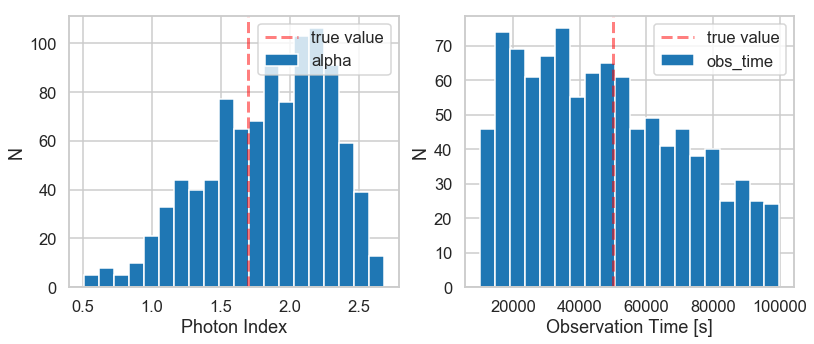

In [46]:
#Create figure comparing the alpha and observation time values 

params = Table.read('part3_parameters_sherpa.txt',format='ascii')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(13,5))
p1 = ax[0].hist(params['alpha'],bins=20)
p2 = ax[0].axvline(1.7,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('N',fontsize=18)

q1 = ax[1].hist(params['obs_time'],bins=20)
q2 = ax[1].axvline(50000,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[1].set_xlabel('Observation Time [s]',fontsize=18)
ax[1].set_ylabel('N',fontsize=18)

ax[0].legend(loc=1)
ax[1].legend(loc=1)

plt.savefig('abc_initial_results_sherpa.pdf')

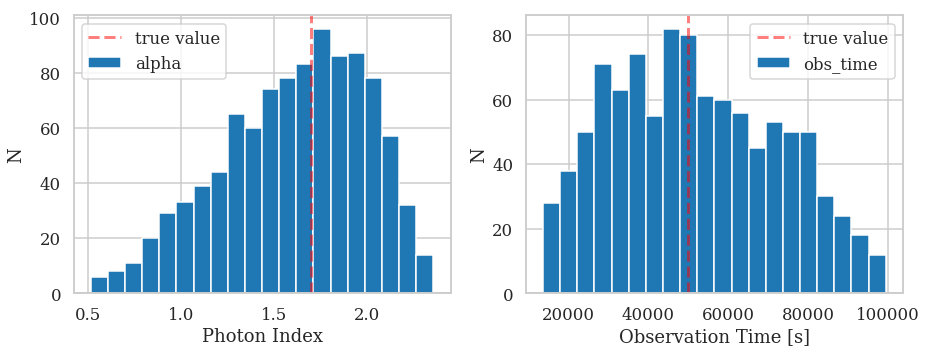

In [36]:
params = Table.read('part3_parameters_sherpa_ks.txt',format='ascii')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(13,5))
p1 = ax[0].hist(params['alpha'],bins=20)
p2 = ax[0].axvline(1.7,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('N',fontsize=18)

q1 = ax[1].hist(params['obs_time'],bins=20)
q2 = ax[1].axvline(50000,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[1].set_xlabel('Observation Time [s]',fontsize=18)
ax[1].set_ylabel('N',fontsize=18)

ax[0].legend(loc='best')
ax[1].legend(loc=1)

fig.tight_layout()

plt.savefig('abc_initial_results_sherpa_ks.pdf')

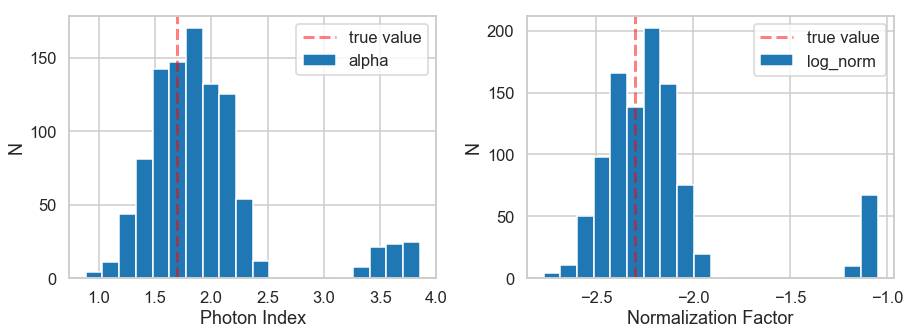

In [44]:
params = Table.read('part3_parameters_sherpa_ks.txt',format='ascii')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(13,5))
p1 = ax[0].hist(params['alpha'],bins=20)
p2 = ax[0].axvline(1.7,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('N',fontsize=18)

q1 = ax[1].hist(params['log_norm'],bins=20)
q2 = ax[1].axvline(-2.3,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[1].set_xlabel('Normalization Factor',fontsize=18)
ax[1].set_ylabel('N',fontsize=18)

ax[0].legend(loc='best')
ax[1].legend(loc=1)

fig.tight_layout()


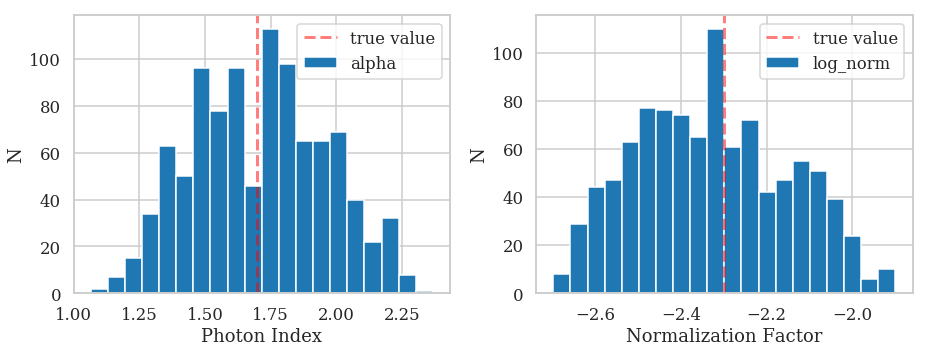

In [90]:
params = Table.read('part3_parameters_sherpa_md.txt',format='ascii')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(13,5))
p1 = ax[0].hist(params['alpha'],bins=20)
p2 = ax[0].axvline(1.7,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('N',fontsize=18)

q1 = ax[1].hist(params['log_norm'],bins=20)
q2 = ax[1].axvline(-2.3,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[1].set_xlabel('Normalization Factor',fontsize=18)
ax[1].set_ylabel('N',fontsize=18)

ax[0].legend(loc='best')
ax[1].legend(loc=1)

fig.tight_layout()
